In [961]:
%run ndbcHistorical.py
%run extractPointERA5.py

http://www.ndbc.noaa.gov/view_text_file.php?filename=41040h2021.txt.gz&dir=data/historical/stdmet/   does not exist


In [96]:
import os 
import xarray as xr
import numpy as np
import pandas as pd
from keras import models 
from keras import layers 
from keras.utils import plot_model
from sklearn.model_selection import train_test_split 
from keras import callbacks 
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
#from keras.callbacks import EarlyStopping
import random
import pywt
from sklearn.decomposition import PCA
from keras.optimizers import SGD
import datetime
import re
import glob
import matplotlib.dates as dates
import talos 
from talos.model.normalizers import lr_normalizer
#from keras.optimizers import Adam,RMSprop,SGD
from talos.model.early_stopper import early_stopper
import tensorflow as tf


In [97]:
buoysd=[]

for file in glob.glob('NDBC_historical_stdmet_4*.txt'):
    f=pd.read_table(file,delim_whitespace=True) 
    f=f.drop(f.loc[f['#YY'].str.contains('#',na=False)].index)
    f['time']=f.apply(lambda x:datetime.datetime.strptime("{0}-{1}-{2} {3}:{4}".format(x['#YY'],x['MM'], x['DD'], x['hh'], x['mm']), "%Y-%m-%d %H:%M"),axis=1)
    f=f.drop(f.columns[0:5],1)
    b=re.search('%s(.*)%s' %('4','_'),file).group(0)
    b=b.replace('_','')
    f['buoy']=b
    buoysd.append(f)
    
buoysd=pd.concat(buoysd)
buoysd=buoysd.set_index(['buoy','time']).astype(float)


array([[<AxesSubplot:title={'center':'WDIR'}>,
        <AxesSubplot:title={'center':'WSPD'}>,
        <AxesSubplot:title={'center':'GST'}>,
        <AxesSubplot:title={'center':'WVHT'}>],
       [<AxesSubplot:title={'center':'DPD'}>,
        <AxesSubplot:title={'center':'APD'}>,
        <AxesSubplot:title={'center':'MWD'}>,
        <AxesSubplot:title={'center':'PRES'}>],
       [<AxesSubplot:title={'center':'ATMP'}>,
        <AxesSubplot:title={'center':'WTMP'}>,
        <AxesSubplot:title={'center':'DEWP'}>,
        <AxesSubplot:title={'center':'VIS'}>],
       [<AxesSubplot:title={'center':'TIDE'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

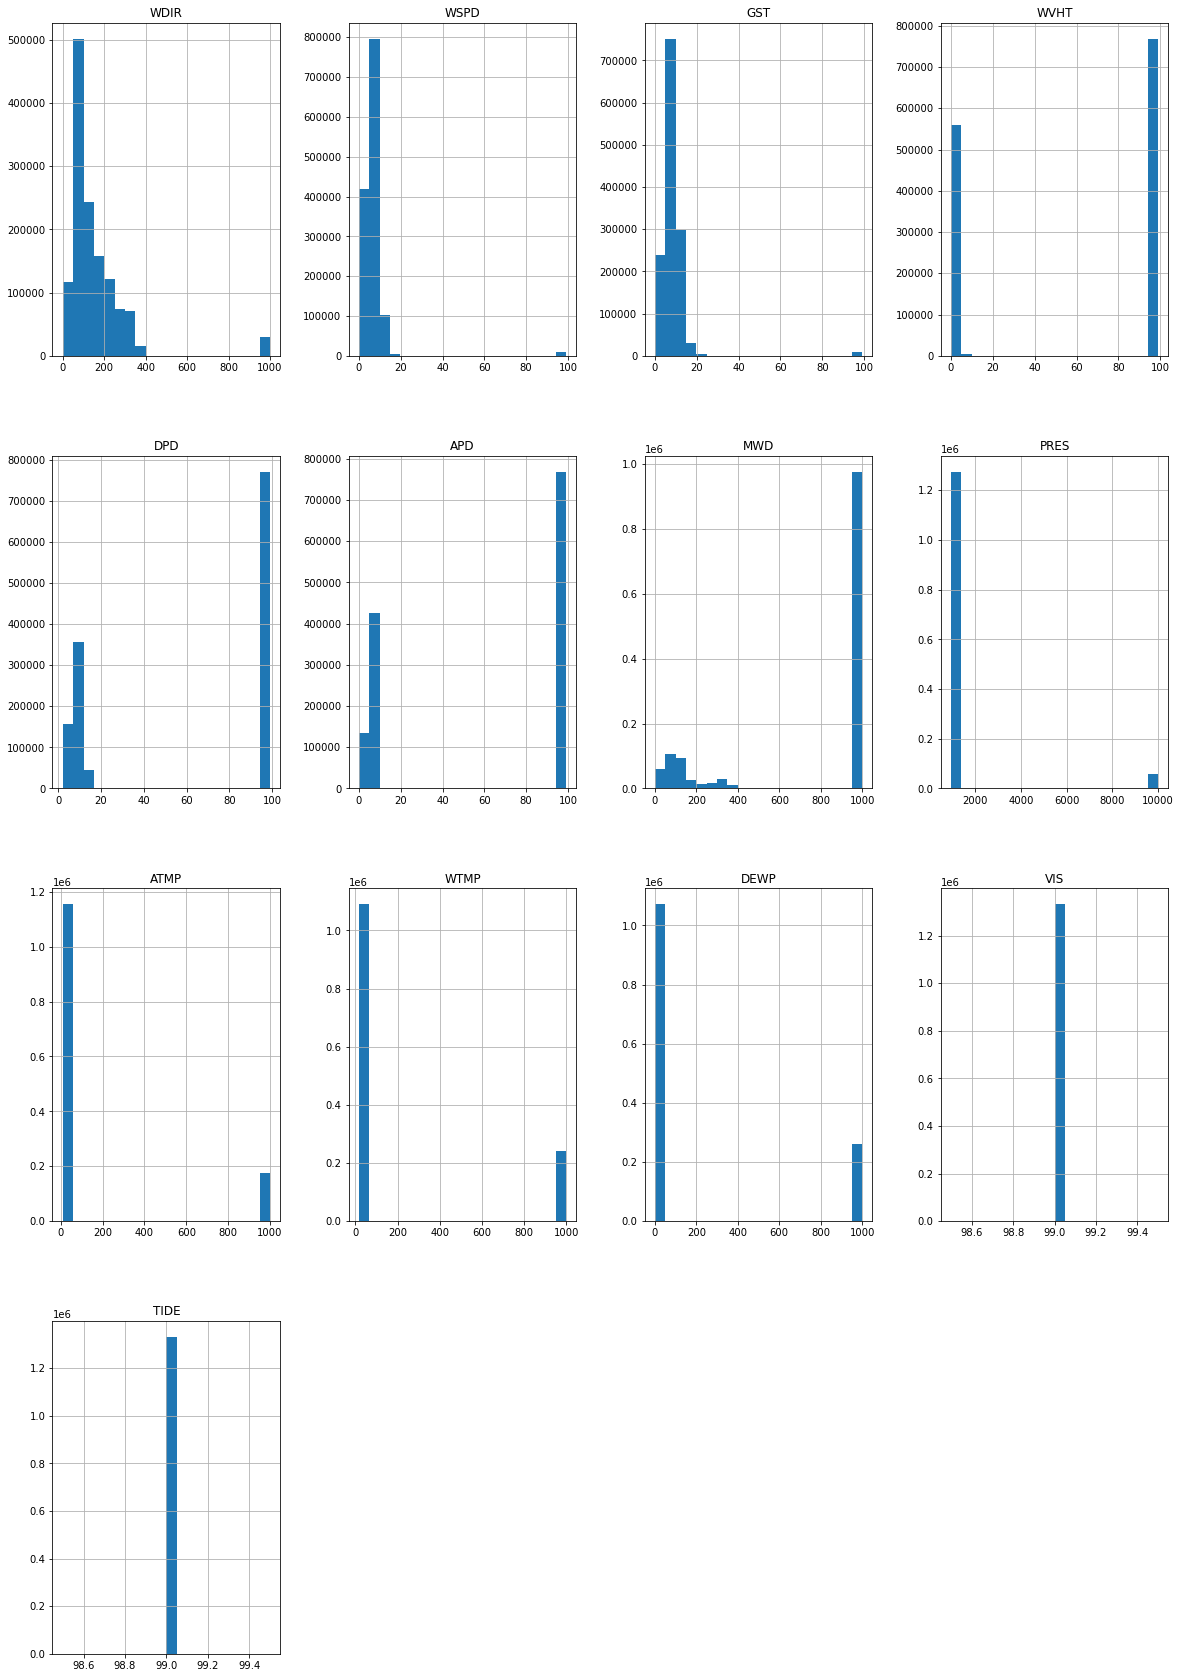

In [84]:
buoysd.hist(figsize=(20,30),bins=20)

In [98]:
buoysdata=buoysd[(buoysd['WVHT'] <99) & (buoysd['WDIR'] <=360) & (buoysd['WSPD'] < 99) & (buoysd['GST'] <99) 
                 & (buoysd['DPD'] <99) & (buoysd['APD'] <99) & (buoysd['GST'] <99) & (buoysd['PRES'] <9999) 
                 & (buoysd['ATMP'] <999) & (buoysd['WTMP'] <999) & (buoysd['DEWP'] <999) & (buoysd['MWD'] <999)]
buoysdata=buoysdata.drop(['VIS','TIDE'],1)

['41010', '42003', '41040', '41048', '41044']


Text(0.11, 0.5, 'days')

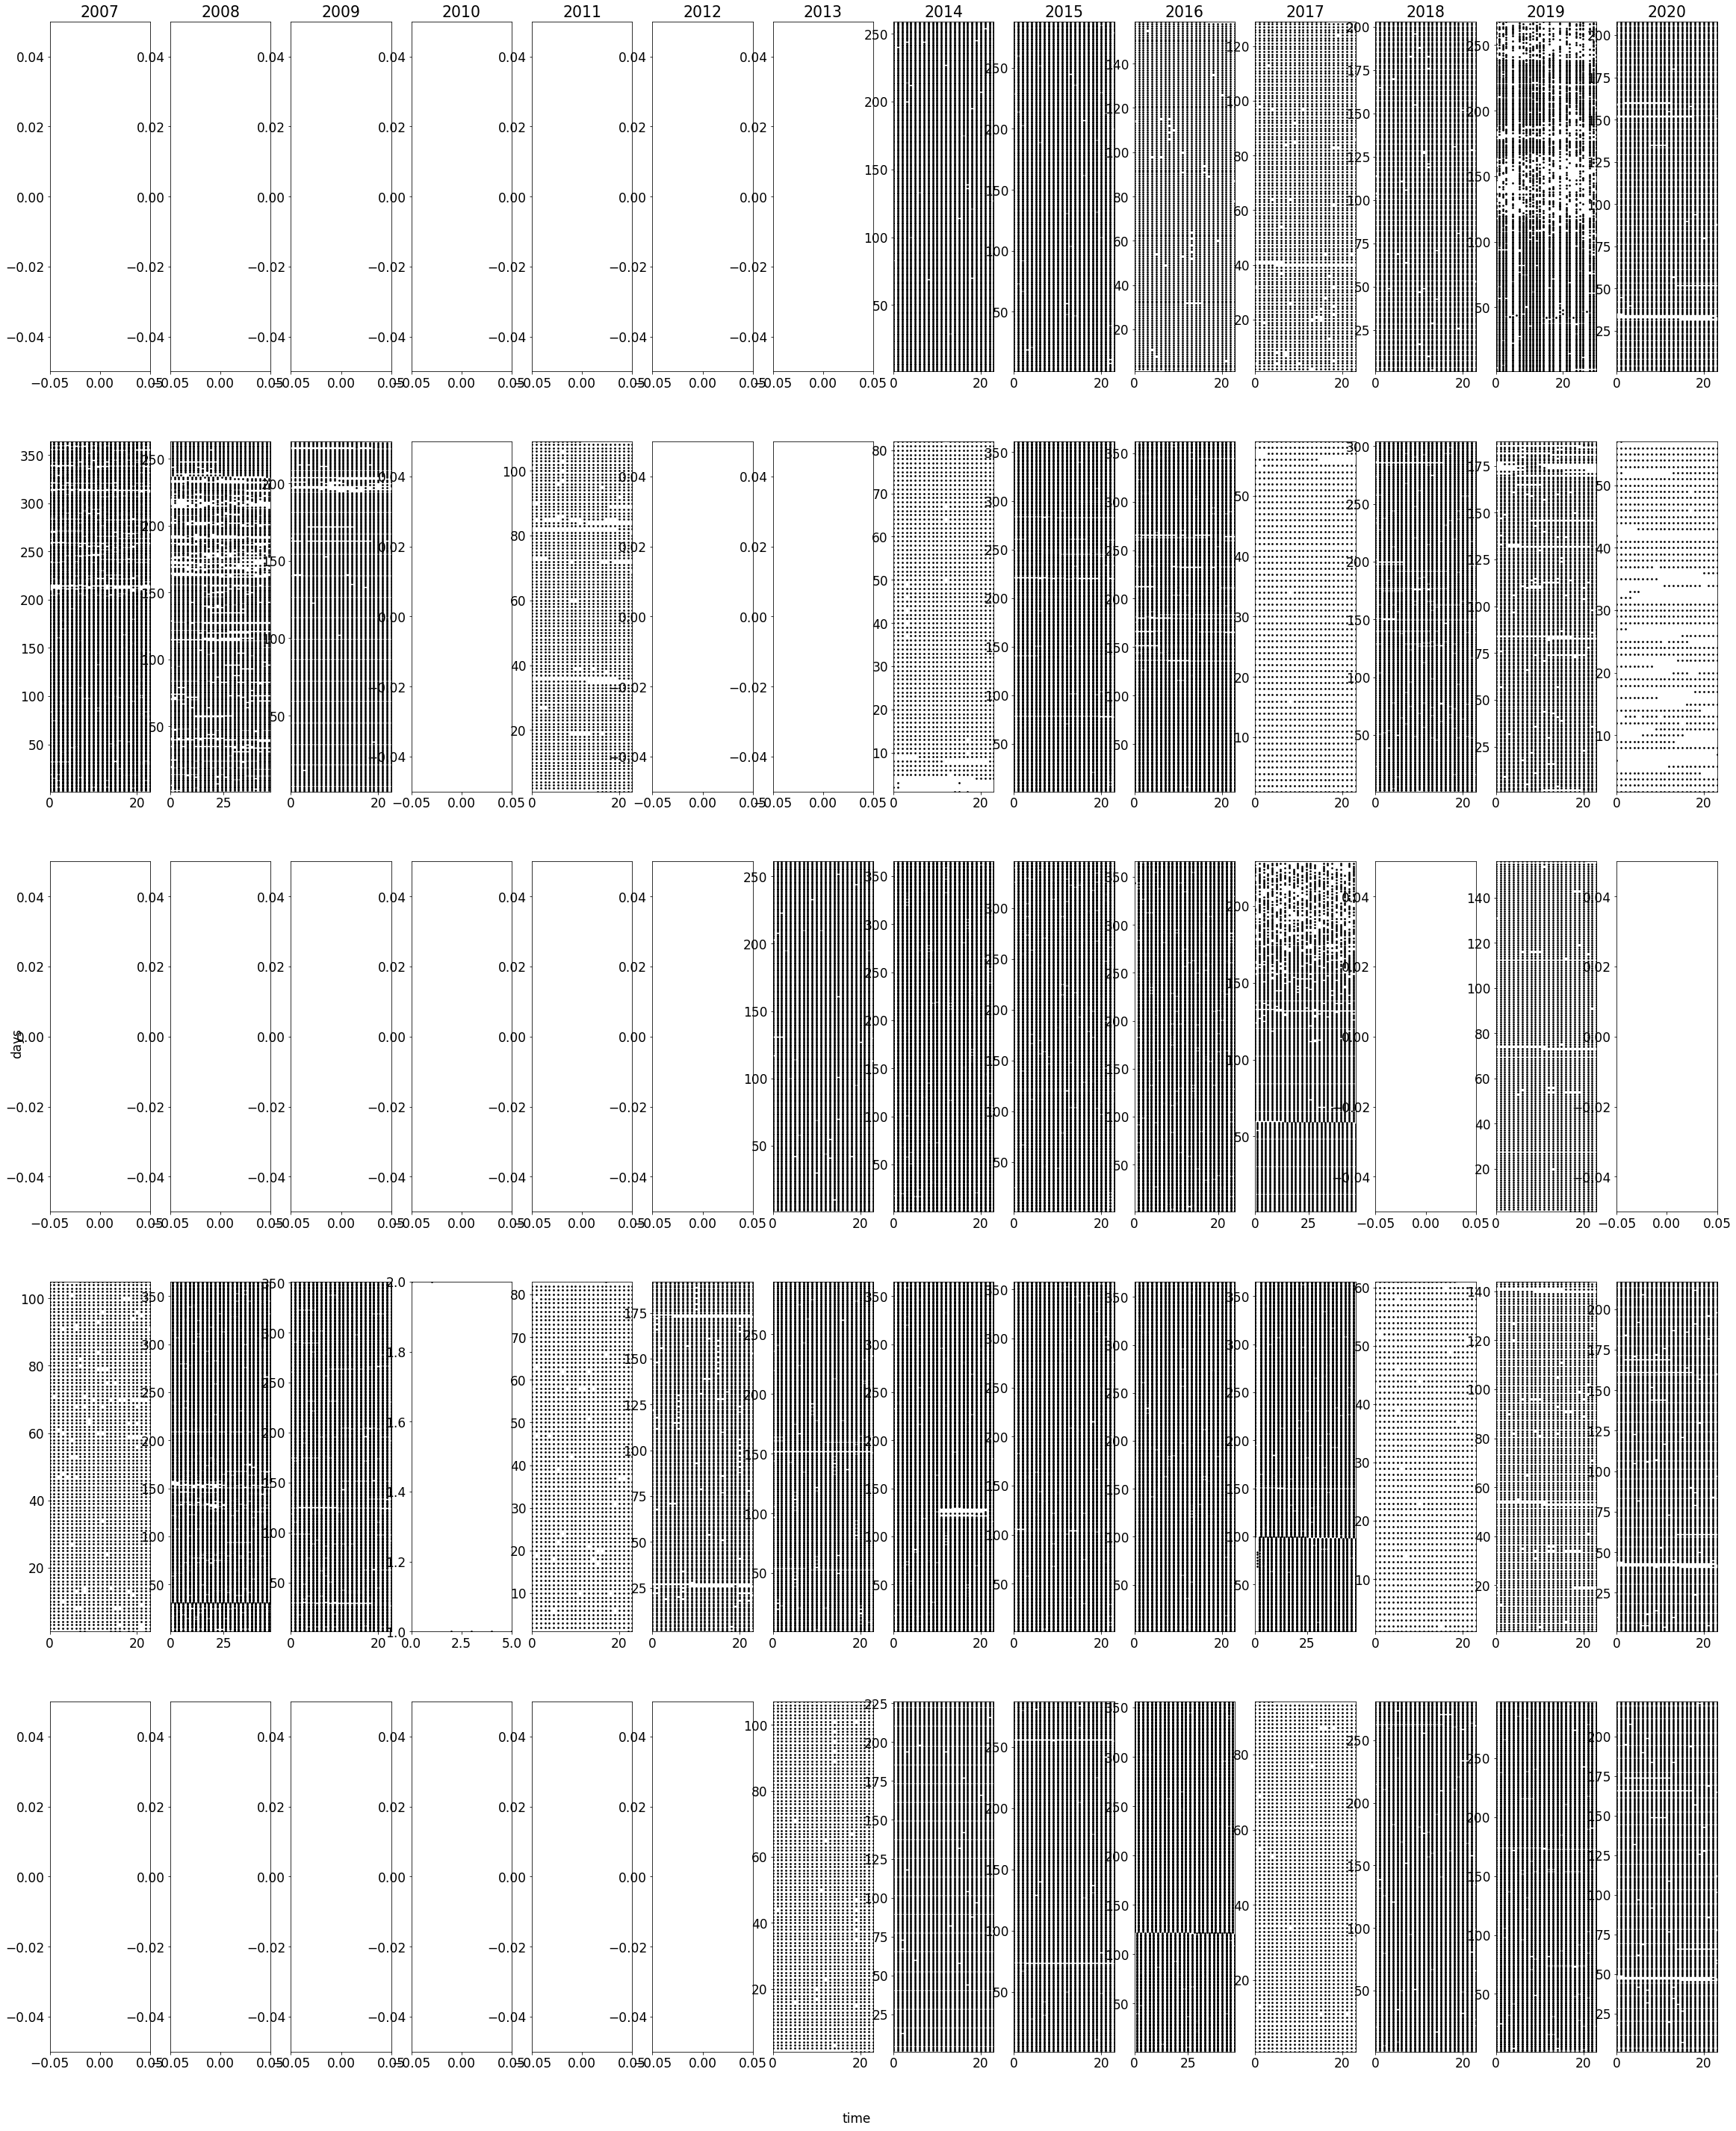

In [965]:
b=buoysdata.index.get_level_values(1).unique()
print(list(b))
cols=2021-2007 
years=np.array([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,2015, 2016, 2017, 2018, 2019,2020])
fig, axs = plt.subplots(len(b),cols,figsize=(40,50))
plt.rcParams.update({'font.size': 17})

for i in range(len(b)):#each row a buoy
    data=buoysdata.iloc[buoysdata.index.get_level_values(1) == b[i]]#specific buoy
    year=np.unique([d.year for d in data.index.get_level_values(0)])#years with data of one buoy location
    y=0
    for j in range(cols): #each column a year
        if year[y]==years[j]:
            
            datad=data[data.index.get_level_values(0).year == year[y]]     
            dic_t={}
            dic_d={}
            values=np.unique([d.time() for d in datad.index.get_level_values(0)])
            keys=np.arange(0,len(values))
            for w in keys:
                dic_t[w]=values[w]
            dic_t = dict((v,k) for k,v in dic_t.items())
            values=np.unique([d.date() for d in datad.index.get_level_values(0)])
            keys=np.arange(1,len(values)+1)
            for w in keys:
                dic_d[w]=values[w-1]
            dic_d = dict((v,k) for k,v in dic_d.items())

            f=pd.DataFrame(data={'t':[dic_t.get(x).astype(int) for x in [d.time() for d in datad.index.get_level_values(0)]],
                            'd': [dic_d.get(x).astype(int) for x in [d.date() for d in datad.index.get_level_values(0)]]})


            axs[i,j].scatter(f.t,f.d,s=3,c='black')
            if len(year)-1 > y:
                y+=1
        if i==0:
            axs[i,j].title.set_text(str(years[j]))
        axs[i,j].margins(0)
fig.text(0.5,0.1,'time',ha='center',va='center')
fig.text(0.11,0.5,'days',ha='center',va='center',rotation='vertical')



In [103]:
reanalysis=[]
for file in glob.glob('/home/wav/pointExtractERA5/result/ERA5_4*.txt'):
    bu=re.search('%s(.*)%s' %('4','.txt'),file).group(0)
    bu=bu.replace('.txt','')
    f=pd.read_table(file,delim_whitespace=True,header=1) 

    #f.columns = [''] * len(f.columns)
    f['buoy']=bu
    f['fctime']=[0]*f.shape[0]
    f=f.set_index(['fctime'])
    f=f.set_index(['buoy'],append=True)
    reanalysis.append(f)
reanalysis=pd.concat(reanalysis)
columns=list(reanalysis.columns)
columns.pop(0)
reanalysis=reanalysis.drop(reanalysis.columns[-1],axis=1)
reanalysis.columns=columns
reanalysis['time']=reanalysis.apply(lambda x:datetime.datetime.strptime("{0}-{1}-{2} {3}".format
                (x['YEAR'].astype(int),x['MONTH'].astype(int), x['DAY'].astype(int), x['HOUR'].astype(int)), "%Y-%m-%d %H"),axis=1)
reanalysis=reanalysis.drop(reanalysis.columns[0:4],1)
reanalysis=reanalysis.set_index(['time'],append=True)

In [106]:
reanalysis.columns

Index(['swh1', 'mwd1', 'mwp1', 'swh2', 'mwd2', 'mwp2', 'swh3', 'mwd3', 'mwp3',
       'u850', 'v850', 'msl', 'uwnd', 'vwnd', 'atmp', 'dewp', 'tmax', 'hmax',
       'm0wp', 'wdw', 'dwww', 'dwps', 'swh', 'mwd', 'pp1d', 'mwp', 'shww',
       'mdww', 'mpww', 'shts', 'mdts', 'mpts', 'i10fg', 'sst', '10fg', 'hgt'],
      dtype='object')

In [105]:
reanalysis.to_csv('era5_1516.txt', header=True, index=True, sep=' ', mode='w')

In [102]:
datad=buoysdata[(buoysdata.index.get_level_values(1).year == 2015) | (buoysdata.index.get_level_values(1).year == 2016) ]     
#values=np.unique([d.time() for d in datad.index.get_level_values(0)])
datad.to_csv('buoysdata1516.txt', header=True, index=True, sep=' ', mode='w')

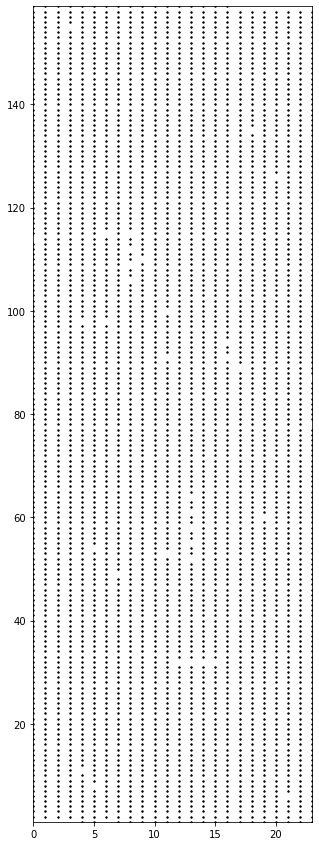

In [138]:
b=buoysdata.index.get_level_values(0).unique()
i=0#buoy
j=2#year
data=buoysdata.iloc[buoysdata.index.get_level_values(0)== b[i]]#specific buoy
date=np.unique([d.year for d in data.index.get_level_values(1)])#years with data of one buoy location
datad=data[data.index.get_level_values(1).year == date[j]]     
dic_t={}
values=np.unique([d.time() for d in datad.index.get_level_values(1)])
keys=np.arange(0,len(values))
for w in keys:
    dic_t[w]=values[w]
dic_t = dict((v,k) for k,v in dic_t.items())

dic_d={}
values=np.unique([d.date() for d in datad.index.get_level_values(1)])
keys=np.arange(1,len(values)+1)
for w in keys:
    dic_d[w]=values[w-1]
dic_d = dict((v,k) for k,v in dic_d.items())

f=pd.DataFrame(data={'t':[dic_t.get(x).astype(int) for x in [d.time() for d in datad.index.get_level_values(1)]],
                'd': [dic_d.get(x).astype(int) for x in [d.date() for d in datad.index.get_level_values(1)]]})
plt.rcParams["figure.figsize"] = (5,15)
plt.scatter(f.t,f.d,s=2,c='black')
plt.margins(0)


In [748]:
i=4 #buoy
j=0 #year
data=buoysdata.iloc[buoysdata.index.get_level_values(1) == b[i]]#specific buoy
date=np.unique([d.year for d in data.index.get_level_values(0)])#years with data of one buoy location
datad=data[data.index.get_level_values(0).year != date[j]]     

datad

WDIR  WSPD   GST  WVHT    DPD   APD    PRES  ATMP  \
time                buoy                                                       
2008-01-01 00:00:00 46001  70.0  19.5  24.9  6.47  10.81  7.79   993.8   3.1   
2008-01-01 01:00:00 46001  73.0  17.4  22.4  6.71  12.12  8.14   992.2   3.3   
2008-01-01 02:00:00 46001  72.0  17.7  22.4  7.14  12.90  8.60   990.7   3.4   
2008-01-01 03:00:00 46001  75.0  17.6  22.3  8.61  12.90  9.28   988.8   3.7   
2008-01-01 04:00:00 46001  72.0  18.1  22.1  9.39  13.79  9.73   986.5   3.7   
...                         ...   ...   ...   ...    ...   ...     ...   ...   
2020-12-31 18:50:00 46001  90.0  10.9  13.9  2.42  10.81  6.18  1000.3   4.2   
2020-12-31 19:50:00 46001  92.0  11.1  14.0  2.50  10.81  6.29   999.6   4.0   
2020-12-31 20:50:00 46001  93.0  11.4  14.3  2.52   9.09  5.99   998.8   3.9   
2020-12-31 21:50:00 46001  79.0  10.5  13.4  2.73   6.25  6.02   998.2   4.0   
2020-12-31 22:50:00 46001  78.0  12.3  15.3  2.60   6.25  5.97   997.0   4.1   

                           WTMP   DEWP  
time                buoy                
2008-01-01 00:00:00 46001   4.4  999.0  
2008-01-01 01:00:00 46001   4.4  999.0  
2008-01-01 02:00:00 46001   4.4  999.0  
2008-01-01 03:00:00 46001   4.3  999.0  
2008-01-01 04:00:00 46001   4.3  999.0  
...                         ...    ...  
2020-12-31 18:50:00 46001   4.7  999.0  
2020-12-31 19:50:00 46001   4.7  999.0  
2020-12-31 20:50:00 46001   4.7  999.0  
2020-12-31 21:50:00 46001   4.7  999.0  
2020-12-31 22:50:00 46001   4.7  999.0  

[110035 rows x 10 columns]

In [770]:
ww3_0=xr.open_dataset(os.path.join('/media/data/forecast/ww3/2021011400','multi_1.glo30m.t00z.nc') 
                     ).to_dataframe().dropna(how='all')


ww3_1=xr.open_dataset(os.path.join('/media/data/forecast/ww3/2021011500','multi_1.glo30m.t00z.nc') 
                     ).to_dataframe().dropna(how='all')
secs_per_day = 24*60*60    # hours * mins * secs

In [786]:
lat_0=ww3_0.index.get_level_values('latitude').unique()
lon_0=ww3_0.index.get_level_values('longitude').unique()
i=0;j=0 #choose site (lat and lon)
data_d=ww3_0.iloc[(ww3_0.index.get_level_values(0)==lat_0[i])& (ww3_0.index.get_level_values(1)==lon_0[j])].sort_values(by='time')


In [787]:
nowcast=data_d.index.get_level_values('time').unique()[0]
repetitions=int(data_d.shape[0]/len(data_d.index.get_level_values('time').unique()))

In [788]:
forecast=np.round((data_d.index.get_level_values('time').unique()-nowcast).total_seconds()/secs_per_day,3)
data_d['forecast_days']=np.array([forecast.values]*repetitions).flatten()
data_d.set_index('forecast_days',append=True,inplace=True)

In [112]:
dfw=xr.open_dataset('WW3_selectionPointNearest_20190925_20200701.nc',decode_times=False)
units, reference_date = dfw.time.attrs['units'].split(' since ')
times=[]
for i in range(dfw.time.size):
    times.append(datetime.datetime.strptime(reference_date,'%Y-%m-%d %H:%M:%S') +timedelta(seconds=dfw.time.values[i]))   
    
dfw=dfw.to_dataframe().dropna(subset=['Hs']) #remove nans in HS
dfw.index=dfw.index.set_levels(times,level=2)
cols=dfw.columns[4:] #remove irrelevant cols from dataframe
fct=dfw.index.get_level_values('fctime').unique()

buoys=xr.open_dataset('NDBC_selection_deepWaters_20190925_20200701.nc')
buoys=buoys[['WVHT','DPD','WDIR']].to_dataframe()
f5=np.where(fct[:] == 432000)[0][0] #day 5
fl=60 #last index with prediction, which is 7.5

In [19]:
def target(X,buoy):
    '''
    X numerical model with multiindex: 
        - level 0 - forecast time
        - level 1 - buoy
        - level 2 - time
    buoy Hs, U and Tp data with multiindex:
        - level 0 - buoy 
        - level 1 - time
    '''
    l=len(X.index)   
    match=[]
    #Add hs prediction errors
    errorh=np.empty((0))
    errort=np.empty((0))
    erroru=np.empty((0))
    for i in range(l):            
        time= X.index.get_level_values(2)[i]+timedelta(seconds=X.index.get_level_values(0)[i])
        ind = np.where(buoy.index.get_level_values(1) == time) #find position where times match 
        match.append(buoy.iloc[ind])
        if len(ind[0])!=0: #if a position was found, append to array of errors abs of difference
            errorh = np.append(errorh, X['Hs'].values[i] - buoy['WVHT'].values[ind]) 
            errort = np.append(errort, X['Tp'].values[i] - buoy['DPD'].values[ind]) 
            erroru = np.append(erroru, X['uDp'].values[i] - buoy['uWDIR'].values[ind]) 
        else: #if no position was found
            errorh = np.append(errorh, np.nan)
            errort = np.append(errort, np.nan)
            erroru = np.append(erroru, np.nan)
    y = pd.DataFrame(list(zip(errorh,errort,erroru)),
               columns =['errorh', 'errort','erroru'])
    return y

def directionComp( X, directionVars):
    '''
    Input: 
        - X - dataframe
        - directionVars - list of direction variables' names  
    Output: X with u & v components 
    
    '''    
    for i in directionVars:
        if any(var == i for var in X.columns): #confirm if that variable is in X
            X=X.dropna(subset=[i]) #remove nans from dataframe
            d=X[i].values
            u=np.cos(2*np.pi*d/360)
            v=np.sin(2*np.pi*d/360)        
            del X[i]
            X['u%s'%(i)]=u
            X['v%s'%(i)]=v
        else: 
            print('Variable %s is not in X'%(i))    
    return X

def generate_dataset(input_scaler, output_scaler,X):

    '''
    scaler can be MinMaxScaler(), StandardScaler() or None
    X - DataFrame with inputs
    '''

    
    # split into train and test
    test_size=int(0.2*len(X)) #split can't be shuffled because of wt
    X_train=X[test_size:]
    y_train=y[test_size:]
    X_test=X[:test_size]
    y_test=y[:test_size]

    # scale inputs
    if input_scaler is not None:
        input_scaler.fit(X_train)
        X_train = pd.DataFrame(input_scaler.transform(X_train),index=X_train.index.get_level_values('time'),columns=X.columns)
        X_test = pd.DataFrame(input_scaler.transform(X_test),index=X_test.index.get_level_values('time'),columns=X.columns)
        
    if output_scaler is not None:
        output_scaler.fit(y_train)
        y_train = output_scaler.transform(y_train)
        y_test = output_scaler.transform(y_test)
    return X_train, X_test, y_train, y_test
 

In [107]:
f=0 #forecast time index
b=0 #buoy index
X=dfw.iloc[(dfw.index.get_level_values('fctime')==fct[f]) & (dfw.index.get_level_values('nbuoys')==b)][cols] 
directionVars=['Dp','Dswell1','Dswell2','Dwsea']
X=directionComp(X,directionVars) 
B=directionComp(buoys.iloc[buoys.index.get_level_values(0)==b],['WDIR'])

y=target(X,B)
    
#----Remove nans----------
index=np.unique(np.where(pd.isnull(y))[0]) # np.argwhere(np.isnan(y)).flatten()
y=y.drop(index) #np.delete(y,index) 
X=X.drop(X.index[index])
#y=y.reshape(len(y),1)

array([[<AxesSubplot:title={'center':'Hs'}>,
        <AxesSubplot:title={'center':'Tp'}>,
        <AxesSubplot:title={'center':'Hswell1'}>,
        <AxesSubplot:title={'center':'Hswell2'}>],
       [<AxesSubplot:title={'center':'Tswell1'}>,
        <AxesSubplot:title={'center':'Tswell2'}>,
        <AxesSubplot:title={'center':'Hwsea'}>,
        <AxesSubplot:title={'center':'Twsea'}>],
       [<AxesSubplot:title={'center':'uDp'}>,
        <AxesSubplot:title={'center':'vDp'}>,
        <AxesSubplot:title={'center':'uDswell1'}>,
        <AxesSubplot:title={'center':'vDswell1'}>],
       [<AxesSubplot:title={'center':'uDswell2'}>,
        <AxesSubplot:title={'center':'vDswell2'}>,
        <AxesSubplot:title={'center':'uDwsea'}>,
        <AxesSubplot:title={'center':'vDwsea'}>]], dtype=object)

  0%|          | 2791/1215000 [118:47:11<51592:16:00, 153.22s/it]


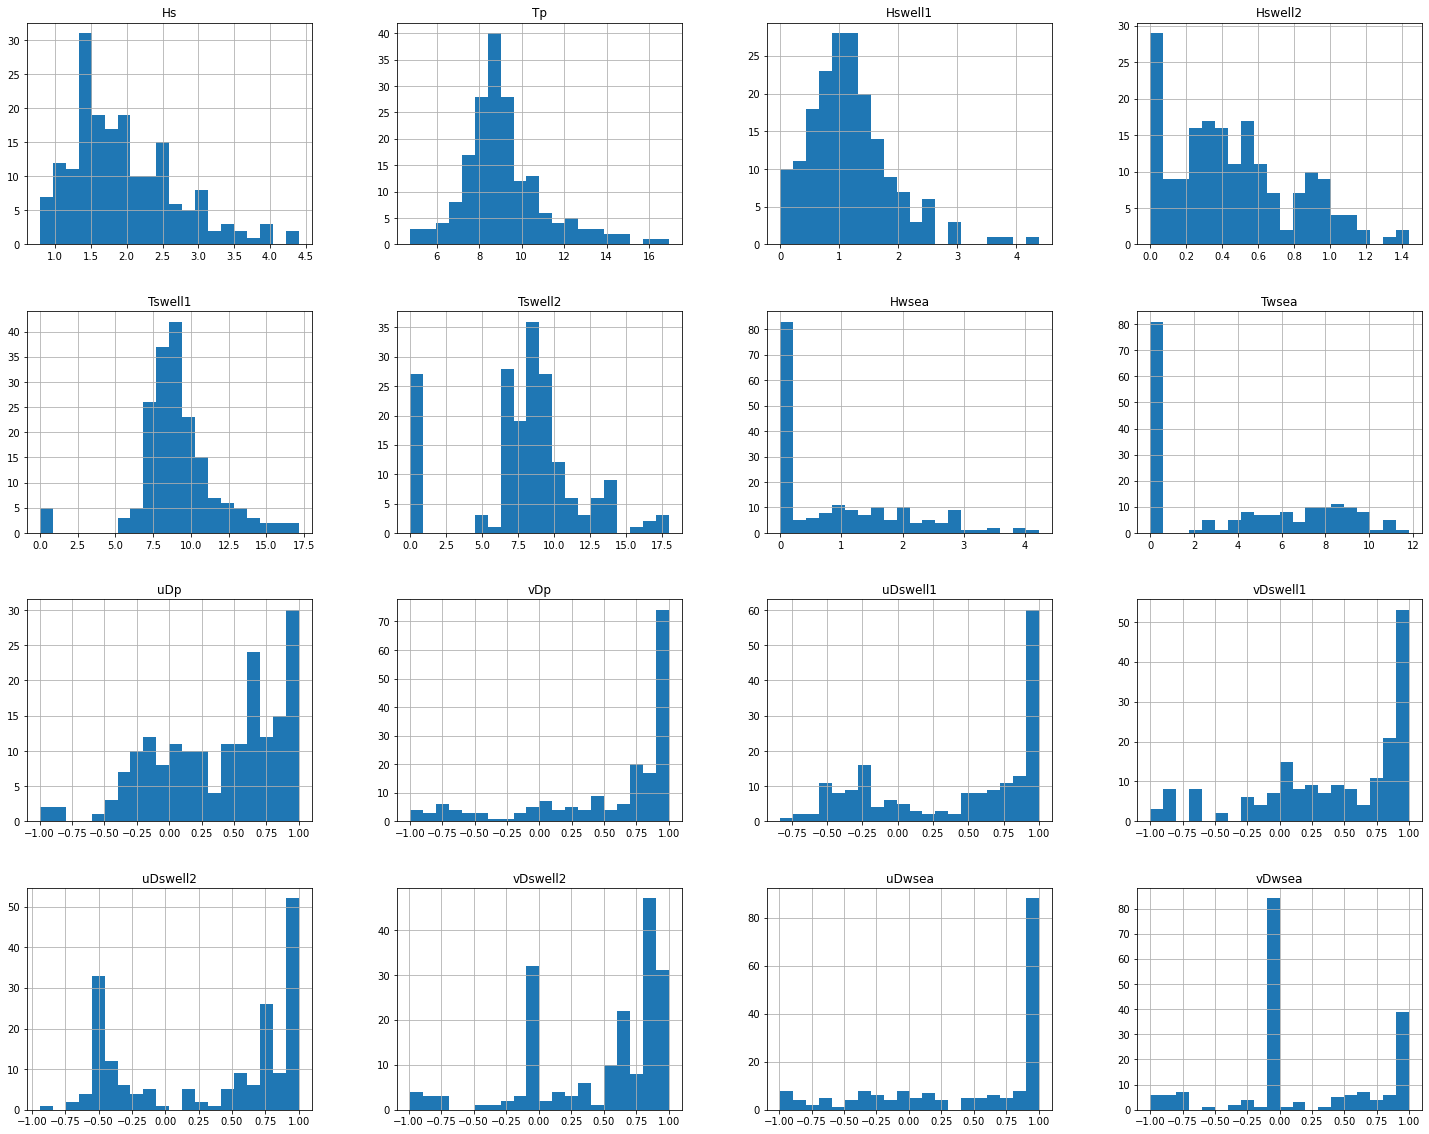

In [137]:
X.hist(figsize=(25,20),bins=20)

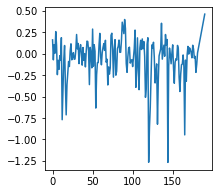

In [138]:
plt.rcParams["figure.figsize"] = (3,3)
plt.plot(y.iloc[:,0])

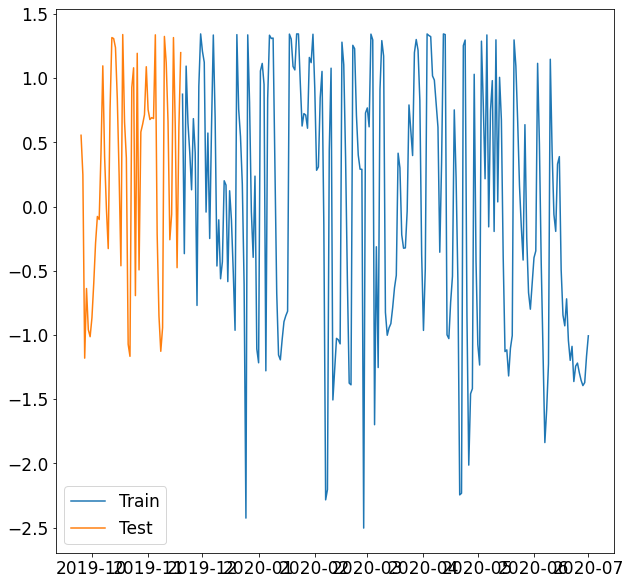

In [880]:
plt.figure(figsize=(10,10))
plt.plot(X_train.index.get_level_values('time').values,X_train['uDp'].values,label='Train')
plt.plot(X_test.index.get_level_values('time').values,X_test['uDp'].values,label='Test')
plt.legend()

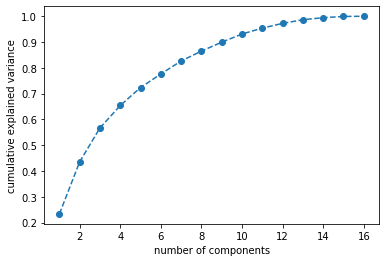

In [495]:
#-----PCA--------
pca = PCA().fit(X_train)
plt.plot(range(1,len(X_train.columns) +1),np.cumsum(pca.explained_variance_ratio_),marker='o',linestyle='--')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [22]:
X_train, X_test, y_train, y_test = generate_dataset(StandardScaler(),MinMaxScaler(),X)

X_trainv, X_testv,y_trainv, y_testv = train_test_split(X_train,y_train,test_size=0.2,random_state=1)

pca=PCA(.95) #95% of variance explained
pca.fit(X_trainv)
X_trainv=pca.transform(X_trainv)
X_testv=pca.transform(X_testv)

In [74]:

# (1) Define dict of parameters to try
p = {'first_neuron':[5,15,50,100,200,500],#list(np.arange(2,500,5))
     'activation':['relu','sigmoid','tanh'],
     'hidden_layers':[0,1,2],
     'shapes': ['brick', 'funnel'],
     'optimizer': ['Adam','SGD'],
     'kernel_initializer': ['gorot_uniform','gorot_normal','orthogonal','he_normal'],
     'dropout': [0.0,0.25,0.5],
     'lr':[10**-3, 10**-2, 10**-1],
     'momentum':[0.9,0.5,0.2]}

# (2) create a function which constructs a compiled keras model object
def nnet_model(X_train, y_train, X_val, y_val, params):

    model = models.Sequential()    
    
    # initial layer
    model.add(layers.Dense(params['first_neuron'], input_dim=X_train.shape[1],
                    activation=params['activation'],
                    kernel_initializer = params['kernel_initializer'] ))
    model.add(layers.Dropout(params['dropout']))
    
    # hidden layers
    talos.utils.hidden_layers(model, params, 3)
    
    
    # final layer
    model.add(layers.Dense(3, 
                    kernel_initializer=params['kernel_initializer']))
    
    if params['optimizer']=="Adam":
        opt=keras.optimizers.Adam(lr=params['lr'], beta_1=0.9, beta_2=0.999)
    if params['optimizer']=="SGD":
        opt=keras.optimizers.SGD(lr=params['lr'], momentum=params['momentum'], nesterov=True)
    
    model.compile(loss='mean_absolute_error',optimizer=opt,
                 metrics=['mse'])
    
    #model.compile(loss='mean_absolute_error', optimizer=params['optimizer'](lr=lr_normalizer(params['lr'],params['optmetrics=['mse'])
    #monitor=EarlyStopping(monitor='val_loss',verbose=1,patience=1)
    history = model.fit(X_train, y_train, 
                        validation_data=(X_val, y_val),
                        batch_size=32,
                        epochs=1000,
                        verbose=1,
                        callbacks=[early_stopper(epochs=1000, 
                                                mode='strict', 
                                                monitor='val_loss')])
    return history, model



# (3) Run a "Scan" using the params and function created above

t = talos.Scan(x=X_trainv,
            y=y_trainv,
            x_val=X_testv,
            y_val=y_testv,
            model=nnet_model,
            params=p,
            #fraction_limit=0.50,
            experiment_name='nnet_opt')


  0%|          | 1/5832 [1:40:29<9766:19:40, 6029.63s/it]

  0%|          | 0/5832 [00:00<?, ?it/s]

Epoch 1/1000
4/4 [==============================] - 1s 349ms/step - loss: 0.5325 - mse: 0.3273 - val_loss: 0.5249 - val_mse: 0.3238
Epoch 2/1000
4/4 [==============================] - 1s 221ms/step - loss: 0.5325 - mse: 0.3273 - val_loss: 0.5249 - val_mse: 0.3238
Epoch 3/1000
4/4 [==============================] - 1s 159ms/step - loss: 0.5325 - mse: 0.3273 - val_loss: 0.5249 - val_mse: 0.3238
Epoch 4/1000
4/4 [==============================] - 0s 94ms/step - loss: 0.5325 - mse: 0.3273 - val_loss: 0.5249 - val_mse: 0.3238
Epoch 5/1000
4/4 [==============================] - 1s 147ms/step - loss: 0.5325 - mse: 0.3273 - val_loss: 0.5249 - val_mse: 0.3238
Epoch 6/1000
4/4 [==============================] - 0s 96ms/step - loss: 0.5325 - mse: 0.3273 - val_loss: 0.5249 - val_mse: 0.3238
Epoch 7/1000
4/4 [==============================] - 1s 217ms/step - loss: 0.5325 - mse: 0.3272 - val_loss: 0.5249 - val_mse: 0.3238
Epoch 8/1000
4/4 [==============================] - 1s 222ms/step - loss: 0.53

Epoch 63/1000
4/4 [==============================] - 1s 275ms/step - loss: 0.5322 - mse: 0.3269 - val_loss: 0.5246 - val_mse: 0.3235
Epoch 64/1000
4/4 [==============================] - 1s 174ms/step - loss: 0.5322 - mse: 0.3269 - val_loss: 0.5246 - val_mse: 0.3235
Epoch 65/1000
4/4 [==============================] - 0s 77ms/step - loss: 0.5321 - mse: 0.3269 - val_loss: 0.5246 - val_mse: 0.3235
Epoch 66/1000
4/4 [==============================] - 1s 155ms/step - loss: 0.5321 - mse: 0.3269 - val_loss: 0.5246 - val_mse: 0.3235
Epoch 67/1000
4/4 [==============================] - 1s 187ms/step - loss: 0.5321 - mse: 0.3269 - val_loss: 0.5246 - val_mse: 0.3235
Epoch 68/1000
4/4 [==============================] - 1s 131ms/step - loss: 0.5321 - mse: 0.3269 - val_loss: 0.5246 - val_mse: 0.3235
Epoch 69/1000
4/4 [==============================] - 1s 219ms/step - loss: 0.5321 - mse: 0.3269 - val_loss: 0.5246 - val_mse: 0.3235
Epoch 70/1000
4/4 [==============================] - 1s 142ms/step - l

4/4 [==============================] - 0s 79ms/step - loss: 0.5315 - mse: 0.3262 - val_loss: 0.5240 - val_mse: 0.3228
Epoch 186/1000
4/4 [==============================] - 0s 93ms/step - loss: 0.5315 - mse: 0.3262 - val_loss: 0.5240 - val_mse: 0.3228
Epoch 187/1000
4/4 [==============================] - 1s 174ms/step - loss: 0.5315 - mse: 0.3262 - val_loss: 0.5240 - val_mse: 0.3228
Epoch 188/1000
4/4 [==============================] - 1s 189ms/step - loss: 0.5315 - mse: 0.3262 - val_loss: 0.5240 - val_mse: 0.3228
Epoch 189/1000
4/4 [==============================] - 1s 222ms/step - loss: 0.5315 - mse: 0.3262 - val_loss: 0.5240 - val_mse: 0.3228
Epoch 190/1000
4/4 [==============================] - 1s 179ms/step - loss: 0.5315 - mse: 0.3262 - val_loss: 0.5240 - val_mse: 0.3228
Epoch 191/1000
4/4 [==============================] - 1s 160ms/step - loss: 0.5315 - mse: 0.3262 - val_loss: 0.5240 - val_mse: 0.3228
Epoch 192/1000
4/4 [==============================] - 1s 194ms/step - loss: 0.5

4/4 [==============================] - 0s 110ms/step - loss: 0.5309 - mse: 0.3255 - val_loss: 0.5234 - val_mse: 0.3221
Epoch 308/1000
4/4 [==============================] - 1s 137ms/step - loss: 0.5308 - mse: 0.3255 - val_loss: 0.5234 - val_mse: 0.3221
Epoch 309/1000
4/4 [==============================] - 1s 184ms/step - loss: 0.5308 - mse: 0.3255 - val_loss: 0.5234 - val_mse: 0.3221
Epoch 310/1000
4/4 [==============================] - 0s 119ms/step - loss: 0.5308 - mse: 0.3255 - val_loss: 0.5234 - val_mse: 0.3221
Epoch 311/1000
4/4 [==============================] - 1s 152ms/step - loss: 0.5308 - mse: 0.3255 - val_loss: 0.5234 - val_mse: 0.3221
Epoch 312/1000
4/4 [==============================] - 1s 162ms/step - loss: 0.5308 - mse: 0.3255 - val_loss: 0.5234 - val_mse: 0.3221
Epoch 313/1000
4/4 [==============================] - 1s 199ms/step - loss: 0.5308 - mse: 0.3255 - val_loss: 0.5234 - val_mse: 0.3221
Epoch 314/1000
4/4 [==============================] - 1s 207ms/step - loss: 0

4/4 [==============================] - 1s 135ms/step - loss: 0.5302 - mse: 0.3248 - val_loss: 0.5228 - val_mse: 0.3215
Epoch 430/1000
4/4 [==============================] - 1s 144ms/step - loss: 0.5302 - mse: 0.3248 - val_loss: 0.5228 - val_mse: 0.3215
Epoch 431/1000
4/4 [==============================] - 1s 148ms/step - loss: 0.5302 - mse: 0.3248 - val_loss: 0.5228 - val_mse: 0.3215
Epoch 432/1000
4/4 [==============================] - 1s 162ms/step - loss: 0.5302 - mse: 0.3248 - val_loss: 0.5228 - val_mse: 0.3215
Epoch 433/1000
4/4 [==============================] - 1s 152ms/step - loss: 0.5302 - mse: 0.3248 - val_loss: 0.5228 - val_mse: 0.3215
Epoch 434/1000
4/4 [==============================] - 1s 190ms/step - loss: 0.5302 - mse: 0.3248 - val_loss: 0.5228 - val_mse: 0.3214
Epoch 435/1000
4/4 [==============================] - 1s 138ms/step - loss: 0.5302 - mse: 0.3248 - val_loss: 0.5228 - val_mse: 0.3214
Epoch 436/1000
4/4 [==============================] - 1s 138ms/step - loss: 0

4/4 [==============================] - 1s 152ms/step - loss: 0.5296 - mse: 0.3242 - val_loss: 0.5222 - val_mse: 0.3208
Epoch 552/1000
4/4 [==============================] - 1s 213ms/step - loss: 0.5296 - mse: 0.3242 - val_loss: 0.5222 - val_mse: 0.3208
Epoch 553/1000
4/4 [==============================] - 0s 114ms/step - loss: 0.5295 - mse: 0.3241 - val_loss: 0.5222 - val_mse: 0.3208
Epoch 554/1000
4/4 [==============================] - 0s 107ms/step - loss: 0.5295 - mse: 0.3241 - val_loss: 0.5222 - val_mse: 0.3208
Epoch 555/1000
4/4 [==============================] - 1s 132ms/step - loss: 0.5295 - mse: 0.3241 - val_loss: 0.5222 - val_mse: 0.3208
Epoch 556/1000
4/4 [==============================] - 1s 165ms/step - loss: 0.5295 - mse: 0.3241 - val_loss: 0.5222 - val_mse: 0.3208
Epoch 557/1000
4/4 [==============================] - 1s 150ms/step - loss: 0.5295 - mse: 0.3241 - val_loss: 0.5221 - val_mse: 0.3208
Epoch 558/1000
4/4 [==============================] - 1s 154ms/step - loss: 0

4/4 [==============================] - 0s 121ms/step - loss: 0.5289 - mse: 0.3235 - val_loss: 0.5216 - val_mse: 0.3202
Epoch 674/1000
4/4 [==============================] - 1s 126ms/step - loss: 0.5289 - mse: 0.3235 - val_loss: 0.5216 - val_mse: 0.3201
Epoch 675/1000
4/4 [==============================] - 0s 112ms/step - loss: 0.5289 - mse: 0.3235 - val_loss: 0.5216 - val_mse: 0.3201
Epoch 676/1000
4/4 [==============================] - 0s 102ms/step - loss: 0.5289 - mse: 0.3235 - val_loss: 0.5216 - val_mse: 0.3201
Epoch 677/1000
4/4 [==============================] - 1s 135ms/step - loss: 0.5289 - mse: 0.3234 - val_loss: 0.5216 - val_mse: 0.3201
Epoch 678/1000
4/4 [==============================] - 1s 132ms/step - loss: 0.5289 - mse: 0.3234 - val_loss: 0.5215 - val_mse: 0.3201
Epoch 679/1000
4/4 [==============================] - 1s 128ms/step - loss: 0.5289 - mse: 0.3234 - val_loss: 0.5215 - val_mse: 0.3201
Epoch 680/1000
4/4 [==============================] - 1s 131ms/step - loss: 0

4/4 [==============================] - 1s 152ms/step - loss: 0.5283 - mse: 0.3228 - val_loss: 0.5210 - val_mse: 0.3195
Epoch 796/1000
4/4 [==============================] - 0s 110ms/step - loss: 0.5283 - mse: 0.3228 - val_loss: 0.5210 - val_mse: 0.3195
Epoch 797/1000
4/4 [==============================] - 1s 143ms/step - loss: 0.5283 - mse: 0.3228 - val_loss: 0.5210 - val_mse: 0.3195
Epoch 798/1000
4/4 [==============================] - 1s 181ms/step - loss: 0.5283 - mse: 0.3228 - val_loss: 0.5210 - val_mse: 0.3195
Epoch 799/1000
4/4 [==============================] - 1s 159ms/step - loss: 0.5282 - mse: 0.3228 - val_loss: 0.5209 - val_mse: 0.3195
Epoch 800/1000
4/4 [==============================] - 0s 120ms/step - loss: 0.5282 - mse: 0.3228 - val_loss: 0.5209 - val_mse: 0.3195
Epoch 801/1000
4/4 [==============================] - 0s 81ms/step - loss: 0.5282 - mse: 0.3228 - val_loss: 0.5209 - val_mse: 0.3195
Epoch 802/1000
4/4 [==============================] - 0s 85ms/step - loss: 0.5

4/4 [==============================] - 1s 236ms/step - loss: 0.5276 - mse: 0.3221 - val_loss: 0.5204 - val_mse: 0.3188
Epoch 918/1000
4/4 [==============================] - 0s 118ms/step - loss: 0.5276 - mse: 0.3221 - val_loss: 0.5204 - val_mse: 0.3188
Epoch 919/1000
4/4 [==============================] - 1s 157ms/step - loss: 0.5276 - mse: 0.3221 - val_loss: 0.5204 - val_mse: 0.3188
Epoch 920/1000
4/4 [==============================] - 1s 159ms/step - loss: 0.5276 - mse: 0.3221 - val_loss: 0.5203 - val_mse: 0.3188
Epoch 921/1000
4/4 [==============================] - 1s 143ms/step - loss: 0.5276 - mse: 0.3221 - val_loss: 0.5203 - val_mse: 0.3188
Epoch 922/1000
4/4 [==============================] - 1s 170ms/step - loss: 0.5276 - mse: 0.3221 - val_loss: 0.5203 - val_mse: 0.3188
Epoch 923/1000
4/4 [==============================] - 1s 147ms/step - loss: 0.5276 - mse: 0.3221 - val_loss: 0.5203 - val_mse: 0.3188
Epoch 924/1000
4/4 [==============================] - 0s 123ms/step - loss: 0


  0%|          | 1/5832 [11:27<1112:50:46, 687.06s/it]

Epoch 1/1000
4/4 [==============================] - 1s 218ms/step - loss: 0.5298 - mse: 0.3244 - val_loss: 0.5224 - val_mse: 0.3206
Epoch 2/1000
4/4 [==============================] - 0s 98ms/step - loss: 0.5298 - mse: 0.3244 - val_loss: 0.5224 - val_mse: 0.3206
Epoch 3/1000
4/4 [==============================] - 0s 111ms/step - loss: 0.5298 - mse: 0.3244 - val_loss: 0.5224 - val_mse: 0.3206
Epoch 4/1000
4/4 [==============================] - 1s 139ms/step - loss: 0.5298 - mse: 0.3244 - val_loss: 0.5224 - val_mse: 0.3206
Epoch 5/1000
4/4 [==============================] - 0s 120ms/step - loss: 0.5298 - mse: 0.3244 - val_loss: 0.5224 - val_mse: 0.3205
Epoch 6/1000
4/4 [==============================] - 0s 93ms/step - loss: 0.5298 - mse: 0.3244 - val_loss: 0.5224 - val_mse: 0.3205
Epoch 7/1000
4/4 [==============================] - 1s 132ms/step - loss: 0.5298 - mse: 0.3244 - val_loss: 0.5224 - val_mse: 0.3205
Epoch 8/1000
4/4 [==============================] - 0s 102ms/step - loss: 0.52

Epoch 63/1000
4/4 [==============================] - 1s 136ms/step - loss: 0.5294 - mse: 0.3241 - val_loss: 0.5220 - val_mse: 0.3202
Epoch 64/1000
4/4 [==============================] - 1s 137ms/step - loss: 0.5294 - mse: 0.3241 - val_loss: 0.5220 - val_mse: 0.3201
Epoch 65/1000
4/4 [==============================] - 1s 185ms/step - loss: 0.5294 - mse: 0.3241 - val_loss: 0.5220 - val_mse: 0.3201
Epoch 66/1000
4/4 [==============================] - 1s 169ms/step - loss: 0.5294 - mse: 0.3240 - val_loss: 0.5220 - val_mse: 0.3201
Epoch 67/1000
4/4 [==============================] - 1s 164ms/step - loss: 0.5294 - mse: 0.3240 - val_loss: 0.5220 - val_mse: 0.3201
Epoch 68/1000
4/4 [==============================] - 1s 207ms/step - loss: 0.5294 - mse: 0.3240 - val_loss: 0.5220 - val_mse: 0.3201
Epoch 69/1000
4/4 [==============================] - 1s 157ms/step - loss: 0.5294 - mse: 0.3240 - val_loss: 0.5220 - val_mse: 0.3201
Epoch 70/1000
4/4 [==============================] - 0s 106ms/step - 

4/4 [==============================] - 1s 150ms/step - loss: 0.5288 - mse: 0.3233 - val_loss: 0.5213 - val_mse: 0.3193
Epoch 186/1000
4/4 [==============================] - 0s 101ms/step - loss: 0.5288 - mse: 0.3233 - val_loss: 0.5212 - val_mse: 0.3193
Epoch 187/1000
4/4 [==============================] - 0s 99ms/step - loss: 0.5288 - mse: 0.3233 - val_loss: 0.5212 - val_mse: 0.3193
Epoch 188/1000
4/4 [==============================] - 1s 160ms/step - loss: 0.5288 - mse: 0.3233 - val_loss: 0.5212 - val_mse: 0.3193
Epoch 189/1000
4/4 [==============================] - 1s 171ms/step - loss: 0.5287 - mse: 0.3233 - val_loss: 0.5212 - val_mse: 0.3193
Epoch 190/1000
4/4 [==============================] - 0s 99ms/step - loss: 0.5287 - mse: 0.3233 - val_loss: 0.5212 - val_mse: 0.3193
Epoch 191/1000
4/4 [==============================] - 0s 92ms/step - loss: 0.5287 - mse: 0.3233 - val_loss: 0.5212 - val_mse: 0.3193
Epoch 192/1000
4/4 [==============================] - 0s 102ms/step - loss: 0.52

4/4 [==============================] - 0s 83ms/step - loss: 0.5281 - mse: 0.3226 - val_loss: 0.5205 - val_mse: 0.3185
Epoch 308/1000
4/4 [==============================] - 1s 134ms/step - loss: 0.5281 - mse: 0.3226 - val_loss: 0.5205 - val_mse: 0.3185
Epoch 309/1000
4/4 [==============================] - 0s 122ms/step - loss: 0.5281 - mse: 0.3226 - val_loss: 0.5205 - val_mse: 0.3185
Epoch 310/1000
4/4 [==============================] - 0s 125ms/step - loss: 0.5281 - mse: 0.3226 - val_loss: 0.5205 - val_mse: 0.3185
Epoch 311/1000
4/4 [==============================] - 0s 107ms/step - loss: 0.5281 - mse: 0.3226 - val_loss: 0.5205 - val_mse: 0.3185
Epoch 312/1000
4/4 [==============================] - 0s 114ms/step - loss: 0.5281 - mse: 0.3226 - val_loss: 0.5205 - val_mse: 0.3185
Epoch 313/1000
4/4 [==============================] - 0s 110ms/step - loss: 0.5281 - mse: 0.3226 - val_loss: 0.5205 - val_mse: 0.3185
Epoch 314/1000
4/4 [==============================] - 1s 128ms/step - loss: 0.

KeyboardInterrupt: 

In [70]:
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=32, 
                        inter_op_parallelism_threads=32, 
                        allow_soft_placement=True)

session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

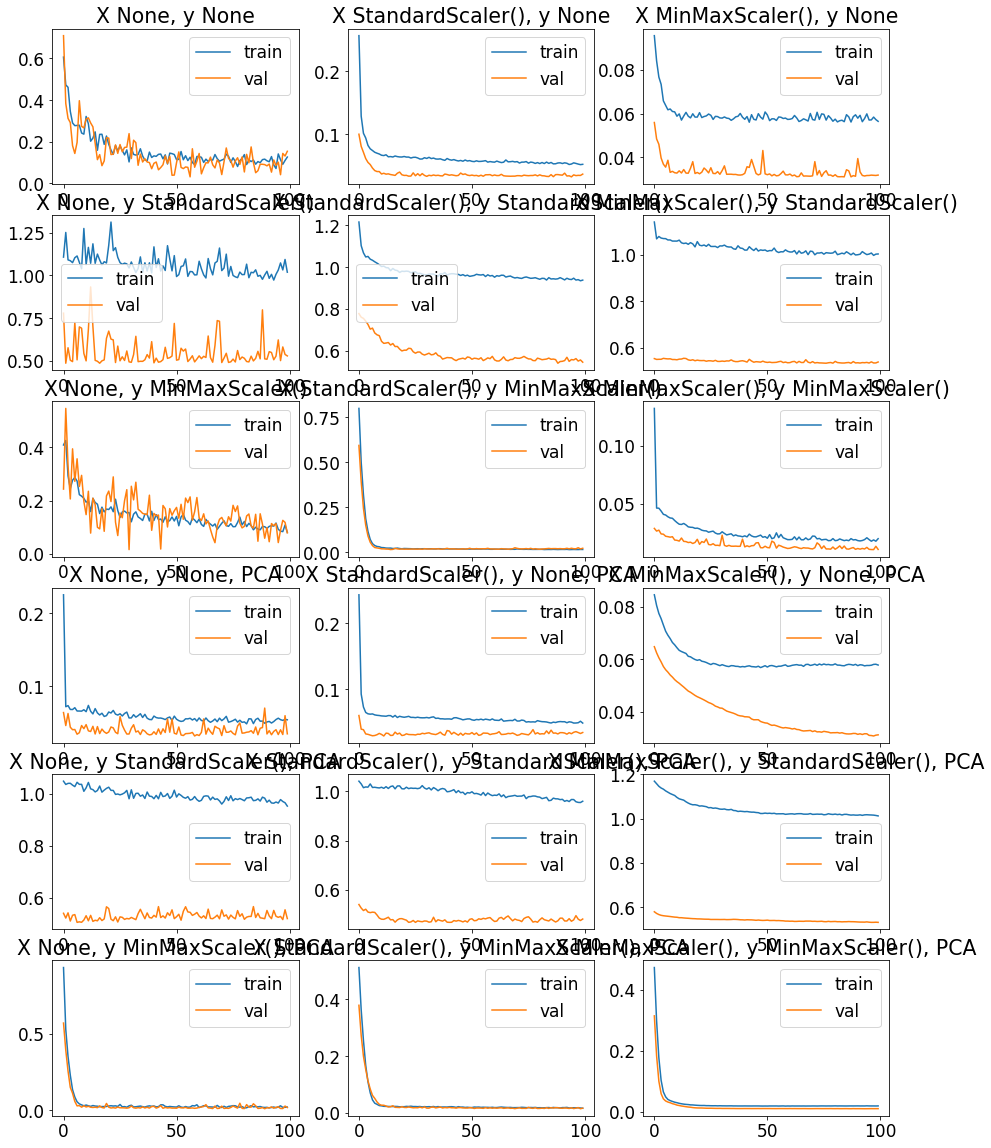

In [904]:
fig, axs = plt.subplots(6,3,figsize=(15,20))
scale=[None,StandardScaler(),MinMaxScaler()]

for i in range(3):
    
    for j in range(6):
        if (j < 3):
            X_train, y_train, X_test, y_test = generate_dataset(scale[i],scale[j],X)
            X_trainv, X_testv,y_trainv, y_testv = train_test_split(X_train,y_train,test_size=0.2,random_state=1)
            model=models.Sequential()
            model.add(layers.Dense(100,input_shape=(X_trainv.shape[1],),activation='tanh'))
            model.add(layers.Dense(1))#output layer
            opt=SGD(lr=0.01,momentum=0) #deixar default se tiver bom resultado
            model.compile(loss='mean_absolute_error',optimizer=opt,metrics='mean_squared_error')
            history=model.fit(X_trainv,y_trainv,validation_data=(X_testv,y_testv),epochs=100,batch_size=32,verbose=0)

            axs[j,i].plot(history.history['mean_squared_error'], label='train')
            axs[j,i].plot(history.history['val_mean_squared_error'], label='val')
            axs[j,i].legend()
            axs[j,i].set_title('X {}, y {}'.format(scale[i],scale[j]))
            
        if (j>=3):
            X_train, y_train, X_test, y_test = generate_dataset(scale[i],scale[j-3],X)
            X_trainv, X_testv,y_trainv, y_testv = train_test_split(X_train,y_train,test_size=0.2,random_state=1)
            pca=PCA(.95) #95% of variance explained
            pca.fit(X_trainv)
            X_trainv=pca.transform(X_trainv)
            X_testv=pca.transform(X_testv)
            
            model=models.Sequential()
            model.add(layers.Dense(100,input_shape=(X_trainv.shape[1],),activation='tanh'))
            model.add(layers.Dense(1))#output layer
            opt=SGD(lr=0.01,momentum=0) #deixar default se tiver bom resultado
            model.compile(loss='mean_absolute_error',optimizer=opt,metrics='mean_squared_error')
            history=model.fit(X_trainv,y_trainv,validation_data=(X_testv,y_testv),epochs=100,batch_size=32,verbose=0)

            axs[j,i].plot(history.history['mean_squared_error'], label='train')
            axs[j,i].plot(history.history['val_mean_squared_error'], label='val')
            axs[j,i].legend()
            axs[j,i].set_title('X {}, y {}, PCA'.format(scale[i],scale[j-3]))

            


In [270]:
print(pywt.families())
print(pywt.wavelist('db'))


['haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus', 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor']
['db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38']


In [363]:
#----------------wavelet--------------    
def waveTransform(data,waveletname = 'db4', level = pywt.dwt_max_level(len(data),waveletname)):
    coeffs=[]
    for i in range(data.shape[1]):
        signal = data[:,i]
        coeffs.append(pywt.wavedec(signal, waveletname ,level=level) )#coeffs=[cA_n, cD_n, cD_n-1, …, cD2, cD1] 
    return (coeffs,level)

In [364]:
a,la=waveTransform(X_trainS)

In [345]:
nrow = len(a) #each row represents a variable
ncol = len(a[0]) #each col represents a coef in the order [cA_n, cD_n, cD_n-1, …, cD2, cD1]
print(nrow,ncol) 

16 6


In [366]:
b,lb=waveTransform(y_trainS)
nrow = len(b) #each row represents a variable
ncol = len(b[0]) #each col represents a coef in the order [cA_n, cD_n, cD_n-1, …, cD2, cD1]
print(nrow,ncol) 

1 6


In [ ]:
#-------MLP-sgd---------------------
#testar numero de neurons 1 hidden layer
#activations=['tanh','relu','sigmoid'] vou usar relu e se nao der bons resultados uso tanh
#results=[None]*len(activations) 
#for j in range(0,len(activations)):

neurons=np.arange(2,505,5)
seeds=np.arange(1,101)
h=[]
for j in seeds:
    random.seed(j)
    for i in neurons:
        model=models.Sequential()
        model.add(layers.Dense(i,input_dim=input_dim,activation='relu'))
        model.add(layers.Dense(1))#output layer
        model.compile(loss='mean_squared_error',optimizer='sgd',metrics=['mean_squared_error'])
        monitor=EarlyStopping(monitor='val_loss',verbose=1)#with verbose=1 - print epoch where training stop
        history=model.fit(X_trainS,y_trainS,validation_split=0.3,callbacks=[monitor],epochs=1000,batch_size=32)
        h.append(history)

Epoch 1/1000
5/5 [==============================] - 0s 56ms/step - loss: 4.1242 - mean_squared_error: 4.1242 - val_loss: 1.0076 - val_mean_squared_error: 1.0076
Epoch 2/1000
5/5 [==============================] - 0s 5ms/step - loss: 2.3647 - mean_squared_error: 2.3647 - val_loss: 0.7511 - val_mean_squared_error: 0.7511
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.7914 - mean_squared_error: 1.7914 - val_loss: 0.6431 - val_mean_squared_error: 0.6431
Epoch 4/1000
5/5 [==============================] - 0s 14ms/step - loss: 1.5278 - mean_squared_error: 1.5278 - val_loss: 0.5922 - val_mean_squared_error: 0.5922
Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.3841 - mean_squared_error: 1.3841 - val_loss: 0.5672 - val_mean_squared_error: 0.5672
Epoch 6/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2997 - mean_squared_error: 1.2997 - val_loss: 0.5537 - val_mean_squared_error: 0.5537
Epoch 7/1000
5/5 [====================

Epoch 14/1000
5/5 [==============================] - 0s 13ms/step - loss: 1.0820 - mean_squared_error: 1.0820 - val_loss: 0.4224 - val_mean_squared_error: 0.4224
Epoch 15/1000
5/5 [==============================] - 0s 14ms/step - loss: 1.0686 - mean_squared_error: 1.0686 - val_loss: 0.4187 - val_mean_squared_error: 0.4187
Epoch 16/1000
5/5 [==============================] - 0s 13ms/step - loss: 1.0549 - mean_squared_error: 1.0549 - val_loss: 0.4141 - val_mean_squared_error: 0.4141
Epoch 17/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.0395 - mean_squared_error: 1.0395 - val_loss: 0.4104 - val_mean_squared_error: 0.4104
Epoch 18/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.0166 - mean_squared_error: 1.0166 - val_loss: 0.4051 - val_mean_squared_error: 0.4051
Epoch 19/1000
5/5 [==============================] - 0s 13ms/step - loss: 1.0001 - mean_squared_error: 1.0001 - val_loss: 0.4027 - val_mean_squared_error: 0.4027
Epoch 20/1000
5/5 [==========

5/5 [==============================] - 0s 5ms/step - loss: 1.1394 - mean_squared_error: 1.1394 - val_loss: 0.4385 - val_mean_squared_error: 0.4385
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0831 - mean_squared_error: 1.0831 - val_loss: 0.4275 - val_mean_squared_error: 0.4275
Epoch 5/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.0210 - mean_squared_error: 1.0210 - val_loss: 0.4187 - val_mean_squared_error: 0.4187
Epoch 6/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9664 - mean_squared_error: 0.9664 - val_loss: 0.4137 - val_mean_squared_error: 0.4137
Epoch 7/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9372 - mean_squared_error: 0.9372 - val_loss: 0.4089 - val_mean_squared_error: 0.4089
Epoch 8/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8966 - mean_squared_error: 0.8966 - val_loss: 0.4047 - val_mean_squared_error: 0.4047
Epoch 9/1000
5/5 [==============================] - 

Epoch 26/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.6334 - mean_squared_error: 0.6334 - val_loss: 0.3865 - val_mean_squared_error: 0.3865
Epoch 27/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.6227 - mean_squared_error: 0.6227 - val_loss: 0.3853 - val_mean_squared_error: 0.3853
Epoch 28/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.6220 - mean_squared_error: 0.6220 - val_loss: 0.3798 - val_mean_squared_error: 0.3798
Epoch 29/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.6140 - mean_squared_error: 0.6140 - val_loss: 0.3777 - val_mean_squared_error: 0.3777
Epoch 30/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.6030 - mean_squared_error: 0.6030 - val_loss: 0.3731 - val_mean_squared_error: 0.3731
Epoch 31/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.5977 - mean_squared_error: 0.5977 - val_loss: 0.3687 - val_mean_squared_error: 0.3687
Epoch 32/1000
5/5 [==============

5/5 [==============================] - 0s 5ms/step - loss: 1.0243 - mean_squared_error: 1.0243 - val_loss: 0.3980 - val_mean_squared_error: 0.3980
Epoch 00002: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 50ms/step - loss: 1.5583 - mean_squared_error: 1.5583 - val_loss: 0.5166 - val_mean_squared_error: 0.5166
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1921 - mean_squared_error: 1.1921 - val_loss: 0.4783 - val_mean_squared_error: 0.4783
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.0637 - mean_squared_error: 1.0637 - val_loss: 0.4595 - val_mean_squared_error: 0.4595
Epoch 4/1000
5/5 [==============================] - 0s 5ms/step - loss: 0.9753 - mean_squared_error: 0.9753 - val_loss: 0.4439 - val_mean_squared_error: 0.4439
Epoch 5/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.9163 - mean_squared_error: 0.9163 - val_loss: 0.4273 - val_mean_squared_error: 0.4273
Epoch 6/1000
5/5 [=====

5/5 [==============================] - 0s 6ms/step - loss: 0.8038 - mean_squared_error: 0.8038 - val_loss: 0.3806 - val_mean_squared_error: 0.3806
Epoch 15/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7934 - mean_squared_error: 0.7934 - val_loss: 0.3789 - val_mean_squared_error: 0.3789
Epoch 16/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.7723 - mean_squared_error: 0.7723 - val_loss: 0.3773 - val_mean_squared_error: 0.3773
Epoch 17/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7606 - mean_squared_error: 0.7606 - val_loss: 0.3757 - val_mean_squared_error: 0.3757
Epoch 18/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7544 - mean_squared_error: 0.7544 - val_loss: 0.3755 - val_mean_squared_error: 0.3755
Epoch 19/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7389 - mean_squared_error: 0.7389 - val_loss: 0.3721 - val_mean_squared_error: 0.3721
Epoch 20/1000
5/5 [=============================

5/5 [==============================] - 0s 8ms/step - loss: 0.7178 - mean_squared_error: 0.7178 - val_loss: 0.3439 - val_mean_squared_error: 0.3439
Epoch 14/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7146 - mean_squared_error: 0.7146 - val_loss: 0.3442 - val_mean_squared_error: 0.3442
Epoch 00014: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 42ms/step - loss: 1.4078 - mean_squared_error: 1.4078 - val_loss: 0.5561 - val_mean_squared_error: 0.5561
Epoch 2/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.1999 - mean_squared_error: 1.1999 - val_loss: 0.4358 - val_mean_squared_error: 0.4358
Epoch 3/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.0708 - mean_squared_error: 1.0708 - val_loss: 0.3639 - val_mean_squared_error: 0.3639
Epoch 4/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9929 - mean_squared_error: 0.9929 - val_loss: 0.3351 - val_mean_squared_error: 0.3351
Epoch 5/1000
5/5 [===

Epoch 00005: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 51ms/step - loss: 1.3024 - mean_squared_error: 1.3024 - val_loss: 0.3771 - val_mean_squared_error: 0.3771
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0372 - mean_squared_error: 1.0372 - val_loss: 0.3880 - val_mean_squared_error: 0.3880
Epoch 00002: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 52ms/step - loss: 1.2980 - mean_squared_error: 1.2980 - val_loss: 0.4015 - val_mean_squared_error: 0.4015
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1197 - mean_squared_error: 1.1197 - val_loss: 0.3709 - val_mean_squared_error: 0.3709
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.0321 - mean_squared_error: 1.0321 - val_loss: 0.3569 - val_mean_squared_error: 0.3569
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9799 - mean_squared_error: 0.9799 - val_loss: 0.3438 - val_mean_squ

5/5 [==============================] - 0s 51ms/step - loss: 1.2759 - mean_squared_error: 1.2759 - val_loss: 0.3402 - val_mean_squared_error: 0.3402
Epoch 2/1000
5/5 [==============================] - 0s 14ms/step - loss: 1.0981 - mean_squared_error: 1.0981 - val_loss: 0.3357 - val_mean_squared_error: 0.3357
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9884 - mean_squared_error: 0.9884 - val_loss: 0.3527 - val_mean_squared_error: 0.3527
Epoch 00003: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 50ms/step - loss: 1.4550 - mean_squared_error: 1.4550 - val_loss: 0.4607 - val_mean_squared_error: 0.4607
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2369 - mean_squared_error: 1.2369 - val_loss: 0.4071 - val_mean_squared_error: 0.4071
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.1224 - mean_squared_error: 1.1224 - val_loss: 0.3750 - val_mean_squared_error: 0.3750
Epoch 4/1000
5/5 [====

Epoch 00007: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 59ms/step - loss: 1.3637 - mean_squared_error: 1.3637 - val_loss: 0.4680 - val_mean_squared_error: 0.4680
Epoch 2/1000
5/5 [==============================] - 0s 5ms/step - loss: 1.1018 - mean_squared_error: 1.1018 - val_loss: 0.4531 - val_mean_squared_error: 0.4531
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9946 - mean_squared_error: 0.9946 - val_loss: 0.4331 - val_mean_squared_error: 0.4331
Epoch 4/1000
5/5 [==============================] - 0s 27ms/step - loss: 0.9354 - mean_squared_error: 0.9354 - val_loss: 0.4280 - val_mean_squared_error: 0.4280
Epoch 5/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.8895 - mean_squared_error: 0.8895 - val_loss: 0.4063 - val_mean_squared_error: 0.4063
Epoch 6/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.8549 - mean_squared_error: 0.8549 - val_loss: 0.4023 - val_mean_squared_error: 0.4023
Epoch 7/

5/5 [==============================] - 0s 6ms/step - loss: 0.7016 - mean_squared_error: 0.7016 - val_loss: 0.3425 - val_mean_squared_error: 0.3425
Epoch 13/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.6878 - mean_squared_error: 0.6878 - val_loss: 0.3396 - val_mean_squared_error: 0.3396
Epoch 14/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.6783 - mean_squared_error: 0.6783 - val_loss: 0.3391 - val_mean_squared_error: 0.3391
Epoch 15/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.6708 - mean_squared_error: 0.6708 - val_loss: 0.3360 - val_mean_squared_error: 0.3360
Epoch 16/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.6559 - mean_squared_error: 0.6559 - val_loss: 0.3340 - val_mean_squared_error: 0.3340
Epoch 17/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.6465 - mean_squared_error: 0.6465 - val_loss: 0.3340 - val_mean_squared_error: 0.3340
Epoch 00017: early stopping
Epoch 1/1000
5/5 [==

5/5 [==============================] - 0s 16ms/step - loss: 0.8987 - mean_squared_error: 0.8987 - val_loss: 0.3381 - val_mean_squared_error: 0.3381
Epoch 6/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.8555 - mean_squared_error: 0.8555 - val_loss: 0.3305 - val_mean_squared_error: 0.3305
Epoch 7/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.8228 - mean_squared_error: 0.8228 - val_loss: 0.3308 - val_mean_squared_error: 0.3308
Epoch 00007: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 55ms/step - loss: 1.2757 - mean_squared_error: 1.2757 - val_loss: 0.3997 - val_mean_squared_error: 0.3997
Epoch 2/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.1236 - mean_squared_error: 1.1236 - val_loss: 0.3853 - val_mean_squared_error: 0.3853
Epoch 3/1000
5/5 [==============================] - 0s 5ms/step - loss: 1.0349 - mean_squared_error: 1.0349 - val_loss: 0.3723 - val_mean_squared_error: 0.3723
Epoch 4/1000
5/5 [===

Epoch 6/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.8622 - mean_squared_error: 0.8622 - val_loss: 0.3400 - val_mean_squared_error: 0.3400
Epoch 7/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.8258 - mean_squared_error: 0.8258 - val_loss: 0.3366 - val_mean_squared_error: 0.3366
Epoch 8/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.8075 - mean_squared_error: 0.8075 - val_loss: 0.3327 - val_mean_squared_error: 0.3327
Epoch 9/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.7908 - mean_squared_error: 0.7908 - val_loss: 0.3341 - val_mean_squared_error: 0.3341
Epoch 00009: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 51ms/step - loss: 1.3263 - mean_squared_error: 1.3263 - val_loss: 0.3895 - val_mean_squared_error: 0.3895
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1041 - mean_squared_error: 1.1041 - val_loss: 0.3810 - val_mean_squared_error: 0.3810
Epoch 3

Epoch 5/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.8807 - mean_squared_error: 0.8807 - val_loss: 0.3293 - val_mean_squared_error: 0.3293
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8421 - mean_squared_error: 0.8421 - val_loss: 0.3251 - val_mean_squared_error: 0.3251
Epoch 7/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.8178 - mean_squared_error: 0.8178 - val_loss: 0.3300 - val_mean_squared_error: 0.3300
Epoch 00007: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 50ms/step - loss: 1.2727 - mean_squared_error: 1.2727 - val_loss: 0.3883 - val_mean_squared_error: 0.3883
Epoch 2/1000
5/5 [==============================] - 0s 5ms/step - loss: 1.1226 - mean_squared_error: 1.1226 - val_loss: 0.3405 - val_mean_squared_error: 0.3405
Epoch 3/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.0453 - mean_squared_error: 1.0453 - val_loss: 0.3236 - val_mean_squared_error: 0.3236
Epoch 4/

Epoch 19/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1745 - mean_squared_error: 1.1745 - val_loss: 0.7654 - val_mean_squared_error: 0.7654
Epoch 20/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.1695 - mean_squared_error: 1.1695 - val_loss: 0.7569 - val_mean_squared_error: 0.7569
Epoch 21/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.1627 - mean_squared_error: 1.1627 - val_loss: 0.7477 - val_mean_squared_error: 0.7477
Epoch 22/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.1569 - mean_squared_error: 1.1569 - val_loss: 0.7396 - val_mean_squared_error: 0.7396
Epoch 23/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.1524 - mean_squared_error: 1.1524 - val_loss: 0.7328 - val_mean_squared_error: 0.7328
Epoch 24/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.1495 - mean_squared_error: 1.1495 - val_loss: 0.7257 - val_mean_squared_error: 0.7257
Epoch 25/1000
5/5 [==========

5/5 [==============================] - 0s 6ms/step - loss: 0.8212 - mean_squared_error: 0.8212 - val_loss: 0.4855 - val_mean_squared_error: 0.4855
Epoch 12/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8034 - mean_squared_error: 0.8034 - val_loss: 0.4694 - val_mean_squared_error: 0.4694
Epoch 13/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7895 - mean_squared_error: 0.7895 - val_loss: 0.4561 - val_mean_squared_error: 0.4561
Epoch 14/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7697 - mean_squared_error: 0.7697 - val_loss: 0.4486 - val_mean_squared_error: 0.4486
Epoch 15/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7633 - mean_squared_error: 0.7633 - val_loss: 0.4482 - val_mean_squared_error: 0.4482
Epoch 16/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7431 - mean_squared_error: 0.7431 - val_loss: 0.4400 - val_mean_squared_error: 0.4400
Epoch 17/1000
5/5 [=============================

5/5 [==============================] - 0s 12ms/step - loss: 0.6707 - mean_squared_error: 0.6707 - val_loss: 0.5217 - val_mean_squared_error: 0.5217
Epoch 24/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.6585 - mean_squared_error: 0.6585 - val_loss: 0.5199 - val_mean_squared_error: 0.5199
Epoch 25/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.6547 - mean_squared_error: 0.6547 - val_loss: 0.5208 - val_mean_squared_error: 0.5208
Epoch 00025: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 50ms/step - loss: 1.5815 - mean_squared_error: 1.5815 - val_loss: 0.5990 - val_mean_squared_error: 0.5990
Epoch 2/1000
5/5 [==============================] - 0s 19ms/step - loss: 1.3960 - mean_squared_error: 1.3960 - val_loss: 0.5030 - val_mean_squared_error: 0.5030
Epoch 3/1000
5/5 [==============================] - 0s 25ms/step - loss: 1.2618 - mean_squared_error: 1.2618 - val_loss: 0.4576 - val_mean_squared_error: 0.4576
Epoch 4/1000
5/5 

Epoch 7/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.9029 - mean_squared_error: 0.9029 - val_loss: 0.3896 - val_mean_squared_error: 0.3896
Epoch 8/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8610 - mean_squared_error: 0.8610 - val_loss: 0.3852 - val_mean_squared_error: 0.3852
Epoch 9/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8395 - mean_squared_error: 0.8395 - val_loss: 0.3831 - val_mean_squared_error: 0.3831
Epoch 10/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8118 - mean_squared_error: 0.8118 - val_loss: 0.3816 - val_mean_squared_error: 0.3816
Epoch 11/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7974 - mean_squared_error: 0.7974 - val_loss: 0.3805 - val_mean_squared_error: 0.3805
Epoch 12/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7707 - mean_squared_error: 0.7707 - val_loss: 0.3806 - val_mean_squared_error: 0.3806
Epoch 00012: early stopping
Epoch 1/

Epoch 2/1000
5/5 [==============================] - 0s 5ms/step - loss: 1.2480 - mean_squared_error: 1.2480 - val_loss: 0.5806 - val_mean_squared_error: 0.5806
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.1199 - mean_squared_error: 1.1199 - val_loss: 0.5107 - val_mean_squared_error: 0.5107
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0167 - mean_squared_error: 1.0167 - val_loss: 0.4407 - val_mean_squared_error: 0.4407
Epoch 5/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.9517 - mean_squared_error: 0.9517 - val_loss: 0.4153 - val_mean_squared_error: 0.4153
Epoch 6/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9135 - mean_squared_error: 0.9135 - val_loss: 0.3951 - val_mean_squared_error: 0.3951
Epoch 7/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8777 - mean_squared_error: 0.8777 - val_loss: 0.3872 - val_mean_squared_error: 0.3872
Epoch 8/1000
5/5 [====================

Epoch 1/1000
5/5 [==============================] - 0s 50ms/step - loss: 1.5434 - mean_squared_error: 1.5434 - val_loss: 0.3948 - val_mean_squared_error: 0.3948
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1404 - mean_squared_error: 1.1404 - val_loss: 0.3778 - val_mean_squared_error: 0.3778
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0072 - mean_squared_error: 1.0072 - val_loss: 0.3556 - val_mean_squared_error: 0.3556
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9556 - mean_squared_error: 0.9556 - val_loss: 0.3480 - val_mean_squared_error: 0.3480
Epoch 5/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9010 - mean_squared_error: 0.9010 - val_loss: 0.3424 - val_mean_squared_error: 0.3424
Epoch 6/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.8658 - mean_squared_error: 0.8658 - val_loss: 0.3399 - val_mean_squared_error: 0.3399
Epoch 7/1000
5/5 [==================

5/5 [==============================] - 0s 11ms/step - loss: 0.8093 - mean_squared_error: 0.8093 - val_loss: 0.3759 - val_mean_squared_error: 0.3759
Epoch 11/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.7895 - mean_squared_error: 0.7895 - val_loss: 0.3721 - val_mean_squared_error: 0.3721
Epoch 12/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.7650 - mean_squared_error: 0.7650 - val_loss: 0.3683 - val_mean_squared_error: 0.3683
Epoch 13/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7792 - mean_squared_error: 0.7792 - val_loss: 0.3651 - val_mean_squared_error: 0.3651
Epoch 14/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7424 - mean_squared_error: 0.7424 - val_loss: 0.3629 - val_mean_squared_error: 0.3629
Epoch 15/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7262 - mean_squared_error: 0.7262 - val_loss: 0.3599 - val_mean_squared_error: 0.3599
Epoch 16/1000
5/5 [========================

Epoch 5/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.9064 - mean_squared_error: 0.9064 - val_loss: 0.3701 - val_mean_squared_error: 0.3701
Epoch 6/1000
5/5 [==============================] - 0s 5ms/step - loss: 0.8686 - mean_squared_error: 0.8686 - val_loss: 0.3676 - val_mean_squared_error: 0.3676
Epoch 7/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.8492 - mean_squared_error: 0.8492 - val_loss: 0.3603 - val_mean_squared_error: 0.3603
Epoch 8/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8140 - mean_squared_error: 0.8140 - val_loss: 0.3606 - val_mean_squared_error: 0.3606
Epoch 00008: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 38ms/step - loss: 1.4193 - mean_squared_error: 1.4193 - val_loss: 0.3863 - val_mean_squared_error: 0.3863
Epoch 2/1000
5/5 [==============================] - 0s 14ms/step - loss: 1.1260 - mean_squared_error: 1.1260 - val_loss: 0.3505 - val_mean_squared_error: 0.3505
Epoch 3/

Epoch 1/1000
5/5 [==============================] - 0s 35ms/step - loss: 1.2290 - mean_squared_error: 1.2290 - val_loss: 0.3492 - val_mean_squared_error: 0.3492
Epoch 2/1000
5/5 [==============================] - 0s 7ms/step - loss: 1.0857 - mean_squared_error: 1.0857 - val_loss: 0.3492 - val_mean_squared_error: 0.3492
Epoch 3/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.9971 - mean_squared_error: 0.9971 - val_loss: 0.3409 - val_mean_squared_error: 0.3409
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9554 - mean_squared_error: 0.9554 - val_loss: 0.3335 - val_mean_squared_error: 0.3335
Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9145 - mean_squared_error: 0.9145 - val_loss: 0.3204 - val_mean_squared_error: 0.3204
Epoch 6/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8748 - mean_squared_error: 0.8748 - val_loss: 0.3206 - val_mean_squared_error: 0.3206
Epoch 00006: early stopping
Epoch 1/10

Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8729 - mean_squared_error: 0.8729 - val_loss: 0.3203 - val_mean_squared_error: 0.3203
Epoch 6/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8557 - mean_squared_error: 0.8557 - val_loss: 0.3222 - val_mean_squared_error: 0.3222
Epoch 00006: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 49ms/step - loss: 1.3588 - mean_squared_error: 1.3588 - val_loss: 0.2914 - val_mean_squared_error: 0.2914
Epoch 2/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0761 - mean_squared_error: 1.0761 - val_loss: 0.2923 - val_mean_squared_error: 0.2923
Epoch 00002: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 55ms/step - loss: 1.3251 - mean_squared_error: 1.3251 - val_loss: 0.4348 - val_mean_squared_error: 0.4348
Epoch 2/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.1157 - mean_squared_error: 1.1157 - val_loss: 0.4176 - val_mean_squ

Epoch 6/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.8588 - mean_squared_error: 0.8588 - val_loss: 0.3296 - val_mean_squared_error: 0.3296
Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8171 - mean_squared_error: 0.8171 - val_loss: 0.3285 - val_mean_squared_error: 0.3285
Epoch 8/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.8045 - mean_squared_error: 0.8045 - val_loss: 0.3301 - val_mean_squared_error: 0.3301
Epoch 00008: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 44ms/step - loss: 1.5133 - mean_squared_error: 1.5133 - val_loss: 0.3358 - val_mean_squared_error: 0.3358
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1288 - mean_squared_error: 1.1288 - val_loss: 0.3556 - val_mean_squared_error: 0.3556
Epoch 00002: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 55ms/step - loss: 1.2204 - mean_squared_error: 1.2204 - val_loss: 0.4572 - val_mean_squ

Epoch 7/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.8093 - mean_squared_error: 0.8093 - val_loss: 0.2996 - val_mean_squared_error: 0.2996
Epoch 00007: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 50ms/step - loss: 1.1750 - mean_squared_error: 1.1750 - val_loss: 0.3387 - val_mean_squared_error: 0.3387
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0321 - mean_squared_error: 1.0321 - val_loss: 0.3364 - val_mean_squared_error: 0.3364
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9549 - mean_squared_error: 0.9549 - val_loss: 0.3334 - val_mean_squared_error: 0.3334
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9118 - mean_squared_error: 0.9118 - val_loss: 0.3249 - val_mean_squared_error: 0.3249
Epoch 5/1000
5/5 [==============================] - 0s 27ms/step - loss: 0.8642 - mean_squared_error: 0.8642 - val_loss: 0.3216 - val_mean_squared_error: 0.3216
Epoch 6/1

5/5 [==============================] - 0s 10ms/step - loss: 0.7920 - mean_squared_error: 0.7920 - val_loss: 0.3718 - val_mean_squared_error: 0.3718
Epoch 22/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7847 - mean_squared_error: 0.7847 - val_loss: 0.3689 - val_mean_squared_error: 0.3689
Epoch 23/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7787 - mean_squared_error: 0.7787 - val_loss: 0.3686 - val_mean_squared_error: 0.3686
Epoch 24/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7689 - mean_squared_error: 0.7689 - val_loss: 0.3688 - val_mean_squared_error: 0.3688
Epoch 00024: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 29ms/step - loss: 1.5708 - mean_squared_error: 1.5708 - val_loss: 0.6182 - val_mean_squared_error: 0.6182
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2641 - mean_squared_error: 1.2641 - val_loss: 0.6330 - val_mean_squared_error: 0.6330
Epoch 00002: earl

5/5 [==============================] - 0s 6ms/step - loss: 1.5569 - mean_squared_error: 1.5569 - val_loss: 0.3827 - val_mean_squared_error: 0.3827
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.2225 - mean_squared_error: 1.2225 - val_loss: 0.3445 - val_mean_squared_error: 0.3445
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0817 - mean_squared_error: 1.0817 - val_loss: 0.3324 - val_mean_squared_error: 0.3324
Epoch 5/1000
5/5 [==============================] - 0s 13ms/step - loss: 1.0045 - mean_squared_error: 1.0045 - val_loss: 0.3279 - val_mean_squared_error: 0.3279
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9574 - mean_squared_error: 0.9574 - val_loss: 0.3268 - val_mean_squared_error: 0.3268
Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9333 - mean_squared_error: 0.9333 - val_loss: 0.3287 - val_mean_squared_error: 0.3287
Epoch 00007: early stopping
Epoch 1/1000
5/5 [==

Epoch 00002: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 35ms/step - loss: 1.2272 - mean_squared_error: 1.2272 - val_loss: 0.4929 - val_mean_squared_error: 0.4929
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0762 - mean_squared_error: 1.0762 - val_loss: 0.4665 - val_mean_squared_error: 0.4665
Epoch 3/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.9914 - mean_squared_error: 0.9914 - val_loss: 0.4519 - val_mean_squared_error: 0.4519
Epoch 4/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.9347 - mean_squared_error: 0.9347 - val_loss: 0.4380 - val_mean_squared_error: 0.4380
Epoch 5/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8932 - mean_squared_error: 0.8932 - val_loss: 0.4356 - val_mean_squared_error: 0.4356
Epoch 6/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.8763 - mean_squared_error: 0.8763 - val_loss: 0.4266 - val_mean_squared_error: 0.4266
Epoch 7/10

Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9993 - mean_squared_error: 0.9993 - val_loss: 0.4061 - val_mean_squared_error: 0.4061
Epoch 5/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9571 - mean_squared_error: 0.9571 - val_loss: 0.4053 - val_mean_squared_error: 0.4053
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9199 - mean_squared_error: 0.9199 - val_loss: 0.3905 - val_mean_squared_error: 0.3905
Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8977 - mean_squared_error: 0.8977 - val_loss: 0.3907 - val_mean_squared_error: 0.3907
Epoch 00007: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 46ms/step - loss: 1.2189 - mean_squared_error: 1.2189 - val_loss: 0.4035 - val_mean_squared_error: 0.4035
Epoch 2/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.0804 - mean_squared_error: 1.0804 - val_loss: 0.3318 - val_mean_squared_error: 0.3318
Epoch 

Epoch 8/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8056 - mean_squared_error: 0.8056 - val_loss: 0.3579 - val_mean_squared_error: 0.3579
Epoch 9/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7857 - mean_squared_error: 0.7857 - val_loss: 0.3597 - val_mean_squared_error: 0.3597
Epoch 00009: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 30ms/step - loss: 1.7073 - mean_squared_error: 1.7073 - val_loss: 0.3260 - val_mean_squared_error: 0.3260
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1428 - mean_squared_error: 1.1428 - val_loss: 0.3091 - val_mean_squared_error: 0.3091
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9773 - mean_squared_error: 0.9773 - val_loss: 0.3045 - val_mean_squared_error: 0.3045
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9056 - mean_squared_error: 0.9056 - val_loss: 0.3042 - val_mean_squared_error: 0.3042
Epoch 5/100

5/5 [==============================] - 0s 13ms/step - loss: 0.8235 - mean_squared_error: 0.8235 - val_loss: 0.3513 - val_mean_squared_error: 0.3513
Epoch 00008: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 46ms/step - loss: 1.2126 - mean_squared_error: 1.2126 - val_loss: 0.3688 - val_mean_squared_error: 0.3688
Epoch 2/1000
5/5 [==============================] - 0s 19ms/step - loss: 1.0764 - mean_squared_error: 1.0764 - val_loss: 0.3628 - val_mean_squared_error: 0.3628
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9913 - mean_squared_error: 0.9913 - val_loss: 0.3597 - val_mean_squared_error: 0.3597
Epoch 4/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.9534 - mean_squared_error: 0.9534 - val_loss: 0.3621 - val_mean_squared_error: 0.3621
Epoch 00004: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 51ms/step - loss: 1.3354 - mean_squared_error: 1.3354 - val_loss: 0.5205 - val_mean_squared_error:

Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8755 - mean_squared_error: 0.8755 - val_loss: 0.3059 - val_mean_squared_error: 0.3059
Epoch 00004: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 44ms/step - loss: 1.4320 - mean_squared_error: 1.4320 - val_loss: 0.5795 - val_mean_squared_error: 0.5795
Epoch 2/1000
5/5 [==============================] - 0s 7ms/step - loss: 1.1963 - mean_squared_error: 1.1963 - val_loss: 0.5206 - val_mean_squared_error: 0.5206
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0827 - mean_squared_error: 1.0827 - val_loss: 0.4613 - val_mean_squared_error: 0.4613
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0065 - mean_squared_error: 1.0065 - val_loss: 0.4151 - val_mean_squared_error: 0.4151
Epoch 5/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9474 - mean_squared_error: 0.9474 - val_loss: 0.3816 - val_mean_squared_error: 0.3816
Epoch 6

Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9993 - mean_squared_error: 0.9993 - val_loss: 0.4049 - val_mean_squared_error: 0.4049
Epoch 4/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9325 - mean_squared_error: 0.9325 - val_loss: 0.3955 - val_mean_squared_error: 0.3955
Epoch 5/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8838 - mean_squared_error: 0.8838 - val_loss: 0.3902 - val_mean_squared_error: 0.3902
Epoch 6/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8602 - mean_squared_error: 0.8602 - val_loss: 0.3913 - val_mean_squared_error: 0.3913
Epoch 00006: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 56ms/step - loss: 1.3168 - mean_squared_error: 1.3168 - val_loss: 0.4878 - val_mean_squared_error: 0.4878
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0767 - mean_squared_error: 1.0767 - val_loss: 0.4298 - val_mean_squared_error: 0.4298
Epoch 3/

Epoch 9/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.8034 - mean_squared_error: 0.8034 - val_loss: 0.3802 - val_mean_squared_error: 0.3802
Epoch 00009: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 60ms/step - loss: 1.2557 - mean_squared_error: 1.2557 - val_loss: 0.3431 - val_mean_squared_error: 0.3431
Epoch 2/1000
5/5 [==============================] - 0s 14ms/step - loss: 1.0941 - mean_squared_error: 1.0941 - val_loss: 0.3249 - val_mean_squared_error: 0.3249
Epoch 3/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.9997 - mean_squared_error: 0.9997 - val_loss: 0.2975 - val_mean_squared_error: 0.2975
Epoch 4/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.9271 - mean_squared_error: 0.9271 - val_loss: 0.3029 - val_mean_squared_error: 0.3029
Epoch 00004: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 57ms/step - loss: 1.2252 - mean_squared_error: 1.2252 - val_loss: 0.4107 - val_mean_

5/5 [==============================] - 0s 11ms/step - loss: 0.9635 - mean_squared_error: 0.9635 - val_loss: 0.3533 - val_mean_squared_error: 0.3533
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9126 - mean_squared_error: 0.9126 - val_loss: 0.3505 - val_mean_squared_error: 0.3505
Epoch 7/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.8727 - mean_squared_error: 0.8727 - val_loss: 0.3524 - val_mean_squared_error: 0.3524
Epoch 00007: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 56ms/step - loss: 1.4815 - mean_squared_error: 1.4815 - val_loss: 0.4851 - val_mean_squared_error: 0.4851
Epoch 2/1000
5/5 [==============================] - 0s 5ms/step - loss: 1.2412 - mean_squared_error: 1.2412 - val_loss: 0.4143 - val_mean_squared_error: 0.4143
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.1041 - mean_squared_error: 1.1041 - val_loss: 0.3781 - val_mean_squared_error: 0.3781
Epoch 4/1000
5/5 [===

Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9310 - mean_squared_error: 0.9310 - val_loss: 0.3684 - val_mean_squared_error: 0.3684
Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9007 - mean_squared_error: 0.9007 - val_loss: 0.3658 - val_mean_squared_error: 0.3658
Epoch 6/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.8644 - mean_squared_error: 0.8644 - val_loss: 0.3584 - val_mean_squared_error: 0.3584
Epoch 7/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8362 - mean_squared_error: 0.8362 - val_loss: 0.3611 - val_mean_squared_error: 0.3611
Epoch 00007: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 42ms/step - loss: 1.4457 - mean_squared_error: 1.4457 - val_loss: 0.3815 - val_mean_squared_error: 0.3815
Epoch 2/1000
5/5 [==============================] - 0s 7ms/step - loss: 1.1371 - mean_squared_error: 1.1371 - val_loss: 0.3775 - val_mean_squared_error: 0.3775
Epoch 3/10

Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9666 - mean_squared_error: 0.9666 - val_loss: 0.3363 - val_mean_squared_error: 0.3363
Epoch 5/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9204 - mean_squared_error: 0.9204 - val_loss: 0.3260 - val_mean_squared_error: 0.3260
Epoch 6/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.8805 - mean_squared_error: 0.8805 - val_loss: 0.3223 - val_mean_squared_error: 0.3223
Epoch 7/1000
5/5 [==============================] - 0s 23ms/step - loss: 0.8449 - mean_squared_error: 0.8449 - val_loss: 0.3187 - val_mean_squared_error: 0.3187
Epoch 8/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.8210 - mean_squared_error: 0.8210 - val_loss: 0.3206 - val_mean_squared_error: 0.3206
Epoch 00008: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 47ms/step - loss: 1.2981 - mean_squared_error: 1.2981 - val_loss: 0.4113 - val_mean_squared_error: 0.4113
Epoch 2/1

Epoch 00005: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 49ms/step - loss: 1.1885 - mean_squared_error: 1.1885 - val_loss: 0.3846 - val_mean_squared_error: 0.3846
Epoch 2/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.0818 - mean_squared_error: 1.0818 - val_loss: 0.3669 - val_mean_squared_error: 0.3669
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9902 - mean_squared_error: 0.9902 - val_loss: 0.3456 - val_mean_squared_error: 0.3456
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9375 - mean_squared_error: 0.9375 - val_loss: 0.3386 - val_mean_squared_error: 0.3386
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8938 - mean_squared_error: 0.8938 - val_loss: 0.3356 - val_mean_squared_error: 0.3356
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8548 - mean_squared_error: 0.8548 - val_loss: 0.3373 - val_mean_squared_error: 0.3373
Epoch 0

5/5 [==============================] - 0s 22ms/step - loss: 0.7575 - mean_squared_error: 0.7575 - val_loss: 0.3493 - val_mean_squared_error: 0.3493
Epoch 48/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.7558 - mean_squared_error: 0.7558 - val_loss: 0.3479 - val_mean_squared_error: 0.3479
Epoch 49/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7518 - mean_squared_error: 0.7518 - val_loss: 0.3473 - val_mean_squared_error: 0.3473
Epoch 50/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.7504 - mean_squared_error: 0.7504 - val_loss: 0.3455 - val_mean_squared_error: 0.3455
Epoch 51/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7415 - mean_squared_error: 0.7415 - val_loss: 0.3439 - val_mean_squared_error: 0.3439
Epoch 52/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7435 - mean_squared_error: 0.7435 - val_loss: 0.3428 - val_mean_squared_error: 0.3428
Epoch 53/1000
5/5 [=======================

5/5 [==============================] - 0s 48ms/step - loss: 1.5517 - mean_squared_error: 1.5517 - val_loss: 0.3910 - val_mean_squared_error: 0.3910
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.3213 - mean_squared_error: 1.3213 - val_loss: 0.3907 - val_mean_squared_error: 0.3907
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.1632 - mean_squared_error: 1.1632 - val_loss: 0.3937 - val_mean_squared_error: 0.3937
Epoch 00003: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 49ms/step - loss: 1.5896 - mean_squared_error: 1.5896 - val_loss: 0.4371 - val_mean_squared_error: 0.4371
Epoch 2/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.2832 - mean_squared_error: 1.2832 - val_loss: 0.4465 - val_mean_squared_error: 0.4465
Epoch 00002: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 46ms/step - loss: 1.0975 - mean_squared_error: 1.0975 - val_loss: 0.4366 - val_mean_squared_error: 

Epoch 1/1000
5/5 [==============================] - 0s 43ms/step - loss: 1.1131 - mean_squared_error: 1.1131 - val_loss: 0.4871 - val_mean_squared_error: 0.4871
Epoch 2/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.0310 - mean_squared_error: 1.0310 - val_loss: 0.4487 - val_mean_squared_error: 0.4487
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9688 - mean_squared_error: 0.9688 - val_loss: 0.4285 - val_mean_squared_error: 0.4285
Epoch 4/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.9281 - mean_squared_error: 0.9281 - val_loss: 0.4172 - val_mean_squared_error: 0.4172
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9013 - mean_squared_error: 0.9013 - val_loss: 0.4079 - val_mean_squared_error: 0.4079
Epoch 6/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8694 - mean_squared_error: 0.8694 - val_loss: 0.4031 - val_mean_squared_error: 0.4031
Epoch 7/1000
5/5 [==================

5/5 [==============================] - 0s 10ms/step - loss: 0.8299 - mean_squared_error: 0.8299 - val_loss: 0.3545 - val_mean_squared_error: 0.3545
Epoch 00010: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 47ms/step - loss: 1.4955 - mean_squared_error: 1.4955 - val_loss: 0.5970 - val_mean_squared_error: 0.5970
Epoch 2/1000
5/5 [==============================] - 0s 7ms/step - loss: 1.2342 - mean_squared_error: 1.2342 - val_loss: 0.5268 - val_mean_squared_error: 0.5268
Epoch 3/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.1004 - mean_squared_error: 1.1004 - val_loss: 0.4560 - val_mean_squared_error: 0.4560
Epoch 4/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.0123 - mean_squared_error: 1.0123 - val_loss: 0.4284 - val_mean_squared_error: 0.4284
Epoch 5/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.9429 - mean_squared_error: 0.9429 - val_loss: 0.3892 - val_mean_squared_error: 0.3892
Epoch 6/1000
5/5 [==

Epoch 3/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.9999 - mean_squared_error: 0.9999 - val_loss: 0.3467 - val_mean_squared_error: 0.3467
Epoch 4/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.9416 - mean_squared_error: 0.9416 - val_loss: 0.3324 - val_mean_squared_error: 0.3324
Epoch 5/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.8862 - mean_squared_error: 0.8862 - val_loss: 0.3235 - val_mean_squared_error: 0.3235
Epoch 6/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.8592 - mean_squared_error: 0.8592 - val_loss: 0.3231 - val_mean_squared_error: 0.3231
Epoch 7/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.8259 - mean_squared_error: 0.8259 - val_loss: 0.3233 - val_mean_squared_error: 0.3233
Epoch 00007: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 54ms/step - loss: 1.0877 - mean_squared_error: 1.0877 - val_loss: 0.4026 - val_mean_squared_error: 0.4026
Epoch 

Epoch 5/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.8771 - mean_squared_error: 0.8771 - val_loss: 0.3673 - val_mean_squared_error: 0.3673
Epoch 6/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.8491 - mean_squared_error: 0.8491 - val_loss: 0.3659 - val_mean_squared_error: 0.3659
Epoch 7/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8175 - mean_squared_error: 0.8175 - val_loss: 0.3648 - val_mean_squared_error: 0.3648
Epoch 8/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.7928 - mean_squared_error: 0.7928 - val_loss: 0.3659 - val_mean_squared_error: 0.3659
Epoch 00008: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 44ms/step - loss: 1.5998 - mean_squared_error: 1.5998 - val_loss: 0.4172 - val_mean_squared_error: 0.4172
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2064 - mean_squared_error: 1.2064 - val_loss: 0.3932 - val_mean_squared_error: 0.3932
Epoch 3/1

Epoch 8/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7935 - mean_squared_error: 0.7935 - val_loss: 0.3441 - val_mean_squared_error: 0.3441
Epoch 9/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.7736 - mean_squared_error: 0.7736 - val_loss: 0.3439 - val_mean_squared_error: 0.3439
Epoch 10/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.7579 - mean_squared_error: 0.7579 - val_loss: 0.3391 - val_mean_squared_error: 0.3391
Epoch 11/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.7385 - mean_squared_error: 0.7385 - val_loss: 0.3372 - val_mean_squared_error: 0.3372
Epoch 12/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.7198 - mean_squared_error: 0.7198 - val_loss: 0.3379 - val_mean_squared_error: 0.3379
Epoch 00012: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 46ms/step - loss: 1.1322 - mean_squared_error: 1.1322 - val_loss: 0.3817 - val_mean_squared_error: 0.3817
Epoch 

Epoch 6/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.8522 - mean_squared_error: 0.8522 - val_loss: 0.3278 - val_mean_squared_error: 0.3278
Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8206 - mean_squared_error: 0.8206 - val_loss: 0.3256 - val_mean_squared_error: 0.3256
Epoch 8/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.7979 - mean_squared_error: 0.7979 - val_loss: 0.3232 - val_mean_squared_error: 0.3232
Epoch 9/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7758 - mean_squared_error: 0.7758 - val_loss: 0.3247 - val_mean_squared_error: 0.3247
Epoch 00009: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 51ms/step - loss: 1.3054 - mean_squared_error: 1.3054 - val_loss: 0.3793 - val_mean_squared_error: 0.3793
Epoch 2/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.0625 - mean_squared_error: 1.0625 - val_loss: 0.3791 - val_mean_squared_error: 0.3791
Epoch 3

Epoch 00005: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 43ms/step - loss: 1.2293 - mean_squared_error: 1.2293 - val_loss: 0.3465 - val_mean_squared_error: 0.3465
Epoch 2/1000
5/5 [==============================] - 0s 5ms/step - loss: 1.0901 - mean_squared_error: 1.0901 - val_loss: 0.3370 - val_mean_squared_error: 0.3370
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9921 - mean_squared_error: 0.9921 - val_loss: 0.3282 - val_mean_squared_error: 0.3282
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9453 - mean_squared_error: 0.9453 - val_loss: 0.3198 - val_mean_squared_error: 0.3198
Epoch 5/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.8907 - mean_squared_error: 0.8907 - val_loss: 0.3208 - val_mean_squared_error: 0.3208
Epoch 00005: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 48ms/step - loss: 1.2972 - mean_squared_error: 1.2972 - val_loss: 0.3099 - val_mean_sq

Epoch 00009: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 52ms/step - loss: 1.3413 - mean_squared_error: 1.3413 - val_loss: 0.3762 - val_mean_squared_error: 0.3762
Epoch 2/1000
5/5 [==============================] - 0s 13ms/step - loss: 1.1146 - mean_squared_error: 1.1146 - val_loss: 0.3730 - val_mean_squared_error: 0.3730
Epoch 3/1000
5/5 [==============================] - 0s 7ms/step - loss: 1.0162 - mean_squared_error: 1.0162 - val_loss: 0.3770 - val_mean_squared_error: 0.3770
Epoch 00003: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 47ms/step - loss: 1.3255 - mean_squared_error: 1.3255 - val_loss: 0.4459 - val_mean_squared_error: 0.4459
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1086 - mean_squared_error: 1.1086 - val_loss: 0.4144 - val_mean_squared_error: 0.4144
Epoch 3/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.9993 - mean_squared_error: 0.9993 - val_loss: 0.3844 - val_mean_squ

Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9184 - mean_squared_error: 0.9184 - val_loss: 0.3055 - val_mean_squared_error: 0.3055
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8686 - mean_squared_error: 0.8686 - val_loss: 0.3031 - val_mean_squared_error: 0.3031
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8372 - mean_squared_error: 0.8372 - val_loss: 0.2982 - val_mean_squared_error: 0.2982
Epoch 7/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.8131 - mean_squared_error: 0.8131 - val_loss: 0.3003 - val_mean_squared_error: 0.3003
Epoch 00007: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 54ms/step - loss: 1.2045 - mean_squared_error: 1.2045 - val_loss: 0.4090 - val_mean_squared_error: 0.4090
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0467 - mean_squared_error: 1.0467 - val_loss: 0.3683 - val_mean_squared_error: 0.3683
Epoch 3

Epoch 6/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.3108 - mean_squared_error: 1.3108 - val_loss: 1.0354 - val_mean_squared_error: 1.0354
Epoch 7/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2660 - mean_squared_error: 1.2660 - val_loss: 0.9414 - val_mean_squared_error: 0.9414
Epoch 8/1000
5/5 [==============================] - 0s 5ms/step - loss: 1.2408 - mean_squared_error: 1.2408 - val_loss: 0.8781 - val_mean_squared_error: 0.8781
Epoch 9/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.2205 - mean_squared_error: 1.2205 - val_loss: 0.8224 - val_mean_squared_error: 0.8224
Epoch 10/1000
5/5 [==============================] - 0s 5ms/step - loss: 1.2074 - mean_squared_error: 1.2074 - val_loss: 0.7787 - val_mean_squared_error: 0.7787
Epoch 11/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1958 - mean_squared_error: 1.1958 - val_loss: 0.7488 - val_mean_squared_error: 0.7488
Epoch 12/1000
5/5 [===================

Epoch 15/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8740 - mean_squared_error: 0.8740 - val_loss: 0.5294 - val_mean_squared_error: 0.5294
Epoch 16/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.8650 - mean_squared_error: 0.8650 - val_loss: 0.5233 - val_mean_squared_error: 0.5233
Epoch 17/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.8558 - mean_squared_error: 0.8558 - val_loss: 0.5181 - val_mean_squared_error: 0.5181
Epoch 18/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.8503 - mean_squared_error: 0.8503 - val_loss: 0.5142 - val_mean_squared_error: 0.5142
Epoch 19/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.8438 - mean_squared_error: 0.8438 - val_loss: 0.5092 - val_mean_squared_error: 0.5092
Epoch 20/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8360 - mean_squared_error: 0.8360 - val_loss: 0.5058 - val_mean_squared_error: 0.5058
Epoch 21/1000
5/5 [============

5/5 [==============================] - 0s 17ms/step - loss: 0.9811 - mean_squared_error: 0.9811 - val_loss: 0.4621 - val_mean_squared_error: 0.4621
Epoch 13/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.9624 - mean_squared_error: 0.9624 - val_loss: 0.4626 - val_mean_squared_error: 0.4626
Epoch 00013: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 43ms/step - loss: 1.5001 - mean_squared_error: 1.5001 - val_loss: 0.5540 - val_mean_squared_error: 0.5540
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.3192 - mean_squared_error: 1.3192 - val_loss: 0.5424 - val_mean_squared_error: 0.5424
Epoch 3/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.2090 - mean_squared_error: 1.2090 - val_loss: 0.5312 - val_mean_squared_error: 0.5312
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1472 - mean_squared_error: 1.1472 - val_loss: 0.5257 - val_mean_squared_error: 0.5257
Epoch 5/1000
5/5 [===

5/5 [==============================] - 0s 6ms/step - loss: 1.0338 - mean_squared_error: 1.0338 - val_loss: 0.4653 - val_mean_squared_error: 0.4653
Epoch 8/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9906 - mean_squared_error: 0.9906 - val_loss: 0.4416 - val_mean_squared_error: 0.4416
Epoch 9/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9400 - mean_squared_error: 0.9400 - val_loss: 0.4264 - val_mean_squared_error: 0.4264
Epoch 10/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9059 - mean_squared_error: 0.9059 - val_loss: 0.4135 - val_mean_squared_error: 0.4135
Epoch 11/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8826 - mean_squared_error: 0.8826 - val_loss: 0.4096 - val_mean_squared_error: 0.4096
Epoch 12/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.8568 - mean_squared_error: 0.8568 - val_loss: 0.4055 - val_mean_squared_error: 0.4055
Epoch 13/1000
5/5 [==============================]

5/5 [==============================] - 0s 12ms/step - loss: 1.0734 - mean_squared_error: 1.0734 - val_loss: 0.3686 - val_mean_squared_error: 0.3686
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9864 - mean_squared_error: 0.9864 - val_loss: 0.3541 - val_mean_squared_error: 0.3541
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9251 - mean_squared_error: 0.9251 - val_loss: 0.3579 - val_mean_squared_error: 0.3579
Epoch 00004: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 49ms/step - loss: 1.5477 - mean_squared_error: 1.5477 - val_loss: 0.7115 - val_mean_squared_error: 0.7115
Epoch 2/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.3505 - mean_squared_error: 1.3505 - val_loss: 0.6070 - val_mean_squared_error: 0.6070
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.2345 - mean_squared_error: 1.2345 - val_loss: 0.5466 - val_mean_squared_error: 0.5466
Epoch 4/1000
5/5 [====

Epoch 13/1000
5/5 [==============================] - 0s 19ms/step - loss: 0.7297 - mean_squared_error: 0.7297 - val_loss: 0.3281 - val_mean_squared_error: 0.3281
Epoch 00013: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 48ms/step - loss: 1.9023 - mean_squared_error: 1.9023 - val_loss: 0.5427 - val_mean_squared_error: 0.5427
Epoch 2/1000
5/5 [==============================] - 0s 14ms/step - loss: 1.2912 - mean_squared_error: 1.2912 - val_loss: 0.5013 - val_mean_squared_error: 0.5013
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0675 - mean_squared_error: 1.0675 - val_loss: 0.4432 - val_mean_squared_error: 0.4432
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9875 - mean_squared_error: 0.9875 - val_loss: 0.4122 - val_mean_squared_error: 0.4122
Epoch 5/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.9375 - mean_squared_error: 0.9375 - val_loss: 0.3868 - val_mean_squared_error: 0.3868
Epoch 6/

Epoch 2/1000
5/5 [==============================] - 0s 13ms/step - loss: 1.1503 - mean_squared_error: 1.1503 - val_loss: 0.4645 - val_mean_squared_error: 0.4645
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0511 - mean_squared_error: 1.0511 - val_loss: 0.4116 - val_mean_squared_error: 0.4116
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9768 - mean_squared_error: 0.9768 - val_loss: 0.3928 - val_mean_squared_error: 0.3928
Epoch 5/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9242 - mean_squared_error: 0.9242 - val_loss: 0.3810 - val_mean_squared_error: 0.3810
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8864 - mean_squared_error: 0.8864 - val_loss: 0.3733 - val_mean_squared_error: 0.3733
Epoch 7/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8525 - mean_squared_error: 0.8525 - val_loss: 0.3694 - val_mean_squared_error: 0.3694
Epoch 8/1000
5/5 [==================

5/5 [==============================] - 0s 56ms/step - loss: 1.2460 - mean_squared_error: 1.2460 - val_loss: 0.3694 - val_mean_squared_error: 0.3694
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1118 - mean_squared_error: 1.1118 - val_loss: 0.3444 - val_mean_squared_error: 0.3444
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9935 - mean_squared_error: 0.9935 - val_loss: 0.3425 - val_mean_squared_error: 0.3425
Epoch 4/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9429 - mean_squared_error: 0.9429 - val_loss: 0.3430 - val_mean_squared_error: 0.3430
Epoch 00004: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 48ms/step - loss: 1.4799 - mean_squared_error: 1.4799 - val_loss: 0.3231 - val_mean_squared_error: 0.3231
Epoch 2/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.1492 - mean_squared_error: 1.1492 - val_loss: 0.3320 - val_mean_squared_error: 0.3320
Epoch 00002: early st

Epoch 00011: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 53ms/step - loss: 1.2138 - mean_squared_error: 1.2138 - val_loss: 0.4448 - val_mean_squared_error: 0.4448
Epoch 2/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.0525 - mean_squared_error: 1.0525 - val_loss: 0.3948 - val_mean_squared_error: 0.3948
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9522 - mean_squared_error: 0.9522 - val_loss: 0.3693 - val_mean_squared_error: 0.3693
Epoch 4/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.8982 - mean_squared_error: 0.8982 - val_loss: 0.3604 - val_mean_squared_error: 0.3604
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8524 - mean_squared_error: 0.8524 - val_loss: 0.3560 - val_mean_squared_error: 0.3560
Epoch 6/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.8199 - mean_squared_error: 0.8199 - val_loss: 0.3495 - val_mean_squared_error: 0.3495
Epoch 7/1

Epoch 3/1000
5/5 [==============================] - 0s 18ms/step - loss: 1.0432 - mean_squared_error: 1.0432 - val_loss: 0.4802 - val_mean_squared_error: 0.4802
Epoch 4/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.9686 - mean_squared_error: 0.9686 - val_loss: 0.4426 - val_mean_squared_error: 0.4426
Epoch 5/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.9165 - mean_squared_error: 0.9165 - val_loss: 0.4023 - val_mean_squared_error: 0.4023
Epoch 6/1000
5/5 [==============================] - 0s 19ms/step - loss: 0.8786 - mean_squared_error: 0.8786 - val_loss: 0.3820 - val_mean_squared_error: 0.3820
Epoch 7/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.8392 - mean_squared_error: 0.8392 - val_loss: 0.3761 - val_mean_squared_error: 0.3761
Epoch 8/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.8176 - mean_squared_error: 0.8176 - val_loss: 0.3691 - val_mean_squared_error: 0.3691
Epoch 9/1000
5/5 [=================

Epoch 5/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9196 - mean_squared_error: 0.9196 - val_loss: 0.3606 - val_mean_squared_error: 0.3606
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8805 - mean_squared_error: 0.8805 - val_loss: 0.3411 - val_mean_squared_error: 0.3411
Epoch 7/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.8506 - mean_squared_error: 0.8506 - val_loss: 0.3405 - val_mean_squared_error: 0.3405
Epoch 8/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8070 - mean_squared_error: 0.8070 - val_loss: 0.3419 - val_mean_squared_error: 0.3419
Epoch 00008: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 53ms/step - loss: 1.4011 - mean_squared_error: 1.4011 - val_loss: 0.5211 - val_mean_squared_error: 0.5211
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1638 - mean_squared_error: 1.1638 - val_loss: 0.4838 - val_mean_squared_error: 0.4838
Epoch 3

Epoch 8/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.8413 - mean_squared_error: 0.8413 - val_loss: 0.3634 - val_mean_squared_error: 0.3634
Epoch 9/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.8254 - mean_squared_error: 0.8254 - val_loss: 0.3635 - val_mean_squared_error: 0.3635
Epoch 00009: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 47ms/step - loss: 1.3100 - mean_squared_error: 1.3100 - val_loss: 0.3239 - val_mean_squared_error: 0.3239
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0922 - mean_squared_error: 1.0922 - val_loss: 0.3280 - val_mean_squared_error: 0.3280
Epoch 00002: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 55ms/step - loss: 1.4010 - mean_squared_error: 1.4010 - val_loss: 0.3486 - val_mean_squared_error: 0.3486
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1922 - mean_squared_error: 1.1922 - val_loss: 0.3516 - val_mean_sq

5/5 [==============================] - 0s 7ms/step - loss: 1.0786 - mean_squared_error: 1.0786 - val_loss: 0.4178 - val_mean_squared_error: 0.4178
Epoch 20/1000
5/5 [==============================] - 0s 13ms/step - loss: 1.0708 - mean_squared_error: 1.0708 - val_loss: 0.4131 - val_mean_squared_error: 0.4131
Epoch 21/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.0640 - mean_squared_error: 1.0640 - val_loss: 0.4078 - val_mean_squared_error: 0.4078
Epoch 22/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.0565 - mean_squared_error: 1.0565 - val_loss: 0.4037 - val_mean_squared_error: 0.4037
Epoch 23/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.0503 - mean_squared_error: 1.0503 - val_loss: 0.3997 - val_mean_squared_error: 0.3997
Epoch 24/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.0439 - mean_squared_error: 1.0439 - val_loss: 0.3964 - val_mean_squared_error: 0.3964
Epoch 25/1000
5/5 [========================

Epoch 37/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.8991 - mean_squared_error: 0.8991 - val_loss: 0.4024 - val_mean_squared_error: 0.4024
Epoch 38/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8859 - mean_squared_error: 0.8859 - val_loss: 0.4008 - val_mean_squared_error: 0.4008
Epoch 39/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.8790 - mean_squared_error: 0.8790 - val_loss: 0.3995 - val_mean_squared_error: 0.3995
Epoch 40/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8757 - mean_squared_error: 0.8757 - val_loss: 0.3967 - val_mean_squared_error: 0.3967
Epoch 41/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8711 - mean_squared_error: 0.8711 - val_loss: 0.3957 - val_mean_squared_error: 0.3957
Epoch 42/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8699 - mean_squared_error: 0.8699 - val_loss: 0.3948 - val_mean_squared_error: 0.3948
Epoch 43/1000
5/5 [==============

5/5 [==============================] - 0s 9ms/step - loss: 0.9677 - mean_squared_error: 0.9677 - val_loss: 0.4831 - val_mean_squared_error: 0.4831
Epoch 12/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9438 - mean_squared_error: 0.9438 - val_loss: 0.4777 - val_mean_squared_error: 0.4777
Epoch 13/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9224 - mean_squared_error: 0.9224 - val_loss: 0.4679 - val_mean_squared_error: 0.4679
Epoch 14/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9064 - mean_squared_error: 0.9064 - val_loss: 0.4607 - val_mean_squared_error: 0.4607
Epoch 15/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.8934 - mean_squared_error: 0.8934 - val_loss: 0.4512 - val_mean_squared_error: 0.4512
Epoch 16/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8651 - mean_squared_error: 0.8651 - val_loss: 0.4405 - val_mean_squared_error: 0.4405
Epoch 17/1000
5/5 [==========================

5/5 [==============================] - 0s 16ms/step - loss: 0.6474 - mean_squared_error: 0.6474 - val_loss: 0.3740 - val_mean_squared_error: 0.3740
Epoch 33/1000
5/5 [==============================] - 0s 19ms/step - loss: 0.6433 - mean_squared_error: 0.6433 - val_loss: 0.3748 - val_mean_squared_error: 0.3748
Epoch 00033: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 48ms/step - loss: 1.3665 - mean_squared_error: 1.3665 - val_loss: 0.9461 - val_mean_squared_error: 0.9461
Epoch 2/1000
5/5 [==============================] - 0s 14ms/step - loss: 1.2550 - mean_squared_error: 1.2550 - val_loss: 0.8189 - val_mean_squared_error: 0.8189
Epoch 3/1000
5/5 [==============================] - 0s 22ms/step - loss: 1.1529 - mean_squared_error: 1.1529 - val_loss: 0.7236 - val_mean_squared_error: 0.7236
Epoch 4/1000
5/5 [==============================] - 0s 14ms/step - loss: 1.0925 - mean_squared_error: 1.0925 - val_loss: 0.6536 - val_mean_squared_error: 0.6536
Epoch 5/1000
5/5 [

5/5 [==============================] - 0s 11ms/step - loss: 0.7123 - mean_squared_error: 0.7123 - val_loss: 0.3965 - val_mean_squared_error: 0.3965
Epoch 17/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.6991 - mean_squared_error: 0.6991 - val_loss: 0.3935 - val_mean_squared_error: 0.3935
Epoch 18/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.6862 - mean_squared_error: 0.6862 - val_loss: 0.3931 - val_mean_squared_error: 0.3931
Epoch 19/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.6765 - mean_squared_error: 0.6765 - val_loss: 0.3942 - val_mean_squared_error: 0.3942
Epoch 00019: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 58ms/step - loss: 1.3658 - mean_squared_error: 1.3658 - val_loss: 0.4792 - val_mean_squared_error: 0.4792
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1425 - mean_squared_error: 1.1425 - val_loss: 0.4508 - val_mean_squared_error: 0.4508
Epoch 3/1000
5/5 [=

5/5 [==============================] - 0s 6ms/step - loss: 1.0040 - mean_squared_error: 1.0040 - val_loss: 0.4523 - val_mean_squared_error: 0.4523
Epoch 4/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9478 - mean_squared_error: 0.9478 - val_loss: 0.4452 - val_mean_squared_error: 0.4452
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9077 - mean_squared_error: 0.9077 - val_loss: 0.4389 - val_mean_squared_error: 0.4389
Epoch 6/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.8840 - mean_squared_error: 0.8840 - val_loss: 0.4270 - val_mean_squared_error: 0.4270
Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8428 - mean_squared_error: 0.8428 - val_loss: 0.4214 - val_mean_squared_error: 0.4214
Epoch 8/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.8237 - mean_squared_error: 0.8237 - val_loss: 0.4183 - val_mean_squared_error: 0.4183
Epoch 9/1000
5/5 [==============================]

5/5 [==============================] - 0s 54ms/step - loss: 1.1349 - mean_squared_error: 1.1349 - val_loss: 0.3667 - val_mean_squared_error: 0.3667
Epoch 2/1000
5/5 [==============================] - 0s 15ms/step - loss: 1.0085 - mean_squared_error: 1.0085 - val_loss: 0.3836 - val_mean_squared_error: 0.3836
Epoch 00002: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 45ms/step - loss: 1.4266 - mean_squared_error: 1.4266 - val_loss: 0.3389 - val_mean_squared_error: 0.3389
Epoch 2/1000
5/5 [==============================] - 0s 13ms/step - loss: 1.1667 - mean_squared_error: 1.1667 - val_loss: 0.3529 - val_mean_squared_error: 0.3529
Epoch 00002: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 50ms/step - loss: 1.2211 - mean_squared_error: 1.2211 - val_loss: 0.5586 - val_mean_squared_error: 0.5586
Epoch 2/1000
5/5 [==============================] - 0s 17ms/step - loss: 1.1145 - mean_squared_error: 1.1145 - val_loss: 0.4766 - val_mean_squared_error

Epoch 11/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.7838 - mean_squared_error: 0.7838 - val_loss: 0.3886 - val_mean_squared_error: 0.3886
Epoch 12/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.7617 - mean_squared_error: 0.7617 - val_loss: 0.3804 - val_mean_squared_error: 0.3804
Epoch 13/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7417 - mean_squared_error: 0.7417 - val_loss: 0.3787 - val_mean_squared_error: 0.3787
Epoch 14/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7332 - mean_squared_error: 0.7332 - val_loss: 0.3752 - val_mean_squared_error: 0.3752
Epoch 15/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7150 - mean_squared_error: 0.7150 - val_loss: 0.3693 - val_mean_squared_error: 0.3693
Epoch 16/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7026 - mean_squared_error: 0.7026 - val_loss: 0.3669 - val_mean_squared_error: 0.3669
Epoch 17/1000
5/5 [==============

5/5 [==============================] - 0s 9ms/step - loss: 0.7738 - mean_squared_error: 0.7738 - val_loss: 0.3465 - val_mean_squared_error: 0.3465
Epoch 00010: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 59ms/step - loss: 1.2527 - mean_squared_error: 1.2527 - val_loss: 0.4943 - val_mean_squared_error: 0.4943
Epoch 2/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.1040 - mean_squared_error: 1.1040 - val_loss: 0.4454 - val_mean_squared_error: 0.4454
Epoch 3/1000
5/5 [==============================] - 0s 7ms/step - loss: 1.0135 - mean_squared_error: 1.0135 - val_loss: 0.4119 - val_mean_squared_error: 0.4119
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9533 - mean_squared_error: 0.9533 - val_loss: 0.3958 - val_mean_squared_error: 0.3958
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9040 - mean_squared_error: 0.9040 - val_loss: 0.3827 - val_mean_squared_error: 0.3827
Epoch 6/1000
5/5 [====

Epoch 8/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8279 - mean_squared_error: 0.8279 - val_loss: 0.3232 - val_mean_squared_error: 0.3232
Epoch 9/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8044 - mean_squared_error: 0.8044 - val_loss: 0.3217 - val_mean_squared_error: 0.3217
Epoch 10/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7735 - mean_squared_error: 0.7735 - val_loss: 0.3212 - val_mean_squared_error: 0.3212
Epoch 11/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7628 - mean_squared_error: 0.7628 - val_loss: 0.3215 - val_mean_squared_error: 0.3215
Epoch 00011: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 51ms/step - loss: 1.2854 - mean_squared_error: 1.2854 - val_loss: 0.3954 - val_mean_squared_error: 0.3954
Epoch 2/1000
5/5 [==============================] - 0s 12ms/step - loss: 1.1371 - mean_squared_error: 1.1371 - val_loss: 0.3632 - val_mean_squared_error: 0.3632
Epoc

Epoch 00002: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 51ms/step - loss: 1.4322 - mean_squared_error: 1.4322 - val_loss: 0.3273 - val_mean_squared_error: 0.3273
Epoch 2/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.1766 - mean_squared_error: 1.1766 - val_loss: 0.3199 - val_mean_squared_error: 0.3199
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0460 - mean_squared_error: 1.0460 - val_loss: 0.3122 - val_mean_squared_error: 0.3122
Epoch 4/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9698 - mean_squared_error: 0.9698 - val_loss: 0.3144 - val_mean_squared_error: 0.3144
Epoch 00004: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 43ms/step - loss: 1.2847 - mean_squared_error: 1.2847 - val_loss: 0.3816 - val_mean_squared_error: 0.3816
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1301 - mean_squared_error: 1.1301 - val_loss: 0.3383 - val_mean_sq

Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0323 - mean_squared_error: 1.0323 - val_loss: 0.3646 - val_mean_squared_error: 0.3646
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9736 - mean_squared_error: 0.9736 - val_loss: 0.3582 - val_mean_squared_error: 0.3582
Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9242 - mean_squared_error: 0.9242 - val_loss: 0.3653 - val_mean_squared_error: 0.3653
Epoch 00005: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 45ms/step - loss: 1.1064 - mean_squared_error: 1.1064 - val_loss: 0.3764 - val_mean_squared_error: 0.3764
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9927 - mean_squared_error: 0.9927 - val_loss: 0.3601 - val_mean_squared_error: 0.3601
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9319 - mean_squared_error: 0.9319 - val_loss: 0.3477 - val_mean_squared_error: 0.3477
Epoch 4/100

Epoch 15/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7084 - mean_squared_error: 0.7084 - val_loss: 0.3156 - val_mean_squared_error: 0.3156
Epoch 16/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7032 - mean_squared_error: 0.7032 - val_loss: 0.3154 - val_mean_squared_error: 0.3154
Epoch 17/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.6908 - mean_squared_error: 0.6908 - val_loss: 0.3141 - val_mean_squared_error: 0.3141
Epoch 18/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.6832 - mean_squared_error: 0.6832 - val_loss: 0.3140 - val_mean_squared_error: 0.3140
Epoch 19/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.6732 - mean_squared_error: 0.6732 - val_loss: 0.3119 - val_mean_squared_error: 0.3119
Epoch 20/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.6609 - mean_squared_error: 0.6609 - val_loss: 0.3135 - val_mean_squared_error: 0.3135
Epoch 00020: early stopping
E

Epoch 10/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7494 - mean_squared_error: 0.7494 - val_loss: 0.3342 - val_mean_squared_error: 0.3342
Epoch 11/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.7242 - mean_squared_error: 0.7242 - val_loss: 0.3339 - val_mean_squared_error: 0.3339
Epoch 12/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.7142 - mean_squared_error: 0.7142 - val_loss: 0.3330 - val_mean_squared_error: 0.3330
Epoch 13/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.6983 - mean_squared_error: 0.6983 - val_loss: 0.3351 - val_mean_squared_error: 0.3351
Epoch 00013: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 49ms/step - loss: 1.4320 - mean_squared_error: 1.4320 - val_loss: 0.4005 - val_mean_squared_error: 0.4005
Epoch 2/1000
5/5 [==============================] - 0s 5ms/step - loss: 1.1207 - mean_squared_error: 1.1207 - val_loss: 0.3984 - val_mean_squared_error: 0.3984
Epoc

5/5 [==============================] - 0s 15ms/step - loss: 0.8480 - mean_squared_error: 0.8480 - val_loss: 0.4199 - val_mean_squared_error: 0.4199
Epoch 22/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.8385 - mean_squared_error: 0.8385 - val_loss: 0.4172 - val_mean_squared_error: 0.4172
Epoch 23/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.8277 - mean_squared_error: 0.8277 - val_loss: 0.4120 - val_mean_squared_error: 0.4120
Epoch 24/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.8207 - mean_squared_error: 0.8207 - val_loss: 0.4087 - val_mean_squared_error: 0.4087
Epoch 25/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8106 - mean_squared_error: 0.8106 - val_loss: 0.4051 - val_mean_squared_error: 0.4051
Epoch 26/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8034 - mean_squared_error: 0.8034 - val_loss: 0.4018 - val_mean_squared_error: 0.4018
Epoch 27/1000
5/5 [=========================

5/5 [==============================] - 0s 6ms/step - loss: 1.3238 - mean_squared_error: 1.3238 - val_loss: 0.5627 - val_mean_squared_error: 0.5627
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.1963 - mean_squared_error: 1.1963 - val_loss: 0.5485 - val_mean_squared_error: 0.5485
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.1200 - mean_squared_error: 1.1200 - val_loss: 0.5477 - val_mean_squared_error: 0.5477
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0605 - mean_squared_error: 1.0605 - val_loss: 0.5172 - val_mean_squared_error: 0.5172
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0377 - mean_squared_error: 1.0377 - val_loss: 0.5041 - val_mean_squared_error: 0.5041
Epoch 7/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9875 - mean_squared_error: 0.9875 - val_loss: 0.4916 - val_mean_squared_error: 0.4916
Epoch 8/1000
5/5 [==============================]

5/5 [==============================] - 0s 6ms/step - loss: 0.7921 - mean_squared_error: 0.7921 - val_loss: 0.3520 - val_mean_squared_error: 0.3520
Epoch 00013: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 64ms/step - loss: 1.5488 - mean_squared_error: 1.5488 - val_loss: 0.3751 - val_mean_squared_error: 0.3751
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.3184 - mean_squared_error: 1.3184 - val_loss: 0.3438 - val_mean_squared_error: 0.3438
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.1652 - mean_squared_error: 1.1652 - val_loss: 0.3298 - val_mean_squared_error: 0.3298
Epoch 4/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.0593 - mean_squared_error: 1.0593 - val_loss: 0.3261 - val_mean_squared_error: 0.3261
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9968 - mean_squared_error: 0.9968 - val_loss: 0.3251 - val_mean_squared_error: 0.3251
Epoch 6/1000
5/5 [===

5/5 [==============================] - 0s 11ms/step - loss: 0.6317 - mean_squared_error: 0.6317 - val_loss: 0.4421 - val_mean_squared_error: 0.4421
Epoch 27/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.6227 - mean_squared_error: 0.6227 - val_loss: 0.4407 - val_mean_squared_error: 0.4407
Epoch 28/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.6083 - mean_squared_error: 0.6083 - val_loss: 0.4365 - val_mean_squared_error: 0.4365
Epoch 29/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.6051 - mean_squared_error: 0.6051 - val_loss: 0.4347 - val_mean_squared_error: 0.4347
Epoch 30/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.5962 - mean_squared_error: 0.5962 - val_loss: 0.4307 - val_mean_squared_error: 0.4307
Epoch 31/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.5940 - mean_squared_error: 0.5940 - val_loss: 0.4283 - val_mean_squared_error: 0.4283
Epoch 32/1000
5/5 [=========================

Epoch 7/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8338 - mean_squared_error: 0.8338 - val_loss: 0.4072 - val_mean_squared_error: 0.4072
Epoch 8/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.8005 - mean_squared_error: 0.8005 - val_loss: 0.3934 - val_mean_squared_error: 0.3934
Epoch 9/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7870 - mean_squared_error: 0.7870 - val_loss: 0.3827 - val_mean_squared_error: 0.3827
Epoch 10/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7568 - mean_squared_error: 0.7568 - val_loss: 0.3740 - val_mean_squared_error: 0.3740
Epoch 11/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.7478 - mean_squared_error: 0.7478 - val_loss: 0.3775 - val_mean_squared_error: 0.3775
Epoch 00011: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 52ms/step - loss: 1.6244 - mean_squared_error: 1.6244 - val_loss: 0.4111 - val_mean_squared_error: 0.4111
Epoch 2/1

Epoch 1/1000
5/5 [==============================] - 0s 48ms/step - loss: 1.0717 - mean_squared_error: 1.0717 - val_loss: 0.3837 - val_mean_squared_error: 0.3837
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9652 - mean_squared_error: 0.9652 - val_loss: 0.3860 - val_mean_squared_error: 0.3860
Epoch 00002: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 52ms/step - loss: 1.2072 - mean_squared_error: 1.2072 - val_loss: 0.4754 - val_mean_squared_error: 0.4754
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1056 - mean_squared_error: 1.1056 - val_loss: 0.4435 - val_mean_squared_error: 0.4435
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0239 - mean_squared_error: 1.0239 - val_loss: 0.4218 - val_mean_squared_error: 0.4218
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9665 - mean_squared_error: 0.9665 - val_loss: 0.4195 - val_mean_squared_error: 0.4195
Epoch 5/10

Epoch 5/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.9734 - mean_squared_error: 0.9734 - val_loss: 0.3959 - val_mean_squared_error: 0.3959
Epoch 6/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9380 - mean_squared_error: 0.9380 - val_loss: 0.3927 - val_mean_squared_error: 0.3927
Epoch 7/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.9056 - mean_squared_error: 0.9056 - val_loss: 0.3817 - val_mean_squared_error: 0.3817
Epoch 8/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8750 - mean_squared_error: 0.8750 - val_loss: 0.3764 - val_mean_squared_error: 0.3764
Epoch 9/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8387 - mean_squared_error: 0.8387 - val_loss: 0.3707 - val_mean_squared_error: 0.3707
Epoch 10/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8144 - mean_squared_error: 0.8144 - val_loss: 0.3642 - val_mean_squared_error: 0.3642
Epoch 11/1000
5/5 [====================

Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0494 - mean_squared_error: 1.0494 - val_loss: 0.3486 - val_mean_squared_error: 0.3486
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9879 - mean_squared_error: 0.9879 - val_loss: 0.3416 - val_mean_squared_error: 0.3416
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9350 - mean_squared_error: 0.9350 - val_loss: 0.3380 - val_mean_squared_error: 0.3380
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9018 - mean_squared_error: 0.9018 - val_loss: 0.3366 - val_mean_squared_error: 0.3366
Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8765 - mean_squared_error: 0.8765 - val_loss: 0.3366 - val_mean_squared_error: 0.3366
Epoch 8/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8537 - mean_squared_error: 0.8537 - val_loss: 0.3407 - val_mean_squared_error: 0.3407
Epoch 00008: early stopping
Epoch 1

Epoch 2/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0717 - mean_squared_error: 1.0717 - val_loss: 0.3763 - val_mean_squared_error: 0.3763
Epoch 3/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9824 - mean_squared_error: 0.9824 - val_loss: 0.3624 - val_mean_squared_error: 0.3624
Epoch 4/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.9144 - mean_squared_error: 0.9144 - val_loss: 0.3412 - val_mean_squared_error: 0.3412
Epoch 5/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.8803 - mean_squared_error: 0.8803 - val_loss: 0.3287 - val_mean_squared_error: 0.3287
Epoch 6/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.8344 - mean_squared_error: 0.8344 - val_loss: 0.3342 - val_mean_squared_error: 0.3342
Epoch 00006: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 48ms/step - loss: 1.2854 - mean_squared_error: 1.2854 - val_loss: 0.4571 - val_mean_squared_error: 0.4571
Epoch 

5/5 [==============================] - 0s 9ms/step - loss: 0.8016 - mean_squared_error: 0.8016 - val_loss: 0.3614 - val_mean_squared_error: 0.3614
Epoch 9/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7663 - mean_squared_error: 0.7663 - val_loss: 0.3618 - val_mean_squared_error: 0.3618
Epoch 00009: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 48ms/step - loss: 1.2808 - mean_squared_error: 1.2808 - val_loss: 0.3802 - val_mean_squared_error: 0.3802
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0914 - mean_squared_error: 1.0914 - val_loss: 0.3727 - val_mean_squared_error: 0.3727
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0044 - mean_squared_error: 1.0044 - val_loss: 0.3622 - val_mean_squared_error: 0.3622
Epoch 4/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.9462 - mean_squared_error: 0.9462 - val_loss: 0.3591 - val_mean_squared_error: 0.3591
Epoch 5/1000
5/5 [====

Epoch 11/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7351 - mean_squared_error: 0.7351 - val_loss: 0.3398 - val_mean_squared_error: 0.3398
Epoch 00011: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 48ms/step - loss: 1.1516 - mean_squared_error: 1.1516 - val_loss: 0.3682 - val_mean_squared_error: 0.3682
Epoch 2/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.0387 - mean_squared_error: 1.0387 - val_loss: 0.3607 - val_mean_squared_error: 0.3607
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9738 - mean_squared_error: 0.9738 - val_loss: 0.3560 - val_mean_squared_error: 0.3560
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9073 - mean_squared_error: 0.9073 - val_loss: 0.3515 - val_mean_squared_error: 0.3515
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8648 - mean_squared_error: 0.8648 - val_loss: 0.3445 - val_mean_squared_error: 0.3445
Epoch 6/

5/5 [==============================] - 0s 6ms/step - loss: 1.0340 - mean_squared_error: 1.0340 - val_loss: 0.4301 - val_mean_squared_error: 0.4301
Epoch 4/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.9628 - mean_squared_error: 0.9628 - val_loss: 0.3997 - val_mean_squared_error: 0.3997
Epoch 5/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.9138 - mean_squared_error: 0.9138 - val_loss: 0.3872 - val_mean_squared_error: 0.3872
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8796 - mean_squared_error: 0.8796 - val_loss: 0.3786 - val_mean_squared_error: 0.3786
Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8474 - mean_squared_error: 0.8474 - val_loss: 0.3709 - val_mean_squared_error: 0.3709
Epoch 8/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.8384 - mean_squared_error: 0.8384 - val_loss: 0.3724 - val_mean_squared_error: 0.3724
Epoch 00008: early stopping
Epoch 1/1000
5/5 [=====

Epoch 6/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8446 - mean_squared_error: 0.8446 - val_loss: 0.3498 - val_mean_squared_error: 0.3498
Epoch 00006: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 37ms/step - loss: 1.9938 - mean_squared_error: 1.9938 - val_loss: 0.7949 - val_mean_squared_error: 0.7949
Epoch 2/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.6973 - mean_squared_error: 1.6973 - val_loss: 0.6984 - val_mean_squared_error: 0.6984
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.5326 - mean_squared_error: 1.5326 - val_loss: 0.6329 - val_mean_squared_error: 0.6329
Epoch 4/1000
5/5 [==============================] - 0s 7ms/step - loss: 1.4265 - mean_squared_error: 1.4265 - val_loss: 0.5919 - val_mean_squared_error: 0.5919
Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.3616 - mean_squared_error: 1.3616 - val_loss: 0.5675 - val_mean_squared_error: 0.5675
Epoch 6/10

5/5 [==============================] - 0s 11ms/step - loss: 0.7974 - mean_squared_error: 0.7974 - val_loss: 0.4595 - val_mean_squared_error: 0.4595
Epoch 00021: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 50ms/step - loss: 2.0059 - mean_squared_error: 2.0059 - val_loss: 0.7533 - val_mean_squared_error: 0.7533
Epoch 2/1000
5/5 [==============================] - 0s 5ms/step - loss: 1.4570 - mean_squared_error: 1.4570 - val_loss: 0.5833 - val_mean_squared_error: 0.5833
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.2627 - mean_squared_error: 1.2627 - val_loss: 0.5275 - val_mean_squared_error: 0.5275
Epoch 4/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.1632 - mean_squared_error: 1.1632 - val_loss: 0.5063 - val_mean_squared_error: 0.5063
Epoch 5/1000
5/5 [==============================] - 0s 17ms/step - loss: 1.1010 - mean_squared_error: 1.1010 - val_loss: 0.4960 - val_mean_squared_error: 0.4960
Epoch 6/1000
5/5 [===

5/5 [==============================] - 0s 5ms/step - loss: 1.5772 - mean_squared_error: 1.5772 - val_loss: 0.8446 - val_mean_squared_error: 0.8446
Epoch 3/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.3831 - mean_squared_error: 1.3831 - val_loss: 0.7621 - val_mean_squared_error: 0.7621
Epoch 4/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.2477 - mean_squared_error: 1.2477 - val_loss: 0.6691 - val_mean_squared_error: 0.6691
Epoch 5/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.1602 - mean_squared_error: 1.1602 - val_loss: 0.6083 - val_mean_squared_error: 0.6083
Epoch 6/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.0999 - mean_squared_error: 1.0999 - val_loss: 0.5597 - val_mean_squared_error: 0.5597
Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0388 - mean_squared_error: 1.0388 - val_loss: 0.5223 - val_mean_squared_error: 0.5223
Epoch 8/1000
5/5 [==============================] 

Epoch 23/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.6839 - mean_squared_error: 0.6839 - val_loss: 0.3987 - val_mean_squared_error: 0.3987
Epoch 24/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.6712 - mean_squared_error: 0.6712 - val_loss: 0.3964 - val_mean_squared_error: 0.3964
Epoch 25/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.6707 - mean_squared_error: 0.6707 - val_loss: 0.3958 - val_mean_squared_error: 0.3958
Epoch 26/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.6601 - mean_squared_error: 0.6601 - val_loss: 0.3947 - val_mean_squared_error: 0.3947
Epoch 27/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.6638 - mean_squared_error: 0.6638 - val_loss: 0.3934 - val_mean_squared_error: 0.3934
Epoch 28/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.6458 - mean_squared_error: 0.6458 - val_loss: 0.3902 - val_mean_squared_error: 0.3902
Epoch 29/1000
5/5 [=========

Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1070 - mean_squared_error: 1.1070 - val_loss: 0.5287 - val_mean_squared_error: 0.5287
Epoch 4/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.0122 - mean_squared_error: 1.0122 - val_loss: 0.4835 - val_mean_squared_error: 0.4835
Epoch 5/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9647 - mean_squared_error: 0.9647 - val_loss: 0.4501 - val_mean_squared_error: 0.4501
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9041 - mean_squared_error: 0.9041 - val_loss: 0.4264 - val_mean_squared_error: 0.4264
Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8600 - mean_squared_error: 0.8600 - val_loss: 0.4129 - val_mean_squared_error: 0.4129
Epoch 8/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8477 - mean_squared_error: 0.8477 - val_loss: 0.3967 - val_mean_squared_error: 0.3967
Epoch 9/1000
5/5 [==================

Epoch 3/1000
5/5 [==============================] - 0s 15ms/step - loss: 1.0580 - mean_squared_error: 1.0580 - val_loss: 0.3260 - val_mean_squared_error: 0.3260
Epoch 4/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.9947 - mean_squared_error: 0.9947 - val_loss: 0.3159 - val_mean_squared_error: 0.3159
Epoch 5/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.9463 - mean_squared_error: 0.9463 - val_loss: 0.3095 - val_mean_squared_error: 0.3095
Epoch 6/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.9068 - mean_squared_error: 0.9068 - val_loss: 0.3026 - val_mean_squared_error: 0.3026
Epoch 7/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.8752 - mean_squared_error: 0.8752 - val_loss: 0.2962 - val_mean_squared_error: 0.2962
Epoch 8/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.8519 - mean_squared_error: 0.8519 - val_loss: 0.2937 - val_mean_squared_error: 0.2937
Epoch 9/1000
5/5 [=================

5/5 [==============================] - 0s 10ms/step - loss: 0.8288 - mean_squared_error: 0.8288 - val_loss: 0.3101 - val_mean_squared_error: 0.3101
Epoch 00007: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 54ms/step - loss: 1.5880 - mean_squared_error: 1.5880 - val_loss: 0.4345 - val_mean_squared_error: 0.4345
Epoch 2/1000
5/5 [==============================] - 0s 15ms/step - loss: 1.1874 - mean_squared_error: 1.1874 - val_loss: 0.4430 - val_mean_squared_error: 0.4430
Epoch 00002: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 32ms/step - loss: 1.3346 - mean_squared_error: 1.3346 - val_loss: 0.3544 - val_mean_squared_error: 0.3544
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1178 - mean_squared_error: 1.1178 - val_loss: 0.3472 - val_mean_squared_error: 0.3472
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0138 - mean_squared_error: 1.0138 - val_loss: 0.3383 - val_mean_squared_error: 

Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0901 - mean_squared_error: 1.0901 - val_loss: 0.4230 - val_mean_squared_error: 0.4230
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0051 - mean_squared_error: 1.0051 - val_loss: 0.3937 - val_mean_squared_error: 0.3937
Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9199 - mean_squared_error: 0.9199 - val_loss: 0.3653 - val_mean_squared_error: 0.3653
Epoch 6/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.8794 - mean_squared_error: 0.8794 - val_loss: 0.3422 - val_mean_squared_error: 0.3422
Epoch 7/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8591 - mean_squared_error: 0.8591 - val_loss: 0.3368 - val_mean_squared_error: 0.3368
Epoch 8/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8208 - mean_squared_error: 0.8208 - val_loss: 0.3357 - val_mean_squared_error: 0.3357
Epoch 9/1000
5/5 [======================

Epoch 4/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.0321 - mean_squared_error: 1.0321 - val_loss: 0.3538 - val_mean_squared_error: 0.3538
Epoch 5/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.9711 - mean_squared_error: 0.9711 - val_loss: 0.3440 - val_mean_squared_error: 0.3440
Epoch 6/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.9208 - mean_squared_error: 0.9208 - val_loss: 0.3459 - val_mean_squared_error: 0.3459
Epoch 00006: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 54ms/step - loss: 1.3244 - mean_squared_error: 1.3244 - val_loss: 0.4135 - val_mean_squared_error: 0.4135
Epoch 2/1000
5/5 [==============================] - 0s 7ms/step - loss: 1.0619 - mean_squared_error: 1.0619 - val_loss: 0.3804 - val_mean_squared_error: 0.3804
Epoch 3/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.9317 - mean_squared_error: 0.9317 - val_loss: 0.3532 - val_mean_squared_error: 0.3532
Epoch 4/10

5/5 [==============================] - 0s 14ms/step - loss: 0.7582 - mean_squared_error: 0.7582 - val_loss: 0.3193 - val_mean_squared_error: 0.3193
Epoch 12/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.7293 - mean_squared_error: 0.7293 - val_loss: 0.3172 - val_mean_squared_error: 0.3172
Epoch 13/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.7189 - mean_squared_error: 0.7189 - val_loss: 0.3162 - val_mean_squared_error: 0.3162
Epoch 14/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7049 - mean_squared_error: 0.7049 - val_loss: 0.3153 - val_mean_squared_error: 0.3153
Epoch 15/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.6949 - mean_squared_error: 0.6949 - val_loss: 0.3115 - val_mean_squared_error: 0.3115
Epoch 16/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.6727 - mean_squared_error: 0.6727 - val_loss: 0.3108 - val_mean_squared_error: 0.3108
Epoch 17/1000
5/5 [========================

5/5 [==============================] - 0s 6ms/step - loss: 1.1064 - mean_squared_error: 1.1064 - val_loss: 0.3590 - val_mean_squared_error: 0.3590
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.0288 - mean_squared_error: 1.0288 - val_loss: 0.3276 - val_mean_squared_error: 0.3276
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9499 - mean_squared_error: 0.9499 - val_loss: 0.3215 - val_mean_squared_error: 0.3215
Epoch 5/1000
5/5 [==============================] - 0s 19ms/step - loss: 0.8985 - mean_squared_error: 0.8985 - val_loss: 0.3232 - val_mean_squared_error: 0.3232
Epoch 00005: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 31ms/step - loss: 1.1871 - mean_squared_error: 1.1871 - val_loss: 0.4474 - val_mean_squared_error: 0.4474
Epoch 2/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.0707 - mean_squared_error: 1.0707 - val_loss: 0.4027 - val_mean_squared_error: 0.4027
Epoch 3/1000
5/5 [====

Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9340 - mean_squared_error: 0.9340 - val_loss: 0.3444 - val_mean_squared_error: 0.3444
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8796 - mean_squared_error: 0.8796 - val_loss: 0.3303 - val_mean_squared_error: 0.3303
Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8510 - mean_squared_error: 0.8510 - val_loss: 0.3207 - val_mean_squared_error: 0.3207
Epoch 8/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.8183 - mean_squared_error: 0.8183 - val_loss: 0.3189 - val_mean_squared_error: 0.3189
Epoch 9/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.7928 - mean_squared_error: 0.7928 - val_loss: 0.3187 - val_mean_squared_error: 0.3187
Epoch 10/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.7727 - mean_squared_error: 0.7727 - val_loss: 0.3124 - val_mean_squared_error: 0.3124
Epoch 11/1000
5/5 [================

Epoch 00005: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 32ms/step - loss: 2.3167 - mean_squared_error: 2.3167 - val_loss: 0.8902 - val_mean_squared_error: 0.8902
Epoch 2/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.9400 - mean_squared_error: 1.9400 - val_loss: 0.8048 - val_mean_squared_error: 0.8048
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.6899 - mean_squared_error: 1.6899 - val_loss: 0.7422 - val_mean_squared_error: 0.7422
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.5464 - mean_squared_error: 1.5464 - val_loss: 0.6902 - val_mean_squared_error: 0.6902
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.4409 - mean_squared_error: 1.4409 - val_loss: 0.6645 - val_mean_squared_error: 0.6645
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.3576 - mean_squared_error: 1.3576 - val_loss: 0.6289 - val_mean_squared_error: 0.6289
Epoch 7/

Epoch 22/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7241 - mean_squared_error: 0.7241 - val_loss: 0.4199 - val_mean_squared_error: 0.4199
Epoch 23/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7172 - mean_squared_error: 0.7172 - val_loss: 0.4157 - val_mean_squared_error: 0.4157
Epoch 24/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.7116 - mean_squared_error: 0.7116 - val_loss: 0.4096 - val_mean_squared_error: 0.4096
Epoch 25/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.6943 - mean_squared_error: 0.6943 - val_loss: 0.4014 - val_mean_squared_error: 0.4014
Epoch 26/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.6851 - mean_squared_error: 0.6851 - val_loss: 0.4008 - val_mean_squared_error: 0.4008
Epoch 27/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.6826 - mean_squared_error: 0.6826 - val_loss: 0.3962 - val_mean_squared_error: 0.3962
Epoch 28/1000
5/5 [=========

5/5 [==============================] - 0s 6ms/step - loss: 1.4061 - mean_squared_error: 1.4061 - val_loss: 0.4101 - val_mean_squared_error: 0.4101
Epoch 3/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.0828 - mean_squared_error: 1.0828 - val_loss: 0.4009 - val_mean_squared_error: 0.4009
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9688 - mean_squared_error: 0.9688 - val_loss: 0.3969 - val_mean_squared_error: 0.3969
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9291 - mean_squared_error: 0.9291 - val_loss: 0.3888 - val_mean_squared_error: 0.3888
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8974 - mean_squared_error: 0.8974 - val_loss: 0.3869 - val_mean_squared_error: 0.3869
Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8653 - mean_squared_error: 0.8653 - val_loss: 0.3851 - val_mean_squared_error: 0.3851
Epoch 8/1000
5/5 [==============================]

5/5 [==============================] - 0s 11ms/step - loss: 0.6830 - mean_squared_error: 0.6830 - val_loss: 0.3369 - val_mean_squared_error: 0.3369
Epoch 19/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.6753 - mean_squared_error: 0.6753 - val_loss: 0.3360 - val_mean_squared_error: 0.3360
Epoch 20/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.6615 - mean_squared_error: 0.6615 - val_loss: 0.3354 - val_mean_squared_error: 0.3354
Epoch 21/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.6532 - mean_squared_error: 0.6532 - val_loss: 0.3334 - val_mean_squared_error: 0.3334
Epoch 22/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.6537 - mean_squared_error: 0.6537 - val_loss: 0.3341 - val_mean_squared_error: 0.3341
Epoch 00022: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 31ms/step - loss: 1.4086 - mean_squared_error: 1.4086 - val_loss: 0.4855 - val_mean_squared_error: 0.4855
Epoch 2/1000
5/

Epoch 5/1000
5/5 [==============================] - 0s 14ms/step - loss: 1.0002 - mean_squared_error: 1.0002 - val_loss: 0.3169 - val_mean_squared_error: 0.3169
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9493 - mean_squared_error: 0.9493 - val_loss: 0.3078 - val_mean_squared_error: 0.3078
Epoch 7/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.9108 - mean_squared_error: 0.9108 - val_loss: 0.3082 - val_mean_squared_error: 0.3082
Epoch 00007: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 36ms/step - loss: 1.8144 - mean_squared_error: 1.8144 - val_loss: 0.5286 - val_mean_squared_error: 0.5286
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2841 - mean_squared_error: 1.2841 - val_loss: 0.4933 - val_mean_squared_error: 0.4933
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1128 - mean_squared_error: 1.1128 - val_loss: 0.4520 - val_mean_squared_error: 0.4520
Epoch 4/

Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8383 - mean_squared_error: 0.8383 - val_loss: 0.3414 - val_mean_squared_error: 0.3414
Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7986 - mean_squared_error: 0.7986 - val_loss: 0.3385 - val_mean_squared_error: 0.3385
Epoch 8/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7883 - mean_squared_error: 0.7883 - val_loss: 0.3376 - val_mean_squared_error: 0.3376
Epoch 9/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7669 - mean_squared_error: 0.7669 - val_loss: 0.3389 - val_mean_squared_error: 0.3389
Epoch 00009: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 36ms/step - loss: 1.3983 - mean_squared_error: 1.3983 - val_loss: 0.4997 - val_mean_squared_error: 0.4997
Epoch 2/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.1962 - mean_squared_error: 1.1962 - val_loss: 0.4578 - val_mean_squared_error: 0.4578
Epoch 3

Epoch 2/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.1549 - mean_squared_error: 1.1549 - val_loss: 0.3640 - val_mean_squared_error: 0.3640
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.0519 - mean_squared_error: 1.0519 - val_loss: 0.3488 - val_mean_squared_error: 0.3488
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9705 - mean_squared_error: 0.9705 - val_loss: 0.3381 - val_mean_squared_error: 0.3381
Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9196 - mean_squared_error: 0.9196 - val_loss: 0.3357 - val_mean_squared_error: 0.3357
Epoch 6/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8833 - mean_squared_error: 0.8833 - val_loss: 0.3366 - val_mean_squared_error: 0.3366
Epoch 00006: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 32ms/step - loss: 1.1342 - mean_squared_error: 1.1342 - val_loss: 0.3654 - val_mean_squared_error: 0.3654
Epoch 2/10

5/5 [==============================] - 0s 49ms/step - loss: 1.2677 - mean_squared_error: 1.2677 - val_loss: 0.3419 - val_mean_squared_error: 0.3419
Epoch 2/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.1197 - mean_squared_error: 1.1197 - val_loss: 0.3354 - val_mean_squared_error: 0.3354
Epoch 3/1000
5/5 [==============================] - 0s 14ms/step - loss: 1.0236 - mean_squared_error: 1.0236 - val_loss: 0.3356 - val_mean_squared_error: 0.3356
Epoch 00003: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 55ms/step - loss: 1.1630 - mean_squared_error: 1.1630 - val_loss: 0.3768 - val_mean_squared_error: 0.3768
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0717 - mean_squared_error: 1.0717 - val_loss: 0.3706 - val_mean_squared_error: 0.3706
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0093 - mean_squared_error: 1.0093 - val_loss: 0.3640 - val_mean_squared_error: 0.3640
Epoch 4/1000
5/5 [===

Epoch 8/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.8047 - mean_squared_error: 0.8047 - val_loss: 0.3053 - val_mean_squared_error: 0.3053
Epoch 00008: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 35ms/step - loss: 1.1441 - mean_squared_error: 1.1441 - val_loss: 0.4800 - val_mean_squared_error: 0.4800
Epoch 2/1000
5/5 [==============================] - 0s 13ms/step - loss: 1.0204 - mean_squared_error: 1.0204 - val_loss: 0.4580 - val_mean_squared_error: 0.4580
Epoch 3/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.9567 - mean_squared_error: 0.9567 - val_loss: 0.4275 - val_mean_squared_error: 0.4275
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9000 - mean_squared_error: 0.9000 - val_loss: 0.3975 - val_mean_squared_error: 0.3975
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8720 - mean_squared_error: 0.8720 - val_loss: 0.3913 - val_mean_squared_error: 0.3913
Epoch 6/

Epoch 10/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7685 - mean_squared_error: 0.7685 - val_loss: 0.3166 - val_mean_squared_error: 0.3166
Epoch 11/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.7499 - mean_squared_error: 0.7499 - val_loss: 0.3154 - val_mean_squared_error: 0.3154
Epoch 12/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7459 - mean_squared_error: 0.7459 - val_loss: 0.3151 - val_mean_squared_error: 0.3151
Epoch 13/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7194 - mean_squared_error: 0.7194 - val_loss: 0.3115 - val_mean_squared_error: 0.3115
Epoch 14/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.7062 - mean_squared_error: 0.7062 - val_loss: 0.3131 - val_mean_squared_error: 0.3131
Epoch 00014: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 31ms/step - loss: 1.1712 - mean_squared_error: 1.1712 - val_loss: 0.4221 - val_mean_squared_error: 0.4221
Epoc

5/5 [==============================] - 0s 11ms/step - loss: 1.1792 - mean_squared_error: 1.1792 - val_loss: 0.4314 - val_mean_squared_error: 0.4314
Epoch 19/1000
5/5 [==============================] - 0s 12ms/step - loss: 1.1736 - mean_squared_error: 1.1736 - val_loss: 0.4260 - val_mean_squared_error: 0.4260
Epoch 20/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.1694 - mean_squared_error: 1.1694 - val_loss: 0.4220 - val_mean_squared_error: 0.4220
Epoch 21/1000
5/5 [==============================] - 0s 16ms/step - loss: 1.1647 - mean_squared_error: 1.1647 - val_loss: 0.4189 - val_mean_squared_error: 0.4189
Epoch 22/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.1620 - mean_squared_error: 1.1620 - val_loss: 0.4156 - val_mean_squared_error: 0.4156
Epoch 23/1000
5/5 [==============================] - 0s 12ms/step - loss: 1.1573 - mean_squared_error: 1.1573 - val_loss: 0.4130 - val_mean_squared_error: 0.4130
Epoch 24/1000
5/5 [=======================

Epoch 36/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7805 - mean_squared_error: 0.7805 - val_loss: 0.4422 - val_mean_squared_error: 0.4422
Epoch 37/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.7667 - mean_squared_error: 0.7667 - val_loss: 0.4390 - val_mean_squared_error: 0.4390
Epoch 38/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.7716 - mean_squared_error: 0.7716 - val_loss: 0.4376 - val_mean_squared_error: 0.4376
Epoch 39/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7674 - mean_squared_error: 0.7674 - val_loss: 0.4365 - val_mean_squared_error: 0.4365
Epoch 40/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7573 - mean_squared_error: 0.7573 - val_loss: 0.4338 - val_mean_squared_error: 0.4338
Epoch 41/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7542 - mean_squared_error: 0.7542 - val_loss: 0.4324 - val_mean_squared_error: 0.4324
Epoch 42/1000
5/5 [=========

5/5 [==============================] - 0s 6ms/step - loss: 0.8821 - mean_squared_error: 0.8821 - val_loss: 0.4444 - val_mean_squared_error: 0.4444
Epoch 14/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8623 - mean_squared_error: 0.8623 - val_loss: 0.4404 - val_mean_squared_error: 0.4404
Epoch 15/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8393 - mean_squared_error: 0.8393 - val_loss: 0.4323 - val_mean_squared_error: 0.4323
Epoch 16/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8349 - mean_squared_error: 0.8349 - val_loss: 0.4256 - val_mean_squared_error: 0.4256
Epoch 17/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.8163 - mean_squared_error: 0.8163 - val_loss: 0.4240 - val_mean_squared_error: 0.4240
Epoch 18/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8022 - mean_squared_error: 0.8022 - val_loss: 0.4198 - val_mean_squared_error: 0.4198
Epoch 19/1000
5/5 [=========================

5/5 [==============================] - 0s 11ms/step - loss: 0.7234 - mean_squared_error: 0.7234 - val_loss: 0.3886 - val_mean_squared_error: 0.3886
Epoch 20/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7104 - mean_squared_error: 0.7104 - val_loss: 0.3826 - val_mean_squared_error: 0.3826
Epoch 21/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.6987 - mean_squared_error: 0.6987 - val_loss: 0.3775 - val_mean_squared_error: 0.3775
Epoch 22/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.6920 - mean_squared_error: 0.6920 - val_loss: 0.3776 - val_mean_squared_error: 0.3776
Epoch 00022: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 32ms/step - loss: 1.5079 - mean_squared_error: 1.5079 - val_loss: 0.4663 - val_mean_squared_error: 0.4663
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1545 - mean_squared_error: 1.1545 - val_loss: 0.4298 - val_mean_squared_error: 0.4298
Epoch 3/1000
5/5 

5/5 [==============================] - 0s 14ms/step - loss: 0.8949 - mean_squared_error: 0.8949 - val_loss: 0.3651 - val_mean_squared_error: 0.3651
Epoch 00007: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 50ms/step - loss: 1.5740 - mean_squared_error: 1.5740 - val_loss: 0.5051 - val_mean_squared_error: 0.5051
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2342 - mean_squared_error: 1.2342 - val_loss: 0.4238 - val_mean_squared_error: 0.4238
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0819 - mean_squared_error: 1.0819 - val_loss: 0.3814 - val_mean_squared_error: 0.3814
Epoch 4/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9975 - mean_squared_error: 0.9975 - val_loss: 0.3469 - val_mean_squared_error: 0.3469
Epoch 5/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.9224 - mean_squared_error: 0.9224 - val_loss: 0.3386 - val_mean_squared_error: 0.3386
Epoch 6/1000
5/5 [===

Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1041 - mean_squared_error: 1.1041 - val_loss: 0.4755 - val_mean_squared_error: 0.4755
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0343 - mean_squared_error: 1.0343 - val_loss: 0.4493 - val_mean_squared_error: 0.4493
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9808 - mean_squared_error: 0.9808 - val_loss: 0.4288 - val_mean_squared_error: 0.4288
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9341 - mean_squared_error: 0.9341 - val_loss: 0.4236 - val_mean_squared_error: 0.4236
Epoch 6/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9091 - mean_squared_error: 0.9091 - val_loss: 0.4217 - val_mean_squared_error: 0.4217
Epoch 7/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8860 - mean_squared_error: 0.8860 - val_loss: 0.4253 - val_mean_squared_error: 0.4253
Epoch 00007: early stopping
Epoch 1/

Epoch 10/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8260 - mean_squared_error: 0.8260 - val_loss: 0.3982 - val_mean_squared_error: 0.3982
Epoch 11/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.8097 - mean_squared_error: 0.8097 - val_loss: 0.3939 - val_mean_squared_error: 0.3939
Epoch 12/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7847 - mean_squared_error: 0.7847 - val_loss: 0.3900 - val_mean_squared_error: 0.3900
Epoch 13/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7738 - mean_squared_error: 0.7738 - val_loss: 0.3845 - val_mean_squared_error: 0.3845
Epoch 14/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7684 - mean_squared_error: 0.7684 - val_loss: 0.3794 - val_mean_squared_error: 0.3794
Epoch 15/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7509 - mean_squared_error: 0.7509 - val_loss: 0.3796 - val_mean_squared_error: 0.3796
Epoch 00015: early stopping


5/5 [==============================] - 0s 12ms/step - loss: 1.2045 - mean_squared_error: 1.2045 - val_loss: 0.4510 - val_mean_squared_error: 0.4510
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0779 - mean_squared_error: 1.0779 - val_loss: 0.4227 - val_mean_squared_error: 0.4227
Epoch 4/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.9843 - mean_squared_error: 0.9843 - val_loss: 0.4018 - val_mean_squared_error: 0.4018
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9287 - mean_squared_error: 0.9287 - val_loss: 0.3931 - val_mean_squared_error: 0.3931
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8853 - mean_squared_error: 0.8853 - val_loss: 0.3896 - val_mean_squared_error: 0.3896
Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8563 - mean_squared_error: 0.8563 - val_loss: 0.3952 - val_mean_squared_error: 0.3952
Epoch 00007: early stopping
Epoch 1/1000
5/5 [===

Epoch 1/1000
5/5 [==============================] - 0s 37ms/step - loss: 1.2682 - mean_squared_error: 1.2682 - val_loss: 0.5672 - val_mean_squared_error: 0.5672
Epoch 2/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.1206 - mean_squared_error: 1.1206 - val_loss: 0.4946 - val_mean_squared_error: 0.4946
Epoch 3/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.0361 - mean_squared_error: 1.0361 - val_loss: 0.4375 - val_mean_squared_error: 0.4375
Epoch 4/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9753 - mean_squared_error: 0.9753 - val_loss: 0.4130 - val_mean_squared_error: 0.4130
Epoch 5/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.9128 - mean_squared_error: 0.9128 - val_loss: 0.3883 - val_mean_squared_error: 0.3883
Epoch 6/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.8807 - mean_squared_error: 0.8807 - val_loss: 0.3769 - val_mean_squared_error: 0.3769
Epoch 7/1000
5/5 [=================

5/5 [==============================] - 0s 45ms/step - loss: 1.2478 - mean_squared_error: 1.2478 - val_loss: 0.3551 - val_mean_squared_error: 0.3551
Epoch 2/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.0972 - mean_squared_error: 1.0972 - val_loss: 0.3465 - val_mean_squared_error: 0.3465
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0182 - mean_squared_error: 1.0182 - val_loss: 0.3533 - val_mean_squared_error: 0.3533
Epoch 00003: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 51ms/step - loss: 1.1834 - mean_squared_error: 1.1834 - val_loss: 0.4974 - val_mean_squared_error: 0.4974
Epoch 2/1000
5/5 [==============================] - 0s 15ms/step - loss: 1.0743 - mean_squared_error: 1.0743 - val_loss: 0.4578 - val_mean_squared_error: 0.4578
Epoch 3/1000
5/5 [==============================] - 0s 13ms/step - loss: 1.0011 - mean_squared_error: 1.0011 - val_loss: 0.4124 - val_mean_squared_error: 0.4124
Epoch 4/1000
5/5 [==

Epoch 9/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.7738 - mean_squared_error: 0.7738 - val_loss: 0.3482 - val_mean_squared_error: 0.3482
Epoch 10/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.7464 - mean_squared_error: 0.7464 - val_loss: 0.3500 - val_mean_squared_error: 0.3500
Epoch 00010: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 37ms/step - loss: 1.2544 - mean_squared_error: 1.2544 - val_loss: 0.4092 - val_mean_squared_error: 0.4092
Epoch 2/1000
5/5 [==============================] - 0s 12ms/step - loss: 1.1059 - mean_squared_error: 1.1059 - val_loss: 0.3816 - val_mean_squared_error: 0.3816
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0161 - mean_squared_error: 1.0161 - val_loss: 0.3712 - val_mean_squared_error: 0.3712
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9472 - mean_squared_error: 0.9472 - val_loss: 0.3586 - val_mean_squared_error: 0.3586
Epoch 5

Epoch 5/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8869 - mean_squared_error: 0.8869 - val_loss: 0.3471 - val_mean_squared_error: 0.3471
Epoch 00005: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 51ms/step - loss: 1.2611 - mean_squared_error: 1.2611 - val_loss: 0.3277 - val_mean_squared_error: 0.3277
Epoch 2/1000
5/5 [==============================] - 0s 13ms/step - loss: 1.0396 - mean_squared_error: 1.0396 - val_loss: 0.3375 - val_mean_squared_error: 0.3375
Epoch 00002: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 47ms/step - loss: 1.3847 - mean_squared_error: 1.3847 - val_loss: 0.4289 - val_mean_squared_error: 0.4289
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1221 - mean_squared_error: 1.1221 - val_loss: 0.3931 - val_mean_squared_error: 0.3931
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.0067 - mean_squared_error: 1.0067 - val_loss: 0.3751 - val_mean_sq

Epoch 10/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7567 - mean_squared_error: 0.7567 - val_loss: 0.3330 - val_mean_squared_error: 0.3330
Epoch 11/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.7555 - mean_squared_error: 0.7555 - val_loss: 0.3329 - val_mean_squared_error: 0.3329
Epoch 12/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7374 - mean_squared_error: 0.7374 - val_loss: 0.3326 - val_mean_squared_error: 0.3326
Epoch 13/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7251 - mean_squared_error: 0.7251 - val_loss: 0.3325 - val_mean_squared_error: 0.3325
Epoch 14/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.7023 - mean_squared_error: 0.7023 - val_loss: 0.3316 - val_mean_squared_error: 0.3316
Epoch 15/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.6973 - mean_squared_error: 0.6973 - val_loss: 0.3316 - val_mean_squared_error: 0.3316
Epoch 00015: early stopping


Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8463 - mean_squared_error: 0.8463 - val_loss: 0.3484 - val_mean_squared_error: 0.3484
Epoch 7/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.8194 - mean_squared_error: 0.8194 - val_loss: 0.3510 - val_mean_squared_error: 0.3510
Epoch 00007: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 49ms/step - loss: 1.2168 - mean_squared_error: 1.2168 - val_loss: 0.4427 - val_mean_squared_error: 0.4427
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0767 - mean_squared_error: 1.0767 - val_loss: 0.3816 - val_mean_squared_error: 0.3816
Epoch 3/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.9881 - mean_squared_error: 0.9881 - val_loss: 0.3357 - val_mean_squared_error: 0.3357
Epoch 4/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.9149 - mean_squared_error: 0.9149 - val_loss: 0.3191 - val_mean_squared_error: 0.3191
Epoch 5

5/5 [==============================] - 0s 6ms/step - loss: 0.9695 - mean_squared_error: 0.9695 - val_loss: 0.5967 - val_mean_squared_error: 0.5967
Epoch 12/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9442 - mean_squared_error: 0.9442 - val_loss: 0.5798 - val_mean_squared_error: 0.5798
Epoch 13/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.9280 - mean_squared_error: 0.9280 - val_loss: 0.5671 - val_mean_squared_error: 0.5671
Epoch 14/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9105 - mean_squared_error: 0.9105 - val_loss: 0.5527 - val_mean_squared_error: 0.5527
Epoch 15/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8857 - mean_squared_error: 0.8857 - val_loss: 0.5440 - val_mean_squared_error: 0.5440
Epoch 16/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8793 - mean_squared_error: 0.8793 - val_loss: 0.5339 - val_mean_squared_error: 0.5339
Epoch 17/1000
5/5 [============================

5/5 [==============================] - 0s 19ms/step - loss: 0.8051 - mean_squared_error: 0.8051 - val_loss: 0.4412 - val_mean_squared_error: 0.4412
Epoch 11/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.7868 - mean_squared_error: 0.7868 - val_loss: 0.4371 - val_mean_squared_error: 0.4371
Epoch 12/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7715 - mean_squared_error: 0.7715 - val_loss: 0.4358 - val_mean_squared_error: 0.4358
Epoch 13/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.7556 - mean_squared_error: 0.7556 - val_loss: 0.4398 - val_mean_squared_error: 0.4398
Epoch 00013: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 55ms/step - loss: 1.4634 - mean_squared_error: 1.4634 - val_loss: 0.5705 - val_mean_squared_error: 0.5705
Epoch 2/1000
5/5 [==============================] - 0s 18ms/step - loss: 1.2435 - mean_squared_error: 1.2435 - val_loss: 0.4843 - val_mean_squared_error: 0.4843
Epoch 3/1000
5/5

Epoch 7/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.8440 - mean_squared_error: 0.8440 - val_loss: 0.3894 - val_mean_squared_error: 0.3894
Epoch 00007: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 49ms/step - loss: 1.3728 - mean_squared_error: 1.3728 - val_loss: 0.7097 - val_mean_squared_error: 0.7097
Epoch 2/1000
5/5 [==============================] - 0s 5ms/step - loss: 1.0979 - mean_squared_error: 1.0979 - val_loss: 0.5061 - val_mean_squared_error: 0.5061
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9796 - mean_squared_error: 0.9796 - val_loss: 0.4147 - val_mean_squared_error: 0.4147
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9169 - mean_squared_error: 0.9169 - val_loss: 0.3838 - val_mean_squared_error: 0.3838
Epoch 5/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.8583 - mean_squared_error: 0.8583 - val_loss: 0.3563 - val_mean_squared_error: 0.3563
Epoch 6/

5/5 [==============================] - 0s 8ms/step - loss: 1.0988 - mean_squared_error: 1.0988 - val_loss: 0.5644 - val_mean_squared_error: 0.5644
Epoch 4/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.0141 - mean_squared_error: 1.0141 - val_loss: 0.4942 - val_mean_squared_error: 0.4942
Epoch 5/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9567 - mean_squared_error: 0.9567 - val_loss: 0.4679 - val_mean_squared_error: 0.4679
Epoch 6/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.9238 - mean_squared_error: 0.9238 - val_loss: 0.4521 - val_mean_squared_error: 0.4521
Epoch 7/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.8761 - mean_squared_error: 0.8761 - val_loss: 0.4340 - val_mean_squared_error: 0.4340
Epoch 8/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8423 - mean_squared_error: 0.8423 - val_loss: 0.4377 - val_mean_squared_error: 0.4377
Epoch 00008: early stopping
Epoch 1/1000
5/5 [=====

Epoch 4/1000
5/5 [==============================] - 0s 15ms/step - loss: 1.0074 - mean_squared_error: 1.0074 - val_loss: 0.4224 - val_mean_squared_error: 0.4224
Epoch 5/1000
5/5 [==============================] - 0s 5ms/step - loss: 0.9616 - mean_squared_error: 0.9616 - val_loss: 0.4099 - val_mean_squared_error: 0.4099
Epoch 6/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9094 - mean_squared_error: 0.9094 - val_loss: 0.4016 - val_mean_squared_error: 0.4016
Epoch 7/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.8902 - mean_squared_error: 0.8902 - val_loss: 0.3948 - val_mean_squared_error: 0.3948
Epoch 8/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8548 - mean_squared_error: 0.8548 - val_loss: 0.3939 - val_mean_squared_error: 0.3939
Epoch 9/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8370 - mean_squared_error: 0.8370 - val_loss: 0.3934 - val_mean_squared_error: 0.3934
Epoch 10/1000
5/5 [====================

Epoch 6/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.8713 - mean_squared_error: 0.8713 - val_loss: 0.3492 - val_mean_squared_error: 0.3492
Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8303 - mean_squared_error: 0.8303 - val_loss: 0.3456 - val_mean_squared_error: 0.3456
Epoch 8/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7867 - mean_squared_error: 0.7867 - val_loss: 0.3456 - val_mean_squared_error: 0.3456
Epoch 00008: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 47ms/step - loss: 1.2802 - mean_squared_error: 1.2802 - val_loss: 0.5233 - val_mean_squared_error: 0.5233
Epoch 2/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.1154 - mean_squared_error: 1.1154 - val_loss: 0.4522 - val_mean_squared_error: 0.4522
Epoch 3/1000
5/5 [==============================] - 0s 12ms/step - loss: 1.0025 - mean_squared_error: 1.0025 - val_loss: 0.4092 - val_mean_squared_error: 0.4092
Epoch 4

Epoch 6/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.8680 - mean_squared_error: 0.8680 - val_loss: 0.3340 - val_mean_squared_error: 0.3340
Epoch 7/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.8345 - mean_squared_error: 0.8345 - val_loss: 0.3418 - val_mean_squared_error: 0.3418
Epoch 00007: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 49ms/step - loss: 1.2976 - mean_squared_error: 1.2976 - val_loss: 0.4138 - val_mean_squared_error: 0.4138
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1267 - mean_squared_error: 1.1267 - val_loss: 0.3695 - val_mean_squared_error: 0.3695
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0109 - mean_squared_error: 1.0109 - val_loss: 0.3397 - val_mean_squared_error: 0.3397
Epoch 4/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.9536 - mean_squared_error: 0.9536 - val_loss: 0.3337 - val_mean_squared_error: 0.3337
Epoch 5/1

Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9349 - mean_squared_error: 0.9349 - val_loss: 0.3742 - val_mean_squared_error: 0.3742
Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8881 - mean_squared_error: 0.8881 - val_loss: 0.3689 - val_mean_squared_error: 0.3689
Epoch 6/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8543 - mean_squared_error: 0.8543 - val_loss: 0.3744 - val_mean_squared_error: 0.3744
Epoch 00006: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 27ms/step - loss: 1.2906 - mean_squared_error: 1.2906 - val_loss: 0.3705 - val_mean_squared_error: 0.3705
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1016 - mean_squared_error: 1.1016 - val_loss: 0.3679 - val_mean_squared_error: 0.3679
Epoch 3/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.9992 - mean_squared_error: 0.9992 - val_loss: 0.3664 - val_mean_squared_error: 0.3664
Epoch 4/10

Epoch 6/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.9037 - mean_squared_error: 0.9037 - val_loss: 0.3455 - val_mean_squared_error: 0.3455
Epoch 7/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8643 - mean_squared_error: 0.8643 - val_loss: 0.3493 - val_mean_squared_error: 0.3493
Epoch 00007: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 47ms/step - loss: 1.1455 - mean_squared_error: 1.1455 - val_loss: 0.3538 - val_mean_squared_error: 0.3538
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0162 - mean_squared_error: 1.0162 - val_loss: 0.3322 - val_mean_squared_error: 0.3322
Epoch 3/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.9516 - mean_squared_error: 0.9516 - val_loss: 0.3139 - val_mean_squared_error: 0.3139
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8963 - mean_squared_error: 0.8963 - val_loss: 0.3145 - val_mean_squared_error: 0.3145
Epoch 000

Epoch 5/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.8984 - mean_squared_error: 0.8984 - val_loss: 0.3460 - val_mean_squared_error: 0.3460
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8596 - mean_squared_error: 0.8596 - val_loss: 0.3438 - val_mean_squared_error: 0.3438
Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8275 - mean_squared_error: 0.8275 - val_loss: 0.3377 - val_mean_squared_error: 0.3377
Epoch 8/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.8268 - mean_squared_error: 0.8268 - val_loss: 0.3377 - val_mean_squared_error: 0.3377
Epoch 00008: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 29ms/step - loss: 1.2398 - mean_squared_error: 1.2398 - val_loss: 0.3417 - val_mean_squared_error: 0.3417
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0573 - mean_squared_error: 1.0573 - val_loss: 0.3237 - val_mean_squared_error: 0.3237
Epoch 3/

Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9010 - mean_squared_error: 0.9010 - val_loss: 0.3456 - val_mean_squared_error: 0.3456
Epoch 5/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.8655 - mean_squared_error: 0.8655 - val_loss: 0.3355 - val_mean_squared_error: 0.3355
Epoch 6/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8391 - mean_squared_error: 0.8391 - val_loss: 0.3311 - val_mean_squared_error: 0.3311
Epoch 7/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.8099 - mean_squared_error: 0.8099 - val_loss: 0.3306 - val_mean_squared_error: 0.3306
Epoch 8/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.7837 - mean_squared_error: 0.7837 - val_loss: 0.3298 - val_mean_squared_error: 0.3298
Epoch 9/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.7684 - mean_squared_error: 0.7684 - val_loss: 0.3290 - val_mean_squared_error: 0.3290
Epoch 10/1000
5/5 [===============

Epoch 2/1000
5/5 [==============================] - 0s 13ms/step - loss: 1.0396 - mean_squared_error: 1.0396 - val_loss: 0.3655 - val_mean_squared_error: 0.3655
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9484 - mean_squared_error: 0.9484 - val_loss: 0.3572 - val_mean_squared_error: 0.3572
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8975 - mean_squared_error: 0.8975 - val_loss: 0.3560 - val_mean_squared_error: 0.3560
Epoch 5/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.8597 - mean_squared_error: 0.8597 - val_loss: 0.3535 - val_mean_squared_error: 0.3535
Epoch 6/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8263 - mean_squared_error: 0.8263 - val_loss: 0.3536 - val_mean_squared_error: 0.3536
Epoch 00006: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 45ms/step - loss: 1.2615 - mean_squared_error: 1.2615 - val_loss: 0.3274 - val_mean_squared_error: 0.3274
Epoch 2/10

Epoch 18/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9168 - mean_squared_error: 0.9168 - val_loss: 0.4131 - val_mean_squared_error: 0.4131
Epoch 19/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9094 - mean_squared_error: 0.9094 - val_loss: 0.4121 - val_mean_squared_error: 0.4121
Epoch 20/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8971 - mean_squared_error: 0.8971 - val_loss: 0.4120 - val_mean_squared_error: 0.4120
Epoch 21/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.8928 - mean_squared_error: 0.8928 - val_loss: 0.4118 - val_mean_squared_error: 0.4118
Epoch 22/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.8838 - mean_squared_error: 0.8838 - val_loss: 0.4111 - val_mean_squared_error: 0.4111
Epoch 23/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.8714 - mean_squared_error: 0.8714 - val_loss: 0.4101 - val_mean_squared_error: 0.4101
Epoch 24/1000
5/5 [============

5/5 [==============================] - 0s 50ms/step - loss: 1.5628 - mean_squared_error: 1.5628 - val_loss: 0.9064 - val_mean_squared_error: 0.9064
Epoch 2/1000
5/5 [==============================] - 0s 5ms/step - loss: 1.3292 - mean_squared_error: 1.3292 - val_loss: 0.7266 - val_mean_squared_error: 0.7266
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.1905 - mean_squared_error: 1.1905 - val_loss: 0.6391 - val_mean_squared_error: 0.6391
Epoch 4/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.1001 - mean_squared_error: 1.1001 - val_loss: 0.5849 - val_mean_squared_error: 0.5849
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0232 - mean_squared_error: 1.0232 - val_loss: 0.5534 - val_mean_squared_error: 0.5534
Epoch 6/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9774 - mean_squared_error: 0.9774 - val_loss: 0.5429 - val_mean_squared_error: 0.5429
Epoch 7/1000
5/5 [==============================] -

5/5 [==============================] - 0s 11ms/step - loss: 0.9096 - mean_squared_error: 0.9096 - val_loss: 0.3806 - val_mean_squared_error: 0.3806
Epoch 7/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8823 - mean_squared_error: 0.8823 - val_loss: 0.3773 - val_mean_squared_error: 0.3773
Epoch 8/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8554 - mean_squared_error: 0.8554 - val_loss: 0.3747 - val_mean_squared_error: 0.3747
Epoch 9/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8491 - mean_squared_error: 0.8491 - val_loss: 0.3731 - val_mean_squared_error: 0.3731
Epoch 10/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8219 - mean_squared_error: 0.8219 - val_loss: 0.3686 - val_mean_squared_error: 0.3686
Epoch 11/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.8012 - mean_squared_error: 0.8012 - val_loss: 0.3652 - val_mean_squared_error: 0.3652
Epoch 12/1000
5/5 [==========================

5/5 [==============================] - 0s 6ms/step - loss: 1.0714 - mean_squared_error: 1.0714 - val_loss: 0.3813 - val_mean_squared_error: 0.3813
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9573 - mean_squared_error: 0.9573 - val_loss: 0.3713 - val_mean_squared_error: 0.3713
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8923 - mean_squared_error: 0.8923 - val_loss: 0.3505 - val_mean_squared_error: 0.3505
Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8434 - mean_squared_error: 0.8434 - val_loss: 0.3454 - val_mean_squared_error: 0.3454
Epoch 6/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8161 - mean_squared_error: 0.8161 - val_loss: 0.3384 - val_mean_squared_error: 0.3384
Epoch 7/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7927 - mean_squared_error: 0.7927 - val_loss: 0.3464 - val_mean_squared_error: 0.3464
Epoch 00007: early stopping
Epoch 1/1000
5/5 [======

Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9610 - mean_squared_error: 0.9610 - val_loss: 0.3610 - val_mean_squared_error: 0.3610
Epoch 5/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.9057 - mean_squared_error: 0.9057 - val_loss: 0.3343 - val_mean_squared_error: 0.3343
Epoch 6/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8645 - mean_squared_error: 0.8645 - val_loss: 0.3290 - val_mean_squared_error: 0.3290
Epoch 7/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8327 - mean_squared_error: 0.8327 - val_loss: 0.3281 - val_mean_squared_error: 0.3281
Epoch 8/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8025 - mean_squared_error: 0.8025 - val_loss: 0.3157 - val_mean_squared_error: 0.3157
Epoch 9/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7786 - mean_squared_error: 0.7786 - val_loss: 0.3122 - val_mean_squared_error: 0.3122
Epoch 10/1000
5/5 [=====================

Epoch 10/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7855 - mean_squared_error: 0.7855 - val_loss: 0.4028 - val_mean_squared_error: 0.4028
Epoch 11/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.7579 - mean_squared_error: 0.7579 - val_loss: 0.4014 - val_mean_squared_error: 0.4014
Epoch 12/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7446 - mean_squared_error: 0.7446 - val_loss: 0.4011 - val_mean_squared_error: 0.4011
Epoch 13/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7435 - mean_squared_error: 0.7435 - val_loss: 0.3974 - val_mean_squared_error: 0.3974
Epoch 14/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.7235 - mean_squared_error: 0.7235 - val_loss: 0.3965 - val_mean_squared_error: 0.3965
Epoch 15/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.7098 - mean_squared_error: 0.7098 - val_loss: 0.3943 - val_mean_squared_error: 0.3943
Epoch 16/1000
5/5 [===========

5/5 [==============================] - 0s 6ms/step - loss: 1.0436 - mean_squared_error: 1.0436 - val_loss: 0.3729 - val_mean_squared_error: 0.3729
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9789 - mean_squared_error: 0.9789 - val_loss: 0.3654 - val_mean_squared_error: 0.3654
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9289 - mean_squared_error: 0.9289 - val_loss: 0.3570 - val_mean_squared_error: 0.3570
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9047 - mean_squared_error: 0.9047 - val_loss: 0.3487 - val_mean_squared_error: 0.3487
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8599 - mean_squared_error: 0.8599 - val_loss: 0.3474 - val_mean_squared_error: 0.3474
Epoch 7/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8379 - mean_squared_error: 0.8379 - val_loss: 0.3460 - val_mean_squared_error: 0.3460
Epoch 8/1000
5/5 [==============================]

Epoch 6/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8801 - mean_squared_error: 0.8801 - val_loss: 0.3305 - val_mean_squared_error: 0.3305
Epoch 7/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.8522 - mean_squared_error: 0.8522 - val_loss: 0.3240 - val_mean_squared_error: 0.3240
Epoch 8/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8171 - mean_squared_error: 0.8171 - val_loss: 0.3272 - val_mean_squared_error: 0.3272
Epoch 00008: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 48ms/step - loss: 1.2509 - mean_squared_error: 1.2509 - val_loss: 0.4115 - val_mean_squared_error: 0.4115
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0424 - mean_squared_error: 1.0424 - val_loss: 0.4149 - val_mean_squared_error: 0.4149
Epoch 00002: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 47ms/step - loss: 1.5185 - mean_squared_error: 1.5185 - val_loss: 0.4067 - val_mean_sq

Epoch 00012: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 54ms/step - loss: 1.2994 - mean_squared_error: 1.2994 - val_loss: 0.4568 - val_mean_squared_error: 0.4568
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1269 - mean_squared_error: 1.1269 - val_loss: 0.4087 - val_mean_squared_error: 0.4087
Epoch 3/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.0319 - mean_squared_error: 1.0319 - val_loss: 0.3923 - val_mean_squared_error: 0.3923
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9625 - mean_squared_error: 0.9625 - val_loss: 0.3651 - val_mean_squared_error: 0.3651
Epoch 5/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.9100 - mean_squared_error: 0.9100 - val_loss: 0.3481 - val_mean_squared_error: 0.3481
Epoch 6/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.8708 - mean_squared_error: 0.8708 - val_loss: 0.3396 - val_mean_squared_error: 0.3396
Epoch 7/

5/5 [==============================] - 0s 9ms/step - loss: 0.8529 - mean_squared_error: 0.8529 - val_loss: 0.3860 - val_mean_squared_error: 0.3860
Epoch 00005: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 57ms/step - loss: 1.1582 - mean_squared_error: 1.1582 - val_loss: 0.4834 - val_mean_squared_error: 0.4834
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0606 - mean_squared_error: 1.0606 - val_loss: 0.4312 - val_mean_squared_error: 0.4312
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9743 - mean_squared_error: 0.9743 - val_loss: 0.4076 - val_mean_squared_error: 0.4076
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9186 - mean_squared_error: 0.9186 - val_loss: 0.3830 - val_mean_squared_error: 0.3830
Epoch 5/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.8764 - mean_squared_error: 0.8764 - val_loss: 0.3734 - val_mean_squared_error: 0.3734
Epoch 6/1000
5/5 [====

Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0222 - mean_squared_error: 1.0222 - val_loss: 0.6494 - val_mean_squared_error: 0.6494
Epoch 6/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0095 - mean_squared_error: 1.0095 - val_loss: 0.6097 - val_mean_squared_error: 0.6097
Epoch 7/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.9839 - mean_squared_error: 0.9839 - val_loss: 0.5814 - val_mean_squared_error: 0.5814
Epoch 8/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9719 - mean_squared_error: 0.9719 - val_loss: 0.5575 - val_mean_squared_error: 0.5575
Epoch 9/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9555 - mean_squared_error: 0.9555 - val_loss: 0.5384 - val_mean_squared_error: 0.5384
Epoch 10/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9413 - mean_squared_error: 0.9413 - val_loss: 0.5198 - val_mean_squared_error: 0.5198
Epoch 11/1000
5/5 [====================

Epoch 11/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.9423 - mean_squared_error: 0.9423 - val_loss: 0.3891 - val_mean_squared_error: 0.3891
Epoch 12/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9327 - mean_squared_error: 0.9327 - val_loss: 0.3851 - val_mean_squared_error: 0.3851
Epoch 13/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9146 - mean_squared_error: 0.9146 - val_loss: 0.3831 - val_mean_squared_error: 0.3831
Epoch 14/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.9069 - mean_squared_error: 0.9069 - val_loss: 0.3834 - val_mean_squared_error: 0.3834
Epoch 00014: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 29ms/step - loss: 2.5057 - mean_squared_error: 2.5057 - val_loss: 0.8099 - val_mean_squared_error: 0.8099
Epoch 2/1000
5/5 [==============================] - 0s 15ms/step - loss: 1.9370 - mean_squared_error: 1.9370 - val_loss: 0.7446 - val_mean_squared_error: 0.7446
Ep

5/5 [==============================] - 0s 11ms/step - loss: 0.7325 - mean_squared_error: 0.7325 - val_loss: 0.5016 - val_mean_squared_error: 0.5016
Epoch 29/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7264 - mean_squared_error: 0.7264 - val_loss: 0.4979 - val_mean_squared_error: 0.4979
Epoch 30/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7201 - mean_squared_error: 0.7201 - val_loss: 0.4943 - val_mean_squared_error: 0.4943
Epoch 31/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.7107 - mean_squared_error: 0.7107 - val_loss: 0.4925 - val_mean_squared_error: 0.4925
Epoch 32/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7060 - mean_squared_error: 0.7060 - val_loss: 0.4901 - val_mean_squared_error: 0.4901
Epoch 33/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7053 - mean_squared_error: 0.7053 - val_loss: 0.4876 - val_mean_squared_error: 0.4876
Epoch 34/1000
5/5 [=======================

Epoch 79/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.5724 - mean_squared_error: 0.5724 - val_loss: 0.4115 - val_mean_squared_error: 0.4115
Epoch 80/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.5716 - mean_squared_error: 0.5716 - val_loss: 0.4101 - val_mean_squared_error: 0.4101
Epoch 81/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.5739 - mean_squared_error: 0.5739 - val_loss: 0.4097 - val_mean_squared_error: 0.4097
Epoch 82/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.5686 - mean_squared_error: 0.5686 - val_loss: 0.4083 - val_mean_squared_error: 0.4083
Epoch 83/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.5737 - mean_squared_error: 0.5737 - val_loss: 0.4073 - val_mean_squared_error: 0.4073
Epoch 84/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.5632 - mean_squared_error: 0.5632 - val_loss: 0.4069 - val_mean_squared_error: 0.4069
Epoch 85/1000
5/5 [=========

5/5 [==============================] - 0s 8ms/step - loss: 1.2060 - mean_squared_error: 1.2060 - val_loss: 0.5124 - val_mean_squared_error: 0.5124
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1061 - mean_squared_error: 1.1061 - val_loss: 0.4722 - val_mean_squared_error: 0.4722
Epoch 5/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.0360 - mean_squared_error: 1.0360 - val_loss: 0.4444 - val_mean_squared_error: 0.4444
Epoch 6/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9886 - mean_squared_error: 0.9886 - val_loss: 0.4242 - val_mean_squared_error: 0.4242
Epoch 7/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9493 - mean_squared_error: 0.9493 - val_loss: 0.4130 - val_mean_squared_error: 0.4130
Epoch 8/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9050 - mean_squared_error: 0.9050 - val_loss: 0.4018 - val_mean_squared_error: 0.4018
Epoch 9/1000
5/5 [==============================] - 

5/5 [==============================] - 0s 10ms/step - loss: 0.8650 - mean_squared_error: 0.8650 - val_loss: 0.4242 - val_mean_squared_error: 0.4242
Epoch 9/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8415 - mean_squared_error: 0.8415 - val_loss: 0.4221 - val_mean_squared_error: 0.4221
Epoch 10/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8218 - mean_squared_error: 0.8218 - val_loss: 0.4242 - val_mean_squared_error: 0.4242
Epoch 00010: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 47ms/step - loss: 1.2043 - mean_squared_error: 1.2043 - val_loss: 0.3183 - val_mean_squared_error: 0.3183
Epoch 2/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.0429 - mean_squared_error: 1.0429 - val_loss: 0.3177 - val_mean_squared_error: 0.3177
Epoch 3/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.9661 - mean_squared_error: 0.9661 - val_loss: 0.3161 - val_mean_squared_error: 0.3161
Epoch 4/1000
5/5 [==

Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8447 - mean_squared_error: 0.8447 - val_loss: 0.3944 - val_mean_squared_error: 0.3944
Epoch 6/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8196 - mean_squared_error: 0.8196 - val_loss: 0.3927 - val_mean_squared_error: 0.3927
Epoch 7/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7913 - mean_squared_error: 0.7913 - val_loss: 0.3857 - val_mean_squared_error: 0.3857
Epoch 8/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7858 - mean_squared_error: 0.7858 - val_loss: 0.3778 - val_mean_squared_error: 0.3778
Epoch 9/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7684 - mean_squared_error: 0.7684 - val_loss: 0.3735 - val_mean_squared_error: 0.3735
Epoch 10/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7450 - mean_squared_error: 0.7450 - val_loss: 0.3706 - val_mean_squared_error: 0.3706
Epoch 11/1000
5/5 [===================

5/5 [==============================] - 0s 37ms/step - loss: 1.0139 - mean_squared_error: 1.0139 - val_loss: 0.3617 - val_mean_squared_error: 0.3617
Epoch 2/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9453 - mean_squared_error: 0.9453 - val_loss: 0.3556 - val_mean_squared_error: 0.3556
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9044 - mean_squared_error: 0.9044 - val_loss: 0.3453 - val_mean_squared_error: 0.3453
Epoch 4/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.8765 - mean_squared_error: 0.8765 - val_loss: 0.3428 - val_mean_squared_error: 0.3428
Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8423 - mean_squared_error: 0.8423 - val_loss: 0.3439 - val_mean_squared_error: 0.3439
Epoch 00005: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 44ms/step - loss: 1.3946 - mean_squared_error: 1.3946 - val_loss: 0.3926 - val_mean_squared_error: 0.3926
Epoch 2/1000
5/5 [====

Epoch 7/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8532 - mean_squared_error: 0.8532 - val_loss: 0.3837 - val_mean_squared_error: 0.3837
Epoch 8/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.8233 - mean_squared_error: 0.8233 - val_loss: 0.3805 - val_mean_squared_error: 0.3805
Epoch 9/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7976 - mean_squared_error: 0.7976 - val_loss: 0.3682 - val_mean_squared_error: 0.3682
Epoch 10/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7753 - mean_squared_error: 0.7753 - val_loss: 0.3592 - val_mean_squared_error: 0.3592
Epoch 11/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7572 - mean_squared_error: 0.7572 - val_loss: 0.3545 - val_mean_squared_error: 0.3545
Epoch 12/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7605 - mean_squared_error: 0.7605 - val_loss: 0.3499 - val_mean_squared_error: 0.3499
Epoch 13/1000
5/5 [==================

Epoch 12/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7319 - mean_squared_error: 0.7319 - val_loss: 0.3341 - val_mean_squared_error: 0.3341
Epoch 00012: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 24ms/step - loss: 1.4244 - mean_squared_error: 1.4244 - val_loss: 0.6283 - val_mean_squared_error: 0.6283
Epoch 2/1000
5/5 [==============================] - 0s 12ms/step - loss: 1.2182 - mean_squared_error: 1.2182 - val_loss: 0.4769 - val_mean_squared_error: 0.4769
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.0784 - mean_squared_error: 1.0784 - val_loss: 0.3909 - val_mean_squared_error: 0.3909
Epoch 4/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.9881 - mean_squared_error: 0.9881 - val_loss: 0.3663 - val_mean_squared_error: 0.3663
Epoch 5/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9057 - mean_squared_error: 0.9057 - val_loss: 0.3377 - val_mean_squared_error: 0.3377
Epoch 6/

Epoch 2/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.1606 - mean_squared_error: 1.1606 - val_loss: 0.4090 - val_mean_squared_error: 0.4090
Epoch 3/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.0473 - mean_squared_error: 1.0473 - val_loss: 0.3822 - val_mean_squared_error: 0.3822
Epoch 4/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.9834 - mean_squared_error: 0.9834 - val_loss: 0.3759 - val_mean_squared_error: 0.3759
Epoch 5/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9312 - mean_squared_error: 0.9312 - val_loss: 0.3607 - val_mean_squared_error: 0.3607
Epoch 6/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8795 - mean_squared_error: 0.8795 - val_loss: 0.3444 - val_mean_squared_error: 0.3444
Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8414 - mean_squared_error: 0.8414 - val_loss: 0.3348 - val_mean_squared_error: 0.3348
Epoch 8/1000
5/5 [==================

Epoch 8/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.8358 - mean_squared_error: 0.8358 - val_loss: 0.3418 - val_mean_squared_error: 0.3418
Epoch 9/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.8137 - mean_squared_error: 0.8137 - val_loss: 0.3463 - val_mean_squared_error: 0.3463
Epoch 00009: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 36ms/step - loss: 1.2632 - mean_squared_error: 1.2632 - val_loss: 0.4480 - val_mean_squared_error: 0.4480
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0971 - mean_squared_error: 1.0971 - val_loss: 0.4246 - val_mean_squared_error: 0.4246
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0059 - mean_squared_error: 1.0059 - val_loss: 0.3943 - val_mean_squared_error: 0.3943
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9397 - mean_squared_error: 0.9397 - val_loss: 0.3747 - val_mean_squared_error: 0.3747
Epoch 5/100

Epoch 00007: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 55ms/step - loss: 1.2619 - mean_squared_error: 1.2619 - val_loss: 0.4718 - val_mean_squared_error: 0.4718
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1275 - mean_squared_error: 1.1275 - val_loss: 0.4244 - val_mean_squared_error: 0.4244
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0409 - mean_squared_error: 1.0409 - val_loss: 0.3997 - val_mean_squared_error: 0.3997
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9861 - mean_squared_error: 0.9861 - val_loss: 0.3748 - val_mean_squared_error: 0.3748
Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9390 - mean_squared_error: 0.9390 - val_loss: 0.3630 - val_mean_squared_error: 0.3630
Epoch 6/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9039 - mean_squared_error: 0.9039 - val_loss: 0.3515 - val_mean_squared_error: 0.3515
Epoch 7/10

Epoch 2/1000
5/5 [==============================] - 0s 5ms/step - loss: 1.0784 - mean_squared_error: 1.0784 - val_loss: 0.3843 - val_mean_squared_error: 0.3843
Epoch 3/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.9832 - mean_squared_error: 0.9832 - val_loss: 0.3576 - val_mean_squared_error: 0.3576
Epoch 4/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9280 - mean_squared_error: 0.9280 - val_loss: 0.3454 - val_mean_squared_error: 0.3454
Epoch 5/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.8762 - mean_squared_error: 0.8762 - val_loss: 0.3365 - val_mean_squared_error: 0.3365
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8381 - mean_squared_error: 0.8381 - val_loss: 0.3440 - val_mean_squared_error: 0.3440
Epoch 00006: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 45ms/step - loss: 1.2740 - mean_squared_error: 1.2740 - val_loss: 0.4686 - val_mean_squared_error: 0.4686
Epoch 2/1

Epoch 00006: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 47ms/step - loss: 1.2602 - mean_squared_error: 1.2602 - val_loss: 0.3914 - val_mean_squared_error: 0.3914
Epoch 2/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0872 - mean_squared_error: 1.0872 - val_loss: 0.4021 - val_mean_squared_error: 0.4021
Epoch 00002: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 46ms/step - loss: 1.2876 - mean_squared_error: 1.2876 - val_loss: 0.4538 - val_mean_squared_error: 0.4538
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0839 - mean_squared_error: 1.0839 - val_loss: 0.4264 - val_mean_squared_error: 0.4264
Epoch 3/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.9976 - mean_squared_error: 0.9976 - val_loss: 0.3938 - val_mean_squared_error: 0.3938
Epoch 4/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.9285 - mean_squared_error: 0.9285 - val_loss: 0.3689 - val_mean_squ

Epoch 10/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.2562 - mean_squared_error: 1.2562 - val_loss: 0.7111 - val_mean_squared_error: 0.7111
Epoch 11/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.2282 - mean_squared_error: 1.2282 - val_loss: 0.6733 - val_mean_squared_error: 0.6733
Epoch 12/1000
5/5 [==============================] - 0s 12ms/step - loss: 1.1904 - mean_squared_error: 1.1904 - val_loss: 0.6395 - val_mean_squared_error: 0.6395
Epoch 13/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.1573 - mean_squared_error: 1.1573 - val_loss: 0.6132 - val_mean_squared_error: 0.6132
Epoch 14/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.1337 - mean_squared_error: 1.1337 - val_loss: 0.5884 - val_mean_squared_error: 0.5884
Epoch 15/1000
5/5 [==============================] - 0s 12ms/step - loss: 1.1102 - mean_squared_error: 1.1102 - val_loss: 0.5696 - val_mean_squared_error: 0.5696
Epoch 16/1000
5/5 [==========

5/5 [==============================] - 0s 12ms/step - loss: 1.1374 - mean_squared_error: 1.1374 - val_loss: 0.5344 - val_mean_squared_error: 0.5344
Epoch 7/1000
5/5 [==============================] - 0s 15ms/step - loss: 1.0923 - mean_squared_error: 1.0923 - val_loss: 0.5197 - val_mean_squared_error: 0.5197
Epoch 8/1000
5/5 [==============================] - 0s 16ms/step - loss: 1.0510 - mean_squared_error: 1.0510 - val_loss: 0.5210 - val_mean_squared_error: 0.5210
Epoch 00008: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 54ms/step - loss: 1.4136 - mean_squared_error: 1.4136 - val_loss: 0.9426 - val_mean_squared_error: 0.9426
Epoch 2/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.2007 - mean_squared_error: 1.2007 - val_loss: 0.7311 - val_mean_squared_error: 0.7311
Epoch 3/1000
5/5 [==============================] - 0s 7ms/step - loss: 1.0992 - mean_squared_error: 1.0992 - val_loss: 0.6158 - val_mean_squared_error: 0.6158
Epoch 4/1000
5/5 [==

Epoch 00032: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 56ms/step - loss: 1.3946 - mean_squared_error: 1.3946 - val_loss: 0.6759 - val_mean_squared_error: 0.6759
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2305 - mean_squared_error: 1.2305 - val_loss: 0.5677 - val_mean_squared_error: 0.5677
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.1303 - mean_squared_error: 1.1303 - val_loss: 0.5048 - val_mean_squared_error: 0.5048
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0494 - mean_squared_error: 1.0494 - val_loss: 0.4597 - val_mean_squared_error: 0.4597
Epoch 5/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.9997 - mean_squared_error: 0.9997 - val_loss: 0.4254 - val_mean_squared_error: 0.4254
Epoch 6/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.9530 - mean_squared_error: 0.9530 - val_loss: 0.4056 - val_mean_squared_error: 0.4056
Epoch 7/

Epoch 13/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.7369 - mean_squared_error: 0.7369 - val_loss: 0.3470 - val_mean_squared_error: 0.3470
Epoch 14/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.7261 - mean_squared_error: 0.7261 - val_loss: 0.3422 - val_mean_squared_error: 0.3422
Epoch 15/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7195 - mean_squared_error: 0.7195 - val_loss: 0.3369 - val_mean_squared_error: 0.3369
Epoch 16/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7063 - mean_squared_error: 0.7063 - val_loss: 0.3315 - val_mean_squared_error: 0.3315
Epoch 17/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.6987 - mean_squared_error: 0.6987 - val_loss: 0.3287 - val_mean_squared_error: 0.3287
Epoch 18/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.7012 - mean_squared_error: 0.7012 - val_loss: 0.3309 - val_mean_squared_error: 0.3309
Epoch 00018: early stopping


5/5 [==============================] - 0s 11ms/step - loss: 0.8379 - mean_squared_error: 0.8379 - val_loss: 0.3353 - val_mean_squared_error: 0.3353
Epoch 14/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8249 - mean_squared_error: 0.8249 - val_loss: 0.3316 - val_mean_squared_error: 0.3316
Epoch 15/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8178 - mean_squared_error: 0.8178 - val_loss: 0.3301 - val_mean_squared_error: 0.3301
Epoch 16/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7991 - mean_squared_error: 0.7991 - val_loss: 0.3274 - val_mean_squared_error: 0.3274
Epoch 17/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7855 - mean_squared_error: 0.7855 - val_loss: 0.3274 - val_mean_squared_error: 0.3274
Epoch 00017: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 46ms/step - loss: 1.3695 - mean_squared_error: 1.3695 - val_loss: 0.4158 - val_mean_squared_error: 0.4158
Epoch 2/1000
5/

Epoch 3/1000
5/5 [==============================] - 0s 14ms/step - loss: 1.0995 - mean_squared_error: 1.0995 - val_loss: 0.4577 - val_mean_squared_error: 0.4577
Epoch 4/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.0332 - mean_squared_error: 1.0332 - val_loss: 0.4407 - val_mean_squared_error: 0.4407
Epoch 5/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.9821 - mean_squared_error: 0.9821 - val_loss: 0.4289 - val_mean_squared_error: 0.4289
Epoch 6/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9368 - mean_squared_error: 0.9368 - val_loss: 0.4205 - val_mean_squared_error: 0.4205
Epoch 7/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.9111 - mean_squared_error: 0.9111 - val_loss: 0.4093 - val_mean_squared_error: 0.4093
Epoch 8/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8817 - mean_squared_error: 0.8817 - val_loss: 0.4109 - val_mean_squared_error: 0.4109
Epoch 00008: early stopping
Epoch 1/

5/5 [==============================] - 0s 57ms/step - loss: 1.2978 - mean_squared_error: 1.2978 - val_loss: 0.4754 - val_mean_squared_error: 0.4754
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1264 - mean_squared_error: 1.1264 - val_loss: 0.4337 - val_mean_squared_error: 0.4337
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.0285 - mean_squared_error: 1.0285 - val_loss: 0.3973 - val_mean_squared_error: 0.3973
Epoch 4/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.9644 - mean_squared_error: 0.9644 - val_loss: 0.3838 - val_mean_squared_error: 0.3838
Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9203 - mean_squared_error: 0.9203 - val_loss: 0.3720 - val_mean_squared_error: 0.3720
Epoch 6/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8803 - mean_squared_error: 0.8803 - val_loss: 0.3648 - val_mean_squared_error: 0.3648
Epoch 7/1000
5/5 [==============================] -

5/5 [==============================] - 0s 17ms/step - loss: 0.8956 - mean_squared_error: 0.8956 - val_loss: 0.3517 - val_mean_squared_error: 0.3517
Epoch 7/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8628 - mean_squared_error: 0.8628 - val_loss: 0.3473 - val_mean_squared_error: 0.3473
Epoch 8/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.8292 - mean_squared_error: 0.8292 - val_loss: 0.3424 - val_mean_squared_error: 0.3424
Epoch 9/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.8129 - mean_squared_error: 0.8129 - val_loss: 0.3424 - val_mean_squared_error: 0.3424
Epoch 10/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.7885 - mean_squared_error: 0.7885 - val_loss: 0.3346 - val_mean_squared_error: 0.3346
Epoch 11/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.7674 - mean_squared_error: 0.7674 - val_loss: 0.3404 - val_mean_squared_error: 0.3404
Epoch 00011: early stopping
Epoch 1/1000
5/5 [

5/5 [==============================] - 0s 9ms/step - loss: 0.7868 - mean_squared_error: 0.7868 - val_loss: 0.3388 - val_mean_squared_error: 0.3388
Epoch 9/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7680 - mean_squared_error: 0.7680 - val_loss: 0.3377 - val_mean_squared_error: 0.3377
Epoch 10/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7485 - mean_squared_error: 0.7485 - val_loss: 0.3281 - val_mean_squared_error: 0.3281
Epoch 11/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7398 - mean_squared_error: 0.7398 - val_loss: 0.3230 - val_mean_squared_error: 0.3230
Epoch 12/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7138 - mean_squared_error: 0.7138 - val_loss: 0.3218 - val_mean_squared_error: 0.3218
Epoch 13/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7070 - mean_squared_error: 0.7070 - val_loss: 0.3231 - val_mean_squared_error: 0.3231
Epoch 00013: early stopping
Epoch 1/1000
5/5

5/5 [==============================] - 0s 9ms/step - loss: 0.7878 - mean_squared_error: 0.7878 - val_loss: 0.3329 - val_mean_squared_error: 0.3329
Epoch 00008: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 47ms/step - loss: 1.1729 - mean_squared_error: 1.1729 - val_loss: 0.4169 - val_mean_squared_error: 0.4169
Epoch 2/1000
5/5 [==============================] - 0s 7ms/step - loss: 1.0417 - mean_squared_error: 1.0417 - val_loss: 0.3701 - val_mean_squared_error: 0.3701
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9725 - mean_squared_error: 0.9725 - val_loss: 0.3483 - val_mean_squared_error: 0.3483
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9156 - mean_squared_error: 0.9156 - val_loss: 0.3450 - val_mean_squared_error: 0.3450
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8778 - mean_squared_error: 0.8778 - val_loss: 0.3515 - val_mean_squared_error: 0.3515
Epoch 00005: early st

Epoch 00008: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 50ms/step - loss: 1.1992 - mean_squared_error: 1.1992 - val_loss: 0.4180 - val_mean_squared_error: 0.4180
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0858 - mean_squared_error: 1.0858 - val_loss: 0.3687 - val_mean_squared_error: 0.3687
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0085 - mean_squared_error: 1.0085 - val_loss: 0.3598 - val_mean_squared_error: 0.3598
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9500 - mean_squared_error: 0.9500 - val_loss: 0.3428 - val_mean_squared_error: 0.3428
Epoch 5/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.9055 - mean_squared_error: 0.9055 - val_loss: 0.3317 - val_mean_squared_error: 0.3317
Epoch 6/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8694 - mean_squared_error: 0.8694 - val_loss: 0.3226 - val_mean_squared_error: 0.3226
Epoch 7/1

Epoch 8/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.8459 - mean_squared_error: 0.8459 - val_loss: 0.3481 - val_mean_squared_error: 0.3481
Epoch 9/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.8223 - mean_squared_error: 0.8223 - val_loss: 0.3418 - val_mean_squared_error: 0.3418
Epoch 10/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.8079 - mean_squared_error: 0.8079 - val_loss: 0.3377 - val_mean_squared_error: 0.3377
Epoch 11/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.7883 - mean_squared_error: 0.7883 - val_loss: 0.3318 - val_mean_squared_error: 0.3318
Epoch 12/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.7746 - mean_squared_error: 0.7746 - val_loss: 0.3302 - val_mean_squared_error: 0.3302
Epoch 13/1000
5/5 [==============================] - 0s 25ms/step - loss: 0.7528 - mean_squared_error: 0.7528 - val_loss: 0.3283 - val_mean_squared_error: 0.3283
Epoch 14/1000
5/5 [===========

Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8140 - mean_squared_error: 0.8140 - val_loss: 0.3511 - val_mean_squared_error: 0.3511
Epoch 8/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7881 - mean_squared_error: 0.7881 - val_loss: 0.3467 - val_mean_squared_error: 0.3467
Epoch 9/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.7599 - mean_squared_error: 0.7599 - val_loss: 0.3399 - val_mean_squared_error: 0.3399
Epoch 10/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.7458 - mean_squared_error: 0.7458 - val_loss: 0.3331 - val_mean_squared_error: 0.3331
Epoch 11/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7343 - mean_squared_error: 0.7343 - val_loss: 0.3302 - val_mean_squared_error: 0.3302
Epoch 12/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.7182 - mean_squared_error: 0.7182 - val_loss: 0.3358 - val_mean_squared_error: 0.3358
Epoch 00012: early stopping
Epoch

Epoch 6/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.8784 - mean_squared_error: 0.8784 - val_loss: 0.3451 - val_mean_squared_error: 0.3451
Epoch 7/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.8492 - mean_squared_error: 0.8492 - val_loss: 0.3433 - val_mean_squared_error: 0.3433
Epoch 8/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8178 - mean_squared_error: 0.8178 - val_loss: 0.3401 - val_mean_squared_error: 0.3401
Epoch 9/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.7955 - mean_squared_error: 0.7955 - val_loss: 0.3356 - val_mean_squared_error: 0.3356
Epoch 10/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.7797 - mean_squared_error: 0.7797 - val_loss: 0.3376 - val_mean_squared_error: 0.3376
Epoch 00010: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 49ms/step - loss: 1.2330 - mean_squared_error: 1.2330 - val_loss: 0.3937 - val_mean_squared_error: 0.3937
Epoch 2/1

5/5 [==============================] - 0s 48ms/step - loss: 2.1070 - mean_squared_error: 2.1070 - val_loss: 1.0249 - val_mean_squared_error: 1.0249
Epoch 2/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.5679 - mean_squared_error: 1.5679 - val_loss: 0.8332 - val_mean_squared_error: 0.8332
Epoch 3/1000
5/5 [==============================] - 0s 5ms/step - loss: 1.3956 - mean_squared_error: 1.3956 - val_loss: 0.7307 - val_mean_squared_error: 0.7307
Epoch 4/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.3038 - mean_squared_error: 1.3038 - val_loss: 0.6657 - val_mean_squared_error: 0.6657
Epoch 5/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.2465 - mean_squared_error: 1.2465 - val_loss: 0.6227 - val_mean_squared_error: 0.6227
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.2032 - mean_squared_error: 1.2032 - val_loss: 0.5901 - val_mean_squared_error: 0.5901
Epoch 7/1000
5/5 [==============================] 

Epoch 29/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8365 - mean_squared_error: 0.8365 - val_loss: 0.6227 - val_mean_squared_error: 0.6227
Epoch 30/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8221 - mean_squared_error: 0.8221 - val_loss: 0.6168 - val_mean_squared_error: 0.6168
Epoch 31/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8237 - mean_squared_error: 0.8237 - val_loss: 0.6097 - val_mean_squared_error: 0.6097
Epoch 32/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8041 - mean_squared_error: 0.8041 - val_loss: 0.5999 - val_mean_squared_error: 0.5999
Epoch 33/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7942 - mean_squared_error: 0.7942 - val_loss: 0.5947 - val_mean_squared_error: 0.5947
Epoch 34/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7923 - mean_squared_error: 0.7923 - val_loss: 0.5852 - val_mean_squared_error: 0.5852
Epoch 35/1000
5/5 [=========

5/5 [==============================] - 0s 16ms/step - loss: 0.9990 - mean_squared_error: 0.9990 - val_loss: 0.3388 - val_mean_squared_error: 0.3388
Epoch 7/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.9577 - mean_squared_error: 0.9577 - val_loss: 0.3346 - val_mean_squared_error: 0.3346
Epoch 8/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9217 - mean_squared_error: 0.9217 - val_loss: 0.3341 - val_mean_squared_error: 0.3341
Epoch 9/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9002 - mean_squared_error: 0.9002 - val_loss: 0.3300 - val_mean_squared_error: 0.3300
Epoch 10/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.8750 - mean_squared_error: 0.8750 - val_loss: 0.3296 - val_mean_squared_error: 0.3296
Epoch 11/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.8531 - mean_squared_error: 0.8531 - val_loss: 0.3293 - val_mean_squared_error: 0.3293
Epoch 12/1000
5/5 [============================

Epoch 00003: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 27ms/step - loss: 1.5992 - mean_squared_error: 1.5992 - val_loss: 0.5672 - val_mean_squared_error: 0.5672
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2787 - mean_squared_error: 1.2787 - val_loss: 0.4935 - val_mean_squared_error: 0.4935
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.1159 - mean_squared_error: 1.1159 - val_loss: 0.4476 - val_mean_squared_error: 0.4476
Epoch 4/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.0124 - mean_squared_error: 1.0124 - val_loss: 0.4298 - val_mean_squared_error: 0.4298
Epoch 5/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.9472 - mean_squared_error: 0.9472 - val_loss: 0.4232 - val_mean_squared_error: 0.4232
Epoch 6/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8839 - mean_squared_error: 0.8839 - val_loss: 0.4151 - val_mean_squared_error: 0.4151
Epoch 7/

5/5 [==============================] - 0s 11ms/step - loss: 1.0009 - mean_squared_error: 1.0009 - val_loss: 0.4006 - val_mean_squared_error: 0.4006
Epoch 4/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9381 - mean_squared_error: 0.9381 - val_loss: 0.3883 - val_mean_squared_error: 0.3883
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8887 - mean_squared_error: 0.8887 - val_loss: 0.3809 - val_mean_squared_error: 0.3809
Epoch 6/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.8571 - mean_squared_error: 0.8571 - val_loss: 0.3798 - val_mean_squared_error: 0.3798
Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8211 - mean_squared_error: 0.8211 - val_loss: 0.3805 - val_mean_squared_error: 0.3805
Epoch 00007: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 51ms/step - loss: 1.7685 - mean_squared_error: 1.7685 - val_loss: 0.3631 - val_mean_squared_error: 0.3631
Epoch 2/1000
5/5 [=

Epoch 00008: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 58ms/step - loss: 1.4961 - mean_squared_error: 1.4961 - val_loss: 0.3481 - val_mean_squared_error: 0.3481
Epoch 2/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.2166 - mean_squared_error: 1.2166 - val_loss: 0.3464 - val_mean_squared_error: 0.3464
Epoch 3/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.0840 - mean_squared_error: 1.0840 - val_loss: 0.3309 - val_mean_squared_error: 0.3309
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0069 - mean_squared_error: 1.0069 - val_loss: 0.3205 - val_mean_squared_error: 0.3205
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9514 - mean_squared_error: 0.9514 - val_loss: 0.3177 - val_mean_squared_error: 0.3177
Epoch 6/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9142 - mean_squared_error: 0.9142 - val_loss: 0.3155 - val_mean_squared_error: 0.3155
Epoch 7

Epoch 1/1000
5/5 [==============================] - 0s 57ms/step - loss: 1.2760 - mean_squared_error: 1.2760 - val_loss: 0.3540 - val_mean_squared_error: 0.3540
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1269 - mean_squared_error: 1.1269 - val_loss: 0.3416 - val_mean_squared_error: 0.3416
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0233 - mean_squared_error: 1.0233 - val_loss: 0.3261 - val_mean_squared_error: 0.3261
Epoch 4/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9654 - mean_squared_error: 0.9654 - val_loss: 0.3213 - val_mean_squared_error: 0.3213
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9030 - mean_squared_error: 0.9030 - val_loss: 0.3228 - val_mean_squared_error: 0.3228
Epoch 00005: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 48ms/step - loss: 1.2393 - mean_squared_error: 1.2393 - val_loss: 0.3538 - val_mean_squared_error: 0.3538
Epoch 2

5/5 [==============================] - 0s 11ms/step - loss: 0.9972 - mean_squared_error: 0.9972 - val_loss: 0.3633 - val_mean_squared_error: 0.3633
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9352 - mean_squared_error: 0.9352 - val_loss: 0.3476 - val_mean_squared_error: 0.3476
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8990 - mean_squared_error: 0.8990 - val_loss: 0.3402 - val_mean_squared_error: 0.3402
Epoch 7/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8552 - mean_squared_error: 0.8552 - val_loss: 0.3336 - val_mean_squared_error: 0.3336
Epoch 8/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8255 - mean_squared_error: 0.8255 - val_loss: 0.3320 - val_mean_squared_error: 0.3320
Epoch 9/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7962 - mean_squared_error: 0.7962 - val_loss: 0.3301 - val_mean_squared_error: 0.3301
Epoch 10/1000
5/5 [============================

Epoch 6/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.8465 - mean_squared_error: 0.8465 - val_loss: 0.3586 - val_mean_squared_error: 0.3586
Epoch 7/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8187 - mean_squared_error: 0.8187 - val_loss: 0.3560 - val_mean_squared_error: 0.3560
Epoch 8/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7935 - mean_squared_error: 0.7935 - val_loss: 0.3517 - val_mean_squared_error: 0.3517
Epoch 9/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7688 - mean_squared_error: 0.7688 - val_loss: 0.3497 - val_mean_squared_error: 0.3497
Epoch 10/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7530 - mean_squared_error: 0.7530 - val_loss: 0.3521 - val_mean_squared_error: 0.3521
Epoch 00010: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 51ms/step - loss: 1.2958 - mean_squared_error: 1.2958 - val_loss: 0.4018 - val_mean_squared_error: 0.4018
Epoch

Epoch 15/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.6883 - mean_squared_error: 0.6883 - val_loss: 0.3562 - val_mean_squared_error: 0.3562
Epoch 00015: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 44ms/step - loss: 1.3520 - mean_squared_error: 1.3520 - val_loss: 0.3912 - val_mean_squared_error: 0.3912
Epoch 2/1000
5/5 [==============================] - 0s 12ms/step - loss: 1.1198 - mean_squared_error: 1.1198 - val_loss: 0.3845 - val_mean_squared_error: 0.3845
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0202 - mean_squared_error: 1.0202 - val_loss: 0.3756 - val_mean_squared_error: 0.3756
Epoch 4/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.9637 - mean_squared_error: 0.9637 - val_loss: 0.3633 - val_mean_squared_error: 0.3633
Epoch 5/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.9054 - mean_squared_error: 0.9054 - val_loss: 0.3572 - val_mean_squared_error: 0.3572
Epoch 

5/5 [==============================] - 0s 6ms/step - loss: 0.6901 - mean_squared_error: 0.6901 - val_loss: 0.3162 - val_mean_squared_error: 0.3162
Epoch 16/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.6873 - mean_squared_error: 0.6873 - val_loss: 0.3166 - val_mean_squared_error: 0.3166
Epoch 00016: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 35ms/step - loss: 1.2617 - mean_squared_error: 1.2617 - val_loss: 0.3379 - val_mean_squared_error: 0.3379
Epoch 2/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.0764 - mean_squared_error: 1.0764 - val_loss: 0.3311 - val_mean_squared_error: 0.3311
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9693 - mean_squared_error: 0.9693 - val_loss: 0.3275 - val_mean_squared_error: 0.3275
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9177 - mean_squared_error: 0.9177 - val_loss: 0.3202 - val_mean_squared_error: 0.3202
Epoch 5/1000
5/5 [====

Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8200 - mean_squared_error: 0.8200 - val_loss: 0.3199 - val_mean_squared_error: 0.3199
Epoch 00007: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 50ms/step - loss: 1.0961 - mean_squared_error: 1.0961 - val_loss: 0.3321 - val_mean_squared_error: 0.3321
Epoch 2/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.9661 - mean_squared_error: 0.9661 - val_loss: 0.3325 - val_mean_squared_error: 0.3325
Epoch 00002: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 55ms/step - loss: 1.1784 - mean_squared_error: 1.1784 - val_loss: 0.4278 - val_mean_squared_error: 0.4278
Epoch 2/1000
5/5 [==============================] - 0s 5ms/step - loss: 1.0491 - mean_squared_error: 1.0491 - val_loss: 0.3827 - val_mean_squared_error: 0.3827
Epoch 3/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.9675 - mean_squared_error: 0.9675 - val_loss: 0.3471 - val_mean_s

Epoch 1/1000
5/5 [==============================] - 0s 45ms/step - loss: 1.0971 - mean_squared_error: 1.0971 - val_loss: 0.3574 - val_mean_squared_error: 0.3574
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0196 - mean_squared_error: 1.0196 - val_loss: 0.3491 - val_mean_squared_error: 0.3491
Epoch 3/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.9571 - mean_squared_error: 0.9571 - val_loss: 0.3543 - val_mean_squared_error: 0.3543
Epoch 00003: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 46ms/step - loss: 1.2906 - mean_squared_error: 1.2906 - val_loss: 0.3864 - val_mean_squared_error: 0.3864
Epoch 2/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.1155 - mean_squared_error: 1.1155 - val_loss: 0.3897 - val_mean_squared_error: 0.3897
Epoch 00002: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 60ms/step - loss: 1.1018 - mean_squared_error: 1.1018 - val_loss: 0.3222 - val_mean_sq

5/5 [==============================] - 0s 10ms/step - loss: 0.9574 - mean_squared_error: 0.9574 - val_loss: 0.4684 - val_mean_squared_error: 0.4684
Epoch 24/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9516 - mean_squared_error: 0.9516 - val_loss: 0.4672 - val_mean_squared_error: 0.4672
Epoch 25/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9412 - mean_squared_error: 0.9412 - val_loss: 0.4637 - val_mean_squared_error: 0.4637
Epoch 26/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9375 - mean_squared_error: 0.9375 - val_loss: 0.4608 - val_mean_squared_error: 0.4608
Epoch 27/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9318 - mean_squared_error: 0.9318 - val_loss: 0.4593 - val_mean_squared_error: 0.4593
Epoch 28/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.9305 - mean_squared_error: 0.9305 - val_loss: 0.4576 - val_mean_squared_error: 0.4576
Epoch 29/1000
5/5 [=======================

5/5 [==============================] - 0s 11ms/step - loss: 0.7332 - mean_squared_error: 0.7332 - val_loss: 0.4815 - val_mean_squared_error: 0.4815
Epoch 26/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.7259 - mean_squared_error: 0.7259 - val_loss: 0.4800 - val_mean_squared_error: 0.4800
Epoch 27/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.7203 - mean_squared_error: 0.7203 - val_loss: 0.4773 - val_mean_squared_error: 0.4773
Epoch 28/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.7134 - mean_squared_error: 0.7134 - val_loss: 0.4735 - val_mean_squared_error: 0.4735
Epoch 29/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7072 - mean_squared_error: 0.7072 - val_loss: 0.4694 - val_mean_squared_error: 0.4694
Epoch 30/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.7041 - mean_squared_error: 0.7041 - val_loss: 0.4679 - val_mean_squared_error: 0.4679
Epoch 31/1000
5/5 [========================

5/5 [==============================] - 0s 10ms/step - loss: 0.7175 - mean_squared_error: 0.7175 - val_loss: 0.4394 - val_mean_squared_error: 0.4394
Epoch 23/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7162 - mean_squared_error: 0.7162 - val_loss: 0.4343 - val_mean_squared_error: 0.4343
Epoch 24/1000
5/5 [==============================] - 0s 33ms/step - loss: 0.7009 - mean_squared_error: 0.7009 - val_loss: 0.4304 - val_mean_squared_error: 0.4304
Epoch 25/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.6895 - mean_squared_error: 0.6895 - val_loss: 0.4266 - val_mean_squared_error: 0.4266
Epoch 26/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.6850 - mean_squared_error: 0.6850 - val_loss: 0.4234 - val_mean_squared_error: 0.4234
Epoch 27/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.6833 - mean_squared_error: 0.6833 - val_loss: 0.4210 - val_mean_squared_error: 0.4210
Epoch 28/1000
5/5 [==========================

5/5 [==============================] - 0s 50ms/step - loss: 1.3616 - mean_squared_error: 1.3616 - val_loss: 0.4639 - val_mean_squared_error: 0.4639
Epoch 2/1000
5/5 [==============================] - 0s 14ms/step - loss: 1.1895 - mean_squared_error: 1.1895 - val_loss: 0.3960 - val_mean_squared_error: 0.3960
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0883 - mean_squared_error: 1.0883 - val_loss: 0.3810 - val_mean_squared_error: 0.3810
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0122 - mean_squared_error: 1.0122 - val_loss: 0.3665 - val_mean_squared_error: 0.3665
Epoch 5/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.9553 - mean_squared_error: 0.9553 - val_loss: 0.3669 - val_mean_squared_error: 0.3669
Epoch 00005: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 46ms/step - loss: 1.1140 - mean_squared_error: 1.1140 - val_loss: 0.4814 - val_mean_squared_error: 0.4814
Epoch 2/1000
5/5 [==

5/5 [==============================] - 0s 52ms/step - loss: 1.1131 - mean_squared_error: 1.1131 - val_loss: 0.4560 - val_mean_squared_error: 0.4560
Epoch 2/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.9949 - mean_squared_error: 0.9949 - val_loss: 0.4404 - val_mean_squared_error: 0.4404
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9433 - mean_squared_error: 0.9433 - val_loss: 0.4211 - val_mean_squared_error: 0.4211
Epoch 4/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.9080 - mean_squared_error: 0.9080 - val_loss: 0.4056 - val_mean_squared_error: 0.4056
Epoch 5/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.8568 - mean_squared_error: 0.8568 - val_loss: 0.3967 - val_mean_squared_error: 0.3967
Epoch 6/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.8273 - mean_squared_error: 0.8273 - val_loss: 0.3947 - val_mean_squared_error: 0.3947
Epoch 7/1000
5/5 [==============================

Epoch 10/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7911 - mean_squared_error: 0.7911 - val_loss: 0.3410 - val_mean_squared_error: 0.3410
Epoch 11/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7738 - mean_squared_error: 0.7738 - val_loss: 0.3397 - val_mean_squared_error: 0.3397
Epoch 12/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7663 - mean_squared_error: 0.7663 - val_loss: 0.3392 - val_mean_squared_error: 0.3392
Epoch 13/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7392 - mean_squared_error: 0.7392 - val_loss: 0.3384 - val_mean_squared_error: 0.3384
Epoch 14/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7252 - mean_squared_error: 0.7252 - val_loss: 0.3348 - val_mean_squared_error: 0.3348
Epoch 15/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.7128 - mean_squared_error: 0.7128 - val_loss: 0.3330 - val_mean_squared_error: 0.3330
Epoch 16/1000
5/5 [=========

Epoch 00005: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 62ms/step - loss: 1.5497 - mean_squared_error: 1.5497 - val_loss: 0.3704 - val_mean_squared_error: 0.3704
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1553 - mean_squared_error: 1.1553 - val_loss: 0.3774 - val_mean_squared_error: 0.3774
Epoch 00002: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 37ms/step - loss: 1.3366 - mean_squared_error: 1.3366 - val_loss: 0.4472 - val_mean_squared_error: 0.4472
Epoch 2/1000
5/5 [==============================] - 0s 12ms/step - loss: 1.0916 - mean_squared_error: 1.0916 - val_loss: 0.4407 - val_mean_squared_error: 0.4407
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0052 - mean_squared_error: 1.0052 - val_loss: 0.4121 - val_mean_squared_error: 0.4121
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9408 - mean_squared_error: 0.9408 - val_loss: 0.3953 - val_mean_squ

Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0175 - mean_squared_error: 1.0175 - val_loss: 0.3911 - val_mean_squared_error: 0.3911
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9731 - mean_squared_error: 0.9731 - val_loss: 0.3673 - val_mean_squared_error: 0.3673
Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9049 - mean_squared_error: 0.9049 - val_loss: 0.3528 - val_mean_squared_error: 0.3528
Epoch 6/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.8754 - mean_squared_error: 0.8754 - val_loss: 0.3381 - val_mean_squared_error: 0.3381
Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8511 - mean_squared_error: 0.8511 - val_loss: 0.3342 - val_mean_squared_error: 0.3342
Epoch 8/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8190 - mean_squared_error: 0.8190 - val_loss: 0.3271 - val_mean_squared_error: 0.3271
Epoch 9/1000
5/5 [====================

Epoch 2/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0213 - mean_squared_error: 1.0213 - val_loss: 0.3816 - val_mean_squared_error: 0.3816
Epoch 00002: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 51ms/step - loss: 1.3881 - mean_squared_error: 1.3881 - val_loss: 0.3552 - val_mean_squared_error: 0.3552
Epoch 2/1000
5/5 [==============================] - 0s 13ms/step - loss: 1.1236 - mean_squared_error: 1.1236 - val_loss: 0.3632 - val_mean_squared_error: 0.3632
Epoch 00002: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 38ms/step - loss: 1.5025 - mean_squared_error: 1.5025 - val_loss: 0.4774 - val_mean_squared_error: 0.4774
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1612 - mean_squared_error: 1.1612 - val_loss: 0.4620 - val_mean_squared_error: 0.4620
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0381 - mean_squared_error: 1.0381 - val_loss: 0.4336 - val_mean_sq

5/5 [==============================] - 0s 11ms/step - loss: 0.8853 - mean_squared_error: 0.8853 - val_loss: 0.3071 - val_mean_squared_error: 0.3071
Epoch 8/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8533 - mean_squared_error: 0.8533 - val_loss: 0.3080 - val_mean_squared_error: 0.3080
Epoch 00008: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 53ms/step - loss: 1.2599 - mean_squared_error: 1.2599 - val_loss: 0.4488 - val_mean_squared_error: 0.4488
Epoch 2/1000
5/5 [==============================] - 0s 21ms/step - loss: 1.1052 - mean_squared_error: 1.1052 - val_loss: 0.3925 - val_mean_squared_error: 0.3925
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0187 - mean_squared_error: 1.0187 - val_loss: 0.3488 - val_mean_squared_error: 0.3488
Epoch 4/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.9520 - mean_squared_error: 0.9520 - val_loss: 0.3417 - val_mean_squared_error: 0.3417
Epoch 5/1000
5/5 [==

Epoch 2/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.0850 - mean_squared_error: 1.0850 - val_loss: 0.3537 - val_mean_squared_error: 0.3537
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9937 - mean_squared_error: 0.9937 - val_loss: 0.3422 - val_mean_squared_error: 0.3422
Epoch 4/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.9335 - mean_squared_error: 0.9335 - val_loss: 0.3347 - val_mean_squared_error: 0.3347
Epoch 5/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.8839 - mean_squared_error: 0.8839 - val_loss: 0.3309 - val_mean_squared_error: 0.3309
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8530 - mean_squared_error: 0.8530 - val_loss: 0.3355 - val_mean_squared_error: 0.3355
Epoch 00006: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 51ms/step - loss: 1.1140 - mean_squared_error: 1.1140 - val_loss: 0.3679 - val_mean_squared_error: 0.3679
Epoch 2/10

Epoch 3/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.9578 - mean_squared_error: 0.9578 - val_loss: 0.3362 - val_mean_squared_error: 0.3362
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9006 - mean_squared_error: 0.9006 - val_loss: 0.3382 - val_mean_squared_error: 0.3382
Epoch 00004: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 31ms/step - loss: 1.3425 - mean_squared_error: 1.3425 - val_loss: 0.3888 - val_mean_squared_error: 0.3888
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1131 - mean_squared_error: 1.1131 - val_loss: 0.3462 - val_mean_squared_error: 0.3462
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.0112 - mean_squared_error: 1.0112 - val_loss: 0.3291 - val_mean_squared_error: 0.3291
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9342 - mean_squared_error: 0.9342 - val_loss: 0.3118 - val_mean_squared_error: 0.3118
Epoch 5/10

5/5 [==============================] - 0s 6ms/step - loss: 1.1451 - mean_squared_error: 1.1451 - val_loss: 0.5733 - val_mean_squared_error: 0.5733
Epoch 8/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.0977 - mean_squared_error: 1.0977 - val_loss: 0.5573 - val_mean_squared_error: 0.5573
Epoch 9/1000
5/5 [==============================] - 0s 7ms/step - loss: 1.0536 - mean_squared_error: 1.0536 - val_loss: 0.5384 - val_mean_squared_error: 0.5384
Epoch 10/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0162 - mean_squared_error: 1.0162 - val_loss: 0.5222 - val_mean_squared_error: 0.5222
Epoch 11/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9941 - mean_squared_error: 0.9941 - val_loss: 0.5107 - val_mean_squared_error: 0.5107
Epoch 12/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9611 - mean_squared_error: 0.9611 - val_loss: 0.4973 - val_mean_squared_error: 0.4973
Epoch 13/1000
5/5 [==============================]

5/5 [==============================] - 0s 8ms/step - loss: 1.0501 - mean_squared_error: 1.0501 - val_loss: 0.4621 - val_mean_squared_error: 0.4621
Epoch 10/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.0223 - mean_squared_error: 1.0223 - val_loss: 0.4582 - val_mean_squared_error: 0.4582
Epoch 11/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.9925 - mean_squared_error: 0.9925 - val_loss: 0.4520 - val_mean_squared_error: 0.4520
Epoch 12/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.9732 - mean_squared_error: 0.9732 - val_loss: 0.4403 - val_mean_squared_error: 0.4403
Epoch 13/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9500 - mean_squared_error: 0.9500 - val_loss: 0.4347 - val_mean_squared_error: 0.4347
Epoch 14/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.9444 - mean_squared_error: 0.9444 - val_loss: 0.4258 - val_mean_squared_error: 0.4258
Epoch 15/1000
5/5 [========================

5/5 [==============================] - 0s 11ms/step - loss: 0.7898 - mean_squared_error: 0.7898 - val_loss: 0.4027 - val_mean_squared_error: 0.4027
Epoch 00012: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 55ms/step - loss: 1.2425 - mean_squared_error: 1.2425 - val_loss: 0.3147 - val_mean_squared_error: 0.3147
Epoch 2/1000
5/5 [==============================] - 0s 13ms/step - loss: 1.0866 - mean_squared_error: 1.0866 - val_loss: 0.2857 - val_mean_squared_error: 0.2857
Epoch 3/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.9970 - mean_squared_error: 0.9970 - val_loss: 0.2748 - val_mean_squared_error: 0.2748
Epoch 4/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.9434 - mean_squared_error: 0.9434 - val_loss: 0.2733 - val_mean_squared_error: 0.2733
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8958 - mean_squared_error: 0.8958 - val_loss: 0.2763 - val_mean_squared_error: 0.2763
Epoch 00005: early s

5/5 [==============================] - 0s 6ms/step - loss: 0.8611 - mean_squared_error: 0.8611 - val_loss: 0.3603 - val_mean_squared_error: 0.3603
Epoch 00009: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 49ms/step - loss: 1.3690 - mean_squared_error: 1.3690 - val_loss: 0.6622 - val_mean_squared_error: 0.6622
Epoch 2/1000
5/5 [==============================] - 0s 13ms/step - loss: 1.1710 - mean_squared_error: 1.1710 - val_loss: 0.5627 - val_mean_squared_error: 0.5627
Epoch 3/1000
5/5 [==============================] - 0s 12ms/step - loss: 1.0499 - mean_squared_error: 1.0499 - val_loss: 0.5245 - val_mean_squared_error: 0.5245
Epoch 4/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9475 - mean_squared_error: 0.9475 - val_loss: 0.4823 - val_mean_squared_error: 0.4823
Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8970 - mean_squared_error: 0.8970 - val_loss: 0.4445 - val_mean_squared_error: 0.4445
Epoch 6/1000
5/5 [===

5/5 [==============================] - 0s 10ms/step - loss: 0.8870 - mean_squared_error: 0.8870 - val_loss: 0.4106 - val_mean_squared_error: 0.4106
Epoch 9/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8621 - mean_squared_error: 0.8621 - val_loss: 0.4036 - val_mean_squared_error: 0.4036
Epoch 10/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8476 - mean_squared_error: 0.8476 - val_loss: 0.4003 - val_mean_squared_error: 0.4003
Epoch 11/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8208 - mean_squared_error: 0.8208 - val_loss: 0.4031 - val_mean_squared_error: 0.4031
Epoch 00011: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 54ms/step - loss: 1.4472 - mean_squared_error: 1.4472 - val_loss: 0.5069 - val_mean_squared_error: 0.5069
Epoch 2/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.2234 - mean_squared_error: 1.2234 - val_loss: 0.4444 - val_mean_squared_error: 0.4444
Epoch 3/1000
5/5 [

5/5 [==============================] - 0s 13ms/step - loss: 0.7612 - mean_squared_error: 0.7612 - val_loss: 0.3703 - val_mean_squared_error: 0.3703
Epoch 11/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7438 - mean_squared_error: 0.7438 - val_loss: 0.3687 - val_mean_squared_error: 0.3687
Epoch 12/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.7311 - mean_squared_error: 0.7311 - val_loss: 0.3671 - val_mean_squared_error: 0.3671
Epoch 13/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.7116 - mean_squared_error: 0.7116 - val_loss: 0.3668 - val_mean_squared_error: 0.3668
Epoch 14/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.7015 - mean_squared_error: 0.7015 - val_loss: 0.3685 - val_mean_squared_error: 0.3685
Epoch 00014: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 60ms/step - loss: 1.1918 - mean_squared_error: 1.1918 - val_loss: 0.3790 - val_mean_squared_error: 0.3790
Epoch 2/1000
5/

Epoch 00003: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 47ms/step - loss: 1.1971 - mean_squared_error: 1.1971 - val_loss: 0.4052 - val_mean_squared_error: 0.4052
Epoch 2/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0436 - mean_squared_error: 1.0436 - val_loss: 0.3833 - val_mean_squared_error: 0.3833
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9605 - mean_squared_error: 0.9605 - val_loss: 0.3794 - val_mean_squared_error: 0.3794
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8947 - mean_squared_error: 0.8947 - val_loss: 0.3620 - val_mean_squared_error: 0.3620
Epoch 5/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8703 - mean_squared_error: 0.8703 - val_loss: 0.3552 - val_mean_squared_error: 0.3552
Epoch 6/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.8265 - mean_squared_error: 0.8265 - val_loss: 0.3541 - val_mean_squared_error: 0.3541
Epoch 7

Epoch 7/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.8053 - mean_squared_error: 0.8053 - val_loss: 0.3565 - val_mean_squared_error: 0.3565
Epoch 8/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.7845 - mean_squared_error: 0.7845 - val_loss: 0.3592 - val_mean_squared_error: 0.3592
Epoch 00008: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 33ms/step - loss: 1.2660 - mean_squared_error: 1.2660 - val_loss: 0.4791 - val_mean_squared_error: 0.4791
Epoch 2/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.1157 - mean_squared_error: 1.1157 - val_loss: 0.4425 - val_mean_squared_error: 0.4425
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0289 - mean_squared_error: 1.0289 - val_loss: 0.4311 - val_mean_squared_error: 0.4311
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9582 - mean_squared_error: 0.9582 - val_loss: 0.4075 - val_mean_squared_error: 0.4075
Epoch 5/1

Epoch 00011: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 38ms/step - loss: 1.1325 - mean_squared_error: 1.1325 - val_loss: 0.3806 - val_mean_squared_error: 0.3806
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9870 - mean_squared_error: 0.9870 - val_loss: 0.4090 - val_mean_squared_error: 0.4090
Epoch 00002: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 27ms/step - loss: 1.2809 - mean_squared_error: 1.2809 - val_loss: 0.3357 - val_mean_squared_error: 0.3357
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0789 - mean_squared_error: 1.0789 - val_loss: 0.3369 - val_mean_squared_error: 0.3369
Epoch 00002: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 41ms/step - loss: 1.3845 - mean_squared_error: 1.3845 - val_loss: 0.4536 - val_mean_squared_error: 0.4536
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1242 - mean_squared_error: 1.1242 - val

Epoch 13/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7194 - mean_squared_error: 0.7194 - val_loss: 0.3209 - val_mean_squared_error: 0.3209
Epoch 00013: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 36ms/step - loss: 1.1124 - mean_squared_error: 1.1124 - val_loss: 0.3873 - val_mean_squared_error: 0.3873
Epoch 2/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.0245 - mean_squared_error: 1.0245 - val_loss: 0.3724 - val_mean_squared_error: 0.3724
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9669 - mean_squared_error: 0.9669 - val_loss: 0.3655 - val_mean_squared_error: 0.3655
Epoch 4/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9248 - mean_squared_error: 0.9248 - val_loss: 0.3595 - val_mean_squared_error: 0.3595
Epoch 5/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.8825 - mean_squared_error: 0.8825 - val_loss: 0.3547 - val_mean_squared_error: 0.3547
Epoch 6/10

Epoch 9/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7837 - mean_squared_error: 0.7837 - val_loss: 0.3489 - val_mean_squared_error: 0.3489
Epoch 00009: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 55ms/step - loss: 1.3368 - mean_squared_error: 1.3368 - val_loss: 0.4081 - val_mean_squared_error: 0.4081
Epoch 2/1000
5/5 [==============================] - 0s 13ms/step - loss: 1.0935 - mean_squared_error: 1.0935 - val_loss: 0.3713 - val_mean_squared_error: 0.3713
Epoch 3/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.9811 - mean_squared_error: 0.9811 - val_loss: 0.3478 - val_mean_squared_error: 0.3478
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9196 - mean_squared_error: 0.9196 - val_loss: 0.3308 - val_mean_squared_error: 0.3308
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8682 - mean_squared_error: 0.8682 - val_loss: 0.3314 - val_mean_squared_error: 0.3314
Epoch 00

5/5 [==============================] - 0s 6ms/step - loss: 1.0812 - mean_squared_error: 1.0812 - val_loss: 0.3468 - val_mean_squared_error: 0.3468
Epoch 00002: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 48ms/step - loss: 1.3644 - mean_squared_error: 1.3644 - val_loss: 0.4405 - val_mean_squared_error: 0.4405
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1385 - mean_squared_error: 1.1385 - val_loss: 0.4135 - val_mean_squared_error: 0.4135
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0302 - mean_squared_error: 1.0302 - val_loss: 0.3932 - val_mean_squared_error: 0.3932
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9722 - mean_squared_error: 0.9722 - val_loss: 0.3603 - val_mean_squared_error: 0.3603
Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9246 - mean_squared_error: 0.9246 - val_loss: 0.3474 - val_mean_squared_error: 0.3474
Epoch 6/1000
5/5 [======

5/5 [==============================] - 0s 15ms/step - loss: 1.3133 - mean_squared_error: 1.3133 - val_loss: 0.4861 - val_mean_squared_error: 0.4861
Epoch 22/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.3098 - mean_squared_error: 1.3098 - val_loss: 0.4803 - val_mean_squared_error: 0.4803
Epoch 23/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.3056 - mean_squared_error: 1.3056 - val_loss: 0.4754 - val_mean_squared_error: 0.4754
Epoch 24/1000
5/5 [==============================] - 0s 14ms/step - loss: 1.3014 - mean_squared_error: 1.3014 - val_loss: 0.4708 - val_mean_squared_error: 0.4708
Epoch 25/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.2980 - mean_squared_error: 1.2980 - val_loss: 0.4651 - val_mean_squared_error: 0.4651
Epoch 26/1000
5/5 [==============================] - 0s 12ms/step - loss: 1.2948 - mean_squared_error: 1.2948 - val_loss: 0.4611 - val_mean_squared_error: 0.4611
Epoch 27/1000
5/5 [========================

Epoch 37/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.8382 - mean_squared_error: 0.8382 - val_loss: 0.4497 - val_mean_squared_error: 0.4497
Epoch 38/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8279 - mean_squared_error: 0.8279 - val_loss: 0.4487 - val_mean_squared_error: 0.4487
Epoch 39/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.8236 - mean_squared_error: 0.8236 - val_loss: 0.4482 - val_mean_squared_error: 0.4482
Epoch 40/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8175 - mean_squared_error: 0.8175 - val_loss: 0.4480 - val_mean_squared_error: 0.4480
Epoch 41/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8145 - mean_squared_error: 0.8145 - val_loss: 0.4472 - val_mean_squared_error: 0.4472
Epoch 42/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8102 - mean_squared_error: 0.8102 - val_loss: 0.4469 - val_mean_squared_error: 0.4469
Epoch 43/1000
5/5 [===========

5/5 [==============================] - 0s 10ms/step - loss: 0.9905 - mean_squared_error: 0.9905 - val_loss: 0.6271 - val_mean_squared_error: 0.6271
Epoch 9/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9649 - mean_squared_error: 0.9649 - val_loss: 0.6159 - val_mean_squared_error: 0.6159
Epoch 10/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9375 - mean_squared_error: 0.9375 - val_loss: 0.5787 - val_mean_squared_error: 0.5787
Epoch 11/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.9212 - mean_squared_error: 0.9212 - val_loss: 0.5680 - val_mean_squared_error: 0.5680
Epoch 12/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.9000 - mean_squared_error: 0.9000 - val_loss: 0.5526 - val_mean_squared_error: 0.5526
Epoch 13/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8880 - mean_squared_error: 0.8880 - val_loss: 0.5360 - val_mean_squared_error: 0.5360
Epoch 14/1000
5/5 [==========================

Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0874 - mean_squared_error: 1.0874 - val_loss: 0.3727 - val_mean_squared_error: 0.3727
Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0266 - mean_squared_error: 1.0266 - val_loss: 0.3676 - val_mean_squared_error: 0.3676
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9819 - mean_squared_error: 0.9819 - val_loss: 0.3602 - val_mean_squared_error: 0.3602
Epoch 7/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9479 - mean_squared_error: 0.9479 - val_loss: 0.3614 - val_mean_squared_error: 0.3614
Epoch 00007: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 44ms/step - loss: 1.6385 - mean_squared_error: 1.6385 - val_loss: 0.5332 - val_mean_squared_error: 0.5332
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.3095 - mean_squared_error: 1.3095 - val_loss: 0.4498 - val_mean_squared_error: 0.4498
Epoch 3/10

5/5 [==============================] - 0s 11ms/step - loss: 0.9258 - mean_squared_error: 0.9258 - val_loss: 0.3997 - val_mean_squared_error: 0.3997
Epoch 7/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8921 - mean_squared_error: 0.8921 - val_loss: 0.3919 - val_mean_squared_error: 0.3919
Epoch 8/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8566 - mean_squared_error: 0.8566 - val_loss: 0.3764 - val_mean_squared_error: 0.3764
Epoch 9/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8359 - mean_squared_error: 0.8359 - val_loss: 0.3715 - val_mean_squared_error: 0.3715
Epoch 10/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8028 - mean_squared_error: 0.8028 - val_loss: 0.3649 - val_mean_squared_error: 0.3649
Epoch 11/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7881 - mean_squared_error: 0.7881 - val_loss: 0.3630 - val_mean_squared_error: 0.3630
Epoch 12/1000
5/5 [==============================]

Epoch 16/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.6876 - mean_squared_error: 0.6876 - val_loss: 0.3139 - val_mean_squared_error: 0.3139
Epoch 17/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.6867 - mean_squared_error: 0.6867 - val_loss: 0.3110 - val_mean_squared_error: 0.3110
Epoch 18/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.6739 - mean_squared_error: 0.6739 - val_loss: 0.3102 - val_mean_squared_error: 0.3102
Epoch 19/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.6737 - mean_squared_error: 0.6737 - val_loss: 0.3109 - val_mean_squared_error: 0.3109
Epoch 00019: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 49ms/step - loss: 1.3216 - mean_squared_error: 1.3216 - val_loss: 0.3296 - val_mean_squared_error: 0.3296
Epoch 2/1000
5/5 [==============================] - 0s 5ms/step - loss: 1.1708 - mean_squared_error: 1.1708 - val_loss: 0.3311 - val_mean_squared_error: 0.3311
Epo

5/5 [==============================] - 0s 10ms/step - loss: 0.7876 - mean_squared_error: 0.7876 - val_loss: 0.3480 - val_mean_squared_error: 0.3480
Epoch 00009: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 42ms/step - loss: 1.2657 - mean_squared_error: 1.2657 - val_loss: 0.3422 - val_mean_squared_error: 0.3422
Epoch 2/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.1121 - mean_squared_error: 1.1121 - val_loss: 0.3341 - val_mean_squared_error: 0.3341
Epoch 3/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.0338 - mean_squared_error: 1.0338 - val_loss: 0.3339 - val_mean_squared_error: 0.3339
Epoch 4/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.9754 - mean_squared_error: 0.9754 - val_loss: 0.3303 - val_mean_squared_error: 0.3303
Epoch 5/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.9288 - mean_squared_error: 0.9288 - val_loss: 0.3334 - val_mean_squared_error: 0.3334
Epoch 00005: early sto

Epoch 5/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.8789 - mean_squared_error: 0.8789 - val_loss: 0.3671 - val_mean_squared_error: 0.3671
Epoch 6/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.8601 - mean_squared_error: 0.8601 - val_loss: 0.3620 - val_mean_squared_error: 0.3620
Epoch 7/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.8246 - mean_squared_error: 0.8246 - val_loss: 0.3554 - val_mean_squared_error: 0.3554
Epoch 8/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8039 - mean_squared_error: 0.8039 - val_loss: 0.3492 - val_mean_squared_error: 0.3492
Epoch 9/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7862 - mean_squared_error: 0.7862 - val_loss: 0.3500 - val_mean_squared_error: 0.3500
Epoch 00009: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 55ms/step - loss: 1.3023 - mean_squared_error: 1.3023 - val_loss: 0.4441 - val_mean_squared_error: 0.4441
Epoch 2

5/5 [==============================] - 0s 53ms/step - loss: 1.3122 - mean_squared_error: 1.3122 - val_loss: 0.3376 - val_mean_squared_error: 0.3376
Epoch 2/1000
5/5 [==============================] - 0s 14ms/step - loss: 1.0629 - mean_squared_error: 1.0629 - val_loss: 0.3336 - val_mean_squared_error: 0.3336
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0086 - mean_squared_error: 1.0086 - val_loss: 0.3249 - val_mean_squared_error: 0.3249
Epoch 4/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.9031 - mean_squared_error: 0.9031 - val_loss: 0.3188 - val_mean_squared_error: 0.3188
Epoch 5/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.8634 - mean_squared_error: 0.8634 - val_loss: 0.3194 - val_mean_squared_error: 0.3194
Epoch 00005: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 28ms/step - loss: 1.2522 - mean_squared_error: 1.2522 - val_loss: 0.4039 - val_mean_squared_error: 0.4039
Epoch 2/1000
5/5 [===

Epoch 00004: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 51ms/step - loss: 1.2271 - mean_squared_error: 1.2271 - val_loss: 0.3421 - val_mean_squared_error: 0.3421
Epoch 2/1000
5/5 [==============================] - 0s 14ms/step - loss: 1.0226 - mean_squared_error: 1.0226 - val_loss: 0.3451 - val_mean_squared_error: 0.3451
Epoch 00002: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 47ms/step - loss: 1.4028 - mean_squared_error: 1.4028 - val_loss: 0.2885 - val_mean_squared_error: 0.2885
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1072 - mean_squared_error: 1.1072 - val_loss: 0.2974 - val_mean_squared_error: 0.2974
Epoch 00002: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 54ms/step - loss: 1.1686 - mean_squared_error: 1.1686 - val_loss: 0.3655 - val_mean_squared_error: 0.3655
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0373 - mean_squared_error: 1.0373 - va

5/5 [==============================] - 0s 11ms/step - loss: 0.9433 - mean_squared_error: 0.9433 - val_loss: 0.3361 - val_mean_squared_error: 0.3361
Epoch 00003: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 35ms/step - loss: 1.4115 - mean_squared_error: 1.4115 - val_loss: 0.3388 - val_mean_squared_error: 0.3388
Epoch 2/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.0987 - mean_squared_error: 1.0987 - val_loss: 0.3531 - val_mean_squared_error: 0.3531
Epoch 00002: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 29ms/step - loss: 1.2141 - mean_squared_error: 1.2141 - val_loss: 0.3966 - val_mean_squared_error: 0.3966
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0167 - mean_squared_error: 1.0167 - val_loss: 0.3911 - val_mean_squared_error: 0.3911
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9315 - mean_squared_error: 0.9315 - val_loss: 0.3711 - val_mean_squared_error: 

Epoch 00006: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 52ms/step - loss: 1.2785 - mean_squared_error: 1.2785 - val_loss: 0.3476 - val_mean_squared_error: 0.3476
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0833 - mean_squared_error: 1.0833 - val_loss: 0.3507 - val_mean_squared_error: 0.3507
Epoch 00002: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 47ms/step - loss: 1.3188 - mean_squared_error: 1.3188 - val_loss: 0.3577 - val_mean_squared_error: 0.3577
Epoch 2/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.1416 - mean_squared_error: 1.1416 - val_loss: 0.3456 - val_mean_squared_error: 0.3456
Epoch 3/1000
5/5 [==============================] - 0s 7ms/step - loss: 1.0402 - mean_squared_error: 1.0402 - val_loss: 0.3399 - val_mean_squared_error: 0.3399
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9570 - mean_squared_error: 0.9570 - val_loss: 0.3356 - val_mean_sq

Epoch 27/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.1970 - mean_squared_error: 1.1970 - val_loss: 0.5035 - val_mean_squared_error: 0.5035
Epoch 28/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.1903 - mean_squared_error: 1.1903 - val_loss: 0.5003 - val_mean_squared_error: 0.5003
Epoch 29/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.1869 - mean_squared_error: 1.1869 - val_loss: 0.4953 - val_mean_squared_error: 0.4953
Epoch 30/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.1850 - mean_squared_error: 1.1850 - val_loss: 0.4909 - val_mean_squared_error: 0.4909
Epoch 31/1000
5/5 [==============================] - 0s 16ms/step - loss: 1.1801 - mean_squared_error: 1.1801 - val_loss: 0.4874 - val_mean_squared_error: 0.4874
Epoch 32/1000
5/5 [==============================] - 0s 16ms/step - loss: 1.1803 - mean_squared_error: 1.1803 - val_loss: 0.4839 - val_mean_squared_error: 0.4839
Epoch 33/1000
5/5 [=========

5/5 [==============================] - 0s 6ms/step - loss: 0.7504 - mean_squared_error: 0.7504 - val_loss: 0.4965 - val_mean_squared_error: 0.4965
Epoch 23/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7418 - mean_squared_error: 0.7418 - val_loss: 0.4918 - val_mean_squared_error: 0.4918
Epoch 24/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7387 - mean_squared_error: 0.7387 - val_loss: 0.4883 - val_mean_squared_error: 0.4883
Epoch 25/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7253 - mean_squared_error: 0.7253 - val_loss: 0.4854 - val_mean_squared_error: 0.4854
Epoch 26/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7273 - mean_squared_error: 0.7273 - val_loss: 0.4862 - val_mean_squared_error: 0.4862
Epoch 00026: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 42ms/step - loss: 2.8849 - mean_squared_error: 2.8849 - val_loss: 0.7677 - val_mean_squared_error: 0.7677
Epoch 2/1000
5/5 [==

Epoch 00013: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 49ms/step - loss: 1.4481 - mean_squared_error: 1.4481 - val_loss: 0.3858 - val_mean_squared_error: 0.3858
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2191 - mean_squared_error: 1.2191 - val_loss: 0.3869 - val_mean_squared_error: 0.3869
Epoch 00002: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 48ms/step - loss: 2.0039 - mean_squared_error: 2.0039 - val_loss: 0.5173 - val_mean_squared_error: 0.5173
Epoch 2/1000
5/5 [==============================] - 0s 5ms/step - loss: 1.4952 - mean_squared_error: 1.4952 - val_loss: 0.4325 - val_mean_squared_error: 0.4325
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.2336 - mean_squared_error: 1.2336 - val_loss: 0.3843 - val_mean_squared_error: 0.3843
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0973 - mean_squared_error: 1.0973 - val_loss: 0.3513 - val_mean_squ

Epoch 6/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8702 - mean_squared_error: 0.8702 - val_loss: 0.4529 - val_mean_squared_error: 0.4529
Epoch 7/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.8414 - mean_squared_error: 0.8414 - val_loss: 0.4468 - val_mean_squared_error: 0.4468
Epoch 8/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.8151 - mean_squared_error: 0.8151 - val_loss: 0.4384 - val_mean_squared_error: 0.4384
Epoch 9/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7982 - mean_squared_error: 0.7982 - val_loss: 0.4320 - val_mean_squared_error: 0.4320
Epoch 10/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.7904 - mean_squared_error: 0.7904 - val_loss: 0.4265 - val_mean_squared_error: 0.4265
Epoch 11/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7617 - mean_squared_error: 0.7617 - val_loss: 0.4196 - val_mean_squared_error: 0.4196
Epoch 12/1000
5/5 [================

Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8614 - mean_squared_error: 0.8614 - val_loss: 0.3930 - val_mean_squared_error: 0.3930
Epoch 8/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.8314 - mean_squared_error: 0.8314 - val_loss: 0.3901 - val_mean_squared_error: 0.3901
Epoch 9/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.8180 - mean_squared_error: 0.8180 - val_loss: 0.3874 - val_mean_squared_error: 0.3874
Epoch 10/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8042 - mean_squared_error: 0.8042 - val_loss: 0.3835 - val_mean_squared_error: 0.3835
Epoch 11/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7818 - mean_squared_error: 0.7818 - val_loss: 0.3848 - val_mean_squared_error: 0.3848
Epoch 00011: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 62ms/step - loss: 1.2655 - mean_squared_error: 1.2655 - val_loss: 0.6291 - val_mean_squared_error: 0.6291
Epoch 

5/5 [==============================] - 0s 7ms/step - loss: 1.0542 - mean_squared_error: 1.0542 - val_loss: 0.4258 - val_mean_squared_error: 0.4258
Epoch 6/1000
5/5 [==============================] - 0s 18ms/step - loss: 1.0048 - mean_squared_error: 1.0048 - val_loss: 0.4068 - val_mean_squared_error: 0.4068
Epoch 7/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.9594 - mean_squared_error: 0.9594 - val_loss: 0.3947 - val_mean_squared_error: 0.3947
Epoch 8/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.9131 - mean_squared_error: 0.9131 - val_loss: 0.3872 - val_mean_squared_error: 0.3872
Epoch 9/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.8810 - mean_squared_error: 0.8810 - val_loss: 0.3798 - val_mean_squared_error: 0.3798
Epoch 10/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.8526 - mean_squared_error: 0.8526 - val_loss: 0.3770 - val_mean_squared_error: 0.3770
Epoch 11/1000
5/5 [=============================

Epoch 5/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.8066 - mean_squared_error: 0.8066 - val_loss: 0.3318 - val_mean_squared_error: 0.3318
Epoch 6/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.7798 - mean_squared_error: 0.7798 - val_loss: 0.3299 - val_mean_squared_error: 0.3299
Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7457 - mean_squared_error: 0.7457 - val_loss: 0.3278 - val_mean_squared_error: 0.3278
Epoch 8/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7392 - mean_squared_error: 0.7392 - val_loss: 0.3285 - val_mean_squared_error: 0.3285
Epoch 00008: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 47ms/step - loss: 1.4512 - mean_squared_error: 1.4512 - val_loss: 0.4629 - val_mean_squared_error: 0.4629
Epoch 2/1000
5/5 [==============================] - 0s 14ms/step - loss: 1.1268 - mean_squared_error: 1.1268 - val_loss: 0.4426 - val_mean_squared_error: 0.4426
Epoch 3

Epoch 5/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.9285 - mean_squared_error: 0.9285 - val_loss: 0.3585 - val_mean_squared_error: 0.3585
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8831 - mean_squared_error: 0.8831 - val_loss: 0.3532 - val_mean_squared_error: 0.3532
Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8496 - mean_squared_error: 0.8496 - val_loss: 0.3411 - val_mean_squared_error: 0.3411
Epoch 8/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8270 - mean_squared_error: 0.8270 - val_loss: 0.3372 - val_mean_squared_error: 0.3372
Epoch 9/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.8081 - mean_squared_error: 0.8081 - val_loss: 0.3338 - val_mean_squared_error: 0.3338
Epoch 10/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.7895 - mean_squared_error: 0.7895 - val_loss: 0.3320 - val_mean_squared_error: 0.3320
Epoch 11/1000
5/5 [===============

Epoch 2/1000
5/5 [==============================] - 0s 17ms/step - loss: 1.1296 - mean_squared_error: 1.1296 - val_loss: 0.3913 - val_mean_squared_error: 0.3913
Epoch 3/1000
5/5 [==============================] - 0s 16ms/step - loss: 1.0382 - mean_squared_error: 1.0382 - val_loss: 0.3661 - val_mean_squared_error: 0.3661
Epoch 4/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.9418 - mean_squared_error: 0.9418 - val_loss: 0.3476 - val_mean_squared_error: 0.3476
Epoch 5/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.8867 - mean_squared_error: 0.8867 - val_loss: 0.3333 - val_mean_squared_error: 0.3333
Epoch 6/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.8503 - mean_squared_error: 0.8503 - val_loss: 0.3311 - val_mean_squared_error: 0.3311
Epoch 7/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.8134 - mean_squared_error: 0.8134 - val_loss: 0.3349 - val_mean_squared_error: 0.3349
Epoch 00007: early stopping
Epoch 

Epoch 13/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7371 - mean_squared_error: 0.7371 - val_loss: 0.3395 - val_mean_squared_error: 0.3395
Epoch 14/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7304 - mean_squared_error: 0.7304 - val_loss: 0.3384 - val_mean_squared_error: 0.3384
Epoch 15/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.7167 - mean_squared_error: 0.7167 - val_loss: 0.3386 - val_mean_squared_error: 0.3386
Epoch 00015: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 51ms/step - loss: 1.1243 - mean_squared_error: 1.1243 - val_loss: 0.4485 - val_mean_squared_error: 0.4485
Epoch 2/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.0547 - mean_squared_error: 1.0547 - val_loss: 0.4258 - val_mean_squared_error: 0.4258
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9844 - mean_squared_error: 0.9844 - val_loss: 0.4043 - val_mean_squared_error: 0.4043
Epoch 4

Epoch 00002: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 30ms/step - loss: 1.1526 - mean_squared_error: 1.1526 - val_loss: 0.3562 - val_mean_squared_error: 0.3562
Epoch 2/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9999 - mean_squared_error: 0.9999 - val_loss: 0.3157 - val_mean_squared_error: 0.3157
Epoch 3/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.9243 - mean_squared_error: 0.9243 - val_loss: 0.2984 - val_mean_squared_error: 0.2984
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8665 - mean_squared_error: 0.8665 - val_loss: 0.2953 - val_mean_squared_error: 0.2953
Epoch 5/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.8284 - mean_squared_error: 0.8284 - val_loss: 0.2968 - val_mean_squared_error: 0.2968
Epoch 00005: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 56ms/step - loss: 1.2568 - mean_squared_error: 1.2568 - val_loss: 0.4548 - val_mean_sq

5/5 [==============================] - 0s 6ms/step - loss: 0.8814 - mean_squared_error: 0.8814 - val_loss: 0.3570 - val_mean_squared_error: 0.3570
Epoch 7/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8367 - mean_squared_error: 0.8367 - val_loss: 0.3534 - val_mean_squared_error: 0.3534
Epoch 8/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.8129 - mean_squared_error: 0.8129 - val_loss: 0.3525 - val_mean_squared_error: 0.3525
Epoch 9/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7951 - mean_squared_error: 0.7951 - val_loss: 0.3481 - val_mean_squared_error: 0.3481
Epoch 10/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7721 - mean_squared_error: 0.7721 - val_loss: 0.3448 - val_mean_squared_error: 0.3448
Epoch 11/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.7530 - mean_squared_error: 0.7530 - val_loss: 0.3419 - val_mean_squared_error: 0.3419
Epoch 12/1000
5/5 [==============================] 

Epoch 6/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.8521 - mean_squared_error: 0.8521 - val_loss: 0.3101 - val_mean_squared_error: 0.3101
Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8205 - mean_squared_error: 0.8205 - val_loss: 0.3107 - val_mean_squared_error: 0.3107
Epoch 00007: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 48ms/step - loss: 1.2229 - mean_squared_error: 1.2229 - val_loss: 0.4502 - val_mean_squared_error: 0.4502
Epoch 2/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0783 - mean_squared_error: 1.0783 - val_loss: 0.3779 - val_mean_squared_error: 0.3779
Epoch 3/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.9837 - mean_squared_error: 0.9837 - val_loss: 0.3372 - val_mean_squared_error: 0.3372
Epoch 4/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.9237 - mean_squared_error: 0.9237 - val_loss: 0.3192 - val_mean_squared_error: 0.3192
Epoch 5

5/5 [==============================] - 0s 9ms/step - loss: 0.8990 - mean_squared_error: 0.8990 - val_loss: 0.3503 - val_mean_squared_error: 0.3503
Epoch 6/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.8640 - mean_squared_error: 0.8640 - val_loss: 0.3448 - val_mean_squared_error: 0.3448
Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8367 - mean_squared_error: 0.8367 - val_loss: 0.3404 - val_mean_squared_error: 0.3404
Epoch 8/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.8146 - mean_squared_error: 0.8146 - val_loss: 0.3408 - val_mean_squared_error: 0.3408
Epoch 00008: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 29ms/step - loss: 1.1679 - mean_squared_error: 1.1679 - val_loss: 0.3864 - val_mean_squared_error: 0.3864
Epoch 2/1000
5/5 [==============================] - 0s 5ms/step - loss: 1.0621 - mean_squared_error: 1.0621 - val_loss: 0.3551 - val_mean_squared_error: 0.3551
Epoch 3/1000
5/5 [=====

Epoch 18/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.8782 - mean_squared_error: 0.8782 - val_loss: 0.4146 - val_mean_squared_error: 0.4146
Epoch 19/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8678 - mean_squared_error: 0.8678 - val_loss: 0.4089 - val_mean_squared_error: 0.4089
Epoch 20/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.8637 - mean_squared_error: 0.8637 - val_loss: 0.3997 - val_mean_squared_error: 0.3997
Epoch 21/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.8609 - mean_squared_error: 0.8609 - val_loss: 0.3935 - val_mean_squared_error: 0.3935
Epoch 22/1000
5/5 [==============================] - 0s 28ms/step - loss: 0.8527 - mean_squared_error: 0.8527 - val_loss: 0.3878 - val_mean_squared_error: 0.3878
Epoch 23/1000
5/5 [==============================] - 0s 19ms/step - loss: 0.8487 - mean_squared_error: 0.8487 - val_loss: 0.3828 - val_mean_squared_error: 0.3828
Epoch 24/1000
5/5 [==========

5/5 [==============================] - 0s 6ms/step - loss: 1.4169 - mean_squared_error: 1.4169 - val_loss: 0.6291 - val_mean_squared_error: 0.6291
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2768 - mean_squared_error: 1.2768 - val_loss: 0.5454 - val_mean_squared_error: 0.5454
Epoch 5/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.1834 - mean_squared_error: 1.1834 - val_loss: 0.4949 - val_mean_squared_error: 0.4949
Epoch 6/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1059 - mean_squared_error: 1.1059 - val_loss: 0.4573 - val_mean_squared_error: 0.4573
Epoch 7/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0560 - mean_squared_error: 1.0560 - val_loss: 0.4328 - val_mean_squared_error: 0.4328
Epoch 8/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0074 - mean_squared_error: 1.0074 - val_loss: 0.4136 - val_mean_squared_error: 0.4136
Epoch 9/1000
5/5 [==============================] - 

Epoch 19/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7519 - mean_squared_error: 0.7519 - val_loss: 0.3833 - val_mean_squared_error: 0.3833
Epoch 20/1000
5/5 [==============================] - 0s 32ms/step - loss: 0.7485 - mean_squared_error: 0.7485 - val_loss: 0.3823 - val_mean_squared_error: 0.3823
Epoch 21/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7388 - mean_squared_error: 0.7388 - val_loss: 0.3829 - val_mean_squared_error: 0.3829
Epoch 00021: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 49ms/step - loss: 1.5255 - mean_squared_error: 1.5255 - val_loss: 0.6668 - val_mean_squared_error: 0.6668
Epoch 2/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.2974 - mean_squared_error: 1.2974 - val_loss: 0.5584 - val_mean_squared_error: 0.5584
Epoch 3/1000
5/5 [==============================] - 0s 14ms/step - loss: 1.1927 - mean_squared_error: 1.1927 - val_loss: 0.4979 - val_mean_squared_error: 0.4979
Epoc

5/5 [==============================] - 0s 9ms/step - loss: 1.1435 - mean_squared_error: 1.1435 - val_loss: 0.4289 - val_mean_squared_error: 0.4289
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0704 - mean_squared_error: 1.0704 - val_loss: 0.4095 - val_mean_squared_error: 0.4095
Epoch 5/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.0157 - mean_squared_error: 1.0157 - val_loss: 0.3972 - val_mean_squared_error: 0.3972
Epoch 6/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.9679 - mean_squared_error: 0.9679 - val_loss: 0.3896 - val_mean_squared_error: 0.3896
Epoch 7/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.9425 - mean_squared_error: 0.9425 - val_loss: 0.3836 - val_mean_squared_error: 0.3836
Epoch 8/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.9126 - mean_squared_error: 0.9126 - val_loss: 0.3799 - val_mean_squared_error: 0.3799
Epoch 9/1000
5/5 [==============================

5/5 [==============================] - 0s 11ms/step - loss: 0.7231 - mean_squared_error: 0.7231 - val_loss: 0.3391 - val_mean_squared_error: 0.3391
Epoch 19/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7163 - mean_squared_error: 0.7163 - val_loss: 0.3358 - val_mean_squared_error: 0.3358
Epoch 20/1000
5/5 [==============================] - 0s 19ms/step - loss: 0.7051 - mean_squared_error: 0.7051 - val_loss: 0.3322 - val_mean_squared_error: 0.3322
Epoch 21/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.6989 - mean_squared_error: 0.6989 - val_loss: 0.3291 - val_mean_squared_error: 0.3291
Epoch 22/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.6910 - mean_squared_error: 0.6910 - val_loss: 0.3260 - val_mean_squared_error: 0.3260
Epoch 23/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.6851 - mean_squared_error: 0.6851 - val_loss: 0.3197 - val_mean_squared_error: 0.3197
Epoch 24/1000
5/5 [========================

5/5 [==============================] - 0s 14ms/step - loss: 1.2528 - mean_squared_error: 1.2528 - val_loss: 0.4660 - val_mean_squared_error: 0.4660
Epoch 3/1000
5/5 [==============================] - 0s 15ms/step - loss: 1.1020 - mean_squared_error: 1.1020 - val_loss: 0.4179 - val_mean_squared_error: 0.4179
Epoch 4/1000
5/5 [==============================] - 0s 13ms/step - loss: 1.0379 - mean_squared_error: 1.0379 - val_loss: 0.3973 - val_mean_squared_error: 0.3973
Epoch 5/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.9691 - mean_squared_error: 0.9691 - val_loss: 0.3648 - val_mean_squared_error: 0.3648
Epoch 6/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.9229 - mean_squared_error: 0.9229 - val_loss: 0.3454 - val_mean_squared_error: 0.3454
Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8848 - mean_squared_error: 0.8848 - val_loss: 0.3357 - val_mean_squared_error: 0.3357
Epoch 8/1000
5/5 [==============================

5/5 [==============================] - 0s 48ms/step - loss: 1.2784 - mean_squared_error: 1.2784 - val_loss: 0.6962 - val_mean_squared_error: 0.6962
Epoch 2/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.1001 - mean_squared_error: 1.1001 - val_loss: 0.5284 - val_mean_squared_error: 0.5284
Epoch 3/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.0058 - mean_squared_error: 1.0058 - val_loss: 0.4529 - val_mean_squared_error: 0.4529
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9180 - mean_squared_error: 0.9180 - val_loss: 0.3911 - val_mean_squared_error: 0.3911
Epoch 5/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.8697 - mean_squared_error: 0.8697 - val_loss: 0.3699 - val_mean_squared_error: 0.3699
Epoch 6/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8484 - mean_squared_error: 0.8484 - val_loss: 0.3539 - val_mean_squared_error: 0.3539
Epoch 7/1000
5/5 [==============================] -

Epoch 00011: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 47ms/step - loss: 1.2581 - mean_squared_error: 1.2581 - val_loss: 0.3440 - val_mean_squared_error: 0.3440
Epoch 2/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.0654 - mean_squared_error: 1.0654 - val_loss: 0.3343 - val_mean_squared_error: 0.3343
Epoch 3/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.9741 - mean_squared_error: 0.9741 - val_loss: 0.3237 - val_mean_squared_error: 0.3237
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9204 - mean_squared_error: 0.9204 - val_loss: 0.3189 - val_mean_squared_error: 0.3189
Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8733 - mean_squared_error: 0.8733 - val_loss: 0.3155 - val_mean_squared_error: 0.3155
Epoch 6/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.8494 - mean_squared_error: 0.8494 - val_loss: 0.3117 - val_mean_squared_error: 0.3117
Epoch 7/

Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8440 - mean_squared_error: 0.8440 - val_loss: 0.3562 - val_mean_squared_error: 0.3562
Epoch 8/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8154 - mean_squared_error: 0.8154 - val_loss: 0.3555 - val_mean_squared_error: 0.3555
Epoch 9/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7962 - mean_squared_error: 0.7962 - val_loss: 0.3573 - val_mean_squared_error: 0.3573
Epoch 00009: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 46ms/step - loss: 1.4291 - mean_squared_error: 1.4291 - val_loss: 0.3852 - val_mean_squared_error: 0.3852
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2072 - mean_squared_error: 1.2072 - val_loss: 0.3693 - val_mean_squared_error: 0.3693
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0719 - mean_squared_error: 1.0719 - val_loss: 0.3653 - val_mean_squared_error: 0.3653
Epoch 4

Epoch 2/1000
5/5 [==============================] - 0s 24ms/step - loss: 1.1246 - mean_squared_error: 1.1246 - val_loss: 0.4193 - val_mean_squared_error: 0.4193
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.0486 - mean_squared_error: 1.0486 - val_loss: 0.3853 - val_mean_squared_error: 0.3853
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9686 - mean_squared_error: 0.9686 - val_loss: 0.3710 - val_mean_squared_error: 0.3710
Epoch 5/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.9194 - mean_squared_error: 0.9194 - val_loss: 0.3607 - val_mean_squared_error: 0.3607
Epoch 6/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.8813 - mean_squared_error: 0.8813 - val_loss: 0.3571 - val_mean_squared_error: 0.3571
Epoch 7/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8624 - mean_squared_error: 0.8624 - val_loss: 0.3579 - val_mean_squared_error: 0.3579
Epoch 00007: early stopping
Epoch 1/1

Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0048 - mean_squared_error: 1.0048 - val_loss: 0.3771 - val_mean_squared_error: 0.3771
Epoch 5/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.9441 - mean_squared_error: 0.9441 - val_loss: 0.3749 - val_mean_squared_error: 0.3749
Epoch 6/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.9083 - mean_squared_error: 0.9083 - val_loss: 0.3693 - val_mean_squared_error: 0.3693
Epoch 7/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.8681 - mean_squared_error: 0.8681 - val_loss: 0.3680 - val_mean_squared_error: 0.3680
Epoch 8/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.8531 - mean_squared_error: 0.8531 - val_loss: 0.3662 - val_mean_squared_error: 0.3662
Epoch 9/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.8267 - mean_squared_error: 0.8267 - val_loss: 0.3657 - val_mean_squared_error: 0.3657
Epoch 10/1000
5/5 [================

5/5 [==============================] - 0s 12ms/step - loss: 0.7628 - mean_squared_error: 0.7628 - val_loss: 0.3094 - val_mean_squared_error: 0.3094
Epoch 9/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7426 - mean_squared_error: 0.7426 - val_loss: 0.3080 - val_mean_squared_error: 0.3080
Epoch 10/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7209 - mean_squared_error: 0.7209 - val_loss: 0.3067 - val_mean_squared_error: 0.3067
Epoch 11/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.7103 - mean_squared_error: 0.7103 - val_loss: 0.3090 - val_mean_squared_error: 0.3090
Epoch 00011: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 49ms/step - loss: 1.3665 - mean_squared_error: 1.3665 - val_loss: 0.3256 - val_mean_squared_error: 0.3256
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1260 - mean_squared_error: 1.1260 - val_loss: 0.3226 - val_mean_squared_error: 0.3226
Epoch 3/1000
5/5 [==

Epoch 3/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.0091 - mean_squared_error: 1.0091 - val_loss: 0.3120 - val_mean_squared_error: 0.3120
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9433 - mean_squared_error: 0.9433 - val_loss: 0.3134 - val_mean_squared_error: 0.3134
Epoch 00004: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 45ms/step - loss: 1.2571 - mean_squared_error: 1.2571 - val_loss: 0.4518 - val_mean_squared_error: 0.4518
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1141 - mean_squared_error: 1.1141 - val_loss: 0.4132 - val_mean_squared_error: 0.4132
Epoch 3/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.0095 - mean_squared_error: 1.0095 - val_loss: 0.3764 - val_mean_squared_error: 0.3764
Epoch 4/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9380 - mean_squared_error: 0.9380 - val_loss: 0.3734 - val_mean_squared_error: 0.3734
Epoch 5/

5/5 [==============================] - 0s 13ms/step - loss: 0.9106 - mean_squared_error: 0.9106 - val_loss: 0.5329 - val_mean_squared_error: 0.5329
Epoch 21/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9004 - mean_squared_error: 0.9004 - val_loss: 0.5259 - val_mean_squared_error: 0.5259
Epoch 22/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.8922 - mean_squared_error: 0.8922 - val_loss: 0.5215 - val_mean_squared_error: 0.5215
Epoch 23/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8830 - mean_squared_error: 0.8830 - val_loss: 0.5177 - val_mean_squared_error: 0.5177
Epoch 24/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8735 - mean_squared_error: 0.8735 - val_loss: 0.5137 - val_mean_squared_error: 0.5137
Epoch 25/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8692 - mean_squared_error: 0.8692 - val_loss: 0.5099 - val_mean_squared_error: 0.5099
Epoch 26/1000
5/5 [=======================

5/5 [==============================] - 0s 11ms/step - loss: 0.6670 - mean_squared_error: 0.6670 - val_loss: 0.3892 - val_mean_squared_error: 0.3892
Epoch 43/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.6650 - mean_squared_error: 0.6650 - val_loss: 0.3883 - val_mean_squared_error: 0.3883
Epoch 44/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.6534 - mean_squared_error: 0.6534 - val_loss: 0.3855 - val_mean_squared_error: 0.3855
Epoch 45/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.6542 - mean_squared_error: 0.6542 - val_loss: 0.3840 - val_mean_squared_error: 0.3840
Epoch 46/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.6482 - mean_squared_error: 0.6482 - val_loss: 0.3827 - val_mean_squared_error: 0.3827
Epoch 47/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.6425 - mean_squared_error: 0.6425 - val_loss: 0.3818 - val_mean_squared_error: 0.3818
Epoch 48/1000
5/5 [========================

5/5 [==============================] - 0s 7ms/step - loss: 0.8814 - mean_squared_error: 0.8814 - val_loss: 0.4723 - val_mean_squared_error: 0.4723
Epoch 10/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8628 - mean_squared_error: 0.8628 - val_loss: 0.4661 - val_mean_squared_error: 0.4661
Epoch 11/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8327 - mean_squared_error: 0.8327 - val_loss: 0.4573 - val_mean_squared_error: 0.4573
Epoch 12/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.8165 - mean_squared_error: 0.8165 - val_loss: 0.4540 - val_mean_squared_error: 0.4540
Epoch 13/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8059 - mean_squared_error: 0.8059 - val_loss: 0.4461 - val_mean_squared_error: 0.4461
Epoch 14/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7965 - mean_squared_error: 0.7965 - val_loss: 0.4411 - val_mean_squared_error: 0.4411
Epoch 15/1000
5/5 [=============================

5/5 [==============================] - 0s 6ms/step - loss: 0.9028 - mean_squared_error: 0.9028 - val_loss: 0.3992 - val_mean_squared_error: 0.3992
Epoch 7/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.8719 - mean_squared_error: 0.8719 - val_loss: 0.3957 - val_mean_squared_error: 0.3957
Epoch 8/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8570 - mean_squared_error: 0.8570 - val_loss: 0.3913 - val_mean_squared_error: 0.3913
Epoch 9/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8351 - mean_squared_error: 0.8351 - val_loss: 0.3919 - val_mean_squared_error: 0.3919
Epoch 00009: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 44ms/step - loss: 1.4080 - mean_squared_error: 1.4080 - val_loss: 0.5223 - val_mean_squared_error: 0.5223
Epoch 2/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.1884 - mean_squared_error: 1.1884 - val_loss: 0.4110 - val_mean_squared_error: 0.4110
Epoch 3/1000
5/5 [======

5/5 [==============================] - 0s 20ms/step - loss: 0.9215 - mean_squared_error: 0.9215 - val_loss: 0.3455 - val_mean_squared_error: 0.3455
Epoch 00004: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 32ms/step - loss: 1.2175 - mean_squared_error: 1.2175 - val_loss: 0.4082 - val_mean_squared_error: 0.4082
Epoch 2/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.0621 - mean_squared_error: 1.0621 - val_loss: 0.3960 - val_mean_squared_error: 0.3960
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9876 - mean_squared_error: 0.9876 - val_loss: 0.3900 - val_mean_squared_error: 0.3900
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9317 - mean_squared_error: 0.9317 - val_loss: 0.3869 - val_mean_squared_error: 0.3869
Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8972 - mean_squared_error: 0.8972 - val_loss: 0.3835 - val_mean_squared_error: 0.3835
Epoch 6/1000
5/5 [=====

Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.3242 - mean_squared_error: 1.3242 - val_loss: 0.4268 - val_mean_squared_error: 0.4268
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1732 - mean_squared_error: 1.1732 - val_loss: 0.3967 - val_mean_squared_error: 0.3967
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0841 - mean_squared_error: 1.0841 - val_loss: 0.3949 - val_mean_squared_error: 0.3949
Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0015 - mean_squared_error: 1.0015 - val_loss: 0.3675 - val_mean_squared_error: 0.3675
Epoch 6/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9522 - mean_squared_error: 0.9522 - val_loss: 0.3549 - val_mean_squared_error: 0.3549
Epoch 7/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9267 - mean_squared_error: 0.9267 - val_loss: 0.3530 - val_mean_squared_error: 0.3530
Epoch 8/1000
5/5 [=====================

Epoch 6/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.9151 - mean_squared_error: 0.9151 - val_loss: 0.3645 - val_mean_squared_error: 0.3645
Epoch 7/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.8702 - mean_squared_error: 0.8702 - val_loss: 0.3684 - val_mean_squared_error: 0.3684
Epoch 00007: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 59ms/step - loss: 1.2674 - mean_squared_error: 1.2674 - val_loss: 0.4306 - val_mean_squared_error: 0.4306
Epoch 2/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.1204 - mean_squared_error: 1.1204 - val_loss: 0.4043 - val_mean_squared_error: 0.4043
Epoch 3/1000
5/5 [==============================] - 0s 13ms/step - loss: 1.0343 - mean_squared_error: 1.0343 - val_loss: 0.3882 - val_mean_squared_error: 0.3882
Epoch 4/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.9760 - mean_squared_error: 0.9760 - val_loss: 0.3816 - val_mean_squared_error: 0.3816
Epoch 5

Epoch 5/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9124 - mean_squared_error: 0.9124 - val_loss: 0.3230 - val_mean_squared_error: 0.3230
Epoch 00005: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 52ms/step - loss: 1.2848 - mean_squared_error: 1.2848 - val_loss: 0.5793 - val_mean_squared_error: 0.5793
Epoch 2/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.1217 - mean_squared_error: 1.1217 - val_loss: 0.5056 - val_mean_squared_error: 0.5056
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0226 - mean_squared_error: 1.0226 - val_loss: 0.4622 - val_mean_squared_error: 0.4622
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9514 - mean_squared_error: 0.9514 - val_loss: 0.4242 - val_mean_squared_error: 0.4242
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9078 - mean_squared_error: 0.9078 - val_loss: 0.3931 - val_mean_squared_error: 0.3931
Epoch 6/1

Epoch 5/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9020 - mean_squared_error: 0.9020 - val_loss: 0.3392 - val_mean_squared_error: 0.3392
Epoch 6/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.8727 - mean_squared_error: 0.8727 - val_loss: 0.3412 - val_mean_squared_error: 0.3412
Epoch 00006: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 40ms/step - loss: 1.2742 - mean_squared_error: 1.2742 - val_loss: 0.3991 - val_mean_squared_error: 0.3991
Epoch 2/1000
5/5 [==============================] - 0s 5ms/step - loss: 1.1300 - mean_squared_error: 1.1300 - val_loss: 0.3804 - val_mean_squared_error: 0.3804
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.0350 - mean_squared_error: 1.0350 - val_loss: 0.3585 - val_mean_squared_error: 0.3585
Epoch 4/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.9772 - mean_squared_error: 0.9772 - val_loss: 0.3494 - val_mean_squared_error: 0.3494
Epoch 5/10

5/5 [==============================] - 0s 10ms/step - loss: 1.0407 - mean_squared_error: 1.0407 - val_loss: 0.3513 - val_mean_squared_error: 0.3513
Epoch 00002: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 48ms/step - loss: 1.1834 - mean_squared_error: 1.1834 - val_loss: 0.4202 - val_mean_squared_error: 0.4202
Epoch 2/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.0402 - mean_squared_error: 1.0402 - val_loss: 0.4069 - val_mean_squared_error: 0.4069
Epoch 3/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9405 - mean_squared_error: 0.9405 - val_loss: 0.3743 - val_mean_squared_error: 0.3743
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8831 - mean_squared_error: 0.8831 - val_loss: 0.3583 - val_mean_squared_error: 0.3583
Epoch 5/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8473 - mean_squared_error: 0.8473 - val_loss: 0.3608 - val_mean_squared_error: 0.3608
Epoch 00005: early s

Epoch 9/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8035 - mean_squared_error: 0.8035 - val_loss: 0.3312 - val_mean_squared_error: 0.3312
Epoch 10/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.7870 - mean_squared_error: 0.7870 - val_loss: 0.3256 - val_mean_squared_error: 0.3256
Epoch 11/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.7596 - mean_squared_error: 0.7596 - val_loss: 0.3234 - val_mean_squared_error: 0.3234
Epoch 12/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.7671 - mean_squared_error: 0.7671 - val_loss: 0.3216 - val_mean_squared_error: 0.3216
Epoch 13/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.7410 - mean_squared_error: 0.7410 - val_loss: 0.3282 - val_mean_squared_error: 0.3282
Epoch 00013: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 53ms/step - loss: 1.2170 - mean_squared_error: 1.2170 - val_loss: 0.3674 - val_mean_squared_error: 0.3674
Epoc

Epoch 00006: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 52ms/step - loss: 1.3244 - mean_squared_error: 1.3244 - val_loss: 0.5111 - val_mean_squared_error: 0.5111
Epoch 2/1000
5/5 [==============================] - 0s 14ms/step - loss: 1.1396 - mean_squared_error: 1.1396 - val_loss: 0.4405 - val_mean_squared_error: 0.4405
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0539 - mean_squared_error: 1.0539 - val_loss: 0.4184 - val_mean_squared_error: 0.4184
Epoch 4/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.9710 - mean_squared_error: 0.9710 - val_loss: 0.3753 - val_mean_squared_error: 0.3753
Epoch 5/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.9086 - mean_squared_error: 0.9086 - val_loss: 0.3514 - val_mean_squared_error: 0.3514
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8621 - mean_squared_error: 0.8621 - val_loss: 0.3441 - val_mean_squared_error: 0.3441
Epoch 7/

Epoch 14/1000
5/5 [==============================] - 0s 14ms/step - loss: 1.0511 - mean_squared_error: 1.0511 - val_loss: 0.3900 - val_mean_squared_error: 0.3900
Epoch 15/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0394 - mean_squared_error: 1.0394 - val_loss: 0.3846 - val_mean_squared_error: 0.3846
Epoch 16/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.0311 - mean_squared_error: 1.0311 - val_loss: 0.3802 - val_mean_squared_error: 0.3802
Epoch 17/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0257 - mean_squared_error: 1.0257 - val_loss: 0.3768 - val_mean_squared_error: 0.3768
Epoch 18/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0263 - mean_squared_error: 1.0263 - val_loss: 0.3742 - val_mean_squared_error: 0.3742
Epoch 19/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.0084 - mean_squared_error: 1.0084 - val_loss: 0.3705 - val_mean_squared_error: 0.3705
Epoch 20/1000
5/5 [===========

5/5 [==============================] - 0s 12ms/step - loss: 0.9480 - mean_squared_error: 0.9480 - val_loss: 0.4601 - val_mean_squared_error: 0.4601
Epoch 10/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9252 - mean_squared_error: 0.9252 - val_loss: 0.4519 - val_mean_squared_error: 0.4519
Epoch 11/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9044 - mean_squared_error: 0.9044 - val_loss: 0.4445 - val_mean_squared_error: 0.4445
Epoch 12/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8903 - mean_squared_error: 0.8903 - val_loss: 0.4384 - val_mean_squared_error: 0.4384
Epoch 13/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8691 - mean_squared_error: 0.8691 - val_loss: 0.4327 - val_mean_squared_error: 0.4327
Epoch 14/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.8554 - mean_squared_error: 0.8554 - val_loss: 0.4310 - val_mean_squared_error: 0.4310
Epoch 15/1000
5/5 [=======================

Epoch 6/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9278 - mean_squared_error: 0.9278 - val_loss: 0.3900 - val_mean_squared_error: 0.3900
Epoch 7/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.8926 - mean_squared_error: 0.8926 - val_loss: 0.3734 - val_mean_squared_error: 0.3734
Epoch 8/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8735 - mean_squared_error: 0.8735 - val_loss: 0.3615 - val_mean_squared_error: 0.3615
Epoch 9/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8435 - mean_squared_error: 0.8435 - val_loss: 0.3530 - val_mean_squared_error: 0.3530
Epoch 10/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8255 - mean_squared_error: 0.8255 - val_loss: 0.3490 - val_mean_squared_error: 0.3490
Epoch 11/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7994 - mean_squared_error: 0.7994 - val_loss: 0.3463 - val_mean_squared_error: 0.3463
Epoch 12/1000
5/5 [===================

5/5 [==============================] - 0s 8ms/step - loss: 0.8204 - mean_squared_error: 0.8204 - val_loss: 0.3886 - val_mean_squared_error: 0.3886
Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7940 - mean_squared_error: 0.7940 - val_loss: 0.3828 - val_mean_squared_error: 0.3828
Epoch 8/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.7766 - mean_squared_error: 0.7766 - val_loss: 0.3786 - val_mean_squared_error: 0.3786
Epoch 9/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7471 - mean_squared_error: 0.7471 - val_loss: 0.3728 - val_mean_squared_error: 0.3728
Epoch 10/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7336 - mean_squared_error: 0.7336 - val_loss: 0.3720 - val_mean_squared_error: 0.3720
Epoch 11/1000
5/5 [==============================] - 0s 5ms/step - loss: 0.7171 - mean_squared_error: 0.7171 - val_loss: 0.3688 - val_mean_squared_error: 0.3688
Epoch 12/1000
5/5 [============================

5/5 [==============================] - 0s 50ms/step - loss: 1.3506 - mean_squared_error: 1.3506 - val_loss: 0.7526 - val_mean_squared_error: 0.7526
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1615 - mean_squared_error: 1.1615 - val_loss: 0.5781 - val_mean_squared_error: 0.5781
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0593 - mean_squared_error: 1.0593 - val_loss: 0.4754 - val_mean_squared_error: 0.4754
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9858 - mean_squared_error: 0.9858 - val_loss: 0.4191 - val_mean_squared_error: 0.4191
Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9355 - mean_squared_error: 0.9355 - val_loss: 0.4005 - val_mean_squared_error: 0.4005
Epoch 6/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.8911 - mean_squared_error: 0.8911 - val_loss: 0.3711 - val_mean_squared_error: 0.3711
Epoch 7/1000
5/5 [==============================] - 

Epoch 11/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7555 - mean_squared_error: 0.7555 - val_loss: 0.3123 - val_mean_squared_error: 0.3123
Epoch 12/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7410 - mean_squared_error: 0.7410 - val_loss: 0.3159 - val_mean_squared_error: 0.3159
Epoch 00012: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 51ms/step - loss: 1.5962 - mean_squared_error: 1.5962 - val_loss: 0.4190 - val_mean_squared_error: 0.4190
Epoch 2/1000
5/5 [==============================] - 0s 5ms/step - loss: 1.1869 - mean_squared_error: 1.1869 - val_loss: 0.3977 - val_mean_squared_error: 0.3977
Epoch 3/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.0354 - mean_squared_error: 1.0354 - val_loss: 0.3739 - val_mean_squared_error: 0.3739
Epoch 4/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9664 - mean_squared_error: 0.9664 - val_loss: 0.3583 - val_mean_squared_error: 0.3583
Epoch 5

5/5 [==============================] - 0s 10ms/step - loss: 0.7539 - mean_squared_error: 0.7539 - val_loss: 0.3671 - val_mean_squared_error: 0.3671
Epoch 12/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7321 - mean_squared_error: 0.7321 - val_loss: 0.3664 - val_mean_squared_error: 0.3664
Epoch 13/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7187 - mean_squared_error: 0.7187 - val_loss: 0.3639 - val_mean_squared_error: 0.3639
Epoch 14/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.7078 - mean_squared_error: 0.7078 - val_loss: 0.3615 - val_mean_squared_error: 0.3615
Epoch 15/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.6961 - mean_squared_error: 0.6961 - val_loss: 0.3613 - val_mean_squared_error: 0.3613
Epoch 16/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.6873 - mean_squared_error: 0.6873 - val_loss: 0.3588 - val_mean_squared_error: 0.3588
Epoch 17/1000
5/5 [=======================

5/5 [==============================] - 0s 6ms/step - loss: 0.7490 - mean_squared_error: 0.7490 - val_loss: 0.3536 - val_mean_squared_error: 0.3536
Epoch 13/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7286 - mean_squared_error: 0.7286 - val_loss: 0.3475 - val_mean_squared_error: 0.3475
Epoch 14/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7185 - mean_squared_error: 0.7185 - val_loss: 0.3414 - val_mean_squared_error: 0.3414
Epoch 15/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7013 - mean_squared_error: 0.7013 - val_loss: 0.3433 - val_mean_squared_error: 0.3433
Epoch 00015: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 49ms/step - loss: 1.2179 - mean_squared_error: 1.2179 - val_loss: 0.4220 - val_mean_squared_error: 0.4220
Epoch 2/1000
5/5 [==============================] - 0s 12ms/step - loss: 1.1168 - mean_squared_error: 1.1168 - val_loss: 0.3814 - val_mean_squared_error: 0.3814
Epoch 3/1000
5/5 [==

Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9617 - mean_squared_error: 0.9617 - val_loss: 0.4070 - val_mean_squared_error: 0.4070
Epoch 00003: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 58ms/step - loss: 1.1456 - mean_squared_error: 1.1456 - val_loss: 0.3819 - val_mean_squared_error: 0.3819
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0435 - mean_squared_error: 1.0435 - val_loss: 0.3662 - val_mean_squared_error: 0.3662
Epoch 3/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.9790 - mean_squared_error: 0.9790 - val_loss: 0.3563 - val_mean_squared_error: 0.3563
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9188 - mean_squared_error: 0.9188 - val_loss: 0.3551 - val_mean_squared_error: 0.3551
Epoch 5/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.8788 - mean_squared_error: 0.8788 - val_loss: 0.3582 - val_mean_squared_error: 0.3582
Epoch 00005

Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9193 - mean_squared_error: 0.9193 - val_loss: 0.3605 - val_mean_squared_error: 0.3605
Epoch 5/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.8741 - mean_squared_error: 0.8741 - val_loss: 0.3431 - val_mean_squared_error: 0.3431
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8317 - mean_squared_error: 0.8317 - val_loss: 0.3173 - val_mean_squared_error: 0.3173
Epoch 7/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8167 - mean_squared_error: 0.8167 - val_loss: 0.3144 - val_mean_squared_error: 0.3144
Epoch 8/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7826 - mean_squared_error: 0.7826 - val_loss: 0.3082 - val_mean_squared_error: 0.3082
Epoch 9/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7618 - mean_squared_error: 0.7618 - val_loss: 0.3103 - val_mean_squared_error: 0.3103
Epoch 00009: early stopping
Epoch 1/100

Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.4550 - mean_squared_error: 1.4550 - val_loss: 0.5430 - val_mean_squared_error: 0.5430
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.3638 - mean_squared_error: 1.3638 - val_loss: 0.5096 - val_mean_squared_error: 0.5096
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.3043 - mean_squared_error: 1.3043 - val_loss: 0.4935 - val_mean_squared_error: 0.4935
Epoch 7/1000
5/5 [==============================] - 0s 12ms/step - loss: 1.2685 - mean_squared_error: 1.2685 - val_loss: 0.4792 - val_mean_squared_error: 0.4792
Epoch 8/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.2459 - mean_squared_error: 1.2459 - val_loss: 0.4688 - val_mean_squared_error: 0.4688
Epoch 9/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.2260 - mean_squared_error: 1.2260 - val_loss: 0.4615 - val_mean_squared_error: 0.4615
Epoch 10/1000
5/5 [================

Epoch 27/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8025 - mean_squared_error: 0.8025 - val_loss: 0.5232 - val_mean_squared_error: 0.5232
Epoch 28/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7889 - mean_squared_error: 0.7889 - val_loss: 0.5186 - val_mean_squared_error: 0.5186
Epoch 29/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7884 - mean_squared_error: 0.7884 - val_loss: 0.5163 - val_mean_squared_error: 0.5163
Epoch 30/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7774 - mean_squared_error: 0.7774 - val_loss: 0.5136 - val_mean_squared_error: 0.5136
Epoch 31/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.7699 - mean_squared_error: 0.7699 - val_loss: 0.5087 - val_mean_squared_error: 0.5087
Epoch 32/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7675 - mean_squared_error: 0.7675 - val_loss: 0.5099 - val_mean_squared_error: 0.5099
Epoch 00032: early stopping
Epoch

5/5 [==============================] - 0s 6ms/step - loss: 0.9821 - mean_squared_error: 0.9821 - val_loss: 0.4617 - val_mean_squared_error: 0.4617
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9316 - mean_squared_error: 0.9316 - val_loss: 0.4262 - val_mean_squared_error: 0.4262
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8887 - mean_squared_error: 0.8887 - val_loss: 0.3978 - val_mean_squared_error: 0.3978
Epoch 6/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8590 - mean_squared_error: 0.8590 - val_loss: 0.3802 - val_mean_squared_error: 0.3802
Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8328 - mean_squared_error: 0.8328 - val_loss: 0.3706 - val_mean_squared_error: 0.3706
Epoch 8/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8118 - mean_squared_error: 0.8118 - val_loss: 0.3674 - val_mean_squared_error: 0.3674
Epoch 9/1000
5/5 [==============================

Epoch 60/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.5233 - mean_squared_error: 0.5233 - val_loss: 0.3548 - val_mean_squared_error: 0.3548
Epoch 61/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.5070 - mean_squared_error: 0.5070 - val_loss: 0.3528 - val_mean_squared_error: 0.3528
Epoch 62/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.5094 - mean_squared_error: 0.5094 - val_loss: 0.3511 - val_mean_squared_error: 0.3511
Epoch 63/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.5096 - mean_squared_error: 0.5096 - val_loss: 0.3494 - val_mean_squared_error: 0.3494
Epoch 64/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.5084 - mean_squared_error: 0.5084 - val_loss: 0.3503 - val_mean_squared_error: 0.3503
Epoch 00064: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 52ms/step - loss: 1.3801 - mean_squared_error: 1.3801 - val_loss: 0.6059 - val_mean_squared_error: 0.6059
Epo

Epoch 7/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9133 - mean_squared_error: 0.9133 - val_loss: 0.4418 - val_mean_squared_error: 0.4418
Epoch 8/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.8811 - mean_squared_error: 0.8811 - val_loss: 0.4361 - val_mean_squared_error: 0.4361
Epoch 9/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8630 - mean_squared_error: 0.8630 - val_loss: 0.4184 - val_mean_squared_error: 0.4184
Epoch 10/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.8386 - mean_squared_error: 0.8386 - val_loss: 0.4111 - val_mean_squared_error: 0.4111
Epoch 11/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8140 - mean_squared_error: 0.8140 - val_loss: 0.4079 - val_mean_squared_error: 0.4079
Epoch 12/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.7967 - mean_squared_error: 0.7967 - val_loss: 0.4101 - val_mean_squared_error: 0.4101
Epoch 00012: early stopping
Epoch 1/1

Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9985 - mean_squared_error: 0.9985 - val_loss: 0.4076 - val_mean_squared_error: 0.4076
Epoch 3/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.9226 - mean_squared_error: 0.9226 - val_loss: 0.3638 - val_mean_squared_error: 0.3638
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8537 - mean_squared_error: 0.8537 - val_loss: 0.3432 - val_mean_squared_error: 0.3432
Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8230 - mean_squared_error: 0.8230 - val_loss: 0.3225 - val_mean_squared_error: 0.3225
Epoch 6/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.7926 - mean_squared_error: 0.7926 - val_loss: 0.3102 - val_mean_squared_error: 0.3102
Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7792 - mean_squared_error: 0.7792 - val_loss: 0.3113 - val_mean_squared_error: 0.3113
Epoch 00007: early stopping
Epoch 1/10

5/5 [==============================] - 0s 6ms/step - loss: 0.9857 - mean_squared_error: 0.9857 - val_loss: 0.4032 - val_mean_squared_error: 0.4032
Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9239 - mean_squared_error: 0.9239 - val_loss: 0.3943 - val_mean_squared_error: 0.3943
Epoch 6/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8878 - mean_squared_error: 0.8878 - val_loss: 0.3824 - val_mean_squared_error: 0.3824
Epoch 7/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.8527 - mean_squared_error: 0.8527 - val_loss: 0.3783 - val_mean_squared_error: 0.3783
Epoch 8/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8184 - mean_squared_error: 0.8184 - val_loss: 0.3704 - val_mean_squared_error: 0.3704
Epoch 9/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8012 - mean_squared_error: 0.8012 - val_loss: 0.3696 - val_mean_squared_error: 0.3696
Epoch 10/1000
5/5 [==============================] -

5/5 [==============================] - 0s 6ms/step - loss: 1.0111 - mean_squared_error: 1.0111 - val_loss: 0.3369 - val_mean_squared_error: 0.3369
Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9514 - mean_squared_error: 0.9514 - val_loss: 0.3373 - val_mean_squared_error: 0.3373
Epoch 00005: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 48ms/step - loss: 1.1241 - mean_squared_error: 1.1241 - val_loss: 0.3241 - val_mean_squared_error: 0.3241
Epoch 2/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0258 - mean_squared_error: 1.0258 - val_loss: 0.3234 - val_mean_squared_error: 0.3234
Epoch 3/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.9453 - mean_squared_error: 0.9453 - val_loss: 0.3238 - val_mean_squared_error: 0.3238
Epoch 00003: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 43ms/step - loss: 1.2304 - mean_squared_error: 1.2304 - val_loss: 0.4769 - val_mean_squared_error: 

Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9409 - mean_squared_error: 0.9409 - val_loss: 0.3428 - val_mean_squared_error: 0.3428
Epoch 00003: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 38ms/step - loss: 1.1311 - mean_squared_error: 1.1311 - val_loss: 0.5628 - val_mean_squared_error: 0.5628
Epoch 2/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.0357 - mean_squared_error: 1.0357 - val_loss: 0.4972 - val_mean_squared_error: 0.4972
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9804 - mean_squared_error: 0.9804 - val_loss: 0.4475 - val_mean_squared_error: 0.4475
Epoch 4/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9327 - mean_squared_error: 0.9327 - val_loss: 0.4198 - val_mean_squared_error: 0.4198
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8919 - mean_squared_error: 0.8919 - val_loss: 0.3961 - val_mean_squared_error: 0.3961
Epoch 6/

Epoch 3/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.0576 - mean_squared_error: 1.0576 - val_loss: 0.3378 - val_mean_squared_error: 0.3378
Epoch 4/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.9825 - mean_squared_error: 0.9825 - val_loss: 0.3382 - val_mean_squared_error: 0.3382
Epoch 00004: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 39ms/step - loss: 1.2967 - mean_squared_error: 1.2967 - val_loss: 0.4767 - val_mean_squared_error: 0.4767
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1376 - mean_squared_error: 1.1376 - val_loss: 0.4049 - val_mean_squared_error: 0.4049
Epoch 3/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.0389 - mean_squared_error: 1.0389 - val_loss: 0.3642 - val_mean_squared_error: 0.3642
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9742 - mean_squared_error: 0.9742 - val_loss: 0.3372 - val_mean_squared_error: 0.3372
Epoch 5/1

5/5 [==============================] - 0s 46ms/step - loss: 1.1533 - mean_squared_error: 1.1533 - val_loss: 0.4266 - val_mean_squared_error: 0.4266
Epoch 2/1000
5/5 [==============================] - 0s 13ms/step - loss: 1.0338 - mean_squared_error: 1.0338 - val_loss: 0.3960 - val_mean_squared_error: 0.3960
Epoch 3/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.9577 - mean_squared_error: 0.9577 - val_loss: 0.3855 - val_mean_squared_error: 0.3855
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9039 - mean_squared_error: 0.9039 - val_loss: 0.3753 - val_mean_squared_error: 0.3753
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8672 - mean_squared_error: 0.8672 - val_loss: 0.3658 - val_mean_squared_error: 0.3658
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8274 - mean_squared_error: 0.8274 - val_loss: 0.3635 - val_mean_squared_error: 0.3635
Epoch 7/1000
5/5 [=============================

Epoch 13/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7115 - mean_squared_error: 0.7115 - val_loss: 0.3502 - val_mean_squared_error: 0.3502
Epoch 00013: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 25ms/step - loss: 1.3532 - mean_squared_error: 1.3532 - val_loss: 0.4045 - val_mean_squared_error: 0.4045
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1468 - mean_squared_error: 1.1468 - val_loss: 0.3894 - val_mean_squared_error: 0.3894
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0387 - mean_squared_error: 1.0387 - val_loss: 0.3644 - val_mean_squared_error: 0.3644
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9825 - mean_squared_error: 0.9825 - val_loss: 0.3368 - val_mean_squared_error: 0.3368
Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9216 - mean_squared_error: 0.9216 - val_loss: 0.3350 - val_mean_squared_error: 0.3350
Epoch 6/1

Epoch 00005: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 54ms/step - loss: 1.2454 - mean_squared_error: 1.2454 - val_loss: 0.3483 - val_mean_squared_error: 0.3483
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0760 - mean_squared_error: 1.0760 - val_loss: 0.3502 - val_mean_squared_error: 0.3502
Epoch 00002: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 51ms/step - loss: 1.1810 - mean_squared_error: 1.1810 - val_loss: 0.4615 - val_mean_squared_error: 0.4615
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0417 - mean_squared_error: 1.0417 - val_loss: 0.4096 - val_mean_squared_error: 0.4096
Epoch 3/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9616 - mean_squared_error: 0.9616 - val_loss: 0.3801 - val_mean_squared_error: 0.3801
Epoch 4/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9100 - mean_squared_error: 0.9100 - val_loss: 0.3718 - val_mean_sq

Epoch 5/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.9057 - mean_squared_error: 0.9057 - val_loss: 0.3635 - val_mean_squared_error: 0.3635
Epoch 00005: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 60ms/step - loss: 1.3086 - mean_squared_error: 1.3086 - val_loss: 0.3881 - val_mean_squared_error: 0.3881
Epoch 2/1000
5/5 [==============================] - 0s 16ms/step - loss: 1.0842 - mean_squared_error: 1.0842 - val_loss: 0.3814 - val_mean_squared_error: 0.3814
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9811 - mean_squared_error: 0.9811 - val_loss: 0.3807 - val_mean_squared_error: 0.3807
Epoch 4/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.9133 - mean_squared_error: 0.9133 - val_loss: 0.3698 - val_mean_squared_error: 0.3698
Epoch 5/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.8731 - mean_squared_error: 0.8731 - val_loss: 0.3575 - val_mean_squared_error: 0.3575
Epoch 6

5/5 [==============================] - 0s 11ms/step - loss: 0.9524 - mean_squared_error: 0.9524 - val_loss: 0.4348 - val_mean_squared_error: 0.4348
Epoch 18/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9381 - mean_squared_error: 0.9381 - val_loss: 0.4281 - val_mean_squared_error: 0.4281
Epoch 19/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.9165 - mean_squared_error: 0.9165 - val_loss: 0.4265 - val_mean_squared_error: 0.4265
Epoch 20/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9080 - mean_squared_error: 0.9080 - val_loss: 0.4249 - val_mean_squared_error: 0.4249
Epoch 21/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8919 - mean_squared_error: 0.8919 - val_loss: 0.4248 - val_mean_squared_error: 0.4248
Epoch 22/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8750 - mean_squared_error: 0.8750 - val_loss: 0.4236 - val_mean_squared_error: 0.4236
Epoch 23/1000
5/5 [==========================

5/5 [==============================] - 0s 11ms/step - loss: 0.8785 - mean_squared_error: 0.8785 - val_loss: 0.4207 - val_mean_squared_error: 0.4207
Epoch 14/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8506 - mean_squared_error: 0.8506 - val_loss: 0.4197 - val_mean_squared_error: 0.4197
Epoch 15/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8350 - mean_squared_error: 0.8350 - val_loss: 0.4196 - val_mean_squared_error: 0.4196
Epoch 16/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.8209 - mean_squared_error: 0.8209 - val_loss: 0.4171 - val_mean_squared_error: 0.4171
Epoch 17/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8078 - mean_squared_error: 0.8078 - val_loss: 0.4151 - val_mean_squared_error: 0.4151
Epoch 18/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8064 - mean_squared_error: 0.8064 - val_loss: 0.4149 - val_mean_squared_error: 0.4149
Epoch 19/1000
5/5 [=======================

5/5 [==============================] - 0s 6ms/step - loss: 1.0223 - mean_squared_error: 1.0223 - val_loss: 0.4408 - val_mean_squared_error: 0.4408
Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9554 - mean_squared_error: 0.9554 - val_loss: 0.4115 - val_mean_squared_error: 0.4115
Epoch 6/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9154 - mean_squared_error: 0.9154 - val_loss: 0.3907 - val_mean_squared_error: 0.3907
Epoch 7/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.8796 - mean_squared_error: 0.8796 - val_loss: 0.3826 - val_mean_squared_error: 0.3826
Epoch 8/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8476 - mean_squared_error: 0.8476 - val_loss: 0.3845 - val_mean_squared_error: 0.3845
Epoch 00008: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 52ms/step - loss: 1.6170 - mean_squared_error: 1.6170 - val_loss: 0.3453 - val_mean_squared_error: 0.3453
Epoch 2/1000
5/5 [======

Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1048 - mean_squared_error: 1.1048 - val_loss: 0.4844 - val_mean_squared_error: 0.4844
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0053 - mean_squared_error: 1.0053 - val_loss: 0.4466 - val_mean_squared_error: 0.4466
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9540 - mean_squared_error: 0.9540 - val_loss: 0.4168 - val_mean_squared_error: 0.4168
Epoch 5/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.9161 - mean_squared_error: 0.9161 - val_loss: 0.3958 - val_mean_squared_error: 0.3958
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8797 - mean_squared_error: 0.8797 - val_loss: 0.3813 - val_mean_squared_error: 0.3813
Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8674 - mean_squared_error: 0.8674 - val_loss: 0.3766 - val_mean_squared_error: 0.3766
Epoch 8/1000
5/5 [=================

Epoch 11/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7680 - mean_squared_error: 0.7680 - val_loss: 0.3948 - val_mean_squared_error: 0.3948
Epoch 12/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7533 - mean_squared_error: 0.7533 - val_loss: 0.3983 - val_mean_squared_error: 0.3983
Epoch 00012: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 59ms/step - loss: 1.3847 - mean_squared_error: 1.3847 - val_loss: 0.4961 - val_mean_squared_error: 0.4961
Epoch 2/1000
5/5 [==============================] - 0s 14ms/step - loss: 1.1675 - mean_squared_error: 1.1675 - val_loss: 0.4885 - val_mean_squared_error: 0.4885
Epoch 3/1000
5/5 [==============================] - 0s 16ms/step - loss: 1.0885 - mean_squared_error: 1.0885 - val_loss: 0.4789 - val_mean_squared_error: 0.4789
Epoch 4/1000
5/5 [==============================] - 0s 12ms/step - loss: 1.0325 - mean_squared_error: 1.0325 - val_loss: 0.4604 - val_mean_squared_error: 0.4604
Epoc

Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8703 - mean_squared_error: 0.8703 - val_loss: 0.4134 - val_mean_squared_error: 0.4134
Epoch 7/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8491 - mean_squared_error: 0.8491 - val_loss: 0.3988 - val_mean_squared_error: 0.3988
Epoch 8/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8153 - mean_squared_error: 0.8153 - val_loss: 0.3955 - val_mean_squared_error: 0.3955
Epoch 9/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7903 - mean_squared_error: 0.7903 - val_loss: 0.3847 - val_mean_squared_error: 0.3847
Epoch 10/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7687 - mean_squared_error: 0.7687 - val_loss: 0.3796 - val_mean_squared_error: 0.3796
Epoch 11/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7535 - mean_squared_error: 0.7535 - val_loss: 0.3771 - val_mean_squared_error: 0.3771
Epoch 12/1000
5/5 [=============

Epoch 9/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7798 - mean_squared_error: 0.7798 - val_loss: 0.3460 - val_mean_squared_error: 0.3460
Epoch 10/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7548 - mean_squared_error: 0.7548 - val_loss: 0.3433 - val_mean_squared_error: 0.3433
Epoch 11/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.7362 - mean_squared_error: 0.7362 - val_loss: 0.3410 - val_mean_squared_error: 0.3410
Epoch 12/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.7159 - mean_squared_error: 0.7159 - val_loss: 0.3389 - val_mean_squared_error: 0.3389
Epoch 13/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.7038 - mean_squared_error: 0.7038 - val_loss: 0.3310 - val_mean_squared_error: 0.3310
Epoch 14/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.6907 - mean_squared_error: 0.6907 - val_loss: 0.3279 - val_mean_squared_error: 0.3279
Epoch 15/1000
5/5 [===========

Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1148 - mean_squared_error: 1.1148 - val_loss: 0.4082 - val_mean_squared_error: 0.4082
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0014 - mean_squared_error: 1.0014 - val_loss: 0.3834 - val_mean_squared_error: 0.3834
Epoch 4/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.9440 - mean_squared_error: 0.9440 - val_loss: 0.3555 - val_mean_squared_error: 0.3555
Epoch 5/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.9094 - mean_squared_error: 0.9094 - val_loss: 0.3587 - val_mean_squared_error: 0.3587
Epoch 00005: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 49ms/step - loss: 1.3002 - mean_squared_error: 1.3002 - val_loss: 0.3802 - val_mean_squared_error: 0.3802
Epoch 2/1000
5/5 [==============================] - 0s 14ms/step - loss: 1.0941 - mean_squared_error: 1.0941 - val_loss: 0.3834 - val_mean_squared_error: 0.3834
Epoch 00

5/5 [==============================] - 0s 12ms/step - loss: 0.9374 - mean_squared_error: 0.9374 - val_loss: 0.3483 - val_mean_squared_error: 0.3483
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8909 - mean_squared_error: 0.8909 - val_loss: 0.3373 - val_mean_squared_error: 0.3373
Epoch 6/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8510 - mean_squared_error: 0.8510 - val_loss: 0.3375 - val_mean_squared_error: 0.3375
Epoch 00006: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 48ms/step - loss: 1.2509 - mean_squared_error: 1.2509 - val_loss: 0.3958 - val_mean_squared_error: 0.3958
Epoch 2/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.0724 - mean_squared_error: 1.0724 - val_loss: 0.3766 - val_mean_squared_error: 0.3766
Epoch 3/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.9828 - mean_squared_error: 0.9828 - val_loss: 0.3717 - val_mean_squared_error: 0.3717
Epoch 4/1000
5/5 [===

Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1693 - mean_squared_error: 1.1693 - val_loss: 0.3600 - val_mean_squared_error: 0.3600
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0515 - mean_squared_error: 1.0515 - val_loss: 0.3434 - val_mean_squared_error: 0.3434
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9823 - mean_squared_error: 0.9823 - val_loss: 0.3285 - val_mean_squared_error: 0.3285
Epoch 5/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.9381 - mean_squared_error: 0.9381 - val_loss: 0.3177 - val_mean_squared_error: 0.3177
Epoch 6/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9015 - mean_squared_error: 0.9015 - val_loss: 0.3117 - val_mean_squared_error: 0.3117
Epoch 7/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8653 - mean_squared_error: 0.8653 - val_loss: 0.3131 - val_mean_squared_error: 0.3131
Epoch 00007: early stopping
Epoch 1/1000

5/5 [==============================] - 0s 6ms/step - loss: 1.1609 - mean_squared_error: 1.1609 - val_loss: 0.3940 - val_mean_squared_error: 0.3940
Epoch 42/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.1576 - mean_squared_error: 1.1576 - val_loss: 0.3910 - val_mean_squared_error: 0.3910
Epoch 43/1000
5/5 [==============================] - 0s 12ms/step - loss: 1.1561 - mean_squared_error: 1.1561 - val_loss: 0.3883 - val_mean_squared_error: 0.3883
Epoch 44/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.1521 - mean_squared_error: 1.1521 - val_loss: 0.3858 - val_mean_squared_error: 0.3858
Epoch 45/1000
5/5 [==============================] - 0s 12ms/step - loss: 1.1512 - mean_squared_error: 1.1512 - val_loss: 0.3836 - val_mean_squared_error: 0.3836
Epoch 46/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.1466 - mean_squared_error: 1.1466 - val_loss: 0.3812 - val_mean_squared_error: 0.3812
Epoch 47/1000
5/5 [==========================

5/5 [==============================] - 0s 10ms/step - loss: 0.8733 - mean_squared_error: 0.8733 - val_loss: 0.3387 - val_mean_squared_error: 0.3387
Epoch 12/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.8559 - mean_squared_error: 0.8559 - val_loss: 0.3380 - val_mean_squared_error: 0.3380
Epoch 13/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8237 - mean_squared_error: 0.8237 - val_loss: 0.3285 - val_mean_squared_error: 0.3285
Epoch 14/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.8137 - mean_squared_error: 0.8137 - val_loss: 0.3261 - val_mean_squared_error: 0.3261
Epoch 15/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7926 - mean_squared_error: 0.7926 - val_loss: 0.3228 - val_mean_squared_error: 0.3228
Epoch 16/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.7787 - mean_squared_error: 0.7787 - val_loss: 0.3218 - val_mean_squared_error: 0.3218
Epoch 17/1000
5/5 [=======================

5/5 [==============================] - 0s 10ms/step - loss: 0.7175 - mean_squared_error: 0.7175 - val_loss: 0.4289 - val_mean_squared_error: 0.4289
Epoch 18/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.7117 - mean_squared_error: 0.7117 - val_loss: 0.4299 - val_mean_squared_error: 0.4299
Epoch 00018: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 54ms/step - loss: 1.5470 - mean_squared_error: 1.5470 - val_loss: 0.7039 - val_mean_squared_error: 0.7039
Epoch 2/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.3593 - mean_squared_error: 1.3593 - val_loss: 0.6089 - val_mean_squared_error: 0.6089
Epoch 3/1000
5/5 [==============================] - 0s 14ms/step - loss: 1.2333 - mean_squared_error: 1.2333 - val_loss: 0.5466 - val_mean_squared_error: 0.5466
Epoch 4/1000
5/5 [==============================] - 0s 14ms/step - loss: 1.1481 - mean_squared_error: 1.1481 - val_loss: 0.5071 - val_mean_squared_error: 0.5071
Epoch 5/1000
5/5 [

Epoch 1/1000
5/5 [==============================] - 0s 48ms/step - loss: 1.7736 - mean_squared_error: 1.7736 - val_loss: 0.4683 - val_mean_squared_error: 0.4683
Epoch 2/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.1817 - mean_squared_error: 1.1817 - val_loss: 0.4367 - val_mean_squared_error: 0.4367
Epoch 3/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.0320 - mean_squared_error: 1.0320 - val_loss: 0.4334 - val_mean_squared_error: 0.4334
Epoch 4/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.9562 - mean_squared_error: 0.9562 - val_loss: 0.4315 - val_mean_squared_error: 0.4315
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9117 - mean_squared_error: 0.9117 - val_loss: 0.4324 - val_mean_squared_error: 0.4324
Epoch 00005: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 44ms/step - loss: 1.3045 - mean_squared_error: 1.3045 - val_loss: 0.4539 - val_mean_squared_error: 0.4539
Epoch 2

Epoch 3/1000
5/5 [==============================] - 0s 7ms/step - loss: 1.0247 - mean_squared_error: 1.0247 - val_loss: 0.3901 - val_mean_squared_error: 0.3901
Epoch 4/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.9717 - mean_squared_error: 0.9717 - val_loss: 0.3829 - val_mean_squared_error: 0.3829
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9265 - mean_squared_error: 0.9265 - val_loss: 0.3779 - val_mean_squared_error: 0.3779
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8837 - mean_squared_error: 0.8837 - val_loss: 0.3739 - val_mean_squared_error: 0.3739
Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8626 - mean_squared_error: 0.8626 - val_loss: 0.3738 - val_mean_squared_error: 0.3738
Epoch 8/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.8356 - mean_squared_error: 0.8356 - val_loss: 0.3725 - val_mean_squared_error: 0.3725
Epoch 9/1000
5/5 [===================

Epoch 1/1000
5/5 [==============================] - 0s 54ms/step - loss: 1.3303 - mean_squared_error: 1.3303 - val_loss: 0.4720 - val_mean_squared_error: 0.4720
Epoch 2/1000
5/5 [==============================] - 0s 5ms/step - loss: 1.1337 - mean_squared_error: 1.1337 - val_loss: 0.4319 - val_mean_squared_error: 0.4319
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.0313 - mean_squared_error: 1.0313 - val_loss: 0.4057 - val_mean_squared_error: 0.4057
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9650 - mean_squared_error: 0.9650 - val_loss: 0.3987 - val_mean_squared_error: 0.3987
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9049 - mean_squared_error: 0.9049 - val_loss: 0.3889 - val_mean_squared_error: 0.3889
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8700 - mean_squared_error: 0.8700 - val_loss: 0.3916 - val_mean_squared_error: 0.3916
Epoch 00006: early stopping
Epoch 1/

Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9028 - mean_squared_error: 0.9028 - val_loss: 0.4148 - val_mean_squared_error: 0.4148
Epoch 5/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8660 - mean_squared_error: 0.8660 - val_loss: 0.3957 - val_mean_squared_error: 0.3957
Epoch 6/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.8383 - mean_squared_error: 0.8383 - val_loss: 0.3767 - val_mean_squared_error: 0.3767
Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8104 - mean_squared_error: 0.8104 - val_loss: 0.3707 - val_mean_squared_error: 0.3707
Epoch 8/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7878 - mean_squared_error: 0.7878 - val_loss: 0.3609 - val_mean_squared_error: 0.3609
Epoch 9/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7799 - mean_squared_error: 0.7799 - val_loss: 0.3562 - val_mean_squared_error: 0.3562
Epoch 10/1000
5/5 [================

Epoch 1/1000
5/5 [==============================] - 0s 34ms/step - loss: 1.3698 - mean_squared_error: 1.3698 - val_loss: 0.4369 - val_mean_squared_error: 0.4369
Epoch 2/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.1242 - mean_squared_error: 1.1242 - val_loss: 0.4029 - val_mean_squared_error: 0.4029
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0197 - mean_squared_error: 1.0197 - val_loss: 0.3816 - val_mean_squared_error: 0.3816
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9323 - mean_squared_error: 0.9323 - val_loss: 0.3608 - val_mean_squared_error: 0.3608
Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8852 - mean_squared_error: 0.8852 - val_loss: 0.3446 - val_mean_squared_error: 0.3446
Epoch 6/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8456 - mean_squared_error: 0.8456 - val_loss: 0.3340 - val_mean_squared_error: 0.3340
Epoch 7/1000
5/5 [=====================

5/5 [==============================] - 0s 52ms/step - loss: 1.3311 - mean_squared_error: 1.3311 - val_loss: 0.3812 - val_mean_squared_error: 0.3812
Epoch 2/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0901 - mean_squared_error: 1.0901 - val_loss: 0.3792 - val_mean_squared_error: 0.3792
Epoch 3/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.9971 - mean_squared_error: 0.9971 - val_loss: 0.3739 - val_mean_squared_error: 0.3739
Epoch 4/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.9443 - mean_squared_error: 0.9443 - val_loss: 0.3673 - val_mean_squared_error: 0.3673
Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8904 - mean_squared_error: 0.8904 - val_loss: 0.3625 - val_mean_squared_error: 0.3625
Epoch 6/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.8637 - mean_squared_error: 0.8637 - val_loss: 0.3558 - val_mean_squared_error: 0.3558
Epoch 7/1000
5/5 [==============================]

5/5 [==============================] - 0s 21ms/step - loss: 0.8176 - mean_squared_error: 0.8176 - val_loss: 0.3802 - val_mean_squared_error: 0.3802
Epoch 9/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.7994 - mean_squared_error: 0.7994 - val_loss: 0.3776 - val_mean_squared_error: 0.3776
Epoch 10/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7815 - mean_squared_error: 0.7815 - val_loss: 0.3680 - val_mean_squared_error: 0.3680
Epoch 11/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7681 - mean_squared_error: 0.7681 - val_loss: 0.3659 - val_mean_squared_error: 0.3659
Epoch 12/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7451 - mean_squared_error: 0.7451 - val_loss: 0.3675 - val_mean_squared_error: 0.3675
Epoch 00012: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 28ms/step - loss: 1.2677 - mean_squared_error: 1.2677 - val_loss: 0.3956 - val_mean_squared_error: 0.3956
Epoch 2/1000
5/5 

Epoch 00007: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 46ms/step - loss: 1.5717 - mean_squared_error: 1.5717 - val_loss: 0.3682 - val_mean_squared_error: 0.3682
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1955 - mean_squared_error: 1.1955 - val_loss: 0.3421 - val_mean_squared_error: 0.3421
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0578 - mean_squared_error: 1.0578 - val_loss: 0.3208 - val_mean_squared_error: 0.3208
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9741 - mean_squared_error: 0.9741 - val_loss: 0.3085 - val_mean_squared_error: 0.3085
Epoch 5/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9209 - mean_squared_error: 0.9209 - val_loss: 0.3006 - val_mean_squared_error: 0.3006
Epoch 6/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.8896 - mean_squared_error: 0.8896 - val_loss: 0.2966 - val_mean_squared_error: 0.2966
Epoch 7/

Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9118 - mean_squared_error: 0.9118 - val_loss: 0.3141 - val_mean_squared_error: 0.3141
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8643 - mean_squared_error: 0.8643 - val_loss: 0.3075 - val_mean_squared_error: 0.3075
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8189 - mean_squared_error: 0.8189 - val_loss: 0.3088 - val_mean_squared_error: 0.3088
Epoch 00005: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 46ms/step - loss: 1.4029 - mean_squared_error: 1.4029 - val_loss: 0.3569 - val_mean_squared_error: 0.3569
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0996 - mean_squared_error: 1.0996 - val_loss: 0.3482 - val_mean_squared_error: 0.3482
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9872 - mean_squared_error: 0.9872 - val_loss: 0.3398 - val_mean_squared_error: 0.3398
Epoch 4

Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0058 - mean_squared_error: 1.0058 - val_loss: 0.3568 - val_mean_squared_error: 0.3568
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9543 - mean_squared_error: 0.9543 - val_loss: 0.3493 - val_mean_squared_error: 0.3493
Epoch 4/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.8964 - mean_squared_error: 0.8964 - val_loss: 0.3401 - val_mean_squared_error: 0.3401
Epoch 5/1000
5/5 [==============================] - 0s 25ms/step - loss: 0.8541 - mean_squared_error: 0.8541 - val_loss: 0.3378 - val_mean_squared_error: 0.3378
Epoch 6/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8356 - mean_squared_error: 0.8356 - val_loss: 0.3456 - val_mean_squared_error: 0.3456
Epoch 00006: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 48ms/step - loss: 1.2477 - mean_squared_error: 1.2477 - val_loss: 0.3572 - val_mean_squared_error: 0.3572
Epoch 2/1

5/5 [==============================] - 0s 11ms/step - loss: 1.1279 - mean_squared_error: 1.1279 - val_loss: 0.4391 - val_mean_squared_error: 0.4391
Epoch 38/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.1250 - mean_squared_error: 1.1250 - val_loss: 0.4371 - val_mean_squared_error: 0.4371
Epoch 39/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.1215 - mean_squared_error: 1.1215 - val_loss: 0.4353 - val_mean_squared_error: 0.4353
Epoch 40/1000
5/5 [==============================] - 0s 17ms/step - loss: 1.1183 - mean_squared_error: 1.1183 - val_loss: 0.4327 - val_mean_squared_error: 0.4327
Epoch 41/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.1154 - mean_squared_error: 1.1154 - val_loss: 0.4306 - val_mean_squared_error: 0.4306
Epoch 42/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1117 - mean_squared_error: 1.1117 - val_loss: 0.4276 - val_mean_squared_error: 0.4276
Epoch 43/1000
5/5 [========================

Epoch 6/1000
5/5 [==============================] - 0s 15ms/step - loss: 1.3826 - mean_squared_error: 1.3826 - val_loss: 0.4650 - val_mean_squared_error: 0.4650
Epoch 7/1000
5/5 [==============================] - 0s 13ms/step - loss: 1.3335 - mean_squared_error: 1.3335 - val_loss: 0.4417 - val_mean_squared_error: 0.4417
Epoch 8/1000
5/5 [==============================] - 0s 14ms/step - loss: 1.2818 - mean_squared_error: 1.2818 - val_loss: 0.4243 - val_mean_squared_error: 0.4243
Epoch 9/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.2440 - mean_squared_error: 1.2440 - val_loss: 0.4094 - val_mean_squared_error: 0.4094
Epoch 10/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.2143 - mean_squared_error: 1.2143 - val_loss: 0.3987 - val_mean_squared_error: 0.3987
Epoch 11/1000
5/5 [==============================] - 0s 19ms/step - loss: 1.1831 - mean_squared_error: 1.1831 - val_loss: 0.3888 - val_mean_squared_error: 0.3888
Epoch 12/1000
5/5 [=============

5/5 [==============================] - 0s 10ms/step - loss: 0.8086 - mean_squared_error: 0.8086 - val_loss: 0.5375 - val_mean_squared_error: 0.5375
Epoch 9/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7888 - mean_squared_error: 0.7888 - val_loss: 0.5180 - val_mean_squared_error: 0.5180
Epoch 10/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7651 - mean_squared_error: 0.7651 - val_loss: 0.5034 - val_mean_squared_error: 0.5034
Epoch 11/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7538 - mean_squared_error: 0.7538 - val_loss: 0.4933 - val_mean_squared_error: 0.4933
Epoch 12/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7406 - mean_squared_error: 0.7406 - val_loss: 0.4799 - val_mean_squared_error: 0.4799
Epoch 13/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7274 - mean_squared_error: 0.7274 - val_loss: 0.4658 - val_mean_squared_error: 0.4658
Epoch 14/1000
5/5 [========================

5/5 [==============================] - 0s 6ms/step - loss: 0.7837 - mean_squared_error: 0.7837 - val_loss: 0.3661 - val_mean_squared_error: 0.3661
Epoch 16/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7673 - mean_squared_error: 0.7673 - val_loss: 0.3640 - val_mean_squared_error: 0.3640
Epoch 17/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.7597 - mean_squared_error: 0.7597 - val_loss: 0.3619 - val_mean_squared_error: 0.3619
Epoch 18/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7497 - mean_squared_error: 0.7497 - val_loss: 0.3646 - val_mean_squared_error: 0.3646
Epoch 00018: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 29ms/step - loss: 1.2331 - mean_squared_error: 1.2331 - val_loss: 0.6974 - val_mean_squared_error: 0.6974
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1078 - mean_squared_error: 1.1078 - val_loss: 0.5948 - val_mean_squared_error: 0.5948
Epoch 3/1000
5/5 [===

5/5 [==============================] - 0s 11ms/step - loss: 0.7242 - mean_squared_error: 0.7242 - val_loss: 0.3584 - val_mean_squared_error: 0.3584
Epoch 18/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.7191 - mean_squared_error: 0.7191 - val_loss: 0.3507 - val_mean_squared_error: 0.3507
Epoch 19/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7277 - mean_squared_error: 0.7277 - val_loss: 0.3478 - val_mean_squared_error: 0.3478
Epoch 20/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.6936 - mean_squared_error: 0.6936 - val_loss: 0.3444 - val_mean_squared_error: 0.3444
Epoch 21/1000
5/5 [==============================] - 0s 25ms/step - loss: 0.6845 - mean_squared_error: 0.6845 - val_loss: 0.3460 - val_mean_squared_error: 0.3460
Epoch 00021: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 50ms/step - loss: 1.2880 - mean_squared_error: 1.2880 - val_loss: 0.5014 - val_mean_squared_error: 0.5014
Epoch 2/1000
5/

5/5 [==============================] - 0s 6ms/step - loss: 1.0156 - mean_squared_error: 1.0156 - val_loss: 0.4918 - val_mean_squared_error: 0.4918
Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9552 - mean_squared_error: 0.9552 - val_loss: 0.4672 - val_mean_squared_error: 0.4672
Epoch 6/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9151 - mean_squared_error: 0.9151 - val_loss: 0.4509 - val_mean_squared_error: 0.4509
Epoch 7/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.8852 - mean_squared_error: 0.8852 - val_loss: 0.4322 - val_mean_squared_error: 0.4322
Epoch 8/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8592 - mean_squared_error: 0.8592 - val_loss: 0.4161 - val_mean_squared_error: 0.4161
Epoch 9/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8452 - mean_squared_error: 0.8452 - val_loss: 0.4065 - val_mean_squared_error: 0.4065
Epoch 10/1000
5/5 [==============================] - 

Epoch 42/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.5289 - mean_squared_error: 0.5289 - val_loss: 0.3320 - val_mean_squared_error: 0.3320
Epoch 43/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.5315 - mean_squared_error: 0.5315 - val_loss: 0.3312 - val_mean_squared_error: 0.3312
Epoch 44/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.5220 - mean_squared_error: 0.5220 - val_loss: 0.3316 - val_mean_squared_error: 0.3316
Epoch 00044: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 49ms/step - loss: 1.3870 - mean_squared_error: 1.3870 - val_loss: 0.6443 - val_mean_squared_error: 0.6443
Epoch 2/1000
5/5 [==============================] - 0s 13ms/step - loss: 1.1961 - mean_squared_error: 1.1961 - val_loss: 0.5468 - val_mean_squared_error: 0.5468
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0750 - mean_squared_error: 1.0750 - val_loss: 0.4787 - val_mean_squared_error: 0.4787
Epoc

5/5 [==============================] - 0s 19ms/step - loss: 1.0380 - mean_squared_error: 1.0380 - val_loss: 0.4080 - val_mean_squared_error: 0.4080
Epoch 00004: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 50ms/step - loss: 1.3861 - mean_squared_error: 1.3861 - val_loss: 0.6735 - val_mean_squared_error: 0.6735
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1673 - mean_squared_error: 1.1673 - val_loss: 0.5252 - val_mean_squared_error: 0.5252
Epoch 3/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.0444 - mean_squared_error: 1.0444 - val_loss: 0.4444 - val_mean_squared_error: 0.4444
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9682 - mean_squared_error: 0.9682 - val_loss: 0.4153 - val_mean_squared_error: 0.4153
Epoch 5/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.9074 - mean_squared_error: 0.9074 - val_loss: 0.3913 - val_mean_squared_error: 0.3913
Epoch 6/1000
5/5 [===

5/5 [==============================] - 0s 6ms/step - loss: 0.9288 - mean_squared_error: 0.9288 - val_loss: 0.3776 - val_mean_squared_error: 0.3776
Epoch 5/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.8859 - mean_squared_error: 0.8859 - val_loss: 0.3668 - val_mean_squared_error: 0.3668
Epoch 6/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8483 - mean_squared_error: 0.8483 - val_loss: 0.3494 - val_mean_squared_error: 0.3494
Epoch 7/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8161 - mean_squared_error: 0.8161 - val_loss: 0.3437 - val_mean_squared_error: 0.3437
Epoch 8/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8081 - mean_squared_error: 0.8081 - val_loss: 0.3392 - val_mean_squared_error: 0.3392
Epoch 9/1000
5/5 [==============================] - 0s 5ms/step - loss: 0.7749 - mean_squared_error: 0.7749 - val_loss: 0.3380 - val_mean_squared_error: 0.3380
Epoch 10/1000
5/5 [==============================] -

5/5 [==============================] - 0s 8ms/step - loss: 1.0274 - mean_squared_error: 1.0274 - val_loss: 0.4022 - val_mean_squared_error: 0.4022
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9665 - mean_squared_error: 0.9665 - val_loss: 0.3768 - val_mean_squared_error: 0.3768
Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9138 - mean_squared_error: 0.9138 - val_loss: 0.3558 - val_mean_squared_error: 0.3558
Epoch 6/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8704 - mean_squared_error: 0.8704 - val_loss: 0.3462 - val_mean_squared_error: 0.3462
Epoch 7/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.8454 - mean_squared_error: 0.8454 - val_loss: 0.3435 - val_mean_squared_error: 0.3435
Epoch 8/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8190 - mean_squared_error: 0.8190 - val_loss: 0.3428 - val_mean_squared_error: 0.3428
Epoch 9/1000
5/5 [==============================] - 0

Epoch 10/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.7687 - mean_squared_error: 0.7687 - val_loss: 0.3218 - val_mean_squared_error: 0.3218
Epoch 11/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7637 - mean_squared_error: 0.7637 - val_loss: 0.3213 - val_mean_squared_error: 0.3213
Epoch 12/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7335 - mean_squared_error: 0.7335 - val_loss: 0.3178 - val_mean_squared_error: 0.3178
Epoch 13/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7199 - mean_squared_error: 0.7199 - val_loss: 0.3168 - val_mean_squared_error: 0.3168
Epoch 14/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.7078 - mean_squared_error: 0.7078 - val_loss: 0.3129 - val_mean_squared_error: 0.3129
Epoch 15/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7025 - mean_squared_error: 0.7025 - val_loss: 0.3120 - val_mean_squared_error: 0.3120
Epoch 16/1000
5/5 [============

Epoch 00007: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 45ms/step - loss: 1.1941 - mean_squared_error: 1.1941 - val_loss: 0.3496 - val_mean_squared_error: 0.3496
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0405 - mean_squared_error: 1.0405 - val_loss: 0.3489 - val_mean_squared_error: 0.3489
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9654 - mean_squared_error: 0.9654 - val_loss: 0.3371 - val_mean_squared_error: 0.3371
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9194 - mean_squared_error: 0.9194 - val_loss: 0.3350 - val_mean_squared_error: 0.3350
Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8861 - mean_squared_error: 0.8861 - val_loss: 0.3324 - val_mean_squared_error: 0.3324
Epoch 6/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8454 - mean_squared_error: 0.8454 - val_loss: 0.3321 - val_mean_squared_error: 0.3321
Epoch 7/10

Epoch 00006: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 29ms/step - loss: 1.3411 - mean_squared_error: 1.3411 - val_loss: 0.4989 - val_mean_squared_error: 0.4989
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0938 - mean_squared_error: 1.0938 - val_loss: 0.4565 - val_mean_squared_error: 0.4565
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9717 - mean_squared_error: 0.9717 - val_loss: 0.4280 - val_mean_squared_error: 0.4280
Epoch 4/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9111 - mean_squared_error: 0.9111 - val_loss: 0.4098 - val_mean_squared_error: 0.4098
Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8650 - mean_squared_error: 0.8650 - val_loss: 0.3755 - val_mean_squared_error: 0.3755
Epoch 6/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8303 - mean_squared_error: 0.8303 - val_loss: 0.3783 - val_mean_squared_error: 0.3783
Epoch 00006

Epoch 21/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7117 - mean_squared_error: 0.7117 - val_loss: 0.4342 - val_mean_squared_error: 0.4342
Epoch 22/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7069 - mean_squared_error: 0.7069 - val_loss: 0.4318 - val_mean_squared_error: 0.4318
Epoch 23/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7043 - mean_squared_error: 0.7043 - val_loss: 0.4296 - val_mean_squared_error: 0.4296
Epoch 24/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.6972 - mean_squared_error: 0.6972 - val_loss: 0.4294 - val_mean_squared_error: 0.4294
Epoch 25/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.6902 - mean_squared_error: 0.6902 - val_loss: 0.4272 - val_mean_squared_error: 0.4272
Epoch 26/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.6874 - mean_squared_error: 0.6874 - val_loss: 0.4253 - val_mean_squared_error: 0.4253
Epoch 27/1000
5/5 [===========

5/5 [==============================] - 0s 10ms/step - loss: 1.0943 - mean_squared_error: 1.0943 - val_loss: 0.4704 - val_mean_squared_error: 0.4704
Epoch 5/1000
5/5 [==============================] - 0s 14ms/step - loss: 1.0211 - mean_squared_error: 1.0211 - val_loss: 0.4503 - val_mean_squared_error: 0.4503
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9607 - mean_squared_error: 0.9607 - val_loss: 0.4333 - val_mean_squared_error: 0.4333
Epoch 7/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9221 - mean_squared_error: 0.9221 - val_loss: 0.4175 - val_mean_squared_error: 0.4175
Epoch 8/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8786 - mean_squared_error: 0.8786 - val_loss: 0.4070 - val_mean_squared_error: 0.4070
Epoch 9/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8414 - mean_squared_error: 0.8414 - val_loss: 0.4023 - val_mean_squared_error: 0.4023
Epoch 10/1000
5/5 [=============================

5/5 [==============================] - 0s 6ms/step - loss: 0.9962 - mean_squared_error: 0.9962 - val_loss: 0.4127 - val_mean_squared_error: 0.4127
Epoch 8/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.9617 - mean_squared_error: 0.9617 - val_loss: 0.3950 - val_mean_squared_error: 0.3950
Epoch 9/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.9333 - mean_squared_error: 0.9333 - val_loss: 0.3849 - val_mean_squared_error: 0.3849
Epoch 10/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9029 - mean_squared_error: 0.9029 - val_loss: 0.3783 - val_mean_squared_error: 0.3783
Epoch 11/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8826 - mean_squared_error: 0.8826 - val_loss: 0.3736 - val_mean_squared_error: 0.3736
Epoch 12/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8552 - mean_squared_error: 0.8552 - val_loss: 0.3700 - val_mean_squared_error: 0.3700
Epoch 13/1000
5/5 [==============================]

5/5 [==============================] - 0s 6ms/step - loss: 0.8488 - mean_squared_error: 0.8488 - val_loss: 0.3814 - val_mean_squared_error: 0.3814
Epoch 00009: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 53ms/step - loss: 1.1604 - mean_squared_error: 1.1604 - val_loss: 0.4446 - val_mean_squared_error: 0.4446
Epoch 2/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.0770 - mean_squared_error: 1.0770 - val_loss: 0.4291 - val_mean_squared_error: 0.4291
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9992 - mean_squared_error: 0.9992 - val_loss: 0.4107 - val_mean_squared_error: 0.4107
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9502 - mean_squared_error: 0.9502 - val_loss: 0.4014 - val_mean_squared_error: 0.4014
Epoch 5/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.9052 - mean_squared_error: 0.9052 - val_loss: 0.3943 - val_mean_squared_error: 0.3943
Epoch 6/1000
5/5 [=====

Epoch 10/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.7771 - mean_squared_error: 0.7771 - val_loss: 0.3851 - val_mean_squared_error: 0.3851
Epoch 00010: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 46ms/step - loss: 1.4984 - mean_squared_error: 1.4984 - val_loss: 0.7011 - val_mean_squared_error: 0.7011
Epoch 2/1000
5/5 [==============================] - 0s 5ms/step - loss: 1.2433 - mean_squared_error: 1.2433 - val_loss: 0.5275 - val_mean_squared_error: 0.5275
Epoch 3/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.0658 - mean_squared_error: 1.0658 - val_loss: 0.4483 - val_mean_squared_error: 0.4483
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9848 - mean_squared_error: 0.9848 - val_loss: 0.3937 - val_mean_squared_error: 0.3937
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9339 - mean_squared_error: 0.9339 - val_loss: 0.3802 - val_mean_squared_error: 0.3802
Epoch 6/

5/5 [==============================] - 0s 8ms/step - loss: 0.6752 - mean_squared_error: 0.6752 - val_loss: 0.3168 - val_mean_squared_error: 0.3168
Epoch 23/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.6572 - mean_squared_error: 0.6572 - val_loss: 0.3168 - val_mean_squared_error: 0.3168
Epoch 00023: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 53ms/step - loss: 1.4656 - mean_squared_error: 1.4656 - val_loss: 0.4372 - val_mean_squared_error: 0.4372
Epoch 2/1000
5/5 [==============================] - 0s 15ms/step - loss: 1.0911 - mean_squared_error: 1.0911 - val_loss: 0.4212 - val_mean_squared_error: 0.4212
Epoch 3/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.9922 - mean_squared_error: 0.9922 - val_loss: 0.4174 - val_mean_squared_error: 0.4174
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9354 - mean_squared_error: 0.9354 - val_loss: 0.4069 - val_mean_squared_error: 0.4069
Epoch 5/1000
5/5 [===

Epoch 8/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8126 - mean_squared_error: 0.8126 - val_loss: 0.4025 - val_mean_squared_error: 0.4025
Epoch 9/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7890 - mean_squared_error: 0.7890 - val_loss: 0.3928 - val_mean_squared_error: 0.3928
Epoch 10/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7772 - mean_squared_error: 0.7772 - val_loss: 0.3847 - val_mean_squared_error: 0.3847
Epoch 11/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7450 - mean_squared_error: 0.7450 - val_loss: 0.3835 - val_mean_squared_error: 0.3835
Epoch 12/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7288 - mean_squared_error: 0.7288 - val_loss: 0.3848 - val_mean_squared_error: 0.3848
Epoch 00012: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 48ms/step - loss: 1.5751 - mean_squared_error: 1.5751 - val_loss: 0.4243 - val_mean_squared_error: 0.4243
Epo

Epoch 9/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7998 - mean_squared_error: 0.7998 - val_loss: 0.3527 - val_mean_squared_error: 0.3527
Epoch 10/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.7844 - mean_squared_error: 0.7844 - val_loss: 0.3513 - val_mean_squared_error: 0.3513
Epoch 11/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7639 - mean_squared_error: 0.7639 - val_loss: 0.3394 - val_mean_squared_error: 0.3394
Epoch 12/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7521 - mean_squared_error: 0.7521 - val_loss: 0.3370 - val_mean_squared_error: 0.3370
Epoch 13/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7247 - mean_squared_error: 0.7247 - val_loss: 0.3363 - val_mean_squared_error: 0.3363
Epoch 14/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.7160 - mean_squared_error: 0.7160 - val_loss: 0.3374 - val_mean_squared_error: 0.3374
Epoch 00014: early stopping
E

Epoch 7/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.8460 - mean_squared_error: 0.8460 - val_loss: 0.3542 - val_mean_squared_error: 0.3542
Epoch 00007: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 25ms/step - loss: 1.2079 - mean_squared_error: 1.2079 - val_loss: 0.3158 - val_mean_squared_error: 0.3158
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0401 - mean_squared_error: 1.0401 - val_loss: 0.3156 - val_mean_squared_error: 0.3156
Epoch 3/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.9647 - mean_squared_error: 0.9647 - val_loss: 0.3151 - val_mean_squared_error: 0.3151
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9176 - mean_squared_error: 0.9176 - val_loss: 0.3148 - val_mean_squared_error: 0.3148
Epoch 5/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.8872 - mean_squared_error: 0.8872 - val_loss: 0.3196 - val_mean_squared_error: 0.3196
Epoch 000

5/5 [==============================] - 0s 8ms/step - loss: 0.9444 - mean_squared_error: 0.9444 - val_loss: 0.3581 - val_mean_squared_error: 0.3581
Epoch 4/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.8920 - mean_squared_error: 0.8920 - val_loss: 0.3260 - val_mean_squared_error: 0.3260
Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8541 - mean_squared_error: 0.8541 - val_loss: 0.3173 - val_mean_squared_error: 0.3173
Epoch 6/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8073 - mean_squared_error: 0.8073 - val_loss: 0.3112 - val_mean_squared_error: 0.3112
Epoch 7/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7966 - mean_squared_error: 0.7966 - val_loss: 0.3080 - val_mean_squared_error: 0.3080
Epoch 8/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7648 - mean_squared_error: 0.7648 - val_loss: 0.3049 - val_mean_squared_error: 0.3049
Epoch 9/1000
5/5 [==============================] - 

Epoch 8/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8322 - mean_squared_error: 0.8322 - val_loss: 0.3313 - val_mean_squared_error: 0.3313
Epoch 9/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.8015 - mean_squared_error: 0.8015 - val_loss: 0.3248 - val_mean_squared_error: 0.3248
Epoch 10/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7805 - mean_squared_error: 0.7805 - val_loss: 0.3196 - val_mean_squared_error: 0.3196
Epoch 11/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7616 - mean_squared_error: 0.7616 - val_loss: 0.3147 - val_mean_squared_error: 0.3147
Epoch 12/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7440 - mean_squared_error: 0.7440 - val_loss: 0.3129 - val_mean_squared_error: 0.3129
Epoch 13/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7282 - mean_squared_error: 0.7282 - val_loss: 0.3091 - val_mean_squared_error: 0.3091
Epoch 14/1000
5/5 [=================

Epoch 6/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8040 - mean_squared_error: 0.8040 - val_loss: 0.3389 - val_mean_squared_error: 0.3389
Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7811 - mean_squared_error: 0.7811 - val_loss: 0.3404 - val_mean_squared_error: 0.3404
Epoch 00007: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 53ms/step - loss: 1.2012 - mean_squared_error: 1.2012 - val_loss: 0.4607 - val_mean_squared_error: 0.4607
Epoch 2/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.0548 - mean_squared_error: 1.0548 - val_loss: 0.3922 - val_mean_squared_error: 0.3922
Epoch 3/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.9728 - mean_squared_error: 0.9728 - val_loss: 0.3577 - val_mean_squared_error: 0.3577
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9130 - mean_squared_error: 0.9130 - val_loss: 0.3360 - val_mean_squared_error: 0.3360
Epoch 5/1

5/5 [==============================] - 0s 9ms/step - loss: 0.7880 - mean_squared_error: 0.7880 - val_loss: 0.3210 - val_mean_squared_error: 0.3210
Epoch 8/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7680 - mean_squared_error: 0.7680 - val_loss: 0.3223 - val_mean_squared_error: 0.3223
Epoch 00008: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 49ms/step - loss: 1.3725 - mean_squared_error: 1.3725 - val_loss: 0.4654 - val_mean_squared_error: 0.4654
Epoch 2/1000
5/5 [==============================] - 0s 13ms/step - loss: 1.1173 - mean_squared_error: 1.1173 - val_loss: 0.4450 - val_mean_squared_error: 0.4450
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.0161 - mean_squared_error: 1.0161 - val_loss: 0.4335 - val_mean_squared_error: 0.4335
Epoch 4/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.9480 - mean_squared_error: 0.9480 - val_loss: 0.4173 - val_mean_squared_error: 0.4173
Epoch 5/1000
5/5 [====

Epoch 11/1000
5/5 [==============================] - 0s 12ms/step - loss: 1.0445 - mean_squared_error: 1.0445 - val_loss: 0.3492 - val_mean_squared_error: 0.3492
Epoch 00011: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 47ms/step - loss: 3.2386 - mean_squared_error: 3.2386 - val_loss: 1.5941 - val_mean_squared_error: 1.5941
Epoch 2/1000
5/5 [==============================] - 0s 5ms/step - loss: 1.8248 - mean_squared_error: 1.8248 - val_loss: 1.0555 - val_mean_squared_error: 1.0555
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.3699 - mean_squared_error: 1.3699 - val_loss: 0.8011 - val_mean_squared_error: 0.8011
Epoch 4/1000
5/5 [==============================] - 0s 18ms/step - loss: 1.1670 - mean_squared_error: 1.1670 - val_loss: 0.6745 - val_mean_squared_error: 0.6745
Epoch 5/1000
5/5 [==============================] - 8s 2s/step - loss: 1.0781 - mean_squared_error: 1.0781 - val_loss: 0.6036 - val_mean_squared_error: 0.6036
Epoch 6/1

5/5 [==============================] - 0s 10ms/step - loss: 0.7948 - mean_squared_error: 0.7948 - val_loss: 0.4177 - val_mean_squared_error: 0.4177
Epoch 15/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7829 - mean_squared_error: 0.7829 - val_loss: 0.4140 - val_mean_squared_error: 0.4140
Epoch 16/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.7685 - mean_squared_error: 0.7685 - val_loss: 0.4102 - val_mean_squared_error: 0.4102
Epoch 17/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7503 - mean_squared_error: 0.7503 - val_loss: 0.4063 - val_mean_squared_error: 0.4063
Epoch 18/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7410 - mean_squared_error: 0.7410 - val_loss: 0.4052 - val_mean_squared_error: 0.4052
Epoch 19/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7325 - mean_squared_error: 0.7325 - val_loss: 0.4035 - val_mean_squared_error: 0.4035
Epoch 20/1000
5/5 [=======================

Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0210 - mean_squared_error: 1.0210 - val_loss: 0.3985 - val_mean_squared_error: 0.3985
Epoch 6/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9728 - mean_squared_error: 0.9728 - val_loss: 0.3939 - val_mean_squared_error: 0.3939
Epoch 7/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9320 - mean_squared_error: 0.9320 - val_loss: 0.3899 - val_mean_squared_error: 0.3899
Epoch 8/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8978 - mean_squared_error: 0.8978 - val_loss: 0.3881 - val_mean_squared_error: 0.3881
Epoch 9/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8731 - mean_squared_error: 0.8731 - val_loss: 0.3849 - val_mean_squared_error: 0.3849
Epoch 10/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8498 - mean_squared_error: 0.8498 - val_loss: 0.3831 - val_mean_squared_error: 0.3831
Epoch 11/1000
5/5 [==================

Epoch 18/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.6903 - mean_squared_error: 0.6903 - val_loss: 0.3731 - val_mean_squared_error: 0.3731
Epoch 00018: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 44ms/step - loss: 1.4157 - mean_squared_error: 1.4157 - val_loss: 0.7506 - val_mean_squared_error: 0.7506
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2325 - mean_squared_error: 1.2325 - val_loss: 0.5889 - val_mean_squared_error: 0.5889
Epoch 3/1000
5/5 [==============================] - 0s 12ms/step - loss: 1.1131 - mean_squared_error: 1.1131 - val_loss: 0.4838 - val_mean_squared_error: 0.4838
Epoch 4/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.0481 - mean_squared_error: 1.0481 - val_loss: 0.4225 - val_mean_squared_error: 0.4225
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9829 - mean_squared_error: 0.9829 - val_loss: 0.3921 - val_mean_squared_error: 0.3921
Epoch 6

Epoch 5/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.8935 - mean_squared_error: 0.8935 - val_loss: 0.3888 - val_mean_squared_error: 0.3888
Epoch 6/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.8585 - mean_squared_error: 0.8585 - val_loss: 0.3718 - val_mean_squared_error: 0.3718
Epoch 7/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.8350 - mean_squared_error: 0.8350 - val_loss: 0.3647 - val_mean_squared_error: 0.3647
Epoch 8/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.8119 - mean_squared_error: 0.8119 - val_loss: 0.3685 - val_mean_squared_error: 0.3685
Epoch 00008: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 54ms/step - loss: 1.2353 - mean_squared_error: 1.2353 - val_loss: 0.5980 - val_mean_squared_error: 0.5980
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0729 - mean_squared_error: 1.0729 - val_loss: 0.5481 - val_mean_squared_error: 0.5481
Epoch 3/

5/5 [==============================] - 0s 48ms/step - loss: 1.1909 - mean_squared_error: 1.1909 - val_loss: 0.4536 - val_mean_squared_error: 0.4536
Epoch 2/1000
5/5 [==============================] - 0s 13ms/step - loss: 1.0693 - mean_squared_error: 1.0693 - val_loss: 0.4225 - val_mean_squared_error: 0.4225
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9957 - mean_squared_error: 0.9957 - val_loss: 0.4123 - val_mean_squared_error: 0.4123
Epoch 4/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.9444 - mean_squared_error: 0.9444 - val_loss: 0.3768 - val_mean_squared_error: 0.3768
Epoch 5/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.8909 - mean_squared_error: 0.8909 - val_loss: 0.3602 - val_mean_squared_error: 0.3602
Epoch 6/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.8661 - mean_squared_error: 0.8661 - val_loss: 0.3571 - val_mean_squared_error: 0.3571
Epoch 7/1000
5/5 [==============================]

Epoch 3/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.9810 - mean_squared_error: 0.9810 - val_loss: 0.3648 - val_mean_squared_error: 0.3648
Epoch 4/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.8973 - mean_squared_error: 0.8973 - val_loss: 0.3448 - val_mean_squared_error: 0.3448
Epoch 5/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.8432 - mean_squared_error: 0.8432 - val_loss: 0.3349 - val_mean_squared_error: 0.3349
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8065 - mean_squared_error: 0.8065 - val_loss: 0.3346 - val_mean_squared_error: 0.3346
Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7951 - mean_squared_error: 0.7951 - val_loss: 0.3330 - val_mean_squared_error: 0.3330
Epoch 8/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.7594 - mean_squared_error: 0.7594 - val_loss: 0.3375 - val_mean_squared_error: 0.3375
Epoch 00008: early stopping
Epoch 1

Epoch 00010: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 28ms/step - loss: 1.3527 - mean_squared_error: 1.3527 - val_loss: 0.4005 - val_mean_squared_error: 0.4005
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0912 - mean_squared_error: 1.0912 - val_loss: 0.3710 - val_mean_squared_error: 0.3710
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9916 - mean_squared_error: 0.9916 - val_loss: 0.3557 - val_mean_squared_error: 0.3557
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9330 - mean_squared_error: 0.9330 - val_loss: 0.3339 - val_mean_squared_error: 0.3339
Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8899 - mean_squared_error: 0.8899 - val_loss: 0.3305 - val_mean_squared_error: 0.3305
Epoch 6/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8616 - mean_squared_error: 0.8616 - val_loss: 0.3221 - val_mean_squared_error: 0.3221
Epoch 7/100

Epoch 1/1000
5/5 [==============================] - 0s 29ms/step - loss: 1.1517 - mean_squared_error: 1.1517 - val_loss: 0.3734 - val_mean_squared_error: 0.3734
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0273 - mean_squared_error: 1.0273 - val_loss: 0.3634 - val_mean_squared_error: 0.3634
Epoch 3/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.9502 - mean_squared_error: 0.9502 - val_loss: 0.3666 - val_mean_squared_error: 0.3666
Epoch 00003: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 48ms/step - loss: 1.1969 - mean_squared_error: 1.1969 - val_loss: 0.3819 - val_mean_squared_error: 0.3819
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0841 - mean_squared_error: 1.0841 - val_loss: 0.3677 - val_mean_squared_error: 0.3677
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9778 - mean_squared_error: 0.9778 - val_loss: 0.3381 - val_mean_squared_error: 0.3381
Epoch 4/1

Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8574 - mean_squared_error: 0.8574 - val_loss: 0.3391 - val_mean_squared_error: 0.3391
Epoch 6/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8234 - mean_squared_error: 0.8234 - val_loss: 0.3342 - val_mean_squared_error: 0.3342
Epoch 7/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7933 - mean_squared_error: 0.7933 - val_loss: 0.3281 - val_mean_squared_error: 0.3281
Epoch 8/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.7769 - mean_squared_error: 0.7769 - val_loss: 0.3226 - val_mean_squared_error: 0.3226
Epoch 9/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7534 - mean_squared_error: 0.7534 - val_loss: 0.3173 - val_mean_squared_error: 0.3173
Epoch 10/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7388 - mean_squared_error: 0.7388 - val_loss: 0.3165 - val_mean_squared_error: 0.3165
Epoch 11/1000
5/5 [===================

Epoch 4/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.9633 - mean_squared_error: 0.9633 - val_loss: 0.3836 - val_mean_squared_error: 0.3836
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9242 - mean_squared_error: 0.9242 - val_loss: 0.3781 - val_mean_squared_error: 0.3781
Epoch 6/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.8791 - mean_squared_error: 0.8791 - val_loss: 0.3727 - val_mean_squared_error: 0.3727
Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8415 - mean_squared_error: 0.8415 - val_loss: 0.3552 - val_mean_squared_error: 0.3552
Epoch 8/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.8178 - mean_squared_error: 0.8178 - val_loss: 0.3532 - val_mean_squared_error: 0.3532
Epoch 9/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.7981 - mean_squared_error: 0.7981 - val_loss: 0.3499 - val_mean_squared_error: 0.3499
Epoch 10/1000
5/5 [=================

5/5 [==============================] - 0s 6ms/step - loss: 0.8378 - mean_squared_error: 0.8378 - val_loss: 0.3805 - val_mean_squared_error: 0.3805
Epoch 7/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.8139 - mean_squared_error: 0.8139 - val_loss: 0.3827 - val_mean_squared_error: 0.3827
Epoch 00007: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 54ms/step - loss: 1.1131 - mean_squared_error: 1.1131 - val_loss: 0.3428 - val_mean_squared_error: 0.3428
Epoch 2/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.0044 - mean_squared_error: 1.0044 - val_loss: 0.3397 - val_mean_squared_error: 0.3397
Epoch 3/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.9417 - mean_squared_error: 0.9417 - val_loss: 0.3319 - val_mean_squared_error: 0.3319
Epoch 4/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.8872 - mean_squared_error: 0.8872 - val_loss: 0.3328 - val_mean_squared_error: 0.3328
Epoch 00004: early sto

5/5 [==============================] - 0s 10ms/step - loss: 0.7946 - mean_squared_error: 0.7946 - val_loss: 0.3232 - val_mean_squared_error: 0.3232
Epoch 10/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.7721 - mean_squared_error: 0.7721 - val_loss: 0.3234 - val_mean_squared_error: 0.3234
Epoch 00010: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 28ms/step - loss: 1.2563 - mean_squared_error: 1.2563 - val_loss: 0.4962 - val_mean_squared_error: 0.4962
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1123 - mean_squared_error: 1.1123 - val_loss: 0.4229 - val_mean_squared_error: 0.4229
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.0222 - mean_squared_error: 1.0222 - val_loss: 0.3799 - val_mean_squared_error: 0.3799
Epoch 4/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9557 - mean_squared_error: 0.9557 - val_loss: 0.3672 - val_mean_squared_error: 0.3672
Epoch 5/1000
5/5 [====

5/5 [==============================] - 0s 10ms/step - loss: 1.0597 - mean_squared_error: 1.0597 - val_loss: 0.3703 - val_mean_squared_error: 0.3703
Epoch 10/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0327 - mean_squared_error: 1.0327 - val_loss: 0.3629 - val_mean_squared_error: 0.3629
Epoch 11/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.0046 - mean_squared_error: 1.0046 - val_loss: 0.3569 - val_mean_squared_error: 0.3569
Epoch 12/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9890 - mean_squared_error: 0.9890 - val_loss: 0.3541 - val_mean_squared_error: 0.3541
Epoch 13/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9692 - mean_squared_error: 0.9692 - val_loss: 0.3485 - val_mean_squared_error: 0.3485
Epoch 14/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.9544 - mean_squared_error: 0.9544 - val_loss: 0.3434 - val_mean_squared_error: 0.3434
Epoch 15/1000
5/5 [=======================

5/5 [==============================] - 0s 9ms/step - loss: 0.9458 - mean_squared_error: 0.9458 - val_loss: 0.4491 - val_mean_squared_error: 0.4491
Epoch 9/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9141 - mean_squared_error: 0.9141 - val_loss: 0.4392 - val_mean_squared_error: 0.4392
Epoch 10/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.8910 - mean_squared_error: 0.8910 - val_loss: 0.4224 - val_mean_squared_error: 0.4224
Epoch 11/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8623 - mean_squared_error: 0.8623 - val_loss: 0.4151 - val_mean_squared_error: 0.4151
Epoch 12/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.8442 - mean_squared_error: 0.8442 - val_loss: 0.3982 - val_mean_squared_error: 0.3982
Epoch 13/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8141 - mean_squared_error: 0.8141 - val_loss: 0.3926 - val_mean_squared_error: 0.3926
Epoch 14/1000
5/5 [=========================

5/5 [==============================] - 0s 11ms/step - loss: 0.8311 - mean_squared_error: 0.8311 - val_loss: 0.4365 - val_mean_squared_error: 0.4365
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7988 - mean_squared_error: 0.7988 - val_loss: 0.4285 - val_mean_squared_error: 0.4285
Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7839 - mean_squared_error: 0.7839 - val_loss: 0.4249 - val_mean_squared_error: 0.4249
Epoch 8/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.7675 - mean_squared_error: 0.7675 - val_loss: 0.4206 - val_mean_squared_error: 0.4206
Epoch 9/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7549 - mean_squared_error: 0.7549 - val_loss: 0.4130 - val_mean_squared_error: 0.4130
Epoch 10/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7291 - mean_squared_error: 0.7291 - val_loss: 0.4021 - val_mean_squared_error: 0.4021
Epoch 11/1000
5/5 [===========================

Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9257 - mean_squared_error: 0.9257 - val_loss: 0.3431 - val_mean_squared_error: 0.3431
Epoch 00006: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 47ms/step - loss: 1.2727 - mean_squared_error: 1.2727 - val_loss: 0.5730 - val_mean_squared_error: 0.5730
Epoch 2/1000
5/5 [==============================] - 0s 7ms/step - loss: 1.1690 - mean_squared_error: 1.1690 - val_loss: 0.5631 - val_mean_squared_error: 0.5631
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0923 - mean_squared_error: 1.0923 - val_loss: 0.5596 - val_mean_squared_error: 0.5596
Epoch 4/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.0402 - mean_squared_error: 1.0402 - val_loss: 0.5514 - val_mean_squared_error: 0.5514
Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9798 - mean_squared_error: 0.9798 - val_loss: 0.5395 - val_mean_squared_error: 0.5395
Epoch 6/1

5/5 [==============================] - 0s 6ms/step - loss: 0.7469 - mean_squared_error: 0.7469 - val_loss: 0.3895 - val_mean_squared_error: 0.3895
Epoch 00011: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 51ms/step - loss: 1.3451 - mean_squared_error: 1.3451 - val_loss: 0.4565 - val_mean_squared_error: 0.4565
Epoch 2/1000
5/5 [==============================] - 0s 17ms/step - loss: 1.1735 - mean_squared_error: 1.1735 - val_loss: 0.4010 - val_mean_squared_error: 0.4010
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0562 - mean_squared_error: 1.0562 - val_loss: 0.3799 - val_mean_squared_error: 0.3799
Epoch 4/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.9746 - mean_squared_error: 0.9746 - val_loss: 0.3557 - val_mean_squared_error: 0.3557
Epoch 5/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.9398 - mean_squared_error: 0.9398 - val_loss: 0.3456 - val_mean_squared_error: 0.3456
Epoch 6/1000
5/5 [===

5/5 [==============================] - 0s 6ms/step - loss: 0.8007 - mean_squared_error: 0.8007 - val_loss: 0.3683 - val_mean_squared_error: 0.3683
Epoch 10/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7892 - mean_squared_error: 0.7892 - val_loss: 0.3706 - val_mean_squared_error: 0.3706
Epoch 00010: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 51ms/step - loss: 1.1853 - mean_squared_error: 1.1853 - val_loss: 0.4070 - val_mean_squared_error: 0.4070
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0519 - mean_squared_error: 1.0519 - val_loss: 0.3694 - val_mean_squared_error: 0.3694
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9660 - mean_squared_error: 0.9660 - val_loss: 0.3394 - val_mean_squared_error: 0.3394
Epoch 4/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9177 - mean_squared_error: 0.9177 - val_loss: 0.3237 - val_mean_squared_error: 0.3237
Epoch 5/1000
5/5 [==

5/5 [==============================] - 0s 48ms/step - loss: 1.2779 - mean_squared_error: 1.2779 - val_loss: 0.5472 - val_mean_squared_error: 0.5472
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1136 - mean_squared_error: 1.1136 - val_loss: 0.4708 - val_mean_squared_error: 0.4708
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.0221 - mean_squared_error: 1.0221 - val_loss: 0.4312 - val_mean_squared_error: 0.4312
Epoch 4/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9416 - mean_squared_error: 0.9416 - val_loss: 0.3948 - val_mean_squared_error: 0.3948
Epoch 5/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.8982 - mean_squared_error: 0.8982 - val_loss: 0.3774 - val_mean_squared_error: 0.3774
Epoch 6/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8547 - mean_squared_error: 0.8547 - val_loss: 0.3706 - val_mean_squared_error: 0.3706
Epoch 7/1000
5/5 [==============================] 

Epoch 2/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.1063 - mean_squared_error: 1.1063 - val_loss: 0.3695 - val_mean_squared_error: 0.3695
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0186 - mean_squared_error: 1.0186 - val_loss: 0.3639 - val_mean_squared_error: 0.3639
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9506 - mean_squared_error: 0.9506 - val_loss: 0.3557 - val_mean_squared_error: 0.3557
Epoch 5/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9037 - mean_squared_error: 0.9037 - val_loss: 0.3594 - val_mean_squared_error: 0.3594
Epoch 00005: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 57ms/step - loss: 1.2369 - mean_squared_error: 1.2369 - val_loss: 0.3853 - val_mean_squared_error: 0.3853
Epoch 2/1000
5/5 [==============================] - 0s 16ms/step - loss: 1.1061 - mean_squared_error: 1.1061 - val_loss: 0.3634 - val_mean_squared_error: 0.3634
Epoch 3

Epoch 10/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.7838 - mean_squared_error: 0.7838 - val_loss: 0.3322 - val_mean_squared_error: 0.3322
Epoch 11/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.7598 - mean_squared_error: 0.7598 - val_loss: 0.3310 - val_mean_squared_error: 0.3310
Epoch 12/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7409 - mean_squared_error: 0.7409 - val_loss: 0.3273 - val_mean_squared_error: 0.3273
Epoch 13/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.7364 - mean_squared_error: 0.7364 - val_loss: 0.3280 - val_mean_squared_error: 0.3280
Epoch 00013: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 66ms/step - loss: 1.1139 - mean_squared_error: 1.1139 - val_loss: 0.4699 - val_mean_squared_error: 0.4699
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9966 - mean_squared_error: 0.9966 - val_loss: 0.4466 - val_mean_squared_error: 0.4466
Epoc

Epoch 5/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.9069 - mean_squared_error: 0.9069 - val_loss: 0.3472 - val_mean_squared_error: 0.3472
Epoch 00005: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 57ms/step - loss: 1.1618 - mean_squared_error: 1.1618 - val_loss: 0.5355 - val_mean_squared_error: 0.5355
Epoch 2/1000
5/5 [==============================] - 0s 5ms/step - loss: 1.0404 - mean_squared_error: 1.0404 - val_loss: 0.4707 - val_mean_squared_error: 0.4707
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9604 - mean_squared_error: 0.9604 - val_loss: 0.4290 - val_mean_squared_error: 0.4290
Epoch 4/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9220 - mean_squared_error: 0.9220 - val_loss: 0.4011 - val_mean_squared_error: 0.4011
Epoch 5/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.8742 - mean_squared_error: 0.8742 - val_loss: 0.3760 - val_mean_squared_error: 0.3760
Epoch 6/

Epoch 00008: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 43ms/step - loss: 1.2297 - mean_squared_error: 1.2297 - val_loss: 0.4164 - val_mean_squared_error: 0.4164
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0659 - mean_squared_error: 1.0659 - val_loss: 0.3923 - val_mean_squared_error: 0.3923
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9920 - mean_squared_error: 0.9920 - val_loss: 0.3557 - val_mean_squared_error: 0.3557
Epoch 4/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9346 - mean_squared_error: 0.9346 - val_loss: 0.3413 - val_mean_squared_error: 0.3413
Epoch 5/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8858 - mean_squared_error: 0.8858 - val_loss: 0.3351 - val_mean_squared_error: 0.3351
Epoch 6/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8484 - mean_squared_error: 0.8484 - val_loss: 0.3338 - val_mean_squared_error: 0.3338
Epoch 7/1

Epoch 2/1000
5/5 [==============================] - 0s 14ms/step - loss: 1.0324 - mean_squared_error: 1.0324 - val_loss: 0.3577 - val_mean_squared_error: 0.3577
Epoch 3/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.9521 - mean_squared_error: 0.9521 - val_loss: 0.3255 - val_mean_squared_error: 0.3255
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8915 - mean_squared_error: 0.8915 - val_loss: 0.3130 - val_mean_squared_error: 0.3130
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8390 - mean_squared_error: 0.8390 - val_loss: 0.3120 - val_mean_squared_error: 0.3120
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8058 - mean_squared_error: 0.8058 - val_loss: 0.3094 - val_mean_squared_error: 0.3094
Epoch 7/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7787 - mean_squared_error: 0.7787 - val_loss: 0.3046 - val_mean_squared_error: 0.3046
Epoch 8/1000
5/5 [=================

5/5 [==============================] - 0s 11ms/step - loss: 0.9056 - mean_squared_error: 0.9056 - val_loss: 0.4554 - val_mean_squared_error: 0.4554
Epoch 19/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8904 - mean_squared_error: 0.8904 - val_loss: 0.4513 - val_mean_squared_error: 0.4513
Epoch 20/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8807 - mean_squared_error: 0.8807 - val_loss: 0.4473 - val_mean_squared_error: 0.4473
Epoch 21/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8766 - mean_squared_error: 0.8766 - val_loss: 0.4449 - val_mean_squared_error: 0.4449
Epoch 22/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8763 - mean_squared_error: 0.8763 - val_loss: 0.4441 - val_mean_squared_error: 0.4441
Epoch 23/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8636 - mean_squared_error: 0.8636 - val_loss: 0.4418 - val_mean_squared_error: 0.4418
Epoch 24/1000
5/5 [=======================

Epoch 36/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8054 - mean_squared_error: 0.8054 - val_loss: 0.4425 - val_mean_squared_error: 0.4425
Epoch 37/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7939 - mean_squared_error: 0.7939 - val_loss: 0.4402 - val_mean_squared_error: 0.4402
Epoch 38/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.7923 - mean_squared_error: 0.7923 - val_loss: 0.4376 - val_mean_squared_error: 0.4376
Epoch 39/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7872 - mean_squared_error: 0.7872 - val_loss: 0.4368 - val_mean_squared_error: 0.4368
Epoch 40/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7821 - mean_squared_error: 0.7821 - val_loss: 0.4362 - val_mean_squared_error: 0.4362
Epoch 41/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7788 - mean_squared_error: 0.7788 - val_loss: 0.4337 - val_mean_squared_error: 0.4337
Epoch 42/1000
5/5 [==============

Epoch 87/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.6379 - mean_squared_error: 0.6379 - val_loss: 0.3723 - val_mean_squared_error: 0.3723
Epoch 88/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.6355 - mean_squared_error: 0.6355 - val_loss: 0.3705 - val_mean_squared_error: 0.3705
Epoch 89/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.6314 - mean_squared_error: 0.6314 - val_loss: 0.3701 - val_mean_squared_error: 0.3701
Epoch 90/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.6304 - mean_squared_error: 0.6304 - val_loss: 0.3690 - val_mean_squared_error: 0.3690
Epoch 91/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.6343 - mean_squared_error: 0.6343 - val_loss: 0.3687 - val_mean_squared_error: 0.3687
Epoch 92/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.6255 - mean_squared_error: 0.6255 - val_loss: 0.3666 - val_mean_squared_error: 0.3666
Epoch 93/1000
5/5 [===============

5/5 [==============================] - 0s 9ms/step - loss: 0.8883 - mean_squared_error: 0.8883 - val_loss: 0.5609 - val_mean_squared_error: 0.5609
Epoch 9/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8530 - mean_squared_error: 0.8530 - val_loss: 0.5340 - val_mean_squared_error: 0.5340
Epoch 10/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8311 - mean_squared_error: 0.8311 - val_loss: 0.5029 - val_mean_squared_error: 0.5029
Epoch 11/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.8067 - mean_squared_error: 0.8067 - val_loss: 0.4854 - val_mean_squared_error: 0.4854
Epoch 12/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7923 - mean_squared_error: 0.7923 - val_loss: 0.4717 - val_mean_squared_error: 0.4717
Epoch 13/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.7723 - mean_squared_error: 0.7723 - val_loss: 0.4617 - val_mean_squared_error: 0.4617
Epoch 14/1000
5/5 [===========================

5/5 [==============================] - 0s 9ms/step - loss: 0.9062 - mean_squared_error: 0.9062 - val_loss: 0.4016 - val_mean_squared_error: 0.4016
Epoch 8/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.8676 - mean_squared_error: 0.8676 - val_loss: 0.3911 - val_mean_squared_error: 0.3911
Epoch 9/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.8415 - mean_squared_error: 0.8415 - val_loss: 0.3879 - val_mean_squared_error: 0.3879
Epoch 10/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.8146 - mean_squared_error: 0.8146 - val_loss: 0.3865 - val_mean_squared_error: 0.3865
Epoch 11/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.7976 - mean_squared_error: 0.7976 - val_loss: 0.3815 - val_mean_squared_error: 0.3815
Epoch 12/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7910 - mean_squared_error: 0.7910 - val_loss: 0.3771 - val_mean_squared_error: 0.3771
Epoch 13/1000
5/5 [=============================

5/5 [==============================] - 0s 11ms/step - loss: 0.7103 - mean_squared_error: 0.7103 - val_loss: 0.3478 - val_mean_squared_error: 0.3478
Epoch 15/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.6997 - mean_squared_error: 0.6997 - val_loss: 0.3472 - val_mean_squared_error: 0.3472
Epoch 16/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.6894 - mean_squared_error: 0.6894 - val_loss: 0.3463 - val_mean_squared_error: 0.3463
Epoch 17/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.6852 - mean_squared_error: 0.6852 - val_loss: 0.3431 - val_mean_squared_error: 0.3431
Epoch 18/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.6910 - mean_squared_error: 0.6910 - val_loss: 0.3388 - val_mean_squared_error: 0.3388
Epoch 19/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.6666 - mean_squared_error: 0.6666 - val_loss: 0.3380 - val_mean_squared_error: 0.3380
Epoch 20/1000
5/5 [========================

Epoch 1/1000
5/5 [==============================] - 0s 62ms/step - loss: 1.3014 - mean_squared_error: 1.3014 - val_loss: 0.3328 - val_mean_squared_error: 0.3328
Epoch 2/1000
5/5 [==============================] - 0s 5ms/step - loss: 1.1273 - mean_squared_error: 1.1273 - val_loss: 0.3369 - val_mean_squared_error: 0.3369
Epoch 00002: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 42ms/step - loss: 1.4882 - mean_squared_error: 1.4882 - val_loss: 0.5722 - val_mean_squared_error: 0.5722
Epoch 2/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.1975 - mean_squared_error: 1.1975 - val_loss: 0.5152 - val_mean_squared_error: 0.5152
Epoch 3/1000
5/5 [==============================] - 0s 17ms/step - loss: 1.0642 - mean_squared_error: 1.0642 - val_loss: 0.4798 - val_mean_squared_error: 0.4798
Epoch 4/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.9776 - mean_squared_error: 0.9776 - val_loss: 0.4472 - val_mean_squared_error: 0.4472
Epoch 5/1

Epoch 10/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7992 - mean_squared_error: 0.7992 - val_loss: 0.3815 - val_mean_squared_error: 0.3815
Epoch 00010: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 44ms/step - loss: 1.2971 - mean_squared_error: 1.2971 - val_loss: 0.4297 - val_mean_squared_error: 0.4297
Epoch 2/1000
5/5 [==============================] - 0s 13ms/step - loss: 1.0786 - mean_squared_error: 1.0786 - val_loss: 0.4126 - val_mean_squared_error: 0.4126
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0016 - mean_squared_error: 1.0016 - val_loss: 0.4007 - val_mean_squared_error: 0.4007
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9389 - mean_squared_error: 0.9389 - val_loss: 0.3804 - val_mean_squared_error: 0.3804
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8959 - mean_squared_error: 0.8959 - val_loss: 0.3723 - val_mean_squared_error: 0.3723
Epoch 

Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7971 - mean_squared_error: 0.7971 - val_loss: 0.3126 - val_mean_squared_error: 0.3126
Epoch 8/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7830 - mean_squared_error: 0.7830 - val_loss: 0.3106 - val_mean_squared_error: 0.3106
Epoch 9/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7538 - mean_squared_error: 0.7538 - val_loss: 0.3099 - val_mean_squared_error: 0.3099
Epoch 10/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7389 - mean_squared_error: 0.7389 - val_loss: 0.3096 - val_mean_squared_error: 0.3096
Epoch 11/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.7239 - mean_squared_error: 0.7239 - val_loss: 0.3105 - val_mean_squared_error: 0.3105
Epoch 00011: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 51ms/step - loss: 1.4157 - mean_squared_error: 1.4157 - val_loss: 0.4326 - val_mean_squared_error: 0.4326
Epoc

Epoch 8/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8214 - mean_squared_error: 0.8214 - val_loss: 0.3818 - val_mean_squared_error: 0.3818
Epoch 9/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.7940 - mean_squared_error: 0.7940 - val_loss: 0.3781 - val_mean_squared_error: 0.3781
Epoch 10/1000
5/5 [==============================] - 0s 23ms/step - loss: 0.7677 - mean_squared_error: 0.7677 - val_loss: 0.3727 - val_mean_squared_error: 0.3727
Epoch 11/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.7548 - mean_squared_error: 0.7548 - val_loss: 0.3693 - val_mean_squared_error: 0.3693
Epoch 12/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.7368 - mean_squared_error: 0.7368 - val_loss: 0.3661 - val_mean_squared_error: 0.3661
Epoch 13/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.7199 - mean_squared_error: 0.7199 - val_loss: 0.3654 - val_mean_squared_error: 0.3654
Epoch 14/1000
5/5 [============

Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0850 - mean_squared_error: 1.0850 - val_loss: 0.3827 - val_mean_squared_error: 0.3827
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0133 - mean_squared_error: 1.0133 - val_loss: 0.3698 - val_mean_squared_error: 0.3698
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9471 - mean_squared_error: 0.9471 - val_loss: 0.3609 - val_mean_squared_error: 0.3609
Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9153 - mean_squared_error: 0.9153 - val_loss: 0.3593 - val_mean_squared_error: 0.3593
Epoch 6/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8680 - mean_squared_error: 0.8680 - val_loss: 0.3618 - val_mean_squared_error: 0.3618
Epoch 00006: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 47ms/step - loss: 1.2735 - mean_squared_error: 1.2735 - val_loss: 0.4418 - val_mean_squared_error: 0.4418
Epoch 2/100

Epoch 00007: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 58ms/step - loss: 1.3310 - mean_squared_error: 1.3310 - val_loss: 0.4547 - val_mean_squared_error: 0.4547
Epoch 2/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.1463 - mean_squared_error: 1.1463 - val_loss: 0.4174 - val_mean_squared_error: 0.4174
Epoch 3/1000
5/5 [==============================] - 0s 12ms/step - loss: 1.0651 - mean_squared_error: 1.0651 - val_loss: 0.3816 - val_mean_squared_error: 0.3816
Epoch 4/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.0015 - mean_squared_error: 1.0015 - val_loss: 0.3673 - val_mean_squared_error: 0.3673
Epoch 5/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.9404 - mean_squared_error: 0.9404 - val_loss: 0.3633 - val_mean_squared_error: 0.3633
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8958 - mean_squared_error: 0.8958 - val_loss: 0.3514 - val_mean_squared_error: 0.3514
Epoch 7/

Epoch 15/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7050 - mean_squared_error: 0.7050 - val_loss: 0.3484 - val_mean_squared_error: 0.3484
Epoch 00015: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 43ms/step - loss: 1.2640 - mean_squared_error: 1.2640 - val_loss: 0.4252 - val_mean_squared_error: 0.4252
Epoch 2/1000
5/5 [==============================] - 0s 14ms/step - loss: 1.0821 - mean_squared_error: 1.0821 - val_loss: 0.3734 - val_mean_squared_error: 0.3734
Epoch 3/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9811 - mean_squared_error: 0.9811 - val_loss: 0.3384 - val_mean_squared_error: 0.3384
Epoch 4/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.9244 - mean_squared_error: 0.9244 - val_loss: 0.3261 - val_mean_squared_error: 0.3261
Epoch 5/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.8774 - mean_squared_error: 0.8774 - val_loss: 0.3236 - val_mean_squared_error: 0.3236
Epoch

Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0891 - mean_squared_error: 1.0891 - val_loss: 0.3385 - val_mean_squared_error: 0.3385
Epoch 3/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9970 - mean_squared_error: 0.9970 - val_loss: 0.3199 - val_mean_squared_error: 0.3199
Epoch 4/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9480 - mean_squared_error: 0.9480 - val_loss: 0.3198 - val_mean_squared_error: 0.3198
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9004 - mean_squared_error: 0.9004 - val_loss: 0.3170 - val_mean_squared_error: 0.3170
Epoch 6/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.8592 - mean_squared_error: 0.8592 - val_loss: 0.3169 - val_mean_squared_error: 0.3169
Epoch 7/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.8342 - mean_squared_error: 0.8342 - val_loss: 0.3196 - val_mean_squared_error: 0.3196
Epoch 00007: early stopping
Epoch 1/10

Epoch 8/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8076 - mean_squared_error: 0.8076 - val_loss: 0.3474 - val_mean_squared_error: 0.3474
Epoch 9/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.7896 - mean_squared_error: 0.7896 - val_loss: 0.3490 - val_mean_squared_error: 0.3490
Epoch 00009: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 40ms/step - loss: 1.2561 - mean_squared_error: 1.2561 - val_loss: 0.5179 - val_mean_squared_error: 0.5179
Epoch 2/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.1151 - mean_squared_error: 1.1151 - val_loss: 0.4452 - val_mean_squared_error: 0.4452
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0165 - mean_squared_error: 1.0165 - val_loss: 0.4110 - val_mean_squared_error: 0.4110
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9553 - mean_squared_error: 0.9553 - val_loss: 0.3798 - val_mean_squared_error: 0.3798
Epoch 5/1

Epoch 10/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9771 - mean_squared_error: 0.9771 - val_loss: 0.4973 - val_mean_squared_error: 0.4973
Epoch 11/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9552 - mean_squared_error: 0.9552 - val_loss: 0.4982 - val_mean_squared_error: 0.4982
Epoch 00011: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 37ms/step - loss: 2.4213 - mean_squared_error: 2.4213 - val_loss: 0.5741 - val_mean_squared_error: 0.5741
Epoch 2/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.7832 - mean_squared_error: 1.7832 - val_loss: 0.5317 - val_mean_squared_error: 0.5317
Epoch 3/1000
5/5 [==============================] - 0s 12ms/step - loss: 1.5193 - mean_squared_error: 1.5193 - val_loss: 0.5034 - val_mean_squared_error: 0.5034
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.3801 - mean_squared_error: 1.3801 - val_loss: 0.4818 - val_mean_squared_error: 0.4818
Epoch 

5/5 [==============================] - 0s 9ms/step - loss: 1.0517 - mean_squared_error: 1.0517 - val_loss: 0.7799 - val_mean_squared_error: 0.7799
Epoch 4/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.9721 - mean_squared_error: 0.9721 - val_loss: 0.7285 - val_mean_squared_error: 0.7285
Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9243 - mean_squared_error: 0.9243 - val_loss: 0.6914 - val_mean_squared_error: 0.6914
Epoch 6/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.8884 - mean_squared_error: 0.8884 - val_loss: 0.6550 - val_mean_squared_error: 0.6550
Epoch 7/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8638 - mean_squared_error: 0.8638 - val_loss: 0.6368 - val_mean_squared_error: 0.6368
Epoch 8/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8361 - mean_squared_error: 0.8361 - val_loss: 0.6206 - val_mean_squared_error: 0.6206
Epoch 9/1000
5/5 [==============================] - 0

5/5 [==============================] - 0s 55ms/step - loss: 1.3755 - mean_squared_error: 1.3755 - val_loss: 0.5618 - val_mean_squared_error: 0.5618
Epoch 2/1000
5/5 [==============================] - 0s 17ms/step - loss: 1.1467 - mean_squared_error: 1.1467 - val_loss: 0.4995 - val_mean_squared_error: 0.4995
Epoch 3/1000
5/5 [==============================] - 0s 18ms/step - loss: 1.0407 - mean_squared_error: 1.0407 - val_loss: 0.4557 - val_mean_squared_error: 0.4557
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9874 - mean_squared_error: 0.9874 - val_loss: 0.4032 - val_mean_squared_error: 0.4032
Epoch 5/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.9206 - mean_squared_error: 0.9206 - val_loss: 0.3759 - val_mean_squared_error: 0.3759
Epoch 6/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.8894 - mean_squared_error: 0.8894 - val_loss: 0.3570 - val_mean_squared_error: 0.3570
Epoch 7/1000
5/5 [==============================

5/5 [==============================] - 0s 47ms/step - loss: 1.3897 - mean_squared_error: 1.3897 - val_loss: 0.3907 - val_mean_squared_error: 0.3907
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1945 - mean_squared_error: 1.1945 - val_loss: 0.3992 - val_mean_squared_error: 0.3992
Epoch 00002: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 56ms/step - loss: 1.3097 - mean_squared_error: 1.3097 - val_loss: 0.4748 - val_mean_squared_error: 0.4748
Epoch 2/1000
5/5 [==============================] - 0s 5ms/step - loss: 1.1018 - mean_squared_error: 1.1018 - val_loss: 0.4342 - val_mean_squared_error: 0.4342
Epoch 3/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.9934 - mean_squared_error: 0.9934 - val_loss: 0.4181 - val_mean_squared_error: 0.4181
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9317 - mean_squared_error: 0.9317 - val_loss: 0.4157 - val_mean_squared_error: 0.4157
Epoch 5/1000
5/5 [===

5/5 [==============================] - 0s 10ms/step - loss: 0.9185 - mean_squared_error: 0.9185 - val_loss: 0.3018 - val_mean_squared_error: 0.3018
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8722 - mean_squared_error: 0.8722 - val_loss: 0.2983 - val_mean_squared_error: 0.2983
Epoch 6/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.8439 - mean_squared_error: 0.8439 - val_loss: 0.3041 - val_mean_squared_error: 0.3041
Epoch 00006: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 38ms/step - loss: 1.1531 - mean_squared_error: 1.1531 - val_loss: 0.3219 - val_mean_squared_error: 0.3219
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0132 - mean_squared_error: 1.0132 - val_loss: 0.3321 - val_mean_squared_error: 0.3321
Epoch 00002: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 54ms/step - loss: 1.2227 - mean_squared_error: 1.2227 - val_loss: 0.3847 - val_mean_squared_error: 

5/5 [==============================] - 0s 11ms/step - loss: 0.7008 - mean_squared_error: 0.7008 - val_loss: 0.3433 - val_mean_squared_error: 0.3433
Epoch 14/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.6987 - mean_squared_error: 0.6987 - val_loss: 0.3396 - val_mean_squared_error: 0.3396
Epoch 15/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.6804 - mean_squared_error: 0.6804 - val_loss: 0.3375 - val_mean_squared_error: 0.3375
Epoch 16/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.6731 - mean_squared_error: 0.6731 - val_loss: 0.3349 - val_mean_squared_error: 0.3349
Epoch 17/1000
5/5 [==============================] - 0s 19ms/step - loss: 0.6705 - mean_squared_error: 0.6705 - val_loss: 0.3324 - val_mean_squared_error: 0.3324
Epoch 18/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.6600 - mean_squared_error: 0.6600 - val_loss: 0.3345 - val_mean_squared_error: 0.3345
Epoch 00018: early stopping
Epoch 1/1000
5/

Epoch 8/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8049 - mean_squared_error: 0.8049 - val_loss: 0.3728 - val_mean_squared_error: 0.3728
Epoch 00008: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 49ms/step - loss: 1.1887 - mean_squared_error: 1.1887 - val_loss: 0.4243 - val_mean_squared_error: 0.4243
Epoch 2/1000
5/5 [==============================] - 0s 7ms/step - loss: 1.0466 - mean_squared_error: 1.0466 - val_loss: 0.3772 - val_mean_squared_error: 0.3772
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9741 - mean_squared_error: 0.9741 - val_loss: 0.3517 - val_mean_squared_error: 0.3517
Epoch 4/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9076 - mean_squared_error: 0.9076 - val_loss: 0.3403 - val_mean_squared_error: 0.3403
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8718 - mean_squared_error: 0.8718 - val_loss: 0.3350 - val_mean_squared_error: 0.3350
Epoch 6/

Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8902 - mean_squared_error: 0.8902 - val_loss: 0.3303 - val_mean_squared_error: 0.3303
Epoch 5/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.8521 - mean_squared_error: 0.8521 - val_loss: 0.3303 - val_mean_squared_error: 0.3303
Epoch 00005: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 34ms/step - loss: 1.3168 - mean_squared_error: 1.3168 - val_loss: 0.3495 - val_mean_squared_error: 0.3495
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1132 - mean_squared_error: 1.1132 - val_loss: 0.3652 - val_mean_squared_error: 0.3652
Epoch 00002: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 56ms/step - loss: 1.2790 - mean_squared_error: 1.2790 - val_loss: 0.3122 - val_mean_squared_error: 0.3122
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0468 - mean_squared_error: 1.0468 - val_loss: 0.3225 - val_mean_sq

Epoch 1/1000
5/5 [==============================] - 0s 51ms/step - loss: 1.1796 - mean_squared_error: 1.1796 - val_loss: 0.3914 - val_mean_squared_error: 0.3914
Epoch 2/1000
5/5 [==============================] - 0s 14ms/step - loss: 1.0503 - mean_squared_error: 1.0503 - val_loss: 0.3706 - val_mean_squared_error: 0.3706
Epoch 3/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.9639 - mean_squared_error: 0.9639 - val_loss: 0.3629 - val_mean_squared_error: 0.3629
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9204 - mean_squared_error: 0.9204 - val_loss: 0.3596 - val_mean_squared_error: 0.3596
Epoch 5/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.8720 - mean_squared_error: 0.8720 - val_loss: 0.3536 - val_mean_squared_error: 0.3536
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8290 - mean_squared_error: 0.8290 - val_loss: 0.3465 - val_mean_squared_error: 0.3465
Epoch 7/1000
5/5 [=================

Epoch 7/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.8183 - mean_squared_error: 0.8183 - val_loss: 0.3572 - val_mean_squared_error: 0.3572
Epoch 8/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.8086 - mean_squared_error: 0.8086 - val_loss: 0.3504 - val_mean_squared_error: 0.3504
Epoch 9/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.7862 - mean_squared_error: 0.7862 - val_loss: 0.3511 - val_mean_squared_error: 0.3511
Epoch 00009: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 47ms/step - loss: 1.3438 - mean_squared_error: 1.3438 - val_loss: 0.5167 - val_mean_squared_error: 0.5167
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1697 - mean_squared_error: 1.1697 - val_loss: 0.4310 - val_mean_squared_error: 0.4310
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.0569 - mean_squared_error: 1.0569 - val_loss: 0.3796 - val_mean_squared_error: 0.3796
Epoch 4/

Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.2066 - mean_squared_error: 1.2066 - val_loss: 0.4992 - val_mean_squared_error: 0.4992
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.1463 - mean_squared_error: 1.1463 - val_loss: 0.4706 - val_mean_squared_error: 0.4706
Epoch 5/1000
5/5 [==============================] - 0s 12ms/step - loss: 1.0995 - mean_squared_error: 1.0995 - val_loss: 0.4537 - val_mean_squared_error: 0.4537
Epoch 6/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.0665 - mean_squared_error: 1.0665 - val_loss: 0.4400 - val_mean_squared_error: 0.4400
Epoch 7/1000
5/5 [==============================] - 0s 12ms/step - loss: 1.0323 - mean_squared_error: 1.0323 - val_loss: 0.4305 - val_mean_squared_error: 0.4305
Epoch 8/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.0042 - mean_squared_error: 1.0042 - val_loss: 0.4246 - val_mean_squared_error: 0.4246
Epoch 9/1000
5/5 [==================

5/5 [==============================] - 0s 6ms/step - loss: 0.7739 - mean_squared_error: 0.7739 - val_loss: 0.4312 - val_mean_squared_error: 0.4312
Epoch 22/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7684 - mean_squared_error: 0.7684 - val_loss: 0.4263 - val_mean_squared_error: 0.4263
Epoch 23/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7596 - mean_squared_error: 0.7596 - val_loss: 0.4219 - val_mean_squared_error: 0.4219
Epoch 24/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7418 - mean_squared_error: 0.7418 - val_loss: 0.4175 - val_mean_squared_error: 0.4175
Epoch 25/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.7471 - mean_squared_error: 0.7471 - val_loss: 0.4128 - val_mean_squared_error: 0.4128
Epoch 26/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7315 - mean_squared_error: 0.7315 - val_loss: 0.4100 - val_mean_squared_error: 0.4100
Epoch 27/1000
5/5 [============================

Epoch 00022: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 48ms/step - loss: 1.5493 - mean_squared_error: 1.5493 - val_loss: 0.7424 - val_mean_squared_error: 0.7424
Epoch 2/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.3203 - mean_squared_error: 1.3203 - val_loss: 0.6922 - val_mean_squared_error: 0.6922
Epoch 3/1000
5/5 [==============================] - 0s 7ms/step - loss: 1.2067 - mean_squared_error: 1.2067 - val_loss: 0.6485 - val_mean_squared_error: 0.6485
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.1373 - mean_squared_error: 1.1373 - val_loss: 0.6185 - val_mean_squared_error: 0.6185
Epoch 5/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.0983 - mean_squared_error: 1.0983 - val_loss: 0.5958 - val_mean_squared_error: 0.5958
Epoch 6/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0565 - mean_squared_error: 1.0565 - val_loss: 0.5825 - val_mean_squared_error: 0.5825
Epoch 7/10

5/5 [==============================] - 0s 13ms/step - loss: 1.5077 - mean_squared_error: 1.5077 - val_loss: 0.4714 - val_mean_squared_error: 0.4714
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2717 - mean_squared_error: 1.2717 - val_loss: 0.4140 - val_mean_squared_error: 0.4140
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.1515 - mean_squared_error: 1.1515 - val_loss: 0.3844 - val_mean_squared_error: 0.3844
Epoch 5/1000
5/5 [==============================] - 0s 13ms/step - loss: 1.0528 - mean_squared_error: 1.0528 - val_loss: 0.3695 - val_mean_squared_error: 0.3695
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9907 - mean_squared_error: 0.9907 - val_loss: 0.3662 - val_mean_squared_error: 0.3662
Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9306 - mean_squared_error: 0.9306 - val_loss: 0.3667 - val_mean_squared_error: 0.3667
Epoch 00007: early stopping
Epoch 1/1000
5/5 [==

5/5 [==============================] - 0s 15ms/step - loss: 0.7758 - mean_squared_error: 0.7758 - val_loss: 0.3609 - val_mean_squared_error: 0.3609
Epoch 12/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.7617 - mean_squared_error: 0.7617 - val_loss: 0.3565 - val_mean_squared_error: 0.3565
Epoch 13/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.7480 - mean_squared_error: 0.7480 - val_loss: 0.3532 - val_mean_squared_error: 0.3532
Epoch 14/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.7332 - mean_squared_error: 0.7332 - val_loss: 0.3500 - val_mean_squared_error: 0.3500
Epoch 15/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.7203 - mean_squared_error: 0.7203 - val_loss: 0.3462 - val_mean_squared_error: 0.3462
Epoch 16/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.7078 - mean_squared_error: 0.7078 - val_loss: 0.3427 - val_mean_squared_error: 0.3427
Epoch 17/1000
5/5 [========================

5/5 [==============================] - 0s 11ms/step - loss: 0.7501 - mean_squared_error: 0.7501 - val_loss: 0.3368 - val_mean_squared_error: 0.3368
Epoch 12/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.7421 - mean_squared_error: 0.7421 - val_loss: 0.3393 - val_mean_squared_error: 0.3393
Epoch 00012: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 58ms/step - loss: 1.1261 - mean_squared_error: 1.1261 - val_loss: 0.4345 - val_mean_squared_error: 0.4345
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0398 - mean_squared_error: 1.0398 - val_loss: 0.4073 - val_mean_squared_error: 0.4073
Epoch 3/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.9832 - mean_squared_error: 0.9832 - val_loss: 0.3914 - val_mean_squared_error: 0.3914
Epoch 4/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.9414 - mean_squared_error: 0.9414 - val_loss: 0.3791 - val_mean_squared_error: 0.3791
Epoch 5/1000
5/5 [==

Epoch 1/1000
5/5 [==============================] - 0s 48ms/step - loss: 1.2775 - mean_squared_error: 1.2775 - val_loss: 0.4858 - val_mean_squared_error: 0.4858
Epoch 2/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.1287 - mean_squared_error: 1.1287 - val_loss: 0.4496 - val_mean_squared_error: 0.4496
Epoch 3/1000
5/5 [==============================] - 0s 15ms/step - loss: 1.0488 - mean_squared_error: 1.0488 - val_loss: 0.4325 - val_mean_squared_error: 0.4325
Epoch 4/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.9890 - mean_squared_error: 0.9890 - val_loss: 0.4050 - val_mean_squared_error: 0.4050
Epoch 5/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.9451 - mean_squared_error: 0.9451 - val_loss: 0.3939 - val_mean_squared_error: 0.3939
Epoch 6/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.9111 - mean_squared_error: 0.9111 - val_loss: 0.3877 - val_mean_squared_error: 0.3877
Epoch 7/1000
5/5 [================

Epoch 6/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.8314 - mean_squared_error: 0.8314 - val_loss: 0.3832 - val_mean_squared_error: 0.3832
Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8066 - mean_squared_error: 0.8066 - val_loss: 0.3799 - val_mean_squared_error: 0.3799
Epoch 8/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7842 - mean_squared_error: 0.7842 - val_loss: 0.3772 - val_mean_squared_error: 0.3772
Epoch 9/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7665 - mean_squared_error: 0.7665 - val_loss: 0.3802 - val_mean_squared_error: 0.3802
Epoch 00009: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 50ms/step - loss: 1.5181 - mean_squared_error: 1.5181 - val_loss: 0.3949 - val_mean_squared_error: 0.3949
Epoch 2/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.1611 - mean_squared_error: 1.1611 - val_loss: 0.3882 - val_mean_squared_error: 0.3882
Epoch 3/

Epoch 9/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7826 - mean_squared_error: 0.7826 - val_loss: 0.3387 - val_mean_squared_error: 0.3387
Epoch 10/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7634 - mean_squared_error: 0.7634 - val_loss: 0.3403 - val_mean_squared_error: 0.3403
Epoch 00010: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 46ms/step - loss: 1.1212 - mean_squared_error: 1.1212 - val_loss: 0.3256 - val_mean_squared_error: 0.3256
Epoch 2/1000
5/5 [==============================] - 0s 18ms/step - loss: 1.0119 - mean_squared_error: 1.0119 - val_loss: 0.3348 - val_mean_squared_error: 0.3348
Epoch 00002: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 48ms/step - loss: 1.1527 - mean_squared_error: 1.1527 - val_loss: 0.4336 - val_mean_squared_error: 0.4336
Epoch 2/1000
5/5 [==============================] - 0s 7ms/step - loss: 1.0258 - mean_squared_error: 1.0258 - val_loss: 0.4046 - val_mean_sq

Epoch 7/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8188 - mean_squared_error: 0.8188 - val_loss: 0.3382 - val_mean_squared_error: 0.3382
Epoch 8/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8035 - mean_squared_error: 0.8035 - val_loss: 0.3309 - val_mean_squared_error: 0.3309
Epoch 9/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.7859 - mean_squared_error: 0.7859 - val_loss: 0.3319 - val_mean_squared_error: 0.3319
Epoch 00009: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 42ms/step - loss: 1.2340 - mean_squared_error: 1.2340 - val_loss: 0.3838 - val_mean_squared_error: 0.3838
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1099 - mean_squared_error: 1.1099 - val_loss: 0.3372 - val_mean_squared_error: 0.3372
Epoch 3/1000
5/5 [==============================] - 0s 13ms/step - loss: 1.0284 - mean_squared_error: 1.0284 - val_loss: 0.3313 - val_mean_squared_error: 0.3313
Epoch 4/10

5/5 [==============================] - 0s 7ms/step - loss: 0.8154 - mean_squared_error: 0.8154 - val_loss: 0.3355 - val_mean_squared_error: 0.3355
Epoch 8/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7913 - mean_squared_error: 0.7913 - val_loss: 0.3353 - val_mean_squared_error: 0.3353
Epoch 9/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.7637 - mean_squared_error: 0.7637 - val_loss: 0.3338 - val_mean_squared_error: 0.3338
Epoch 10/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.7497 - mean_squared_error: 0.7497 - val_loss: 0.3333 - val_mean_squared_error: 0.3333
Epoch 11/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.7398 - mean_squared_error: 0.7398 - val_loss: 0.3326 - val_mean_squared_error: 0.3326
Epoch 12/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.7211 - mean_squared_error: 0.7211 - val_loss: 0.3290 - val_mean_squared_error: 0.3290
Epoch 13/1000
5/5 [=============================

Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.0474 - mean_squared_error: 1.0474 - val_loss: 0.4232 - val_mean_squared_error: 0.4232
Epoch 4/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9856 - mean_squared_error: 0.9856 - val_loss: 0.4023 - val_mean_squared_error: 0.4023
Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9203 - mean_squared_error: 0.9203 - val_loss: 0.3720 - val_mean_squared_error: 0.3720
Epoch 6/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8795 - mean_squared_error: 0.8795 - val_loss: 0.3520 - val_mean_squared_error: 0.3520
Epoch 7/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8513 - mean_squared_error: 0.8513 - val_loss: 0.3530 - val_mean_squared_error: 0.3530
Epoch 00007: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 57ms/step - loss: 1.2524 - mean_squared_error: 1.2524 - val_loss: 0.4484 - val_mean_squared_error: 0.4484
Epoch 2/10

Epoch 5/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.8884 - mean_squared_error: 0.8884 - val_loss: 0.3416 - val_mean_squared_error: 0.3416
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8613 - mean_squared_error: 0.8613 - val_loss: 0.3342 - val_mean_squared_error: 0.3342
Epoch 7/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.8328 - mean_squared_error: 0.8328 - val_loss: 0.3328 - val_mean_squared_error: 0.3328
Epoch 8/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7960 - mean_squared_error: 0.7960 - val_loss: 0.3335 - val_mean_squared_error: 0.3335
Epoch 00008: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 45ms/step - loss: 1.2212 - mean_squared_error: 1.2212 - val_loss: 0.4240 - val_mean_squared_error: 0.4240
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0747 - mean_squared_error: 1.0747 - val_loss: 0.4018 - val_mean_squared_error: 0.4018
Epoch 3

Epoch 6/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.8526 - mean_squared_error: 0.8526 - val_loss: 0.3269 - val_mean_squared_error: 0.3269
Epoch 7/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.8228 - mean_squared_error: 0.8228 - val_loss: 0.3236 - val_mean_squared_error: 0.3236
Epoch 8/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.8025 - mean_squared_error: 0.8025 - val_loss: 0.3240 - val_mean_squared_error: 0.3240
Epoch 00008: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 55ms/step - loss: 1.2717 - mean_squared_error: 1.2717 - val_loss: 0.3709 - val_mean_squared_error: 0.3709
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1206 - mean_squared_error: 1.1206 - val_loss: 0.3534 - val_mean_squared_error: 0.3534
Epoch 3/1000
5/5 [==============================] - 0s 7ms/step - loss: 1.0310 - mean_squared_error: 1.0310 - val_loss: 0.3483 - val_mean_squared_error: 0.3483
Epoch 4/1

5/5 [==============================] - 0s 13ms/step - loss: 0.9760 - mean_squared_error: 0.9760 - val_loss: 0.4926 - val_mean_squared_error: 0.4926
Epoch 10/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9535 - mean_squared_error: 0.9535 - val_loss: 0.4877 - val_mean_squared_error: 0.4877
Epoch 11/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9342 - mean_squared_error: 0.9342 - val_loss: 0.4838 - val_mean_squared_error: 0.4838
Epoch 12/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.9133 - mean_squared_error: 0.9133 - val_loss: 0.4812 - val_mean_squared_error: 0.4812
Epoch 13/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8976 - mean_squared_error: 0.8976 - val_loss: 0.4788 - val_mean_squared_error: 0.4788
Epoch 14/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8867 - mean_squared_error: 0.8867 - val_loss: 0.4792 - val_mean_squared_error: 0.4792
Epoch 00014: early stopping
Epoch 1/1000
5/

Epoch 6/1000
5/5 [==============================] - 0s 14ms/step - loss: 1.0424 - mean_squared_error: 1.0424 - val_loss: 0.5322 - val_mean_squared_error: 0.5322
Epoch 7/1000
5/5 [==============================] - 0s 14ms/step - loss: 1.0045 - mean_squared_error: 1.0045 - val_loss: 0.5265 - val_mean_squared_error: 0.5265
Epoch 8/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.9737 - mean_squared_error: 0.9737 - val_loss: 0.5209 - val_mean_squared_error: 0.5209
Epoch 9/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.9452 - mean_squared_error: 0.9452 - val_loss: 0.5151 - val_mean_squared_error: 0.5151
Epoch 10/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.9299 - mean_squared_error: 0.9299 - val_loss: 0.5059 - val_mean_squared_error: 0.5059
Epoch 11/1000
5/5 [==============================] - 0s 19ms/step - loss: 0.8942 - mean_squared_error: 0.8942 - val_loss: 0.5016 - val_mean_squared_error: 0.5016
Epoch 12/1000
5/5 [=============

5/5 [==============================] - 0s 8ms/step - loss: 0.7286 - mean_squared_error: 0.7286 - val_loss: 0.4257 - val_mean_squared_error: 0.4257
Epoch 19/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.7114 - mean_squared_error: 0.7114 - val_loss: 0.4141 - val_mean_squared_error: 0.4141
Epoch 20/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7056 - mean_squared_error: 0.7056 - val_loss: 0.4133 - val_mean_squared_error: 0.4133
Epoch 21/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.6919 - mean_squared_error: 0.6919 - val_loss: 0.4065 - val_mean_squared_error: 0.4065
Epoch 22/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.6882 - mean_squared_error: 0.6882 - val_loss: 0.4026 - val_mean_squared_error: 0.4026
Epoch 23/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.6722 - mean_squared_error: 0.6722 - val_loss: 0.3961 - val_mean_squared_error: 0.3961
Epoch 24/1000
5/5 [=========================

5/5 [==============================] - 0s 6ms/step - loss: 0.8613 - mean_squared_error: 0.8613 - val_loss: 0.3233 - val_mean_squared_error: 0.3233
Epoch 00007: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 50ms/step - loss: 1.4834 - mean_squared_error: 1.4834 - val_loss: 0.5367 - val_mean_squared_error: 0.5367
Epoch 2/1000
5/5 [==============================] - 0s 13ms/step - loss: 1.1559 - mean_squared_error: 1.1559 - val_loss: 0.4867 - val_mean_squared_error: 0.4867
Epoch 3/1000
5/5 [==============================] - 0s 13ms/step - loss: 1.0355 - mean_squared_error: 1.0355 - val_loss: 0.4385 - val_mean_squared_error: 0.4385
Epoch 4/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.9784 - mean_squared_error: 0.9784 - val_loss: 0.3929 - val_mean_squared_error: 0.3929
Epoch 5/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.9242 - mean_squared_error: 0.9242 - val_loss: 0.3725 - val_mean_squared_error: 0.3725
Epoch 6/1000
5/5 [==

Epoch 00007: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 64ms/step - loss: 1.3159 - mean_squared_error: 1.3159 - val_loss: 0.3973 - val_mean_squared_error: 0.3973
Epoch 2/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.1735 - mean_squared_error: 1.1735 - val_loss: 0.3847 - val_mean_squared_error: 0.3847
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0846 - mean_squared_error: 1.0846 - val_loss: 0.3784 - val_mean_squared_error: 0.3784
Epoch 4/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.0131 - mean_squared_error: 1.0131 - val_loss: 0.3696 - val_mean_squared_error: 0.3696
Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9704 - mean_squared_error: 0.9704 - val_loss: 0.3651 - val_mean_squared_error: 0.3651
Epoch 6/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.9242 - mean_squared_error: 0.9242 - val_loss: 0.3661 - val_mean_squared_error: 0.3661
Epoch 00

5/5 [==============================] - 0s 6ms/step - loss: 0.7917 - mean_squared_error: 0.7917 - val_loss: 0.3549 - val_mean_squared_error: 0.3549
Epoch 11/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.7808 - mean_squared_error: 0.7808 - val_loss: 0.3501 - val_mean_squared_error: 0.3501
Epoch 12/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.7606 - mean_squared_error: 0.7606 - val_loss: 0.3531 - val_mean_squared_error: 0.3531
Epoch 00012: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 47ms/step - loss: 1.3041 - mean_squared_error: 1.3041 - val_loss: 0.4365 - val_mean_squared_error: 0.4365
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1433 - mean_squared_error: 1.1433 - val_loss: 0.4053 - val_mean_squared_error: 0.4053
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0525 - mean_squared_error: 1.0525 - val_loss: 0.4020 - val_mean_squared_error: 0.4020
Epoch 4/1000
5/5 [==

Epoch 5/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.8785 - mean_squared_error: 0.8785 - val_loss: 0.3496 - val_mean_squared_error: 0.3496
Epoch 6/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.8453 - mean_squared_error: 0.8453 - val_loss: 0.3470 - val_mean_squared_error: 0.3470
Epoch 7/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8188 - mean_squared_error: 0.8188 - val_loss: 0.3504 - val_mean_squared_error: 0.3504
Epoch 00007: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 37ms/step - loss: 1.3901 - mean_squared_error: 1.3901 - val_loss: 0.3708 - val_mean_squared_error: 0.3708
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.1222 - mean_squared_error: 1.1222 - val_loss: 0.3766 - val_mean_squared_error: 0.3766
Epoch 00002: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 41ms/step - loss: 1.2326 - mean_squared_error: 1.2326 - val_loss: 0.4296 - val_mean_sq

Epoch 7/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8205 - mean_squared_error: 0.8205 - val_loss: 0.3441 - val_mean_squared_error: 0.3441
Epoch 00007: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 49ms/step - loss: 1.2425 - mean_squared_error: 1.2425 - val_loss: 0.3260 - val_mean_squared_error: 0.3260
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0533 - mean_squared_error: 1.0533 - val_loss: 0.3348 - val_mean_squared_error: 0.3348
Epoch 00002: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 50ms/step - loss: 1.1530 - mean_squared_error: 1.1530 - val_loss: 0.4327 - val_mean_squared_error: 0.4327
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.0111 - mean_squared_error: 1.0111 - val_loss: 0.3992 - val_mean_squared_error: 0.3992
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9334 - mean_squared_error: 0.9334 - val_loss: 0.3810 - val_mean_sq

Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.0529 - mean_squared_error: 1.0529 - val_loss: 0.3294 - val_mean_squared_error: 0.3294
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9811 - mean_squared_error: 0.9811 - val_loss: 0.3350 - val_mean_squared_error: 0.3350
Epoch 00004: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 49ms/step - loss: 1.2478 - mean_squared_error: 1.2478 - val_loss: 0.3743 - val_mean_squared_error: 0.3743
Epoch 2/1000
5/5 [==============================] - 0s 5ms/step - loss: 1.1025 - mean_squared_error: 1.1025 - val_loss: 0.3630 - val_mean_squared_error: 0.3630
Epoch 3/1000
5/5 [==============================] - 0s 8ms/step - loss: 1.0048 - mean_squared_error: 1.0048 - val_loss: 0.3603 - val_mean_squared_error: 0.3603
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9487 - mean_squared_error: 0.9487 - val_loss: 0.3506 - val_mean_squared_error: 0.3506
Epoch 5/1

Epoch 9/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.7726 - mean_squared_error: 0.7726 - val_loss: 0.3537 - val_mean_squared_error: 0.3537
Epoch 10/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.7443 - mean_squared_error: 0.7443 - val_loss: 0.3577 - val_mean_squared_error: 0.3577
Epoch 00010: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 54ms/step - loss: 1.2097 - mean_squared_error: 1.2097 - val_loss: 0.4321 - val_mean_squared_error: 0.4321
Epoch 2/1000
5/5 [==============================] - 0s 16ms/step - loss: 1.0490 - mean_squared_error: 1.0490 - val_loss: 0.3997 - val_mean_squared_error: 0.3997
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.9685 - mean_squared_error: 0.9685 - val_loss: 0.3712 - val_mean_squared_error: 0.3712
Epoch 4/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.9113 - mean_squared_error: 0.9113 - val_loss: 0.3585 - val_mean_squared_error: 0.3585
Epoch

Epoch 18/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.3263 - mean_squared_error: 1.3263 - val_loss: 0.5073 - val_mean_squared_error: 0.5073
Epoch 19/1000
5/5 [==============================] - 0s 7ms/step - loss: 1.3172 - mean_squared_error: 1.3172 - val_loss: 0.4972 - val_mean_squared_error: 0.4972
Epoch 20/1000
5/5 [==============================] - 0s 7ms/step - loss: 1.3092 - mean_squared_error: 1.3092 - val_loss: 0.4885 - val_mean_squared_error: 0.4885
Epoch 21/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.3006 - mean_squared_error: 1.3006 - val_loss: 0.4817 - val_mean_squared_error: 0.4817
Epoch 22/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2928 - mean_squared_error: 1.2928 - val_loss: 0.4742 - val_mean_squared_error: 0.4742
Epoch 23/1000
5/5 [==============================] - 0s 9ms/step - loss: 1.2860 - mean_squared_error: 1.2860 - val_loss: 0.4673 - val_mean_squared_error: 0.4673
Epoch 24/1000
5/5 [===============

Epoch 69/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9697 - mean_squared_error: 0.9697 - val_loss: 0.3012 - val_mean_squared_error: 0.3012
Epoch 70/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.9623 - mean_squared_error: 0.9623 - val_loss: 0.3000 - val_mean_squared_error: 0.3000
Epoch 71/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9546 - mean_squared_error: 0.9546 - val_loss: 0.2984 - val_mean_squared_error: 0.2984
Epoch 72/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9451 - mean_squared_error: 0.9451 - val_loss: 0.2975 - val_mean_squared_error: 0.2975
Epoch 73/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.9394 - mean_squared_error: 0.9394 - val_loss: 0.2969 - val_mean_squared_error: 0.2969
Epoch 74/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.9354 - mean_squared_error: 0.9354 - val_loss: 0.2967 - val_mean_squared_error: 0.2967
Epoch 75/1000
5/5 [===============

5/5 [==============================] - 0s 6ms/step - loss: 0.7625 - mean_squared_error: 0.7625 - val_loss: 0.3603 - val_mean_squared_error: 0.3603
Epoch 21/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7468 - mean_squared_error: 0.7468 - val_loss: 0.3583 - val_mean_squared_error: 0.3583
Epoch 22/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7439 - mean_squared_error: 0.7439 - val_loss: 0.3568 - val_mean_squared_error: 0.3568
Epoch 23/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7366 - mean_squared_error: 0.7366 - val_loss: 0.3559 - val_mean_squared_error: 0.3559
Epoch 24/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.7320 - mean_squared_error: 0.7320 - val_loss: 0.3548 - val_mean_squared_error: 0.3548
Epoch 25/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.7254 - mean_squared_error: 0.7254 - val_loss: 0.3536 - val_mean_squared_error: 0.3536
Epoch 26/1000
5/5 [===========================

5/5 [==============================] - 0s 17ms/step - loss: 0.9147 - mean_squared_error: 0.9147 - val_loss: 0.5061 - val_mean_squared_error: 0.5061
Epoch 11/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.8922 - mean_squared_error: 0.8922 - val_loss: 0.5002 - val_mean_squared_error: 0.5002
Epoch 12/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8833 - mean_squared_error: 0.8833 - val_loss: 0.4954 - val_mean_squared_error: 0.4954
Epoch 13/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8667 - mean_squared_error: 0.8667 - val_loss: 0.4905 - val_mean_squared_error: 0.4905
Epoch 14/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8340 - mean_squared_error: 0.8340 - val_loss: 0.4896 - val_mean_squared_error: 0.4896
Epoch 15/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8184 - mean_squared_error: 0.8184 - val_loss: 0.4856 - val_mean_squared_error: 0.4856
Epoch 16/1000
5/5 [=========================

5/5 [==============================] - 0s 12ms/step - loss: 0.8706 - mean_squared_error: 0.8706 - val_loss: 0.3523 - val_mean_squared_error: 0.3523
Epoch 12/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8556 - mean_squared_error: 0.8556 - val_loss: 0.3472 - val_mean_squared_error: 0.3472
Epoch 13/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8397 - mean_squared_error: 0.8397 - val_loss: 0.3408 - val_mean_squared_error: 0.3408
Epoch 14/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8174 - mean_squared_error: 0.8174 - val_loss: 0.3374 - val_mean_squared_error: 0.3374
Epoch 15/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8023 - mean_squared_error: 0.8023 - val_loss: 0.3344 - val_mean_squared_error: 0.3344
Epoch 16/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7874 - mean_squared_error: 0.7874 - val_loss: 0.3335 - val_mean_squared_error: 0.3335
Epoch 17/1000
5/5 [============================

5/5 [==============================] - 0s 14ms/step - loss: 0.6907 - mean_squared_error: 0.6907 - val_loss: 0.3451 - val_mean_squared_error: 0.3451
Epoch 22/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.6867 - mean_squared_error: 0.6867 - val_loss: 0.3439 - val_mean_squared_error: 0.3439
Epoch 23/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.6715 - mean_squared_error: 0.6715 - val_loss: 0.3424 - val_mean_squared_error: 0.3424
Epoch 24/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.6827 - mean_squared_error: 0.6827 - val_loss: 0.3409 - val_mean_squared_error: 0.3409
Epoch 25/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.6592 - mean_squared_error: 0.6592 - val_loss: 0.3393 - val_mean_squared_error: 0.3393
Epoch 26/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.6615 - mean_squared_error: 0.6615 - val_loss: 0.3400 - val_mean_squared_error: 0.3400
Epoch 00026: early stopping
Epoch 1/1000
5/5 

5/5 [==============================] - 0s 6ms/step - loss: 0.8646 - mean_squared_error: 0.8646 - val_loss: 0.3825 - val_mean_squared_error: 0.3825
Epoch 8/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8375 - mean_squared_error: 0.8375 - val_loss: 0.3750 - val_mean_squared_error: 0.3750
Epoch 9/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.8149 - mean_squared_error: 0.8149 - val_loss: 0.3697 - val_mean_squared_error: 0.3697
Epoch 10/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7985 - mean_squared_error: 0.7985 - val_loss: 0.3660 - val_mean_squared_error: 0.3660
Epoch 11/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.7977 - mean_squared_error: 0.7977 - val_loss: 0.3620 - val_mean_squared_error: 0.3620
Epoch 12/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.7712 - mean_squared_error: 0.7712 - val_loss: 0.3593 - val_mean_squared_error: 0.3593
Epoch 13/1000
5/5 [==============================]

Epoch 6/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8960 - mean_squared_error: 0.8960 - val_loss: 0.3538 - val_mean_squared_error: 0.3538
Epoch 7/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8666 - mean_squared_error: 0.8666 - val_loss: 0.3488 - val_mean_squared_error: 0.3488
Epoch 8/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.8367 - mean_squared_error: 0.8367 - val_loss: 0.3434 - val_mean_squared_error: 0.3434
Epoch 9/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.8196 - mean_squared_error: 0.8196 - val_loss: 0.3410 - val_mean_squared_error: 0.3410
Epoch 10/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.8016 - mean_squared_error: 0.8016 - val_loss: 0.3421 - val_mean_squared_error: 0.3421
Epoch 00010: early stopping
Epoch 1/1000
5/5 [==============================] - 0s 56ms/step - loss: 1.2071 - mean_squared_error: 1.2071 - val_loss: 0.3365 - val_mean_squared_error: 0.3365
Epoch 2/

5/5 [==============================] - 0s 54ms/step - loss: 1.3072 - mean_squared_error: 1.3072 - val_loss: 0.4248 - val_mean_squared_error: 0.4248


[26, 13, 51] [0.5756071209907532, 0.561524510383606, 0.6775423288345337]


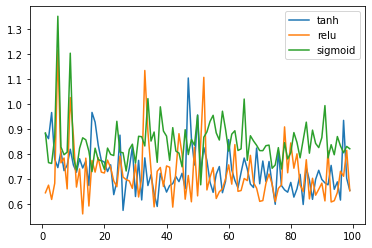

In [508]:
#average per neuron plot of neurons vs mse

for i in neurons:
    plt.plot(i,np.mean(history.h[1+(i-1)*101]['mse'][-1]))#amanha mudar



neurons=[None]*len(activations)
mse=[None]*len(activations)
for i in range(len(activations)):
    plt.plot(np.arange(1,100),results[i],label=activations[i])
    plt.legend()
    neurons[i]=np.argmin(results[i])+1
    mse[i]=results[i][neurons[i]-1]
print(neurons,mse)


In [ ]:
#example of epochs for 1 specific nr of neurons in layer
#1 - nr of neurons =7
for i in seeds:
    plt.plot(history.h[1+(i-1)*101]['mse'])#not sure about len =101 and name of history
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

In [77]:
y_testv

array([[0.76538903, 0.2748724 , 0.40171538],
       [0.6107467 , 0.22552085, 0.69994204],
       [0.96377638, 0.50028348, 0.69055876],
       [0.79030023, 0.41676265, 0.30608995],
       [0.74144052, 0.0496807 , 0.65894908],
       [0.76141765, 0.45411474, 0.36105229],
       [0.77068413, 0.35943589, 0.61030458],
       [0.86852399, 0.27776255, 0.57613934],
       [0.61489857, 0.33719287, 0.70776832],
       [0.77170707, 0.46609594, 0.43787288],
       [0.64426263, 0.29934692, 0.58356789],
       [0.79342922, 0.14971918, 0.85990068],
       [0.71081292, 0.35296051, 0.39395694],
       [0.8992117 , 0.26995187, 0.22753175],
       [0.71183586, 0.33227234, 0.54755556],
       [0.52211322, 0.59441362, 0.64020147],
       [0.77086462, 0.38842851, 0.45249885],
       [0.75540046, 0.28068921, 0.47759947],
       [0.76785606, 0.732426  , 0.55842643],
       [0.59534273, 0.3386562 , 0.42914788],
       [0.67470967, 0.17435832, 0.49443187],
       [0.00102287, 0.33261984, 0.39210777],
       [0.

Epoch 1/200
3/3 [==============================] - 1s 193ms/step - loss: 1.8099 - mean_squared_error: 1.8099 - val_loss: 2.2285 - val_mean_squared_error: 2.2285
Epoch 2/200
3/3 [==============================] - 0s 98ms/step - loss: 1.6249 - mean_squared_error: 1.6249 - val_loss: 2.0334 - val_mean_squared_error: 2.0334
Epoch 3/200
3/3 [==============================] - 0s 59ms/step - loss: 1.4670 - mean_squared_error: 1.4670 - val_loss: 1.8636 - val_mean_squared_error: 1.8636
Epoch 4/200
3/3 [==============================] - 0s 100ms/step - loss: 1.3340 - mean_squared_error: 1.3340 - val_loss: 1.7292 - val_mean_squared_error: 1.7292
Epoch 5/200
3/3 [==============================] - 0s 111ms/step - loss: 1.2268 - mean_squared_error: 1.2268 - val_loss: 1.6018 - val_mean_squared_error: 1.6018
Epoch 6/200
3/3 [==============================] - 0s 110ms/step - loss: 1.1294 - mean_squared_error: 1.1294 - val_loss: 1.4841 - val_mean_squared_error: 1.4841
Epoch 7/200
3/3 [===================

Epoch 52/200
3/3 [==============================] - 0s 120ms/step - loss: 0.1475 - mean_squared_error: 0.1475 - val_loss: 0.2216 - val_mean_squared_error: 0.2216
Epoch 53/200
3/3 [==============================] - 0s 75ms/step - loss: 0.1441 - mean_squared_error: 0.1441 - val_loss: 0.2160 - val_mean_squared_error: 0.2160
Epoch 54/200
3/3 [==============================] - 0s 120ms/step - loss: 0.1405 - mean_squared_error: 0.1405 - val_loss: 0.2106 - val_mean_squared_error: 0.2106
Epoch 55/200
3/3 [==============================] - 0s 82ms/step - loss: 0.1373 - mean_squared_error: 0.1373 - val_loss: 0.2065 - val_mean_squared_error: 0.2065
Epoch 56/200
3/3 [==============================] - 0s 97ms/step - loss: 0.1345 - mean_squared_error: 0.1345 - val_loss: 0.2026 - val_mean_squared_error: 0.2026
Epoch 57/200
3/3 [==============================] - 0s 111ms/step - loss: 0.1319 - mean_squared_error: 0.1319 - val_loss: 0.1986 - val_mean_squared_error: 0.1986
Epoch 58/200
3/3 [=============

Epoch 103/200
3/3 [==============================] - 0s 94ms/step - loss: 0.0705 - mean_squared_error: 0.0705 - val_loss: 0.1095 - val_mean_squared_error: 0.1095
Epoch 104/200
3/3 [==============================] - 0s 148ms/step - loss: 0.0698 - mean_squared_error: 0.0698 - val_loss: 0.1087 - val_mean_squared_error: 0.1087
Epoch 105/200
3/3 [==============================] - 0s 96ms/step - loss: 0.0692 - mean_squared_error: 0.0692 - val_loss: 0.1078 - val_mean_squared_error: 0.1078
Epoch 106/200
3/3 [==============================] - 0s 84ms/step - loss: 0.0687 - mean_squared_error: 0.0687 - val_loss: 0.1070 - val_mean_squared_error: 0.1070
Epoch 107/200
3/3 [==============================] - 0s 152ms/step - loss: 0.0682 - mean_squared_error: 0.0682 - val_loss: 0.1061 - val_mean_squared_error: 0.1061
Epoch 108/200
3/3 [==============================] - 0s 91ms/step - loss: 0.0676 - mean_squared_error: 0.0676 - val_loss: 0.1055 - val_mean_squared_error: 0.1055
Epoch 109/200
3/3 [=======

  0%|          | 1/5832 [21:41:19<126467:24:24, 78079.69s/it]


3/3 [==============================] - 1s 238ms/step - loss: 0.0666 - mean_squared_error: 0.0666 - val_loss: 0.1040 - val_mean_squared_error: 0.1040
Epoch 111/200
3/3 [==============================] - 0s 115ms/step - loss: 0.0661 - mean_squared_error: 0.0661 - val_loss: 0.1034 - val_mean_squared_error: 0.1034
Epoch 112/200
3/3 [==============================] - 0s 100ms/step - loss: 0.0657 - mean_squared_error: 0.0657 - val_loss: 0.1026 - val_mean_squared_error: 0.1026
Epoch 113/200
3/3 [==============================] - 0s 100ms/step - loss: 0.0651 - mean_squared_error: 0.0651 - val_loss: 0.1018 - val_mean_squared_error: 0.1018
Epoch 114/200
3/3 [==============================] - 0s 135ms/step - loss: 0.0647 - mean_squared_error: 0.0647 - val_loss: 0.1014 - val_mean_squared_error: 0.1014
Epoch 115/200
3/3 [==============================] - 0s 142ms/step - loss: 0.0642 - mean_squared_error: 0.0642 - val_loss: 0.1008 - val_mean_squared_error: 0.1008
Epoch 116/200
3/3 [=================

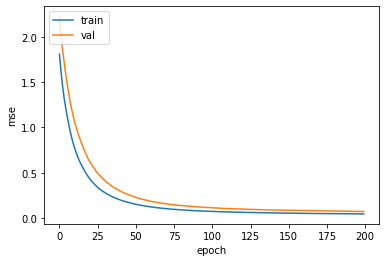

In [79]:
#before earlystopping check behaviour of plot with epochs
model=models.Sequential()
model.add(layers.Dense(10,input_dim=X_trainv.shape[1],activation='tanh'))
model.add(layers.Dense(3))#output layer
model.compile(loss='mean_squared_error',optimizer='sgd',metrics=['mean_squared_error'])
history=model.fit(X_trainv,y_trainv,validation_data=(X_testv,y_testv),epochs=200,batch_size=50,verbose=0)
#print(history.history.keys())

#-------epochs--------
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.xlabel('epoch')
plt.ylabel('mse')
plt.legend(['train', 'val'], loc='upper left')

In [82]:
y_trainv.shape[1]

3

In [ ]:
#---------CNN--------------

model=models.Sequential()
model.add(layers.Conv2D(,(,),activation=,input_shape=()))
model.add(layers.MaxPooling2D(,))
model.add(layers.Conv2D(,(,),activation=))
molde.add(layers.MaxPooling2D(,))
model.add(layers.Flatten())  #?
model.add(layers.Dense(, activation =)) 
model.add(layers.Dense(, activation =)) 
model.summary()
model.compile(optimizer=,loss=,metrics=)
#epochs early stopping
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 5,  
                                        restore_best_weights = True) 
  
history = model.fit(partial_images, partial_labels, batch_size = 128,  
                    epochs = 25, validation_data =(val_images, val_labels),  
                    callbacks =[earlystopping]) 

In [ ]:
#-------------LSTM----------------

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
testX = numpy.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
